# WFlow Model Setup for Catchment FR000119

This notebook initializes and runs the **WFlow** model using **eWaterCycle**, ERA5 forcing, and compares the simulated discharge with observed data for catchment FR000119.

## Importing Python modules

In [1]:
%matplotlib inline
# General python
import numpy as np
from pathlib import Path
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import xarray as xr
import logging
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
logging.basicConfig(level=logging.WARN)

# Niceties
from rich import print
from tqdm import tqdm


# General eWaterCycle
import ewatercycle
import ewatercycle.models
import ewatercycle.forcing
from ewatercycle.forcing import sources
import ewatercycle.parameter_sets
from ewatercycle.models import Wflow
from ewatercycle.container import ContainerImage

## Choose parameter set

In [2]:
parameter_set = ewatercycle.parameter_sets.available_parameter_sets()["wflow_rhine_sbm_nc"]
print(parameter_set)

ParameterSet(
    name='wflow_rhine_sbm_nc',
    directory=PosixPath('/data/shared/parameter-sets/wflow_rhine_sbm_nc'),
    config=PosixPath('/data/shared/parameter-sets/wflow_rhine_sbm_nc/wflow_sbm_NC.ini'),
    doi='N/A',
    target_model='wflow',
    supported_model_versions={'2020.1.3', '2020.1.2', '2020.1.1'},
    downloader=None
)

## Generate correct WFlow forcing for FR000119

In [3]:
# name of the catchment
basin_name = "FR000119"

# Define time period and shapefile
wflow_experiment_start_date = "2013-11-26T00:00:00Z"
wflow_experiment_end_date = "2019-12-31T00:00:00Z"
# Set paths and parameters
shapefile_path = Path.home() / "BEP-Elke" / "book" / "thesis_projects" / "BSc" / "2025_Q4_ElkeSchokking_CEG" / "work in progress" / "ShapefilesFR000119" / "FR000119.shp"
dem_file_path = Path("wflow_dem.map")

In [4]:
# Location forcing files in home directory
wflow_forcing_path = Path.home() / "forcing" / "FR000119" / "WFlow_ERA5"
wflow_forcing_path.mkdir(parents=True, exist_ok=True)

In [6]:
# Generate the forcing
# wflow_forcing = sources["WflowForcing"].generate(
#     dataset="ERA5",
#     start_time=wflow_experiment_start_date,
#     end_time=wflow_experiment_end_date,
#     shape=shapefile_path,
#     dem_file=str(dem_file_path.absolute())
# )


# --- Load existing WFlow forcing
wflow_forcing_dir = Path("/home/elke/BEP-Elke/book/thesis_projects/BSc/2025_Q4_ElkeSchokking_CEG/work in progress/esmvaltool_output/ewcrepqu50hjmx_20250530_115722/work/diagnostic/script")
wflow_forcing = sources["WflowForcing"].load(directory=wflow_forcing_dir)

print(wflow_forcing)

WflowForcing(
    start_time='2013-11-26T00:00:00Z',
    end_time='2019-12-31T00:00:00Z',
    directory=PosixPath('/home/elke/BEP-Elke/book/thesis_projects/BSc/2025_Q4_ElkeSchokking_CEG/work in 
progress/esmvaltool_output/ewcrepqu50hjmx_20250530_115722/work/diagnostic/script'),
    shape=PosixPath('/home/elke/BEP-Elke/book/thesis_projects/BSc/2025_Q4_ElkeSchokking_CEG/work in 
progress/esmvaltool_output/ewcrepqu50hjmx_20250530_115722/work/diagnostic/script/FR000119.shp'),
    filenames={},
    netcdfinput='wflow_ERA5_FR000119_2013_2019.nc',
    Precipitation='/pr',
    EvapoTranspiration='/pet',
    Temperature='/tas',
    Inflow=None
)

<xarray.Dataset> Size: 969MB
Dimensions:    (time: 2556, lat: 169, lon: 187, bnds: 2)
Coordinates:
  * time       (time) datetime64[ns] 20kB 2013-01-01T12:00:00 ... 2019-12-31T...
  * lat        (lat) float64 1kB 52.05 52.02 51.98 51.94 ... 45.97 45.93 45.89
  * lon        (lon) float64 1kB 5.227 5.264 5.3 5.337 ... 11.97 12.01 12.05
    height     float64 8B 2.0
Dimensions without coordinates: bnds
Data variables:
    pr         (time, lat, lon) float32 323MB 8.07 8.07 8.07 ... 0.0 0.0 0.0
    time_bnds  (time, bnds) datetime64[ns] 41kB 2013-01-01 ... 2020-01-01
    lat_bnds   (lat, bnds) float64 3kB 52.07 52.04 52.04 ... 45.91 45.91 45.88
    lon_bnds   (lon, bnds) float64 3kB 5.209 5.245 5.245 ... 12.03 12.03 12.07
    tas        (time, lat, lon) float32 323MB 6.961 6.94 6.902 ... 3.237 4.01
    pet        (time, lat, lon) float32 323MB 0.4312 0.4313 ... 0.494 0.4887
Attributes:
    Conventions:  CF-1.7
    software:     Created with ESMValTool v2.11.1
    caption:      Forcings for the wflow hydrological model.

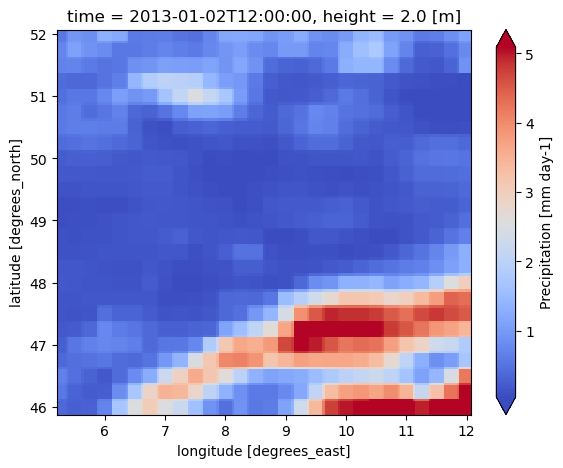

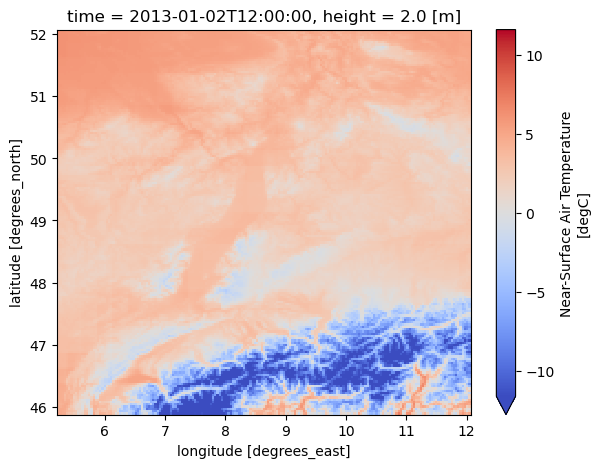

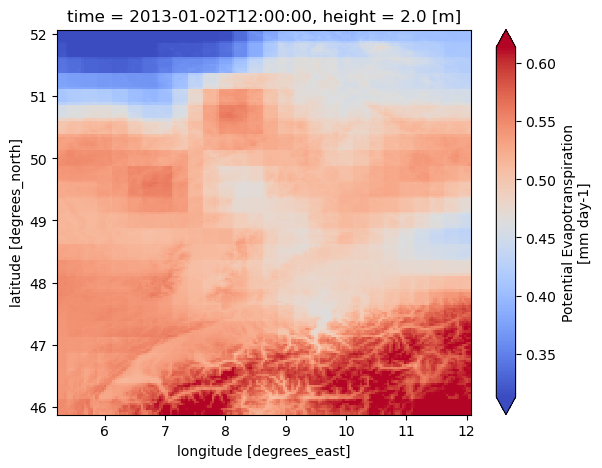

In [7]:
#Plot forcing data
dataset = xr.load_dataset(f"{wflow_forcing.directory}/{wflow_forcing.netcdfinput}")
print(dataset)
for var in ["pr", "tas", "pet"]:
    dataset[var].isel(time=1).plot(cmap="coolwarm", robust=True, size=5)

## Setting up the model
The model needs a parameter set and forcing. The parameter set can be gotten from the available parameters sets on the system and the forcing can derived from the parameter set.

In [8]:
# Create WFlow model
model = ewatercycle.models.Wflow(
    parameter_set=parameter_set,
    forcing=wflow_forcing,
    #bmi_image=ContainerImage("ewatercycle/ewatercycle/wflow-grpc4bmi:2020.1.3"),
    start_time="2013-11-26T00:00:00Z",
    end_time="2019-12-31T00:00:00Z"
)

In [9]:
print(model)

Wflow(
    parameter_set=ParameterSet(
        name='wflow_rhine_sbm_nc',
        directory=PosixPath('/data/shared/parameter-sets/wflow_rhine_sbm_nc'),
        config=PosixPath('/data/shared/parameter-sets/wflow_rhine_sbm_nc/wflow_sbm_NC.ini'),
        doi='N/A',
        target_model='wflow',
        supported_model_versions={'2020.1.3', '2020.1.2', '2020.1.1'},
        downloader=None
    ),
    forcing=WflowForcing(
        start_time='2013-11-26T00:00:00Z',
        end_time='2019-12-31T00:00:00Z',
        directory=PosixPath('/home/elke/BEP-Elke/book/thesis_projects/BSc/2025_Q4_ElkeSchokking_CEG/work in 
progress/esmvaltool_output/ewcrepqu50hjmx_20250530_115722/work/diagnostic/script'),
        shape=PosixPath('/home/elke/BEP-Elke/book/thesis_projects/BSc/2025_Q4_ElkeSchokking_CEG/work in 
progress/esmvaltool_output/ewcrepqu50hjmx_20250530_115722/work/diagnostic/script/FR000119.shp'),
        filenames={},
        netcdfinput='wflow_ERA5_FR000119_2013_2019.nc',
        Precipitation='/pr',
        EvapoTranspiration='/pet',
        Temperature='/tas',
        Inflow=None
    )
)

In [10]:
import shutil
from pathlib import Path

src = parameter_set.directory / "inmaps.nc"
dst = wflow_forcing.directory / "inmaps.nc"

shutil.copy(src, dst)

PosixPath('/home/elke/BEP-Elke/book/thesis_projects/BSc/2025_Q4_ElkeSchokking_CEG/work in progress/esmvaltool_output/ewcrepqu50hjmx_20250530_115722/work/diagnostic/script/inmaps.nc')

In [11]:
cfg_file, cfg_dir = model.setup(end_time="2019-12-31T00:00:00Z")

In [42]:
print(cfg_file)
print(cfg_dir)

/home/elke/BEP-Elke/book/thesis_projects/BSc/2025_Q4_ElkeSchokking_CEG/work in 
progress/wflow_20250605_101331/wflow_ewatercycle.ini

/home/elke/BEP-Elke/book/thesis_projects/BSc/2025_Q4_ElkeSchokking_CEG/work in progress/wflow_20250605_101331

In [46]:
## Manually change API to RiverRunoff = 1, m3/s in wflow_20250605_101331/wflow_watercycle.ini
## add output_map_variables = RiverRunoff, iflow, iwm, PET, P to .ini file

In [47]:
model.initialize(cfg_file)

In [48]:
while model.time < model.end_time:
    model.update()
    print(model.time_as_isostr)

2013-11-26T00:00:00Z

2013-11-27T00:00:00Z

2013-11-28T00:00:00Z

2013-11-29T00:00:00Z

2013-11-30T00:00:00Z

2013-12-01T00:00:00Z

2013-12-02T00:00:00Z

2013-12-03T00:00:00Z

2013-12-04T00:00:00Z

2013-12-05T00:00:00Z

2013-12-06T00:00:00Z

2013-12-07T00:00:00Z

2013-12-08T00:00:00Z

2013-12-09T00:00:00Z

2013-12-10T00:00:00Z

2013-12-11T00:00:00Z

2013-12-12T00:00:00Z

2013-12-13T00:00:00Z

2013-12-14T00:00:00Z

2013-12-15T00:00:00Z

2013-12-16T00:00:00Z

2013-12-17T00:00:00Z

2013-12-18T00:00:00Z

2013-12-19T00:00:00Z

2013-12-20T00:00:00Z

2013-12-21T00:00:00Z

2013-12-22T00:00:00Z

2013-12-23T00:00:00Z

2013-12-24T00:00:00Z

2013-12-25T00:00:00Z

2013-12-26T00:00:00Z

2013-12-27T00:00:00Z

2013-12-28T00:00:00Z

2013-12-29T00:00:00Z

2013-12-30T00:00:00Z

2013-12-31T00:00:00Z

2014-01-01T00:00:00Z

2014-01-02T00:00:00Z

2014-01-03T00:00:00Z

2014-01-04T00:00:00Z

2014-01-05T00:00:00Z

2014-01-06T00:00:00Z

2014-01-07T00:00:00Z

2014-01-08T00:00:00Z

2014-01-09T00:00:00Z

2014-01-10T00:00:00Z

2014-01-11T00:00:00Z

2014-01-12T00:00:00Z

2014-01-13T00:00:00Z

2014-01-14T00:00:00Z

2014-01-15T00:00:00Z

2014-01-16T00:00:00Z

2014-01-17T00:00:00Z

2014-01-18T00:00:00Z

2014-01-19T00:00:00Z

2014-01-20T00:00:00Z

2014-01-21T00:00:00Z

2014-01-22T00:00:00Z

2014-01-23T00:00:00Z

2014-01-24T00:00:00Z

2014-01-25T00:00:00Z

2014-01-26T00:00:00Z

2014-01-27T00:00:00Z

2014-01-28T00:00:00Z

2014-01-29T00:00:00Z

2014-01-30T00:00:00Z

2014-01-31T00:00:00Z

2014-02-01T00:00:00Z

2014-02-02T00:00:00Z

2014-02-03T00:00:00Z

2014-02-04T00:00:00Z

2014-02-05T00:00:00Z

2014-02-06T00:00:00Z

2014-02-07T00:00:00Z

2014-02-08T00:00:00Z

2014-02-09T00:00:00Z

2014-02-10T00:00:00Z

2014-02-11T00:00:00Z

2014-02-12T00:00:00Z

2014-02-13T00:00:00Z

2014-02-14T00:00:00Z

2014-02-15T00:00:00Z

2014-02-16T00:00:00Z

2014-02-17T00:00:00Z

2014-02-18T00:00:00Z

2014-02-19T00:00:00Z

2014-02-20T00:00:00Z

2014-02-21T00:00:00Z

2014-02-22T00:00:00Z

2014-02-23T00:00:00Z

2014-02-24T00:00:00Z

2014-02-25T00:00:00Z

2014-02-26T00:00:00Z

2014-02-27T00:00:00Z

2014-02-28T00:00:00Z

2014-03-01T00:00:00Z

2014-03-02T00:00:00Z

2014-03-03T00:00:00Z

2014-03-04T00:00:00Z

2014-03-05T00:00:00Z

2014-03-06T00:00:00Z

2014-03-07T00:00:00Z

2014-03-08T00:00:00Z

2014-03-09T00:00:00Z

2014-03-10T00:00:00Z

2014-03-11T00:00:00Z

2014-03-12T00:00:00Z

2014-03-13T00:00:00Z

2014-03-14T00:00:00Z

2014-03-15T00:00:00Z

2014-03-16T00:00:00Z

2014-03-17T00:00:00Z

2014-03-18T00:00:00Z

2014-03-19T00:00:00Z

2014-03-20T00:00:00Z

2014-03-21T00:00:00Z

2014-03-22T00:00:00Z

2014-03-23T00:00:00Z

2014-03-24T00:00:00Z

2014-03-25T00:00:00Z

2014-03-26T00:00:00Z

2014-03-27T00:00:00Z

2014-03-28T00:00:00Z

2014-03-29T00:00:00Z

2014-03-30T00:00:00Z

2014-03-31T00:00:00Z

2014-04-01T00:00:00Z

2014-04-02T00:00:00Z

2014-04-03T00:00:00Z

2014-04-04T00:00:00Z

2014-04-05T00:00:00Z

2014-04-06T00:00:00Z

2014-04-07T00:00:00Z

2014-04-08T00:00:00Z

2014-04-09T00:00:00Z

2014-04-10T00:00:00Z

2014-04-11T00:00:00Z

2014-04-12T00:00:00Z

2014-04-13T00:00:00Z

2014-04-14T00:00:00Z

2014-04-15T00:00:00Z

2014-04-16T00:00:00Z

2014-04-17T00:00:00Z

2014-04-18T00:00:00Z

2014-04-19T00:00:00Z

2014-04-20T00:00:00Z

2014-04-21T00:00:00Z

2014-04-22T00:00:00Z

2014-04-23T00:00:00Z

2014-04-24T00:00:00Z

2014-04-25T00:00:00Z

2014-04-26T00:00:00Z

2014-04-27T00:00:00Z

2014-04-28T00:00:00Z

2014-04-29T00:00:00Z

2014-04-30T00:00:00Z

2014-05-01T00:00:00Z

2014-05-02T00:00:00Z

2014-05-03T00:00:00Z

2014-05-04T00:00:00Z

2014-05-05T00:00:00Z

2014-05-06T00:00:00Z

2014-05-07T00:00:00Z

2014-05-08T00:00:00Z

2014-05-09T00:00:00Z

2014-05-10T00:00:00Z

2014-05-11T00:00:00Z

2014-05-12T00:00:00Z

2014-05-13T00:00:00Z

2014-05-14T00:00:00Z

2014-05-15T00:00:00Z

2014-05-16T00:00:00Z

2014-05-17T00:00:00Z

2014-05-18T00:00:00Z

2014-05-19T00:00:00Z

2014-05-20T00:00:00Z

2014-05-21T00:00:00Z

2014-05-22T00:00:00Z

2014-05-23T00:00:00Z

2014-05-24T00:00:00Z

2014-05-25T00:00:00Z

2014-05-26T00:00:00Z

2014-05-27T00:00:00Z

2014-05-28T00:00:00Z

2014-05-29T00:00:00Z

2014-05-30T00:00:00Z

2014-05-31T00:00:00Z

2014-06-01T00:00:00Z

2014-06-02T00:00:00Z

2014-06-03T00:00:00Z

2014-06-04T00:00:00Z

2014-06-05T00:00:00Z

2014-06-06T00:00:00Z

2014-06-07T00:00:00Z

2014-06-08T00:00:00Z

2014-06-09T00:00:00Z

2014-06-10T00:00:00Z

2014-06-11T00:00:00Z

2014-06-12T00:00:00Z

2014-06-13T00:00:00Z

2014-06-14T00:00:00Z

2014-06-15T00:00:00Z

2014-06-16T00:00:00Z

2014-06-17T00:00:00Z

2014-06-18T00:00:00Z

2014-06-19T00:00:00Z

2014-06-20T00:00:00Z

2014-06-21T00:00:00Z

2014-06-22T00:00:00Z

2014-06-23T00:00:00Z

2014-06-24T00:00:00Z

2014-06-25T00:00:00Z

2014-06-26T00:00:00Z

2014-06-27T00:00:00Z

2014-06-28T00:00:00Z

2014-06-29T00:00:00Z

2014-06-30T00:00:00Z

2014-07-01T00:00:00Z

2014-07-02T00:00:00Z

2014-07-03T00:00:00Z

2014-07-04T00:00:00Z

2014-07-05T00:00:00Z

2014-07-06T00:00:00Z

2014-07-07T00:00:00Z

2014-07-08T00:00:00Z

2014-07-09T00:00:00Z

2014-07-10T00:00:00Z

2014-07-11T00:00:00Z

2014-07-12T00:00:00Z

2014-07-13T00:00:00Z

2014-07-14T00:00:00Z

2014-07-15T00:00:00Z

2014-07-16T00:00:00Z

2014-07-17T00:00:00Z

2014-07-18T00:00:00Z

2014-07-19T00:00:00Z

2014-07-20T00:00:00Z

2014-07-21T00:00:00Z

2014-07-22T00:00:00Z

2014-07-23T00:00:00Z

2014-07-24T00:00:00Z

2014-07-25T00:00:00Z

2014-07-26T00:00:00Z

2014-07-27T00:00:00Z

2014-07-28T00:00:00Z

2014-07-29T00:00:00Z

2014-07-30T00:00:00Z

2014-07-31T00:00:00Z

2014-08-01T00:00:00Z

2014-08-02T00:00:00Z

2014-08-03T00:00:00Z

2014-08-04T00:00:00Z

2014-08-05T00:00:00Z

2014-08-06T00:00:00Z

2014-08-07T00:00:00Z

2014-08-08T00:00:00Z

2014-08-09T00:00:00Z

2014-08-10T00:00:00Z

2014-08-11T00:00:00Z

2014-08-12T00:00:00Z

2014-08-13T00:00:00Z

2014-08-14T00:00:00Z

2014-08-15T00:00:00Z

2014-08-16T00:00:00Z

2014-08-17T00:00:00Z

2014-08-18T00:00:00Z

2014-08-19T00:00:00Z

2014-08-20T00:00:00Z

2014-08-21T00:00:00Z

2014-08-22T00:00:00Z

2014-08-23T00:00:00Z

2014-08-24T00:00:00Z

2014-08-25T00:00:00Z

2014-08-26T00:00:00Z

2014-08-27T00:00:00Z

2014-08-28T00:00:00Z

2014-08-29T00:00:00Z

2014-08-30T00:00:00Z

2014-08-31T00:00:00Z

2014-09-01T00:00:00Z

2014-09-02T00:00:00Z

2014-09-03T00:00:00Z

2014-09-04T00:00:00Z

2014-09-05T00:00:00Z

2014-09-06T00:00:00Z

2014-09-07T00:00:00Z

2014-09-08T00:00:00Z

2014-09-09T00:00:00Z

2014-09-10T00:00:00Z

2014-09-11T00:00:00Z

2014-09-12T00:00:00Z

2014-09-13T00:00:00Z

2014-09-14T00:00:00Z

2014-09-15T00:00:00Z

2014-09-16T00:00:00Z

2014-09-17T00:00:00Z

2014-09-18T00:00:00Z

2014-09-19T00:00:00Z

2014-09-20T00:00:00Z

2014-09-21T00:00:00Z

2014-09-22T00:00:00Z

2014-09-23T00:00:00Z

2014-09-24T00:00:00Z

2014-09-25T00:00:00Z

2014-09-26T00:00:00Z

2014-09-27T00:00:00Z

2014-09-28T00:00:00Z

2014-09-29T00:00:00Z

2014-09-30T00:00:00Z

2014-10-01T00:00:00Z

2014-10-02T00:00:00Z

2014-10-03T00:00:00Z

2014-10-04T00:00:00Z

2014-10-05T00:00:00Z

2014-10-06T00:00:00Z

2014-10-07T00:00:00Z

2014-10-08T00:00:00Z

2014-10-09T00:00:00Z

2014-10-10T00:00:00Z

2014-10-11T00:00:00Z

2014-10-12T00:00:00Z

2014-10-13T00:00:00Z

2014-10-14T00:00:00Z

2014-10-15T00:00:00Z

2014-10-16T00:00:00Z

2014-10-17T00:00:00Z

2014-10-18T00:00:00Z

2014-10-19T00:00:00Z

2014-10-20T00:00:00Z

2014-10-21T00:00:00Z

2014-10-22T00:00:00Z

2014-10-23T00:00:00Z

2014-10-24T00:00:00Z

2014-10-25T00:00:00Z

2014-10-26T00:00:00Z

2014-10-27T00:00:00Z

2014-10-28T00:00:00Z

2014-10-29T00:00:00Z

2014-10-30T00:00:00Z

2014-10-31T00:00:00Z

2014-11-01T00:00:00Z

2014-11-02T00:00:00Z

2014-11-03T00:00:00Z

2014-11-04T00:00:00Z

2014-11-05T00:00:00Z

2014-11-06T00:00:00Z

2014-11-07T00:00:00Z

2014-11-08T00:00:00Z

2014-11-09T00:00:00Z

2014-11-10T00:00:00Z

2014-11-11T00:00:00Z

2014-11-12T00:00:00Z

2014-11-13T00:00:00Z

2014-11-14T00:00:00Z

2014-11-15T00:00:00Z

2014-11-16T00:00:00Z

2014-11-17T00:00:00Z

2014-11-18T00:00:00Z

2014-11-19T00:00:00Z

2014-11-20T00:00:00Z

2014-11-21T00:00:00Z

2014-11-22T00:00:00Z

2014-11-23T00:00:00Z

2014-11-24T00:00:00Z

2014-11-25T00:00:00Z

2014-11-26T00:00:00Z

2014-11-27T00:00:00Z

2014-11-28T00:00:00Z

2014-11-29T00:00:00Z

2014-11-30T00:00:00Z

2014-12-01T00:00:00Z

2014-12-02T00:00:00Z

2014-12-03T00:00:00Z

2014-12-04T00:00:00Z

2014-12-05T00:00:00Z

2014-12-06T00:00:00Z

2014-12-07T00:00:00Z

2014-12-08T00:00:00Z

2014-12-09T00:00:00Z

2014-12-10T00:00:00Z

2014-12-11T00:00:00Z

2014-12-12T00:00:00Z

2014-12-13T00:00:00Z

2014-12-14T00:00:00Z

2014-12-15T00:00:00Z

2014-12-16T00:00:00Z

2014-12-17T00:00:00Z

2014-12-18T00:00:00Z

2014-12-19T00:00:00Z

2014-12-20T00:00:00Z

2014-12-21T00:00:00Z

2014-12-22T00:00:00Z

2014-12-23T00:00:00Z

2014-12-24T00:00:00Z

2014-12-25T00:00:00Z

2014-12-26T00:00:00Z

2014-12-27T00:00:00Z

2014-12-28T00:00:00Z

2014-12-29T00:00:00Z

2014-12-30T00:00:00Z

2014-12-31T00:00:00Z

2015-01-01T00:00:00Z

2015-01-02T00:00:00Z

2015-01-03T00:00:00Z

2015-01-04T00:00:00Z

2015-01-05T00:00:00Z

2015-01-06T00:00:00Z

2015-01-07T00:00:00Z

2015-01-08T00:00:00Z

2015-01-09T00:00:00Z

2015-01-10T00:00:00Z

2015-01-11T00:00:00Z

2015-01-12T00:00:00Z

2015-01-13T00:00:00Z

2015-01-14T00:00:00Z

2015-01-15T00:00:00Z

2015-01-16T00:00:00Z

2015-01-17T00:00:00Z

2015-01-18T00:00:00Z

2015-01-19T00:00:00Z

2015-01-20T00:00:00Z

2015-01-21T00:00:00Z

2015-01-22T00:00:00Z

2015-01-23T00:00:00Z

2015-01-24T00:00:00Z

2015-01-25T00:00:00Z

2015-01-26T00:00:00Z

2015-01-27T00:00:00Z

2015-01-28T00:00:00Z

2015-01-29T00:00:00Z

2015-01-30T00:00:00Z

2015-01-31T00:00:00Z

2015-02-01T00:00:00Z

2015-02-02T00:00:00Z

2015-02-03T00:00:00Z

2015-02-04T00:00:00Z

2015-02-05T00:00:00Z

2015-02-06T00:00:00Z

2015-02-07T00:00:00Z

2015-02-08T00:00:00Z

2015-02-09T00:00:00Z

2015-02-10T00:00:00Z

2015-02-11T00:00:00Z

2015-02-12T00:00:00Z

2015-02-13T00:00:00Z

2015-02-14T00:00:00Z

2015-02-15T00:00:00Z

2015-02-16T00:00:00Z

2015-02-17T00:00:00Z

2015-02-18T00:00:00Z

2015-02-19T00:00:00Z

2015-02-20T00:00:00Z

2015-02-21T00:00:00Z

2015-02-22T00:00:00Z

2015-02-23T00:00:00Z

2015-02-24T00:00:00Z

2015-02-25T00:00:00Z

2015-02-26T00:00:00Z

2015-02-27T00:00:00Z

2015-02-28T00:00:00Z

2015-03-01T00:00:00Z

2015-03-02T00:00:00Z

2015-03-03T00:00:00Z

2015-03-04T00:00:00Z

2015-03-05T00:00:00Z

2015-03-06T00:00:00Z

2015-03-07T00:00:00Z

2015-03-08T00:00:00Z

2015-03-09T00:00:00Z

2015-03-10T00:00:00Z

2015-03-11T00:00:00Z

2015-03-12T00:00:00Z

2015-03-13T00:00:00Z

2015-03-14T00:00:00Z

2015-03-15T00:00:00Z

2015-03-16T00:00:00Z

2015-03-17T00:00:00Z

2015-03-18T00:00:00Z

2015-03-19T00:00:00Z

2015-03-20T00:00:00Z

2015-03-21T00:00:00Z

2015-03-22T00:00:00Z

2015-03-23T00:00:00Z

2015-03-24T00:00:00Z

2015-03-25T00:00:00Z

2015-03-26T00:00:00Z

2015-03-27T00:00:00Z

2015-03-28T00:00:00Z

2015-03-29T00:00:00Z

2015-03-30T00:00:00Z

2015-03-31T00:00:00Z

2015-04-01T00:00:00Z

2015-04-02T00:00:00Z

2015-04-03T00:00:00Z

2015-04-04T00:00:00Z

2015-04-05T00:00:00Z

2015-04-06T00:00:00Z

2015-04-07T00:00:00Z

2015-04-08T00:00:00Z

2015-04-09T00:00:00Z

2015-04-10T00:00:00Z

2015-04-11T00:00:00Z

2015-04-12T00:00:00Z

2015-04-13T00:00:00Z

2015-04-14T00:00:00Z

2015-04-15T00:00:00Z

2015-04-16T00:00:00Z

2015-04-17T00:00:00Z

2015-04-18T00:00:00Z

2015-04-19T00:00:00Z

2015-04-20T00:00:00Z

2015-04-21T00:00:00Z

2015-04-22T00:00:00Z

2015-04-23T00:00:00Z

2015-04-24T00:00:00Z

2015-04-25T00:00:00Z

2015-04-26T00:00:00Z

2015-04-27T00:00:00Z

2015-04-28T00:00:00Z

2015-04-29T00:00:00Z

2015-04-30T00:00:00Z

2015-05-01T00:00:00Z

2015-05-02T00:00:00Z

2015-05-03T00:00:00Z

2015-05-04T00:00:00Z

2015-05-05T00:00:00Z

2015-05-06T00:00:00Z

2015-05-07T00:00:00Z

2015-05-08T00:00:00Z

2015-05-09T00:00:00Z

2015-05-10T00:00:00Z

2015-05-11T00:00:00Z

2015-05-12T00:00:00Z

2015-05-13T00:00:00Z

2015-05-14T00:00:00Z

2015-05-15T00:00:00Z

2015-05-16T00:00:00Z

2015-05-17T00:00:00Z

2015-05-18T00:00:00Z

2015-05-19T00:00:00Z

2015-05-20T00:00:00Z

2015-05-21T00:00:00Z

2015-05-22T00:00:00Z

2015-05-23T00:00:00Z

2015-05-24T00:00:00Z

2015-05-25T00:00:00Z

2015-05-26T00:00:00Z

2015-05-27T00:00:00Z

2015-05-28T00:00:00Z

2015-05-29T00:00:00Z

2015-05-30T00:00:00Z

2015-05-31T00:00:00Z

2015-06-01T00:00:00Z

2015-06-02T00:00:00Z

2015-06-03T00:00:00Z

2015-06-04T00:00:00Z

2015-06-05T00:00:00Z

2015-06-06T00:00:00Z

2015-06-07T00:00:00Z

2015-06-08T00:00:00Z

2015-06-09T00:00:00Z

2015-06-10T00:00:00Z

2015-06-11T00:00:00Z

2015-06-12T00:00:00Z

2015-06-13T00:00:00Z

2015-06-14T00:00:00Z

2015-06-15T00:00:00Z

2015-06-16T00:00:00Z

2015-06-17T00:00:00Z

2015-06-18T00:00:00Z

2015-06-19T00:00:00Z

2015-06-20T00:00:00Z

2015-06-21T00:00:00Z

2015-06-22T00:00:00Z

2015-06-23T00:00:00Z

2015-06-24T00:00:00Z

2015-06-25T00:00:00Z

2015-06-26T00:00:00Z

2015-06-27T00:00:00Z

2015-06-28T00:00:00Z

2015-06-29T00:00:00Z

2015-06-30T00:00:00Z

2015-07-01T00:00:00Z

2015-07-02T00:00:00Z

2015-07-03T00:00:00Z

2015-07-04T00:00:00Z

2015-07-05T00:00:00Z

2015-07-06T00:00:00Z

2015-07-07T00:00:00Z

2015-07-08T00:00:00Z

2015-07-09T00:00:00Z

2015-07-10T00:00:00Z

2015-07-11T00:00:00Z

2015-07-12T00:00:00Z

2015-07-13T00:00:00Z

2015-07-14T00:00:00Z

2015-07-15T00:00:00Z

2015-07-16T00:00:00Z

2015-07-17T00:00:00Z

2015-07-18T00:00:00Z

2015-07-19T00:00:00Z

2015-07-20T00:00:00Z

2015-07-21T00:00:00Z

2015-07-22T00:00:00Z

2015-07-23T00:00:00Z

2015-07-24T00:00:00Z

2015-07-25T00:00:00Z

2015-07-26T00:00:00Z

2015-07-27T00:00:00Z

2015-07-28T00:00:00Z

2015-07-29T00:00:00Z

2015-07-30T00:00:00Z

2015-07-31T00:00:00Z

2015-08-01T00:00:00Z

2015-08-02T00:00:00Z

2015-08-03T00:00:00Z

2015-08-04T00:00:00Z

2015-08-05T00:00:00Z

2015-08-06T00:00:00Z

2015-08-07T00:00:00Z

2015-08-08T00:00:00Z

2015-08-09T00:00:00Z

2015-08-10T00:00:00Z

2015-08-11T00:00:00Z

2015-08-12T00:00:00Z

2015-08-13T00:00:00Z

2015-08-14T00:00:00Z

2015-08-15T00:00:00Z

2015-08-16T00:00:00Z

2015-08-17T00:00:00Z

2015-08-18T00:00:00Z

2015-08-19T00:00:00Z

2015-08-20T00:00:00Z

2015-08-21T00:00:00Z

2015-08-22T00:00:00Z

2015-08-23T00:00:00Z

2015-08-24T00:00:00Z

2015-08-25T00:00:00Z

2015-08-26T00:00:00Z

2015-08-27T00:00:00Z

2015-08-28T00:00:00Z

2015-08-29T00:00:00Z

2015-08-30T00:00:00Z

2015-08-31T00:00:00Z

2015-09-01T00:00:00Z

2015-09-02T00:00:00Z

2015-09-03T00:00:00Z

2015-09-04T00:00:00Z

2015-09-05T00:00:00Z

2015-09-06T00:00:00Z

2015-09-07T00:00:00Z

2015-09-08T00:00:00Z

2015-09-09T00:00:00Z

2015-09-10T00:00:00Z

2015-09-11T00:00:00Z

2015-09-12T00:00:00Z

2015-09-13T00:00:00Z

2015-09-14T00:00:00Z

2015-09-15T00:00:00Z

2015-09-16T00:00:00Z

2015-09-17T00:00:00Z

2015-09-18T00:00:00Z

2015-09-19T00:00:00Z

2015-09-20T00:00:00Z

2015-09-21T00:00:00Z

2015-09-22T00:00:00Z

2015-09-23T00:00:00Z

2015-09-24T00:00:00Z

2015-09-25T00:00:00Z

2015-09-26T00:00:00Z

2015-09-27T00:00:00Z

2015-09-28T00:00:00Z

2015-09-29T00:00:00Z

2015-09-30T00:00:00Z

2015-10-01T00:00:00Z

2015-10-02T00:00:00Z

2015-10-03T00:00:00Z

2015-10-04T00:00:00Z

2015-10-05T00:00:00Z

2015-10-06T00:00:00Z

2015-10-07T00:00:00Z

2015-10-08T00:00:00Z

2015-10-09T00:00:00Z

2015-10-10T00:00:00Z

2015-10-11T00:00:00Z

2015-10-12T00:00:00Z

2015-10-13T00:00:00Z

2015-10-14T00:00:00Z

2015-10-15T00:00:00Z

2015-10-16T00:00:00Z

2015-10-17T00:00:00Z

2015-10-18T00:00:00Z

2015-10-19T00:00:00Z

2015-10-20T00:00:00Z

2015-10-21T00:00:00Z

2015-10-22T00:00:00Z

2015-10-23T00:00:00Z

2015-10-24T00:00:00Z

2015-10-25T00:00:00Z

2015-10-26T00:00:00Z

2015-10-27T00:00:00Z

2015-10-28T00:00:00Z

2015-10-29T00:00:00Z

2015-10-30T00:00:00Z

2015-10-31T00:00:00Z

2015-11-01T00:00:00Z

2015-11-02T00:00:00Z

2015-11-03T00:00:00Z

2015-11-04T00:00:00Z

2015-11-05T00:00:00Z

2015-11-06T00:00:00Z

2015-11-07T00:00:00Z

2015-11-08T00:00:00Z

2015-11-09T00:00:00Z

2015-11-10T00:00:00Z

2015-11-11T00:00:00Z

2015-11-12T00:00:00Z

2015-11-13T00:00:00Z

2015-11-14T00:00:00Z

2015-11-15T00:00:00Z

2015-11-16T00:00:00Z

2015-11-17T00:00:00Z

2015-11-18T00:00:00Z

2015-11-19T00:00:00Z

2015-11-20T00:00:00Z

2015-11-21T00:00:00Z

2015-11-22T00:00:00Z

2015-11-23T00:00:00Z

2015-11-24T00:00:00Z

2015-11-25T00:00:00Z

2015-11-26T00:00:00Z

2015-11-27T00:00:00Z

2015-11-28T00:00:00Z

2015-11-29T00:00:00Z

2015-11-30T00:00:00Z

2015-12-01T00:00:00Z

2015-12-02T00:00:00Z

2015-12-03T00:00:00Z

2015-12-04T00:00:00Z

2015-12-05T00:00:00Z

2015-12-06T00:00:00Z

2015-12-07T00:00:00Z

2015-12-08T00:00:00Z

2015-12-09T00:00:00Z

2015-12-10T00:00:00Z

2015-12-11T00:00:00Z

2015-12-12T00:00:00Z

2015-12-13T00:00:00Z

2015-12-14T00:00:00Z

2015-12-15T00:00:00Z

2015-12-16T00:00:00Z

2015-12-17T00:00:00Z

2015-12-18T00:00:00Z

2015-12-19T00:00:00Z

2015-12-20T00:00:00Z

2015-12-21T00:00:00Z

2015-12-22T00:00:00Z

2015-12-23T00:00:00Z

2015-12-24T00:00:00Z

2015-12-25T00:00:00Z

2015-12-26T00:00:00Z

2015-12-27T00:00:00Z

2015-12-28T00:00:00Z

2015-12-29T00:00:00Z

2015-12-30T00:00:00Z

2015-12-31T00:00:00Z

2016-01-01T00:00:00Z

2016-01-02T00:00:00Z

2016-01-03T00:00:00Z

2016-01-04T00:00:00Z

2016-01-05T00:00:00Z

2016-01-06T00:00:00Z

2016-01-07T00:00:00Z

2016-01-08T00:00:00Z

2016-01-09T00:00:00Z

2016-01-10T00:00:00Z

2016-01-11T00:00:00Z

2016-01-12T00:00:00Z

2016-01-13T00:00:00Z

2016-01-14T00:00:00Z

2016-01-15T00:00:00Z

2016-01-16T00:00:00Z

2016-01-17T00:00:00Z

2016-01-18T00:00:00Z

2016-01-19T00:00:00Z

2016-01-20T00:00:00Z

2016-01-21T00:00:00Z

2016-01-22T00:00:00Z

2016-01-23T00:00:00Z

2016-01-24T00:00:00Z

2016-01-25T00:00:00Z

2016-01-26T00:00:00Z

2016-01-27T00:00:00Z

2016-01-28T00:00:00Z

2016-01-29T00:00:00Z

2016-01-30T00:00:00Z

2016-01-31T00:00:00Z

2016-02-01T00:00:00Z

2016-02-02T00:00:00Z

2016-02-03T00:00:00Z

2016-02-04T00:00:00Z

2016-02-05T00:00:00Z

2016-02-06T00:00:00Z

2016-02-07T00:00:00Z

2016-02-08T00:00:00Z

2016-02-09T00:00:00Z

2016-02-10T00:00:00Z

2016-02-11T00:00:00Z

2016-02-12T00:00:00Z

2016-02-13T00:00:00Z

2016-02-14T00:00:00Z

2016-02-15T00:00:00Z

2016-02-16T00:00:00Z

2016-02-17T00:00:00Z

2016-02-18T00:00:00Z

2016-02-19T00:00:00Z

2016-02-20T00:00:00Z

2016-02-21T00:00:00Z

2016-02-22T00:00:00Z

2016-02-23T00:00:00Z

2016-02-24T00:00:00Z

2016-02-25T00:00:00Z

2016-02-26T00:00:00Z

2016-02-27T00:00:00Z

2016-02-28T00:00:00Z

2016-02-29T00:00:00Z

2016-03-01T00:00:00Z

2016-03-02T00:00:00Z

2016-03-03T00:00:00Z

2016-03-04T00:00:00Z

2016-03-05T00:00:00Z

2016-03-06T00:00:00Z

2016-03-07T00:00:00Z

2016-03-08T00:00:00Z

2016-03-09T00:00:00Z

2016-03-10T00:00:00Z

2016-03-11T00:00:00Z

2016-03-12T00:00:00Z

2016-03-13T00:00:00Z

2016-03-14T00:00:00Z

2016-03-15T00:00:00Z

2016-03-16T00:00:00Z

2016-03-17T00:00:00Z

2016-03-18T00:00:00Z

2016-03-19T00:00:00Z

2016-03-20T00:00:00Z

2016-03-21T00:00:00Z

2016-03-22T00:00:00Z

2016-03-23T00:00:00Z

2016-03-24T00:00:00Z

2016-03-25T00:00:00Z

2016-03-26T00:00:00Z

2016-03-27T00:00:00Z

2016-03-28T00:00:00Z

2016-03-29T00:00:00Z

2016-03-30T00:00:00Z

2016-03-31T00:00:00Z

2016-04-01T00:00:00Z

2016-04-02T00:00:00Z

2016-04-03T00:00:00Z

2016-04-04T00:00:00Z

2016-04-05T00:00:00Z

2016-04-06T00:00:00Z

2016-04-07T00:00:00Z

2016-04-08T00:00:00Z

2016-04-09T00:00:00Z

2016-04-10T00:00:00Z

2016-04-11T00:00:00Z

2016-04-12T00:00:00Z

2016-04-13T00:00:00Z

2016-04-14T00:00:00Z

2016-04-15T00:00:00Z

2016-04-16T00:00:00Z

2016-04-17T00:00:00Z

2016-04-18T00:00:00Z

2016-04-19T00:00:00Z

2016-04-20T00:00:00Z

2016-04-21T00:00:00Z

2016-04-22T00:00:00Z

2016-04-23T00:00:00Z

2016-04-24T00:00:00Z

2016-04-25T00:00:00Z

2016-04-26T00:00:00Z

2016-04-27T00:00:00Z

2016-04-28T00:00:00Z

2016-04-29T00:00:00Z

2016-04-30T00:00:00Z

2016-05-01T00:00:00Z

2016-05-02T00:00:00Z

2016-05-03T00:00:00Z

2016-05-04T00:00:00Z

2016-05-05T00:00:00Z

2016-05-06T00:00:00Z

2016-05-07T00:00:00Z

2016-05-08T00:00:00Z

2016-05-09T00:00:00Z

2016-05-10T00:00:00Z

2016-05-11T00:00:00Z

2016-05-12T00:00:00Z

2016-05-13T00:00:00Z

2016-05-14T00:00:00Z

2016-05-15T00:00:00Z

2016-05-16T00:00:00Z

2016-05-17T00:00:00Z

2016-05-18T00:00:00Z

2016-05-19T00:00:00Z

2016-05-20T00:00:00Z

2016-05-21T00:00:00Z

2016-05-22T00:00:00Z

2016-05-23T00:00:00Z

2016-05-24T00:00:00Z

2016-05-25T00:00:00Z

2016-05-26T00:00:00Z

2016-05-27T00:00:00Z

2016-05-28T00:00:00Z

2016-05-29T00:00:00Z

2016-05-30T00:00:00Z

2016-05-31T00:00:00Z

2016-06-01T00:00:00Z

2016-06-02T00:00:00Z

2016-06-03T00:00:00Z

2016-06-04T00:00:00Z

2016-06-05T00:00:00Z

2016-06-06T00:00:00Z

2016-06-07T00:00:00Z

2016-06-08T00:00:00Z

2016-06-09T00:00:00Z

2016-06-10T00:00:00Z

2016-06-11T00:00:00Z

2016-06-12T00:00:00Z

2016-06-13T00:00:00Z

2016-06-14T00:00:00Z

2016-06-15T00:00:00Z

2016-06-16T00:00:00Z

2016-06-17T00:00:00Z

2016-06-18T00:00:00Z

2016-06-19T00:00:00Z

2016-06-20T00:00:00Z

2016-06-21T00:00:00Z

2016-06-22T00:00:00Z

2016-06-23T00:00:00Z

2016-06-24T00:00:00Z

2016-06-25T00:00:00Z

2016-06-26T00:00:00Z

2016-06-27T00:00:00Z

2016-06-28T00:00:00Z

2016-06-29T00:00:00Z

2016-06-30T00:00:00Z

2016-07-01T00:00:00Z

2016-07-02T00:00:00Z

2016-07-03T00:00:00Z

2016-07-04T00:00:00Z

2016-07-05T00:00:00Z

2016-07-06T00:00:00Z

2016-07-07T00:00:00Z

2016-07-08T00:00:00Z

2016-07-09T00:00:00Z

2016-07-10T00:00:00Z

2016-07-11T00:00:00Z

2016-07-12T00:00:00Z

2016-07-13T00:00:00Z

2016-07-14T00:00:00Z

2016-07-15T00:00:00Z

2016-07-16T00:00:00Z

2016-07-17T00:00:00Z

2016-07-18T00:00:00Z

2016-07-19T00:00:00Z

2016-07-20T00:00:00Z

2016-07-21T00:00:00Z

2016-07-22T00:00:00Z

2016-07-23T00:00:00Z

2016-07-24T00:00:00Z

2016-07-25T00:00:00Z

2016-07-26T00:00:00Z

2016-07-27T00:00:00Z

2016-07-28T00:00:00Z

2016-07-29T00:00:00Z

2016-07-30T00:00:00Z

2016-07-31T00:00:00Z

2016-08-01T00:00:00Z

2016-08-02T00:00:00Z

2016-08-03T00:00:00Z

2016-08-04T00:00:00Z

2016-08-05T00:00:00Z

2016-08-06T00:00:00Z

2016-08-07T00:00:00Z

2016-08-08T00:00:00Z

2016-08-09T00:00:00Z

2016-08-10T00:00:00Z

2016-08-11T00:00:00Z

2016-08-12T00:00:00Z

2016-08-13T00:00:00Z

2016-08-14T00:00:00Z

2016-08-15T00:00:00Z

2016-08-16T00:00:00Z

2016-08-17T00:00:00Z

2016-08-18T00:00:00Z

2016-08-19T00:00:00Z

2016-08-20T00:00:00Z

2016-08-21T00:00:00Z

2016-08-22T00:00:00Z

2016-08-23T00:00:00Z

2016-08-24T00:00:00Z

2016-08-25T00:00:00Z

2016-08-26T00:00:00Z

2016-08-27T00:00:00Z

2016-08-28T00:00:00Z

2016-08-29T00:00:00Z

2016-08-30T00:00:00Z

2016-08-31T00:00:00Z

2016-09-01T00:00:00Z

2016-09-02T00:00:00Z

2016-09-03T00:00:00Z

2016-09-04T00:00:00Z

2016-09-05T00:00:00Z

2016-09-06T00:00:00Z

2016-09-07T00:00:00Z

2016-09-08T00:00:00Z

2016-09-09T00:00:00Z

2016-09-10T00:00:00Z

2016-09-11T00:00:00Z

2016-09-12T00:00:00Z

2016-09-13T00:00:00Z

2016-09-14T00:00:00Z

2016-09-15T00:00:00Z

2016-09-16T00:00:00Z

2016-09-17T00:00:00Z

2016-09-18T00:00:00Z

2016-09-19T00:00:00Z

2016-09-20T00:00:00Z

2016-09-21T00:00:00Z

2016-09-22T00:00:00Z

2016-09-23T00:00:00Z

2016-09-24T00:00:00Z

2016-09-25T00:00:00Z

2016-09-26T00:00:00Z

2016-09-27T00:00:00Z

2016-09-28T00:00:00Z

2016-09-29T00:00:00Z

2016-09-30T00:00:00Z

2016-10-01T00:00:00Z

2016-10-02T00:00:00Z

2016-10-03T00:00:00Z

2016-10-04T00:00:00Z

2016-10-05T00:00:00Z

2016-10-06T00:00:00Z

2016-10-07T00:00:00Z

2016-10-08T00:00:00Z

2016-10-09T00:00:00Z

2016-10-10T00:00:00Z

2016-10-11T00:00:00Z

2016-10-12T00:00:00Z

2016-10-13T00:00:00Z

2016-10-14T00:00:00Z

2016-10-15T00:00:00Z

2016-10-16T00:00:00Z

2016-10-17T00:00:00Z

2016-10-18T00:00:00Z

2016-10-19T00:00:00Z

2016-10-20T00:00:00Z

2016-10-21T00:00:00Z

2016-10-22T00:00:00Z

2016-10-23T00:00:00Z

2016-10-24T00:00:00Z

2016-10-25T00:00:00Z

2016-10-26T00:00:00Z

2016-10-27T00:00:00Z

2016-10-28T00:00:00Z

2016-10-29T00:00:00Z

2016-10-30T00:00:00Z

2016-10-31T00:00:00Z

2016-11-01T00:00:00Z

2016-11-02T00:00:00Z

2016-11-03T00:00:00Z

2016-11-04T00:00:00Z

2016-11-05T00:00:00Z

2016-11-06T00:00:00Z

2016-11-07T00:00:00Z

2016-11-08T00:00:00Z

2016-11-09T00:00:00Z

2016-11-10T00:00:00Z

2016-11-11T00:00:00Z

2016-11-12T00:00:00Z

2016-11-13T00:00:00Z

2016-11-14T00:00:00Z

2016-11-15T00:00:00Z

2016-11-16T00:00:00Z

2016-11-17T00:00:00Z

2016-11-18T00:00:00Z

2016-11-19T00:00:00Z

2016-11-20T00:00:00Z

2016-11-21T00:00:00Z

2016-11-22T00:00:00Z

2016-11-23T00:00:00Z

2016-11-24T00:00:00Z

2016-11-25T00:00:00Z

2016-11-26T00:00:00Z

2016-11-27T00:00:00Z

2016-11-28T00:00:00Z

2016-11-29T00:00:00Z

2016-11-30T00:00:00Z

2016-12-01T00:00:00Z

2016-12-02T00:00:00Z

2016-12-03T00:00:00Z

2016-12-04T00:00:00Z

2016-12-05T00:00:00Z

2016-12-06T00:00:00Z

2016-12-07T00:00:00Z

2016-12-08T00:00:00Z

2016-12-09T00:00:00Z

2016-12-10T00:00:00Z

2016-12-11T00:00:00Z

2016-12-12T00:00:00Z

2016-12-13T00:00:00Z

2016-12-14T00:00:00Z

2016-12-15T00:00:00Z

2016-12-16T00:00:00Z

2016-12-17T00:00:00Z

2016-12-18T00:00:00Z

2016-12-19T00:00:00Z

2016-12-20T00:00:00Z

2016-12-21T00:00:00Z

2016-12-22T00:00:00Z

2016-12-23T00:00:00Z

2016-12-24T00:00:00Z

2016-12-25T00:00:00Z

2016-12-26T00:00:00Z

2016-12-27T00:00:00Z

2016-12-28T00:00:00Z

2016-12-29T00:00:00Z

2016-12-30T00:00:00Z

2016-12-31T00:00:00Z

2017-01-01T00:00:00Z

2017-01-02T00:00:00Z

2017-01-03T00:00:00Z

2017-01-04T00:00:00Z

2017-01-05T00:00:00Z

2017-01-06T00:00:00Z

2017-01-07T00:00:00Z

2017-01-08T00:00:00Z

2017-01-09T00:00:00Z

2017-01-10T00:00:00Z

2017-01-11T00:00:00Z

2017-01-12T00:00:00Z

2017-01-13T00:00:00Z

2017-01-14T00:00:00Z

2017-01-15T00:00:00Z

2017-01-16T00:00:00Z

2017-01-17T00:00:00Z

2017-01-18T00:00:00Z

2017-01-19T00:00:00Z

2017-01-20T00:00:00Z

2017-01-21T00:00:00Z

2017-01-22T00:00:00Z

2017-01-23T00:00:00Z

2017-01-24T00:00:00Z

2017-01-25T00:00:00Z

2017-01-26T00:00:00Z

2017-01-27T00:00:00Z

2017-01-28T00:00:00Z

2017-01-29T00:00:00Z

2017-01-30T00:00:00Z

2017-01-31T00:00:00Z

2017-02-01T00:00:00Z

2017-02-02T00:00:00Z

2017-02-03T00:00:00Z

2017-02-04T00:00:00Z

2017-02-05T00:00:00Z

2017-02-06T00:00:00Z

2017-02-07T00:00:00Z

2017-02-08T00:00:00Z

2017-02-09T00:00:00Z

2017-02-10T00:00:00Z

2017-02-11T00:00:00Z

2017-02-12T00:00:00Z

2017-02-13T00:00:00Z

2017-02-14T00:00:00Z

2017-02-15T00:00:00Z

2017-02-16T00:00:00Z

2017-02-17T00:00:00Z

2017-02-18T00:00:00Z

2017-02-19T00:00:00Z

2017-02-20T00:00:00Z

2017-02-21T00:00:00Z

2017-02-22T00:00:00Z

2017-02-23T00:00:00Z

2017-02-24T00:00:00Z

2017-02-25T00:00:00Z

2017-02-26T00:00:00Z

2017-02-27T00:00:00Z

2017-02-28T00:00:00Z

2017-03-01T00:00:00Z

2017-03-02T00:00:00Z

2017-03-03T00:00:00Z

2017-03-04T00:00:00Z

2017-03-05T00:00:00Z

2017-03-06T00:00:00Z

2017-03-07T00:00:00Z

2017-03-08T00:00:00Z

2017-03-09T00:00:00Z

2017-03-10T00:00:00Z

2017-03-11T00:00:00Z

2017-03-12T00:00:00Z

2017-03-13T00:00:00Z

2017-03-14T00:00:00Z

2017-03-15T00:00:00Z

2017-03-16T00:00:00Z

2017-03-17T00:00:00Z

2017-03-18T00:00:00Z

2017-03-19T00:00:00Z

2017-03-20T00:00:00Z

2017-03-21T00:00:00Z

2017-03-22T00:00:00Z

2017-03-23T00:00:00Z

2017-03-24T00:00:00Z

2017-03-25T00:00:00Z

2017-03-26T00:00:00Z

2017-03-27T00:00:00Z

2017-03-28T00:00:00Z

2017-03-29T00:00:00Z

2017-03-30T00:00:00Z

2017-03-31T00:00:00Z

2017-04-01T00:00:00Z

2017-04-02T00:00:00Z

2017-04-03T00:00:00Z

2017-04-04T00:00:00Z

2017-04-05T00:00:00Z

2017-04-06T00:00:00Z

2017-04-07T00:00:00Z

2017-04-08T00:00:00Z

2017-04-09T00:00:00Z

2017-04-10T00:00:00Z

2017-04-11T00:00:00Z

2017-04-12T00:00:00Z

2017-04-13T00:00:00Z

2017-04-14T00:00:00Z

2017-04-15T00:00:00Z

2017-04-16T00:00:00Z

2017-04-17T00:00:00Z

2017-04-18T00:00:00Z

2017-04-19T00:00:00Z

2017-04-20T00:00:00Z

2017-04-21T00:00:00Z

2017-04-22T00:00:00Z

2017-04-23T00:00:00Z

2017-04-24T00:00:00Z

2017-04-25T00:00:00Z

2017-04-26T00:00:00Z

2017-04-27T00:00:00Z

2017-04-28T00:00:00Z

2017-04-29T00:00:00Z

2017-04-30T00:00:00Z

2017-05-01T00:00:00Z

2017-05-02T00:00:00Z

2017-05-03T00:00:00Z

2017-05-04T00:00:00Z

2017-05-05T00:00:00Z

2017-05-06T00:00:00Z

2017-05-07T00:00:00Z

2017-05-08T00:00:00Z

2017-05-09T00:00:00Z

2017-05-10T00:00:00Z

2017-05-11T00:00:00Z

2017-05-12T00:00:00Z

2017-05-13T00:00:00Z

2017-05-14T00:00:00Z

2017-05-15T00:00:00Z

2017-05-16T00:00:00Z

2017-05-17T00:00:00Z

2017-05-18T00:00:00Z

2017-05-19T00:00:00Z

2017-05-20T00:00:00Z

2017-05-21T00:00:00Z

2017-05-22T00:00:00Z

2017-05-23T00:00:00Z

2017-05-24T00:00:00Z

2017-05-25T00:00:00Z

2017-05-26T00:00:00Z

2017-05-27T00:00:00Z

2017-05-28T00:00:00Z

2017-05-29T00:00:00Z

2017-05-30T00:00:00Z

2017-05-31T00:00:00Z

2017-06-01T00:00:00Z

2017-06-02T00:00:00Z

2017-06-03T00:00:00Z

2017-06-04T00:00:00Z

2017-06-05T00:00:00Z

2017-06-06T00:00:00Z

2017-06-07T00:00:00Z

2017-06-08T00:00:00Z

2017-06-09T00:00:00Z

2017-06-10T00:00:00Z

2017-06-11T00:00:00Z

2017-06-12T00:00:00Z

2017-06-13T00:00:00Z

2017-06-14T00:00:00Z

2017-06-15T00:00:00Z

2017-06-16T00:00:00Z

2017-06-17T00:00:00Z

2017-06-18T00:00:00Z

2017-06-19T00:00:00Z

2017-06-20T00:00:00Z

2017-06-21T00:00:00Z

2017-06-22T00:00:00Z

2017-06-23T00:00:00Z

2017-06-24T00:00:00Z

2017-06-25T00:00:00Z

2017-06-26T00:00:00Z

2017-06-27T00:00:00Z

2017-06-28T00:00:00Z

2017-06-29T00:00:00Z

2017-06-30T00:00:00Z

2017-07-01T00:00:00Z

2017-07-02T00:00:00Z

2017-07-03T00:00:00Z

2017-07-04T00:00:00Z

2017-07-05T00:00:00Z

2017-07-06T00:00:00Z

2017-07-07T00:00:00Z

2017-07-08T00:00:00Z

2017-07-09T00:00:00Z

2017-07-10T00:00:00Z

2017-07-11T00:00:00Z

2017-07-12T00:00:00Z

2017-07-13T00:00:00Z

2017-07-14T00:00:00Z

2017-07-15T00:00:00Z

2017-07-16T00:00:00Z

2017-07-17T00:00:00Z

2017-07-18T00:00:00Z

2017-07-19T00:00:00Z

2017-07-20T00:00:00Z

2017-07-21T00:00:00Z

2017-07-22T00:00:00Z

2017-07-23T00:00:00Z

2017-07-24T00:00:00Z

2017-07-25T00:00:00Z

2017-07-26T00:00:00Z

2017-07-27T00:00:00Z

2017-07-28T00:00:00Z

2017-07-29T00:00:00Z

2017-07-30T00:00:00Z

2017-07-31T00:00:00Z

2017-08-01T00:00:00Z

2017-08-02T00:00:00Z

2017-08-03T00:00:00Z

2017-08-04T00:00:00Z

2017-08-05T00:00:00Z

2017-08-06T00:00:00Z

2017-08-07T00:00:00Z

2017-08-08T00:00:00Z

2017-08-09T00:00:00Z

2017-08-10T00:00:00Z

2017-08-11T00:00:00Z

2017-08-12T00:00:00Z

2017-08-13T00:00:00Z

2017-08-14T00:00:00Z

2017-08-15T00:00:00Z

2017-08-16T00:00:00Z

2017-08-17T00:00:00Z

2017-08-18T00:00:00Z

2017-08-19T00:00:00Z

2017-08-20T00:00:00Z

2017-08-21T00:00:00Z

2017-08-22T00:00:00Z

2017-08-23T00:00:00Z

2017-08-24T00:00:00Z

2017-08-25T00:00:00Z

2017-08-26T00:00:00Z

2017-08-27T00:00:00Z

2017-08-28T00:00:00Z

2017-08-29T00:00:00Z

2017-08-30T00:00:00Z

2017-08-31T00:00:00Z

2017-09-01T00:00:00Z

2017-09-02T00:00:00Z

2017-09-03T00:00:00Z

2017-09-04T00:00:00Z

2017-09-05T00:00:00Z

2017-09-06T00:00:00Z

2017-09-07T00:00:00Z

2017-09-08T00:00:00Z

2017-09-09T00:00:00Z

2017-09-10T00:00:00Z

2017-09-11T00:00:00Z

2017-09-12T00:00:00Z

2017-09-13T00:00:00Z

2017-09-14T00:00:00Z

2017-09-15T00:00:00Z

2017-09-16T00:00:00Z

2017-09-17T00:00:00Z

2017-09-18T00:00:00Z

2017-09-19T00:00:00Z

2017-09-20T00:00:00Z

2017-09-21T00:00:00Z

2017-09-22T00:00:00Z

2017-09-23T00:00:00Z

2017-09-24T00:00:00Z

2017-09-25T00:00:00Z

2017-09-26T00:00:00Z

2017-09-27T00:00:00Z

2017-09-28T00:00:00Z

2017-09-29T00:00:00Z

2017-09-30T00:00:00Z

2017-10-01T00:00:00Z

2017-10-02T00:00:00Z

2017-10-03T00:00:00Z

2017-10-04T00:00:00Z

2017-10-05T00:00:00Z

2017-10-06T00:00:00Z

2017-10-07T00:00:00Z

2017-10-08T00:00:00Z

2017-10-09T00:00:00Z

2017-10-10T00:00:00Z

2017-10-11T00:00:00Z

2017-10-12T00:00:00Z

2017-10-13T00:00:00Z

2017-10-14T00:00:00Z

2017-10-15T00:00:00Z

2017-10-16T00:00:00Z

2017-10-17T00:00:00Z

2017-10-18T00:00:00Z

2017-10-19T00:00:00Z

2017-10-20T00:00:00Z

2017-10-21T00:00:00Z

2017-10-22T00:00:00Z

2017-10-23T00:00:00Z

2017-10-24T00:00:00Z

2017-10-25T00:00:00Z

2017-10-26T00:00:00Z

2017-10-27T00:00:00Z

2017-10-28T00:00:00Z

2017-10-29T00:00:00Z

2017-10-30T00:00:00Z

2017-10-31T00:00:00Z

2017-11-01T00:00:00Z

2017-11-02T00:00:00Z

2017-11-03T00:00:00Z

2017-11-04T00:00:00Z

2017-11-05T00:00:00Z

2017-11-06T00:00:00Z

2017-11-07T00:00:00Z

2017-11-08T00:00:00Z

2017-11-09T00:00:00Z

2017-11-10T00:00:00Z

2017-11-11T00:00:00Z

2017-11-12T00:00:00Z

2017-11-13T00:00:00Z

2017-11-14T00:00:00Z

2017-11-15T00:00:00Z

2017-11-16T00:00:00Z

2017-11-17T00:00:00Z

2017-11-18T00:00:00Z

2017-11-19T00:00:00Z

2017-11-20T00:00:00Z

2017-11-21T00:00:00Z

2017-11-22T00:00:00Z

2017-11-23T00:00:00Z

2017-11-24T00:00:00Z

2017-11-25T00:00:00Z

2017-11-26T00:00:00Z

2017-11-27T00:00:00Z

2017-11-28T00:00:00Z

2017-11-29T00:00:00Z

2017-11-30T00:00:00Z

2017-12-01T00:00:00Z

2017-12-02T00:00:00Z

2017-12-03T00:00:00Z

2017-12-04T00:00:00Z

2017-12-05T00:00:00Z

2017-12-06T00:00:00Z

2017-12-07T00:00:00Z

2017-12-08T00:00:00Z

2017-12-09T00:00:00Z

2017-12-10T00:00:00Z

2017-12-11T00:00:00Z

2017-12-12T00:00:00Z

2017-12-13T00:00:00Z

2017-12-14T00:00:00Z

2017-12-15T00:00:00Z

2017-12-16T00:00:00Z

2017-12-17T00:00:00Z

2017-12-18T00:00:00Z

2017-12-19T00:00:00Z

2017-12-20T00:00:00Z

2017-12-21T00:00:00Z

2017-12-22T00:00:00Z

2017-12-23T00:00:00Z

2017-12-24T00:00:00Z

2017-12-25T00:00:00Z

2017-12-26T00:00:00Z

2017-12-27T00:00:00Z

2017-12-28T00:00:00Z

2017-12-29T00:00:00Z

2017-12-30T00:00:00Z

2017-12-31T00:00:00Z

2018-01-01T00:00:00Z

2018-01-02T00:00:00Z

2018-01-03T00:00:00Z

2018-01-04T00:00:00Z

2018-01-05T00:00:00Z

2018-01-06T00:00:00Z

2018-01-07T00:00:00Z

2018-01-08T00:00:00Z

2018-01-09T00:00:00Z

2018-01-10T00:00:00Z

2018-01-11T00:00:00Z

2018-01-12T00:00:00Z

2018-01-13T00:00:00Z

2018-01-14T00:00:00Z

2018-01-15T00:00:00Z

2018-01-16T00:00:00Z

2018-01-17T00:00:00Z

2018-01-18T00:00:00Z

2018-01-19T00:00:00Z

2018-01-20T00:00:00Z

2018-01-21T00:00:00Z

2018-01-22T00:00:00Z

2018-01-23T00:00:00Z

2018-01-24T00:00:00Z

2018-01-25T00:00:00Z

2018-01-26T00:00:00Z

2018-01-27T00:00:00Z

2018-01-28T00:00:00Z

2018-01-29T00:00:00Z

2018-01-30T00:00:00Z

2018-01-31T00:00:00Z

2018-02-01T00:00:00Z

2018-02-02T00:00:00Z

2018-02-03T00:00:00Z

2018-02-04T00:00:00Z

2018-02-05T00:00:00Z

2018-02-06T00:00:00Z

2018-02-07T00:00:00Z

2018-02-08T00:00:00Z

2018-02-09T00:00:00Z

2018-02-10T00:00:00Z

2018-02-11T00:00:00Z

2018-02-12T00:00:00Z

2018-02-13T00:00:00Z

2018-02-14T00:00:00Z

2018-02-15T00:00:00Z

2018-02-16T00:00:00Z

2018-02-17T00:00:00Z

2018-02-18T00:00:00Z

2018-02-19T00:00:00Z

2018-02-20T00:00:00Z

2018-02-21T00:00:00Z

2018-02-22T00:00:00Z

2018-02-23T00:00:00Z

2018-02-24T00:00:00Z

2018-02-25T00:00:00Z

2018-02-26T00:00:00Z

2018-02-27T00:00:00Z

2018-02-28T00:00:00Z

2018-03-01T00:00:00Z

2018-03-02T00:00:00Z

2018-03-03T00:00:00Z

2018-03-04T00:00:00Z

2018-03-05T00:00:00Z

2018-03-06T00:00:00Z

2018-03-07T00:00:00Z

2018-03-08T00:00:00Z

2018-03-09T00:00:00Z

2018-03-10T00:00:00Z

2018-03-11T00:00:00Z

2018-03-12T00:00:00Z

2018-03-13T00:00:00Z

2018-03-14T00:00:00Z

2018-03-15T00:00:00Z

2018-03-16T00:00:00Z

2018-03-17T00:00:00Z

2018-03-18T00:00:00Z

2018-03-19T00:00:00Z

2018-03-20T00:00:00Z

2018-03-21T00:00:00Z

2018-03-22T00:00:00Z

2018-03-23T00:00:00Z

2018-03-24T00:00:00Z

2018-03-25T00:00:00Z

2018-03-26T00:00:00Z

2018-03-27T00:00:00Z

2018-03-28T00:00:00Z

2018-03-29T00:00:00Z

2018-03-30T00:00:00Z

2018-03-31T00:00:00Z

2018-04-01T00:00:00Z

2018-04-02T00:00:00Z

2018-04-03T00:00:00Z

2018-04-04T00:00:00Z

2018-04-05T00:00:00Z

2018-04-06T00:00:00Z

2018-04-07T00:00:00Z

2018-04-08T00:00:00Z

2018-04-09T00:00:00Z

2018-04-10T00:00:00Z

2018-04-11T00:00:00Z

2018-04-12T00:00:00Z

2018-04-13T00:00:00Z

2018-04-14T00:00:00Z

2018-04-15T00:00:00Z

2018-04-16T00:00:00Z

2018-04-17T00:00:00Z

2018-04-18T00:00:00Z

2018-04-19T00:00:00Z

2018-04-20T00:00:00Z

2018-04-21T00:00:00Z

2018-04-22T00:00:00Z

2018-04-23T00:00:00Z

2018-04-24T00:00:00Z

2018-04-25T00:00:00Z

2018-04-26T00:00:00Z

2018-04-27T00:00:00Z

2018-04-28T00:00:00Z

2018-04-29T00:00:00Z

2018-04-30T00:00:00Z

2018-05-01T00:00:00Z

2018-05-02T00:00:00Z

2018-05-03T00:00:00Z

2018-05-04T00:00:00Z

2018-05-05T00:00:00Z

2018-05-06T00:00:00Z

2018-05-07T00:00:00Z

2018-05-08T00:00:00Z

2018-05-09T00:00:00Z

2018-05-10T00:00:00Z

2018-05-11T00:00:00Z

2018-05-12T00:00:00Z

2018-05-13T00:00:00Z

2018-05-14T00:00:00Z

2018-05-15T00:00:00Z

2018-05-16T00:00:00Z

2018-05-17T00:00:00Z

2018-05-18T00:00:00Z

2018-05-19T00:00:00Z

2018-05-20T00:00:00Z

2018-05-21T00:00:00Z

2018-05-22T00:00:00Z

2018-05-23T00:00:00Z

2018-05-24T00:00:00Z

2018-05-25T00:00:00Z

2018-05-26T00:00:00Z

2018-05-27T00:00:00Z

2018-05-28T00:00:00Z

2018-05-29T00:00:00Z

2018-05-30T00:00:00Z

2018-05-31T00:00:00Z

2018-06-01T00:00:00Z

2018-06-02T00:00:00Z

2018-06-03T00:00:00Z

2018-06-04T00:00:00Z

2018-06-05T00:00:00Z

2018-06-06T00:00:00Z

2018-06-07T00:00:00Z

2018-06-08T00:00:00Z

2018-06-09T00:00:00Z

2018-06-10T00:00:00Z

2018-06-11T00:00:00Z

2018-06-12T00:00:00Z

2018-06-13T00:00:00Z

2018-06-14T00:00:00Z

2018-06-15T00:00:00Z

2018-06-16T00:00:00Z

2018-06-17T00:00:00Z

2018-06-18T00:00:00Z

2018-06-19T00:00:00Z

2018-06-20T00:00:00Z

2018-06-21T00:00:00Z

2018-06-22T00:00:00Z

2018-06-23T00:00:00Z

2018-06-24T00:00:00Z

2018-06-25T00:00:00Z

2018-06-26T00:00:00Z

2018-06-27T00:00:00Z

2018-06-28T00:00:00Z

2018-06-29T00:00:00Z

2018-06-30T00:00:00Z

2018-07-01T00:00:00Z

2018-07-02T00:00:00Z

2018-07-03T00:00:00Z

2018-07-04T00:00:00Z

2018-07-05T00:00:00Z

2018-07-06T00:00:00Z

2018-07-07T00:00:00Z

2018-07-08T00:00:00Z

2018-07-09T00:00:00Z

2018-07-10T00:00:00Z

2018-07-11T00:00:00Z

2018-07-12T00:00:00Z

2018-07-13T00:00:00Z

2018-07-14T00:00:00Z

2018-07-15T00:00:00Z

2018-07-16T00:00:00Z

2018-07-17T00:00:00Z

2018-07-18T00:00:00Z

2018-07-19T00:00:00Z

2018-07-20T00:00:00Z

2018-07-21T00:00:00Z

2018-07-22T00:00:00Z

2018-07-23T00:00:00Z

2018-07-24T00:00:00Z

2018-07-25T00:00:00Z

2018-07-26T00:00:00Z

2018-07-27T00:00:00Z

2018-07-28T00:00:00Z

2018-07-29T00:00:00Z

2018-07-30T00:00:00Z

2018-07-31T00:00:00Z

2018-08-01T00:00:00Z

2018-08-02T00:00:00Z

2018-08-03T00:00:00Z

2018-08-04T00:00:00Z

2018-08-05T00:00:00Z

2018-08-06T00:00:00Z

2018-08-07T00:00:00Z

2018-08-08T00:00:00Z

2018-08-09T00:00:00Z

2018-08-10T00:00:00Z

2018-08-11T00:00:00Z

2018-08-12T00:00:00Z

2018-08-13T00:00:00Z

2018-08-14T00:00:00Z

2018-08-15T00:00:00Z

2018-08-16T00:00:00Z

2018-08-17T00:00:00Z

2018-08-18T00:00:00Z

2018-08-19T00:00:00Z

2018-08-20T00:00:00Z

2018-08-21T00:00:00Z

2018-08-22T00:00:00Z

2018-08-23T00:00:00Z

2018-08-24T00:00:00Z

2018-08-25T00:00:00Z

2018-08-26T00:00:00Z

2018-08-27T00:00:00Z

2018-08-28T00:00:00Z

2018-08-29T00:00:00Z

2018-08-30T00:00:00Z

2018-08-31T00:00:00Z

2018-09-01T00:00:00Z

2018-09-02T00:00:00Z

2018-09-03T00:00:00Z

2018-09-04T00:00:00Z

2018-09-05T00:00:00Z

2018-09-06T00:00:00Z

2018-09-07T00:00:00Z

2018-09-08T00:00:00Z

2018-09-09T00:00:00Z

2018-09-10T00:00:00Z

2018-09-11T00:00:00Z

2018-09-12T00:00:00Z

2018-09-13T00:00:00Z

2018-09-14T00:00:00Z

2018-09-15T00:00:00Z

2018-09-16T00:00:00Z

2018-09-17T00:00:00Z

2018-09-18T00:00:00Z

2018-09-19T00:00:00Z

2018-09-20T00:00:00Z

2018-09-21T00:00:00Z

2018-09-22T00:00:00Z

2018-09-23T00:00:00Z

2018-09-24T00:00:00Z

2018-09-25T00:00:00Z

2018-09-26T00:00:00Z

2018-09-27T00:00:00Z

2018-09-28T00:00:00Z

2018-09-29T00:00:00Z

2018-09-30T00:00:00Z

2018-10-01T00:00:00Z

2018-10-02T00:00:00Z

2018-10-03T00:00:00Z

2018-10-04T00:00:00Z

2018-10-05T00:00:00Z

2018-10-06T00:00:00Z

2018-10-07T00:00:00Z

2018-10-08T00:00:00Z

2018-10-09T00:00:00Z

2018-10-10T00:00:00Z

2018-10-11T00:00:00Z

2018-10-12T00:00:00Z

2018-10-13T00:00:00Z

2018-10-14T00:00:00Z

2018-10-15T00:00:00Z

2018-10-16T00:00:00Z

2018-10-17T00:00:00Z

2018-10-18T00:00:00Z

2018-10-19T00:00:00Z

2018-10-20T00:00:00Z

2018-10-21T00:00:00Z

2018-10-22T00:00:00Z

2018-10-23T00:00:00Z

2018-10-24T00:00:00Z

2018-10-25T00:00:00Z

2018-10-26T00:00:00Z

2018-10-27T00:00:00Z

2018-10-28T00:00:00Z

2018-10-29T00:00:00Z

2018-10-30T00:00:00Z

2018-10-31T00:00:00Z

2018-11-01T00:00:00Z

2018-11-02T00:00:00Z

2018-11-03T00:00:00Z

2018-11-04T00:00:00Z

2018-11-05T00:00:00Z

2018-11-06T00:00:00Z

2018-11-07T00:00:00Z

2018-11-08T00:00:00Z

2018-11-09T00:00:00Z

2018-11-10T00:00:00Z

2018-11-11T00:00:00Z

2018-11-12T00:00:00Z

2018-11-13T00:00:00Z

2018-11-14T00:00:00Z

2018-11-15T00:00:00Z

2018-11-16T00:00:00Z

2018-11-17T00:00:00Z

2018-11-18T00:00:00Z

2018-11-19T00:00:00Z

2018-11-20T00:00:00Z

2018-11-21T00:00:00Z

2018-11-22T00:00:00Z

2018-11-23T00:00:00Z

2018-11-24T00:00:00Z

2018-11-25T00:00:00Z

2018-11-26T00:00:00Z

2018-11-27T00:00:00Z

2018-11-28T00:00:00Z

2018-11-29T00:00:00Z

2018-11-30T00:00:00Z

2018-12-01T00:00:00Z

2018-12-02T00:00:00Z

2018-12-03T00:00:00Z

2018-12-04T00:00:00Z

2018-12-05T00:00:00Z

2018-12-06T00:00:00Z

2018-12-07T00:00:00Z

2018-12-08T00:00:00Z

2018-12-09T00:00:00Z

2018-12-10T00:00:00Z

2018-12-11T00:00:00Z

2018-12-12T00:00:00Z

2018-12-13T00:00:00Z

2018-12-14T00:00:00Z

2018-12-15T00:00:00Z

2018-12-16T00:00:00Z

2018-12-17T00:00:00Z

2018-12-18T00:00:00Z

2018-12-19T00:00:00Z

2018-12-20T00:00:00Z

2018-12-21T00:00:00Z

2018-12-22T00:00:00Z

2018-12-23T00:00:00Z

2018-12-24T00:00:00Z

2018-12-25T00:00:00Z

2018-12-26T00:00:00Z

2018-12-27T00:00:00Z

2018-12-28T00:00:00Z

2018-12-29T00:00:00Z

2018-12-30T00:00:00Z

2018-12-31T00:00:00Z

2019-01-01T00:00:00Z

2019-01-02T00:00:00Z

2019-01-03T00:00:00Z

2019-01-04T00:00:00Z

2019-01-05T00:00:00Z

2019-01-06T00:00:00Z

2019-01-07T00:00:00Z

2019-01-08T00:00:00Z

2019-01-09T00:00:00Z

2019-01-10T00:00:00Z

2019-01-11T00:00:00Z

2019-01-12T00:00:00Z

2019-01-13T00:00:00Z

2019-01-14T00:00:00Z

2019-01-15T00:00:00Z

2019-01-16T00:00:00Z

2019-01-17T00:00:00Z

2019-01-18T00:00:00Z

2019-01-19T00:00:00Z

2019-01-20T00:00:00Z

2019-01-21T00:00:00Z

2019-01-22T00:00:00Z

2019-01-23T00:00:00Z

2019-01-24T00:00:00Z

2019-01-25T00:00:00Z

2019-01-26T00:00:00Z

2019-01-27T00:00:00Z

2019-01-28T00:00:00Z

2019-01-29T00:00:00Z

2019-01-30T00:00:00Z

2019-01-31T00:00:00Z

2019-02-01T00:00:00Z

2019-02-02T00:00:00Z

2019-02-03T00:00:00Z

2019-02-04T00:00:00Z

2019-02-05T00:00:00Z

2019-02-06T00:00:00Z

2019-02-07T00:00:00Z

2019-02-08T00:00:00Z

2019-02-09T00:00:00Z

2019-02-10T00:00:00Z

2019-02-11T00:00:00Z

2019-02-12T00:00:00Z

2019-02-13T00:00:00Z

2019-02-14T00:00:00Z

2019-02-15T00:00:00Z

2019-02-16T00:00:00Z

2019-02-17T00:00:00Z

2019-02-18T00:00:00Z

2019-02-19T00:00:00Z

2019-02-20T00:00:00Z

2019-02-21T00:00:00Z

2019-02-22T00:00:00Z

2019-02-23T00:00:00Z

2019-02-24T00:00:00Z

2019-02-25T00:00:00Z

2019-02-26T00:00:00Z

2019-02-27T00:00:00Z

2019-02-28T00:00:00Z

2019-03-01T00:00:00Z

2019-03-02T00:00:00Z

2019-03-03T00:00:00Z

2019-03-04T00:00:00Z

2019-03-05T00:00:00Z

2019-03-06T00:00:00Z

2019-03-07T00:00:00Z

2019-03-08T00:00:00Z

2019-03-09T00:00:00Z

2019-03-10T00:00:00Z

2019-03-11T00:00:00Z

2019-03-12T00:00:00Z

2019-03-13T00:00:00Z

2019-03-14T00:00:00Z

2019-03-15T00:00:00Z

2019-03-16T00:00:00Z

2019-03-17T00:00:00Z

2019-03-18T00:00:00Z

2019-03-19T00:00:00Z

2019-03-20T00:00:00Z

2019-03-21T00:00:00Z

2019-03-22T00:00:00Z

2019-03-23T00:00:00Z

2019-03-24T00:00:00Z

2019-03-25T00:00:00Z

2019-03-26T00:00:00Z

2019-03-27T00:00:00Z

2019-03-28T00:00:00Z

2019-03-29T00:00:00Z

2019-03-30T00:00:00Z

2019-03-31T00:00:00Z

2019-04-01T00:00:00Z

2019-04-02T00:00:00Z

2019-04-03T00:00:00Z

2019-04-04T00:00:00Z

2019-04-05T00:00:00Z

2019-04-06T00:00:00Z

2019-04-07T00:00:00Z

2019-04-08T00:00:00Z

2019-04-09T00:00:00Z

2019-04-10T00:00:00Z

2019-04-11T00:00:00Z

2019-04-12T00:00:00Z

2019-04-13T00:00:00Z

2019-04-14T00:00:00Z

2019-04-15T00:00:00Z

2019-04-16T00:00:00Z

2019-04-17T00:00:00Z

2019-04-18T00:00:00Z

2019-04-19T00:00:00Z

2019-04-20T00:00:00Z

2019-04-21T00:00:00Z

2019-04-22T00:00:00Z

2019-04-23T00:00:00Z

2019-04-24T00:00:00Z

2019-04-25T00:00:00Z

2019-04-26T00:00:00Z

2019-04-27T00:00:00Z

2019-04-28T00:00:00Z

2019-04-29T00:00:00Z

2019-04-30T00:00:00Z

2019-05-01T00:00:00Z

2019-05-02T00:00:00Z

2019-05-03T00:00:00Z

2019-05-04T00:00:00Z

2019-05-05T00:00:00Z

2019-05-06T00:00:00Z

2019-05-07T00:00:00Z

2019-05-08T00:00:00Z

2019-05-09T00:00:00Z

2019-05-10T00:00:00Z

2019-05-11T00:00:00Z

2019-05-12T00:00:00Z

2019-05-13T00:00:00Z

2019-05-14T00:00:00Z

2019-05-15T00:00:00Z

2019-05-16T00:00:00Z

2019-05-17T00:00:00Z

2019-05-18T00:00:00Z

2019-05-19T00:00:00Z

2019-05-20T00:00:00Z

2019-05-21T00:00:00Z

2019-05-22T00:00:00Z

2019-05-23T00:00:00Z

2019-05-24T00:00:00Z

2019-05-25T00:00:00Z

2019-05-26T00:00:00Z

2019-05-27T00:00:00Z

2019-05-28T00:00:00Z

2019-05-29T00:00:00Z

2019-05-30T00:00:00Z

2019-05-31T00:00:00Z

2019-06-01T00:00:00Z

2019-06-02T00:00:00Z

2019-06-03T00:00:00Z

2019-06-04T00:00:00Z

2019-06-05T00:00:00Z

2019-06-06T00:00:00Z

2019-06-07T00:00:00Z

2019-06-08T00:00:00Z

2019-06-09T00:00:00Z

2019-06-10T00:00:00Z

2019-06-11T00:00:00Z

2019-06-12T00:00:00Z

2019-06-13T00:00:00Z

2019-06-14T00:00:00Z

2019-06-15T00:00:00Z

2019-06-16T00:00:00Z

2019-06-17T00:00:00Z

2019-06-18T00:00:00Z

2019-06-19T00:00:00Z

2019-06-20T00:00:00Z

2019-06-21T00:00:00Z

2019-06-22T00:00:00Z

2019-06-23T00:00:00Z

2019-06-24T00:00:00Z

2019-06-25T00:00:00Z

2019-06-26T00:00:00Z

2019-06-27T00:00:00Z

2019-06-28T00:00:00Z

2019-06-29T00:00:00Z

2019-06-30T00:00:00Z

2019-07-01T00:00:00Z

2019-07-02T00:00:00Z

2019-07-03T00:00:00Z

2019-07-04T00:00:00Z

2019-07-05T00:00:00Z

2019-07-06T00:00:00Z

2019-07-07T00:00:00Z

2019-07-08T00:00:00Z

2019-07-09T00:00:00Z

2019-07-10T00:00:00Z

2019-07-11T00:00:00Z

2019-07-12T00:00:00Z

2019-07-13T00:00:00Z

2019-07-14T00:00:00Z

2019-07-15T00:00:00Z

2019-07-16T00:00:00Z

2019-07-17T00:00:00Z

2019-07-18T00:00:00Z

2019-07-19T00:00:00Z

2019-07-20T00:00:00Z

2019-07-21T00:00:00Z

2019-07-22T00:00:00Z

2019-07-23T00:00:00Z

2019-07-24T00:00:00Z

2019-07-25T00:00:00Z

2019-07-26T00:00:00Z

2019-07-27T00:00:00Z

2019-07-28T00:00:00Z

2019-07-29T00:00:00Z

2019-07-30T00:00:00Z

2019-07-31T00:00:00Z

2019-08-01T00:00:00Z

2019-08-02T00:00:00Z

2019-08-03T00:00:00Z

2019-08-04T00:00:00Z

2019-08-05T00:00:00Z

2019-08-06T00:00:00Z

2019-08-07T00:00:00Z

2019-08-08T00:00:00Z

2019-08-09T00:00:00Z

2019-08-10T00:00:00Z

2019-08-11T00:00:00Z

2019-08-12T00:00:00Z

2019-08-13T00:00:00Z

2019-08-14T00:00:00Z

2019-08-15T00:00:00Z

2019-08-16T00:00:00Z

2019-08-17T00:00:00Z

2019-08-18T00:00:00Z

2019-08-19T00:00:00Z

2019-08-20T00:00:00Z

2019-08-21T00:00:00Z

2019-08-22T00:00:00Z

2019-08-23T00:00:00Z

2019-08-24T00:00:00Z

2019-08-25T00:00:00Z

2019-08-26T00:00:00Z

2019-08-27T00:00:00Z

2019-08-28T00:00:00Z

2019-08-29T00:00:00Z

2019-08-30T00:00:00Z

2019-08-31T00:00:00Z

2019-09-01T00:00:00Z

2019-09-02T00:00:00Z

2019-09-03T00:00:00Z

2019-09-04T00:00:00Z

2019-09-05T00:00:00Z

2019-09-06T00:00:00Z

2019-09-07T00:00:00Z

2019-09-08T00:00:00Z

2019-09-09T00:00:00Z

2019-09-10T00:00:00Z

2019-09-11T00:00:00Z

2019-09-12T00:00:00Z

2019-09-13T00:00:00Z

2019-09-14T00:00:00Z

2019-09-15T00:00:00Z

2019-09-16T00:00:00Z

2019-09-17T00:00:00Z

2019-09-18T00:00:00Z

2019-09-19T00:00:00Z

2019-09-20T00:00:00Z

2019-09-21T00:00:00Z

2019-09-22T00:00:00Z

2019-09-23T00:00:00Z

2019-09-24T00:00:00Z

2019-09-25T00:00:00Z

2019-09-26T00:00:00Z

2019-09-27T00:00:00Z

2019-09-28T00:00:00Z

2019-09-29T00:00:00Z

2019-09-30T00:00:00Z

2019-10-01T00:00:00Z

2019-10-02T00:00:00Z

2019-10-03T00:00:00Z

2019-10-04T00:00:00Z

2019-10-05T00:00:00Z

2019-10-06T00:00:00Z

2019-10-07T00:00:00Z

2019-10-08T00:00:00Z

2019-10-09T00:00:00Z

2019-10-10T00:00:00Z

2019-10-11T00:00:00Z

2019-10-12T00:00:00Z

2019-10-13T00:00:00Z

2019-10-14T00:00:00Z

2019-10-15T00:00:00Z

2019-10-16T00:00:00Z

2019-10-17T00:00:00Z

2019-10-18T00:00:00Z

2019-10-19T00:00:00Z

2019-10-20T00:00:00Z

2019-10-21T00:00:00Z

2019-10-22T00:00:00Z

2019-10-23T00:00:00Z

2019-10-24T00:00:00Z

2019-10-25T00:00:00Z

2019-10-26T00:00:00Z

2019-10-27T00:00:00Z

2019-10-28T00:00:00Z

2019-10-29T00:00:00Z

2019-10-30T00:00:00Z

2019-10-31T00:00:00Z

2019-11-01T00:00:00Z

2019-11-02T00:00:00Z

2019-11-03T00:00:00Z

2019-11-04T00:00:00Z

2019-11-05T00:00:00Z

2019-11-06T00:00:00Z

2019-11-07T00:00:00Z

2019-11-08T00:00:00Z

2019-11-09T00:00:00Z

2019-11-10T00:00:00Z

2019-11-11T00:00:00Z

2019-11-12T00:00:00Z

2019-11-13T00:00:00Z

2019-11-14T00:00:00Z

2019-11-15T00:00:00Z

2019-11-16T00:00:00Z

2019-11-17T00:00:00Z

2019-11-18T00:00:00Z

2019-11-19T00:00:00Z

2019-11-20T00:00:00Z

2019-11-21T00:00:00Z

2019-11-22T00:00:00Z

2019-11-23T00:00:00Z

2019-11-24T00:00:00Z

2019-11-25T00:00:00Z

2019-11-26T00:00:00Z

2019-11-27T00:00:00Z

2019-11-28T00:00:00Z

2019-11-29T00:00:00Z

2019-11-30T00:00:00Z

2019-12-01T00:00:00Z

2019-12-02T00:00:00Z

2019-12-03T00:00:00Z

2019-12-04T00:00:00Z

2019-12-05T00:00:00Z

2019-12-06T00:00:00Z

2019-12-07T00:00:00Z

2019-12-08T00:00:00Z

2019-12-09T00:00:00Z

2019-12-10T00:00:00Z

2019-12-11T00:00:00Z

2019-12-12T00:00:00Z

2019-12-13T00:00:00Z

2019-12-14T00:00:00Z

2019-12-15T00:00:00Z

2019-12-16T00:00:00Z

2019-12-17T00:00:00Z

2019-12-18T00:00:00Z

2019-12-19T00:00:00Z

2019-12-20T00:00:00Z

2019-12-21T00:00:00Z

2019-12-22T00:00:00Z

2019-12-23T00:00:00Z

2019-12-24T00:00:00Z

2019-12-25T00:00:00Z

2019-12-26T00:00:00Z

2019-12-27T00:00:00Z

2019-12-28T00:00:00Z

2019-12-29T00:00:00Z

2019-12-30T00:00:00Z

2019-12-31T00:00:00Z

## Inspect the results

## Plotting a Spatial Map of Model Discharge

In [59]:
# Set full path to the tss file
tss_path = Path("/home/elke/BEP-Elke/book/thesis_projects/BSc/2025_Q4_ElkeSchokking_CEG/work in progress/wflow_20250605_101331/run_default/run.tss")

# Print lines to confirm RiverRunoff data
with open(tss_path) as f:
    for line in f:
        if not line.startswith("#"):
            print(line.strip())

timeseries scalar

16

timestep

0

1

2

3

4

5

6

7

8

9

10

11

12

13

14

1 0.0 0.0007112664170563221 6.875974941067398e-05 0.0020332043059170246 1.9892897853424074e-06 
2.7866826712852344e-07 0.00015187091776169837 2.1987210629959009e-07 0.0007518325001001358 9.585014595359098e-06 
2.9731512540820404e-07 8.389744834857993e-06 3.4417566894262563e-06 1.4773765542486217e-05 7.965322290637289e-10

2 0.0 0.00031434858101420105 7.025474769761786e-05 0.002562420442700386 5.906209935346851e-06 2.129990434696083e-06
6.377397221513093e-05 2.8626445214285923e-07 0.0007545971311628819 3.567464227671735e-05 1.8110897315182228e-07 
1.0509817002457567e-05 1.9113927919534035e-05 3.825611565844156e-05 9.487435477240069e-07

3 0.0 0.00030524455360136926 0.0003070976526942104 0.008999563753604889 0.00042087689507752657 
1.2721395250991918e-05 2.7709233108907938e-05 0.00010269429185427725 0.005064995028078556 0.0023738532327115536 
0.00021033048687968403 7.699860725551844e-05 0.001350480131804943 0.0026932847686111927 0.00017737243615556508

4 0.0 0.013675225898623466 0.011421514675021172 0.07586698979139328 0.009793383069336414 0.0004274140519555658 
0.003526714164763689 0.01486116647720337 0.035197269171476364 0.025120411068201065 0.007120258174836636 
0.004421529360115528 0.013631638139486313 0.01915755122900009 0.008281484246253967

5 0.0 0.06557974219322205 0.01179767306894064 0.08306173980236053 0.009715911000967026 0.0003968559904024005 
0.004605642054229975 0.01569618470966816 0.038085125386714935 0.02258152887225151 0.007471323944628239 
0.004796876106411219 0.012006346136331558 0.02305625006556511 0.005862893536686897

6 0.0 0.0695192739367485 0.010052531957626343 0.09158246964216232 0.00818741973489523 0.000279182888334617 
0.0035990255419164896 0.014242974109947681 0.03881487250328064 0.016875440254807472 0.006484105251729488 
0.004160557873547077 0.008956853300333023 0.02529282681643963 0.0036357103381305933

7 0.0 0.07492028176784515 0.008942864835262299 0.09972033649682999 0.007020760793238878 0.0001907613332150504 
0.002784105483442545 0.012919800356030464 0.04305490478873253 0.0125126326456666 0.005694063846021891 
0.0035480293445289135 0.006715712137520313 0.027270609512925148 0.0023363232612609863

8 0.0 0.08212397247552872 0.007856599055230618 0.1030365526676178 0.005789898801594973 0.00013213983038440347 
0.0020203369203954935 0.011257359758019447 0.046339891850948334 0.009452288039028645 0.0048778788186609745 
0.003015655791386962 0.00523698003962636 0.028234995901584625 0.0013360382290557027

9 0.0 0.09287399798631668 0.009286629036068916 0.11054093390703201 0.0054421573877334595 0.0002747145772445947 
0.002673411276191473 0.010582050308585167 0.05504961684346199 0.015706898644566536 0.004833272658288479 
0.005369169637560844 0.009278609417378902 0.04452553018927574 0.0010228088358417153

10 0.0 0.11435693502426147 0.03687568008899689 0.16744354367256165 0.018033208325505257 0.0014244461199268699 
0.017124203965067863 0.023471709340810776 0.11075300723314285 0.06702093780040741 0.00853961892426014 
0.03259730711579323 0.037832170724868774 0.13667818903923035 0.008469031192362309

11 0.0 0.2296653538942337 0.05550086870789528 0.25992551445961 0.02519661746919155 0.0017228093929588795 
0.017679324373602867 0.04373333975672722 0.14005881547927856 0.09683544933795929 0.013939928263425827 
0.038514234125614166 0.056089580059051514 0.1508375108242035 0.010447042062878609

12 0.0 0.27717354893684387 0.0757737010717392 0.349123477935791 0.036107536405324936 0.0020308231469243765 
0.02663099579513073 0.062093302607536316 0.18978118896484375 0.1442219614982605 0.018661459907889366 
0.04744609445333481 0.08114169538021088 0.17336758971214294 0.012450365349650383

13 0.0 0.32017987966537476 0.07031270861625671 0.34731295704841614 0.03697095811367035 0.001557439099997282 
0.02406882494688034 0.0716070830821991 0.18264725804328918 0.13956844806671143 0.017648404464125633 
0.04736786708235741 0.06987421214580536 0.1528584510087967 0.0098674725741148

14 0.0 0.35511353611946106 0.05916384980082512 0.30176928639411926 0.03552627936005592 0.00115318747702986 
0.02162115089595318 0.07539523392915726 0.17704859375953674 0.12559199333190918 0.01650405116379261 
0.048148397356271744 0.054910771548748016 0.12821874022483826 0.006873710080981255

15 0.0 0.37998998165130615 0.04872426390647888 0.25769010186195374 0.03323077782988548 0.0008667408837936819 
0.020032117143273354 0.08329156786203384 0.17062821984291077 0.1131269782781601 0.01556397881358862 
0.04968369007110596 0.041158776730298996 0.10434208810329437 0.004655968397855759

16 0.0 0.39440467953681946 0.04042039066553116 0.21443217992782593 0.030733494088053703 0.0006479445728473365 
0.01848369650542736 0.09498284757137299 0.16307513415813446 0.10427599400281906 0.0146304527297616 
0.05068152770400047 0.029803002253174782 0.08289575576782227 0.0030246104579418898

17 0.0 0.39780372381210327 0.032945066690444946 0.17961522936820984 0.02796221524477005 0.0004909567069262266 
0.016844861209392548 0.1080290898680687 0.15649795532226562 0.09786436706781387 0.013683922588825226 
0.05077535659074783 0.021408971399068832 0.06474174559116364 0.0017393315210938454

18 0.0 0.3924768269062042 0.026688486337661743 0.15198682248592377 0.024621475487947464 0.00036880490370094776 
0.015275949612259865 0.11977299302816391 0.14838790893554688 0.09296271204948425 0.012673446908593178 
0.05029876530170441 0.01506571564823389 0.05041607841849327 0.0007367058424279094

19 0.0 0.4567452669143677 0.031053781509399414 0.19322073459625244 0.037793803960084915 0.0007375708664767444 
0.031603287905454636 0.1582522839307785 0.19669735431671143 0.13238103687763214 0.0194792952388525 
0.060907866805791855 0.021748125553131104 0.050164077430963516 0.004027700982987881

20 0.0 0.44133999943733215 0.025989625602960587 0.16911280155181885 0.033688053488731384 0.0007576970965601504 
0.032345641404390335 0.1646721065044403 0.18427522480487823 0.14157035946846008 0.018584487959742546 
0.06198229268193245 0.020656708627939224 0.04705478996038437 0.002292567165568471

21 0.0 0.4230038821697235 0.022075217217206955 0.15288040041923523 0.03148847073316574 0.0005975730600766838 
0.031186988577246666 0.16947299242019653 0.18148744106292725 0.1453239768743515 0.018000442534685135 
0.06030368432402611 0.015291590243577957 0.037599775940179825 0.0015028970083221793

22 0.0 0.40288811922073364 0.0185330118983984 0.13782468438148499 0.028987586498260498 0.0004610972828231752 
0.0283488892018795 0.16998808085918427 0.17675800621509552 0.14986348152160645 0.01741725578904152 
0.056783754378557205 0.011092495173215866 0.02972627617418766 0.0008295350708067417

23 0.0 0.38145631551742554 0.01477438397705555 0.1225578635931015 0.025495745241642 0.0003531773982103914 
0.02732769586145878 0.16606776416301727 0.16635814309120178 0.1561814546585083 0.016663581132888794 
0.053484465926885605 0.00807555578649044 0.023021267727017403 0.00021097953140269965

24 0.0 0.7667348980903625 0.05521366000175476 0.23380045592784882 0.07328776270151138 0.0020520207472145557 
0.07479500025510788 0.22632814943790436 0.3741535246372223 0.2896319031715393 0.04436398670077324 
0.1163843646645546 0.04610618203878403 0.1036936566233635 0.017959682270884514

25 0.0 0.9399839639663696 0.04743223264813423 0.27060991525650024 0.07432011514902115 0.0015394322108477354 
0.07176005095243454 0.22056502103805542 0.40006399154663086 0.2924632430076599 0.04879670590162277 
0.11023719608783722 0.040470536798238754 0.09143562614917755 0.015660839155316353

26 0.0 0.8620595335960388 0.03940816596150398 0.26661252975463867 0.07455284893512726 0.0013300718273967505 
0.1012544333934784 0.2151608020067215 0.41478434205055237 0.29749026894569397 0.04867091402411461 
0.11383089423179626 0.034551769495010376 0.08608855307102203 0.013363182544708252

27 0.0 0.9470213651657104 0.09115199744701385 0.29274511337280273 0.13535524904727936 0.003956856206059456 
0.1305851936340332 0.2886308431625366 0.7191818952560425 0.522469699382782 0.056338343769311905 0.14770784974098206
0.1091943085193634 0.1702965646982193 0.03268759697675705

28 0.0 1.1416664123535156 0.0847100019454956 0.32122042775154114 0.15738138556480408 0.0028234124183654785 
0.14486759901046753 0.3172648251056671 0.7798983454704285 0.5203002691268921 0.058107756078243256 
0.14553110301494598 0.09072078764438629 0.1581333428621292 0.03185947611927986

29 0.0 1.132514476776123 0.11187033355236053 0.27735862135887146 0.2383880466222763 0.0039498573169112206 
0.27144676446914673 0.33368098735809326 1.2517772912979126 0.7235235571861267 0.05763823166489601 
0.30173373222351074 0.1153966635465622 0.2930372357368469 0.040858253836631775

30 0.0 2.2050838470458984 0.26345759630203247 0.6286088228225708 0.622150719165802 0.004868330433964729 
0.33882465958595276 0.6742358207702637 2.0294058322906494 1.2465583086013794 0.20140589773654938 
0.40064531564712524 0.15671324729919434 0.3885554373264313 0.18465358018875122

31 0.0 348.50152587890625 0.2411651760339737 1.038050651550293 0.7218499183654785 0.003451395547017455 
0.33263933658599854 0.8920025825500488 2.0293397903442383 1.503910779953003 0.33717814087867737 0.3762243986129761 
0.12065739929676056 0.3157290518283844 0.16646553575992584

32 0.0 696.70849609375 0.19652290642261505 0.9392421841621399 0.7518476843833923 0.003343932330608368 
0.43727993965148926 0.990355372428894 2.715513229370117 1.778107762336731 0.475275456905365 0.43630582094192505 
0.0897604376077652 0.35162729024887085 0.12039987742900848

33 0.0 964.5477294921875 0.39832302927970886 1.2206608057022095 1.0668312311172485 0.006658373400568962 
0.584424614906311 1.3530800342559814 9.881349563598633 3.1993660926818848 2.535160779953003 0.6330748796463013 
0.22402618825435638 8.54173469543457 0.16342198848724365

34 0.0 987.0180053710938 0.373980313539505 1.1595468521118164 1.1610760688781738 0.005097354296594858 
0.6090266108512878 1.452497959136963 22.15894889831543 5.644303321838379 83.96539306640625 0.5807628035545349 
0.18856428563594818 12.6214599609375 0.12744398415088654

35 0.0 853.1275634765625 0.3025595545768738 1.0045140981674194 1.1894603967666626 0.003665502415969968 
0.6577330231666565 1.4501501321792603 32.7205696105957 12.50497817993164 387.0380859375 0.5239235162734985 
0.13424694538116455 11.138612747192383 0.08910559862852097

36 0.0 680.4591064453125 0.23828308284282684 0.8376892805099487 1.232932686805725 0.002673040609806776 
0.7363240122795105 1.4063712358474731 38.92527389526367 23.181180953979492 682.7088012695312 0.465731143951416 
0.09430451691150665 8.79101276397705 0.06210232526063919

37 0.0 527.9473266601562 0.21325206756591797 0.6924837231636047 6.687586784362793 0.0028309598565101624 
0.8400202989578247 1.3999238014221191 43.3489990234375 33.84746551513672 807.5391845703125 0.4553340673446655 
0.0820116177201271 8.341741561889648 0.05453075096011162

38 0.0 483.8970947265625 0.26379841566085815 0.7321734428405762 124.7783432006836 0.003775887656956911 
0.9865005612373352 1.5209177732467651 71.15425109863281 84.93772888183594 810.6365356445312 0.4725984036922455 
0.11688096821308136 17.86286735534668 0.10109106451272964

39 0.0 463.0619201660156 0.2447301298379898 0.6574643850326538 390.87890625 0.004510747734457254 1.2667202949523926
1.5058090686798096 93.08245849609375 297.0660400390625 765.269287109375 0.4914091229438782 0.2620731294155121 
42.673851013183594 0.08432695269584656

40 0.0 877.1746826171875 0.3499257266521454 0.9170984029769897 606.025634765625 0.004176790360361338 
1.5774996280670166 1.6240334510803223 154.79078674316406 598.0576782226562 750.6185913085938 0.46907511353492737 
1.115277886390686 44.64607238769531 0.10398779064416885

41 0.0 1245.8333740234375 0.8901119232177734 1.7302879095077515 718.6257934570312 0.004532561171799898 
1.9737539291381836 1.7588740587234497 208.2877655029297 828.3558959960938 845.6760864257812 0.47600799798965454 
6.14361047744751 57.678245544433594 0.09886454790830612

42 0.0 1229.5533447265625 5.198368549346924 2.8007519245147705 795.7343139648438 0.008329096250236034 
2.885698080062866 2.190084457397461 310.3419189453125 1020.6356811523438 1059.6368408203125 0.6833824515342712 
34.710819244384766 126.51161193847656 0.09604952484369278

43 0.0 1026.8021240234375 15.456385612487793 4.170050621032715 899.822509765625 0.005641700234264135 
8.579142570495605 2.8068127632141113 327.77484130859375 1181.441650390625 1273.8341064453125 0.9753697514533997 
53.421878814697266 111.6824951171875 0.08193304389715195

44 0.0 795.07275390625 24.147544860839844 5.672760486602783 1041.8265380859375 0.0045349327847361565 
93.39778137207031 3.619866132736206 305.2457580566406 1326.065185546875 1362.5352783203125 2.0405306816101074 
58.21435546875 93.13250732421875 0.06153921037912369

45 0.0 623.34619140625 32.96501159667969 9.829252243041992 1178.4420166015625 0.003983720671385527 
413.9798889160156 5.346557140350342 330.2123107910156 1488.436767578125 1322.4263916015625 6.228978633880615 
69.43514251708984 130.70169067382812 0.054439134895801544

46 0.0 666.30029296875 35.88463592529297 13.007685661315918 1256.900390625 0.0029056330677121878 862.7140502929688 
7.886599540710449 313.7383117675781 1588.2874755859375 1217.2001953125 12.284013748168945 65.12073516845703 
104.80374145507812 0.03893613442778587

47 0.0 657.8426513671875 34.82992172241211 17.47167205810547 1266.20703125 0.002631379058584571 1248.91259765625 
10.752259254455566 299.410888671875 1610.66748046875 1112.0509033203125 19.0515193939209 57.06327819824219 
87.9953842163086 0.03533666580915451

48 0.0 572.3434448242188 31.29769515991211 20.70454216003418 1225.6163330078125 0.0019053361611440778 
1509.5784912109375 12.88733959197998 268.1387939453125 1561.4730224609375 1024.6998291015625 23.844541549682617 
45.900596618652344 64.05168914794922 0.0265889260917902

49 0.0 536.2161254882812 26.972938537597656 26.843708038330078 1165.417724609375 0.001489977235905826 
1655.2520751953125 15.396178245544434 247.34359741210938 1482.6954345703125 957.007080078125 25.87752914428711 
35.48750305175781 45.93861389160156 0.03670915216207504

50 0.0 1093.50830078125 22.612003326416016 33.73020553588867 1104.1510009765625 0.001161907333880663 
1711.6854248046875 17.400758743286133 234.97219848632812 1401.94384765625 938.857421875 25.529369354248047 
27.036602020263672 32.6192626953125 0.028271730989217758

51 0.0 1321.37744140625 20.669031143188477 36.97956848144531 1068.1085205078125 0.002571821678429842 
1714.130615234375 19.145936965942383 263.7666931152344 1368.252685546875 1017.3763427734375 25.714006423950195 
28.85364532470703 34.860626220703125 0.03490710258483887

52 0.0 1582.200439453125 22.651865005493164 65.28712463378906 1089.192626953125 0.0032379361800849438 
1689.6661376953125 25.851472854614258 315.7503356933594 1410.8392333984375 1223.470947265625 25.883197784423828 
36.46962356567383 44.085018157958984 0.042777203023433685

53 0.0 1529.38818359375 22.889389038085938 79.27500915527344 1190.4688720703125 0.0024820647668093443 
1664.427490234375 33.570438385009766 314.2310791015625 1503.8388671875 1479.621337890625 26.451221466064453 
35.86406326293945 41.13749694824219 0.03127572312951088

54 0.0 1277.2635498046875 21.85904884338379 77.11394500732422 1364.626953125 0.0018064635805785656 1652.2958984375 
38.964603424072266 287.2526550292969 1642.193359375 1647.157958984375 26.025468826293945 31.52054786682129 
32.5167121887207 0.023278744891285896

55 0.0 1019.4921264648438 19.94109535217285 66.65113067626953 1546.043701171875 0.0014125230954959989 
1667.5328369140625 41.279075622558594 267.8474426269531 1799.3096923828125 1658.2969970703125 25.034704208374023 
26.078115463256836 24.921337127685547 0.024213053286075592

56 0.0 942.84619140625 18.05583381652832 55.685386657714844 1660.8868408203125 0.0013529943535104394 
1720.451904296875 41.34360122680664 428.46197509765625 2022.177490234375 1565.1240234375 25.108816146850586 
22.249174118041992 22.49674415588379 0.061260707676410675

57 0.0 940.5057373046875 15.713068008422852 57.811649322509766 1684.074951171875 0.00108616566285491 
1813.26708984375 39.87562561035156 498.2358703613281 2160.235595703125 1450.52880859375 24.22191619873047 
18.520389556884766 19.819202423095703 0.14515498280525208

58 0.0 835.0626831054688 13.431218147277832 54.11723327636719 1637.6226806640625 0.0007923666853457689 
1932.322509765625 37.34381103515625 474.57574462890625 2147.904052734375 1344.2186279296875 22.859804153442383 
15.067276954650879 16.356029510498047 0.28298133611679077

59 0.0 782.4666748046875 15.504188537597656 57.32138442993164 1565.2218017578125 0.0015721828676760197 
2058.388916015625 36.92304229736328 551.9666137695312 2140.758544921875 1261.7366943359375 23.06884002685547 
18.665498733520508 18.773496627807617 0.6085588932037354

60 0.0 1046.64013671875 20.20962905883789 80.06320190429688 1494.38427734375 0.002181261545047164 2158.20458984375 
43.35574722290039 529.670166015625 2084.02197265625 1220.05029296875 24.071292877197266 28.192359924316406 
29.56084632873535 0.9769315123558044

61 0.0 1039.3111572265625 32.47631072998047 94.14892578125 1451.7728271484375 0.002895510056987405 
2236.576416015625 54.980953216552734 500.0631103515625 2026.4471435546875 1227.3822021484375 30.891212463378906 
44.688072204589844 61.97148513793945 1.4206937551498413

62 0.0 1302.46435546875 112.9096908569336 191.3048095703125 1509.2508544921875 0.0064474912360310555 
2351.411376953125 118.95116424560547 768.7777099609375 2310.879150390625 1309.665771484375 60.74092102050781 
134.22288513183594 208.26744079589844 2.879554510116577

63 0.0 1857.0482177734375 161.42398071289062 286.39990234375 1692.4320068359375 0.00526830181479454 
2535.767333984375 233.18698120117188 938.1433715820312 2709.044189453125 1516.8377685546875 89.29706573486328 
158.399169921875 221.93582153320312 5.483272075653076

64 0.0 1789.814697265625 147.8835906982422 277.0403747558594 1955.370849609375 0.0036078491248190403 
2784.169189453125 301.041259765625 857.628173828125 2956.75830078125 1787.7095947265625 102.49749755859375 
127.72136688232422 151.7283172607422 7.257308006286621

65 0.0 1450.4305419921875 116.68492126464844 218.68553161621094 2209.43994140625 0.002546117641031742 
3038.10693359375 306.52044677734375 714.2281494140625 3075.9609375 1957.248046875 99.4857406616211 
91.00891876220703 96.37983703613281 7.826524257659912

66 0.0 1147.5545654296875 87.18460083007812 162.4072723388672 2365.279541015625 0.0018373677739873528 
3235.086181640625 276.75823974609375 569.531005859375 3084.447265625 1937.6751708984375 87.66838836669922 
62.688323974609375 61.79910659790039 7.505978584289551

67 0.0 928.7371826171875 64.13949584960938 119.08284759521484 2377.98828125 0.001311556901782751 3339.75244140625 
235.7431182861328 445.81097412109375 2974.918212890625 1777.477783203125 73.70225524902344 43.34307861328125 
40.88733673095703 6.709810256958008

68 0.0 892.8573608398438 66.45225524902344 90.3401870727539 2280.33837890625 0.0030158772133290768 
3388.552490234375 200.51463317871094 590.7510375976562 2957.209228515625 1581.3468017578125 75.76660919189453 
46.068870544433594 70.00408935546875 8.117802619934082

69 0.0 1218.9766845703125 57.976985931396484 95.46186065673828 2109.9775390625 0.0021140568424016237 
3373.560302734375 167.52589416503906 582.3270263671875 2821.03955078125 1443.00146484375 70.11724853515625 
40.657344818115234 58.5872917175293 8.474580764770508

70 0.0 1278.25927734375 47.94878387451172 87.97351837158203 1939.0452880859375 0.001526406966149807 
3302.86376953125 139.70716857910156 510.1058349609375 2598.055908203125 1398.1473388671875 62.443275451660156 
33.61183166503906 43.04622268676758 8.210464477539062

71 0.0 1190.8089599609375 38.78227615356445 74.38250732421875 1806.0616455078125 0.0010855477303266525 
3176.06201171875 116.89262390136719 427.5931701660156 2372.759521484375 1407.6788330078125 54.39411163330078 
26.873334884643555 31.161996841430664 7.563659191131592

72 0.0 1165.987060546875 31.520002365112305 60.70914840698242 1722.39892578125 0.0011482398258522153 
3015.3935546875 98.28604125976562 581.1131591796875 2344.357421875 1419.331787109375 47.09669876098633 
21.645112991333008 23.05867576599121 9.716174125671387

73 0.0 1020.2001342773438 35.57808303833008 48.97262191772461 1669.7847900390625 0.0012214075541123748 
2865.68212890625 85.21085357666016 627.3435668945312 2350.4638671875 1398.2293701171875 45.77880096435547 
24.144643783569336 23.076539993286133 11.512179374694824

74 0.0 1274.05419921875 33.488922119140625 41.04682540893555 1624.802490234375 0.0017367550171911716 
2758.94677734375 73.08843231201172 618.8963012695312 2314.38427734375 1377.1912841796875 48.28430938720703 
31.41014862060547 37.55902862548828 11.794970512390137

75 0.0 1429.569580078125 67.35319519042969 61.13177490234375 1630.4271240234375 0.002548373304307461 2712.322265625
86.91481018066406 889.0951538085938 2525.071044921875 1419.4576416015625 60.15238571166992 60.67634963989258 
92.53204345703125 20.390907287597656

76 0.0 1303.6614990234375 77.23737335205078 74.21112823486328 1659.4765625 0.0018019056878983974 2733.1474609375 
100.80558013916016 943.5333862304688 2672.087646484375 1496.871337890625 63.819801330566406 66.40545654296875 
86.21102905273438 27.113534927368164

77 0.0 1382.759521484375 98.56707763671875 87.90873718261719 1736.3111572265625 0.0016497214091941714 
2813.23583984375 117.6913833618164 1048.02392578125 2868.551025390625 1593.696533203125 63.542388916015625 
68.94783782958984 74.08132934570312 34.88548278808594

78 0.0 1326.277099609375 91.20831298828125 88.17932891845703 1814.037109375 0.0022326961625367403 2938.049072265625
121.43537139892578 972.7907104492188 2920.0966796875 1671.253173828125 67.00077819824219 69.79277038574219 
84.29712677001953 33.06190490722656

79 0.0 1139.1728515625 96.22270202636719 79.33142852783203 1890.7635498046875 0.0023856181651353836 3078.40625 
118.73368835449219 953.4120483398438 2976.270751953125 1694.3453369140625 71.22380828857422 80.37063598632812 
97.13297271728516 32.636722564697266

80 0.0 1781.0867919921875 240.12222290039062 252.8675537109375 2151.079833984375 0.005776680540293455 
3351.413330078125 242.7859649658203 1755.2696533203125 3937.531982421875 1813.66748046875 116.32918548583984 
182.88931274414062 254.5738525390625 72.91874694824219

81 0.0 1706.549072265625 240.45420837402344 269.95855712890625 2399.11181640625 0.005249364767223597 
3802.22119140625 310.4263000488281 1752.0279541015625 4407.90869140625 1993.654296875 141.58270263671875 
176.50076293945312 206.50698852539062 78.63603210449219

82 0.0 1869.007568359375 199.74774169921875 529.2044067382812 2768.17041015625 0.0038285469636321068 4327.439453125
403.6396789550781 1721.1356201171875 4716.90576171875 2304.817138671875 140.46441650390625 130.90316772460938 
136.94224548339844 74.47837829589844

83 0.0 1826.62841796875 178.44644165039062 476.6823425292969 3179.169921875 0.00352785037830472 4795.74267578125 
457.3203430175781 1502.046630859375 4914.12744140625 2554.173828125 126.51555633544922 122.36029815673828 
120.33061218261719 61.461788177490234

84 0.0 1634.268798828125 135.9640350341797 349.8830261230469 3446.323486328125 0.0023993561044335365 
5111.24560546875 441.0932312011719 1163.1524658203125 4860.15380859375 2630.95166015625 107.98055267333984 
92.03994750976562 85.8123550415039 47.37163162231445

85 0.0 1342.9136962890625 99.32957458496094 244.5763397216797 3488.01025390625 0.0017394848400726914 5231.501953125
389.0182800292969 864.8660278320312 4602.24658203125 2516.180908203125 89.70407104492188 65.46802520751953 
58.25150680541992 35.660255432128906

86 0.0 1100.12548828125 72.37710571289062 171.19357299804688 3331.806884765625 0.001805162406526506 
5161.42138671875 328.5260925292969 647.6060791015625 4216.20458984375 2274.1728515625 76.7603530883789 
47.39582061767578 46.80955505371094 26.78966522216797

87 0.0 895.3536376953125 53.34138107299805 121.92816162109375 3049.2392578125 0.010200428776443005 4955.09375 
271.3326416015625 526.8755493164062 3785.64208984375 1982.2899169921875 71.8650131225586 43.90266799926758 
49.507720947265625 20.34203338623047

88 0.0 983.9720458984375 52.706085205078125 117.44297790527344 2729.74267578125 0.04154475778341293 4674.251953125 
232.38172912597656 532.4131469726562 3428.69384765625 1727.1029052734375 76.86077117919922 75.611328125 
96.38436889648438 16.362218856811523

89 0.0 1095.23583984375 49.254722595214844 107.18618774414062 2430.11083984375 0.07485436648130417 4365.81103515625
201.72769165039062 570.2317504882812 3138.2666015625 1556.553955078125 78.74433135986328 76.05767822265625 
87.3652114868164 14.429790496826172

90 0.0 1006.322998046875 43.61934280395508 92.32074737548828 2176.7939453125 0.08394468575716019 4048.15234375 
175.3238525390625 518.7482299804688 2843.892578125 1454.0858154296875 75.55570220947266 61.22398376464844 
63.76896286010742 12.72111701965332

91 0.0 825.0980224609375 37.22058868408203 77.04410552978516 1973.4451904296875 0.0817762240767479 3726.86279296875
152.0613555908203 437.43194580078125 2557.040283203125 1370.244140625 68.63899993896484 46.106746673583984 
44.81243133544922 11.0468168258667

92 0.0 643.2793579101562 31.043060302734375 63.199005126953125 1806.06982421875 0.07535724341869354 
3409.26708984375 131.70477294921875 368.82098388671875 2304.615234375 1265.6522216796875 60.07894515991211 
34.08661651611328 31.667943954467773 9.472338676452637

93 0.0 830.7145385742188 25.64365005493164 112.89573669433594 1672.340087890625 0.06861421465873718 
3106.013427734375 119.03423309326172 352.1339416503906 2120.352294921875 1183.4478759765625 51.53711700439453 
25.46891212463379 23.028202056884766 8.15729808807373

94 0.0 1104.77392578125 22.611772537231445 205.3202667236328 1590.1617431640625 0.1128615215420723 2840.3896484375 
116.19912719726562 457.75732421875 2076.020751953125 1171.4708251953125 45.27842330932617 25.99277687072754 
22.698144912719727 7.920076370239258

95 0.0 1231.0853271484375 23.370201110839844 239.7236785888672 1578.7265625 0.12295328825712204 2637.3427734375 
120.0986099243164 784.9098510742188 2286.5380859375 1257.060791015625 40.02406692504883 22.867856979370117 
20.409610748291016 11.664616584777832

96 0.0 1360.9259033203125 22.525747299194336 208.1741943359375 1623.7979736328125 0.11395250260829926 
2514.06689453125 118.6454086303711 794.1087036132812 2416.41455078125 1404.6241455078125 35.78471755981445 
19.726327896118164 17.19280433654785 13.424201011657715

97 0.0 1284.6033935546875 20.23780632019043 164.71664428710938 1702.1668701171875 0.09978290647268295 
2467.20556640625 111.09954833984375 676.162841796875 2423.77685546875 1539.9227294921875 32.11994934082031 
16.61844825744629 13.75024700164795 13.390446662902832

98 0.0 1212.8419189453125 17.66659164428711 126.37812042236328 1781.6583251953125 0.0857597216963768 2469.66796875 
100.46051788330078 556.6198120117188 2391.981689453125 1605.0704345703125 28.933801651000977 13.804825782775879 
10.885346412658691 12.409740447998047

99 0.0 1255.8984375 15.123064994812012 99.26895141601562 1831.5849609375 0.07300744950771332 2482.7763671875 
89.07413482666016 444.9620361328125 2335.203857421875 1605.951904296875 26.012208938598633 11.374589920043945 
8.626249313354492 10.944376945495605

100 0.0 1222.24365234375 12.879229545593262 80.64104461669922 1840.4517822265625 0.062287360429763794 
2480.424072265625 78.55645751953125 351.63055419921875 2254.498291015625 1572.9903564453125 23.314773559570312 
9.376070022583008 6.941808700561523 9.41327953338623

101 0.0 1055.4847412109375 10.921046257019043 65.93049621582031 1810.2779541015625 0.05288521572947502 
2451.304443359375 69.11952209472656 277.6242980957031 2152.480712890625 1510.4942626953125 20.77676773071289 
7.732043743133545 5.613564491271973 7.981775283813477

102 0.0 851.38037109375 9.260615348815918 53.709617614746094 1746.46875 0.045143868774175644 2395.015869140625 
60.83469009399414 220.3035125732422 2032.6014404296875 1408.8306884765625 18.444168090820312 6.403604507446289 
4.586746692657471 6.721576690673828

103 0.0 662.8707885742188 7.876773357391357 43.63364791870117 1652.483642578125 0.038709525018930435 2315.244140625
53.64849853515625 176.21852111816406 1896.1414794921875 1270.284912109375 16.334688186645508 5.333607196807861 
3.784289598464966 5.654043197631836

104 0.0 508.6642150878906 6.723136901855469 35.46014404296875 1532.3218994140625 0.03330724686384201 
2216.273193359375 47.4320068359375 142.27587890625 1744.191162109375 1111.517333984375 14.453286170959473 
4.4687066078186035 3.147310972213745 4.763681888580322

105 0.0 389.94342041015625 5.765469074249268 28.930572509765625 1393.6214599609375 0.028841249644756317 
2101.832763671875 42.06915283203125 116.02754211425781 1581.046875 951.7426147460938 12.803516387939453 
3.7706539630889893 2.642664670944214 4.029307842254639

106 0.0 301.0536193847656 4.9662322998046875 23.741464614868164 1246.5311279296875 0.025133593007922173 
1975.2352294921875 37.43088912963867 95.56118774414062 1413.891845703125 804.38232421875 11.37779426574707 
3.202763795852661 2.244377374649048 3.4241254329681396

107 0.0 234.96255493164062 4.298031806945801 19.61274528503418 1100.8704833984375 0.02194368652999401 
1839.6202392578125 33.41004943847656 79.45655822753906 1250.6575927734375 675.759521484375 10.122966766357422 
2.737694025039673 1.9117354154586792 2.925200939178467

108 0.0 185.73089599609375 3.7357401847839355 16.327943801879883 963.9351806640625 0.01922275498509407 
1698.8751220703125 29.914865493774414 66.6642074584961 1097.75 567.1563720703125 9.031023979187012 
2.3543756008148193 1.6378576755523682 2.5121538639068604

109 0.0 148.74024963378906 3.2611258029937744 13.694779396057129 839.9463500976562 0.016910670325160027 
1557.0772705078125 26.866077423095703 56.40675354003906 959.118408203125 477.125 8.083344459533691 
2.0369722843170166 1.4115933179855347 2.1695070266723633

110 0.0 121.78870391845703 2.930284261703491 11.882355690002441 731.1898803710938 0.016163939610123634 
1418.4722900390625 24.4222412109375 48.492469787597656 837.5692138671875 403.5511474609375 7.323936939239502 
1.8250941038131714 1.3140209913253784 1.9125077724456787

111 0.0 101.3211669921875 2.597771644592285 10.113269805908203 636.5479736328125 0.014306982047855854 
1285.753662109375 22.277851104736328 41.6828498840332 730.9605712890625 343.0898742675781 6.633041858673096 
1.6004141569137573 1.2158628702163696 1.6677786111831665

112 0.0 85.05020904541016 2.3041276931762695 8.575698852539062 555.2266235351562 0.013048095628619194 
1161.50439453125 20.319717407226562 36.026893615722656 638.9346313476562 293.4264831542969 6.031312465667725 
1.4194008111953735 1.1635444164276123 1.4598811864852905

113 0.0 72.43624114990234 2.1071314811706543 7.382314205169678 486.1157531738281 0.01263787504285574 
1047.9715576171875 18.682449340820312 31.70518684387207 561.1610717773438 252.71018981933594 5.696747779846191 
1.2924667596817017 1.2318869829177856 1.3007813692092896

114 0.0 63.140296936035156 1.9041306972503662 6.518706798553467 426.97125244140625 0.01122558768838644 
943.5034790039062 17.341135025024414 27.83296775817871 493.8443603515625 219.180908203125 5.250691890716553 
1.1465489864349365 1.3230102062225342 1.1497913599014282

115 0.0 55.825748443603516 1.6438844203948975 5.604227542877197 376.1454772949219 0.009334895759820938 
849.3170166015625 15.869729995727539 24.267471313476562 435.2730407714844 191.2152099609375 4.795093536376953 
0.9914380311965942 1.3205519914627075 1.0047920942306519

116 0.0 49.61970138549805 1.4994827508926392 4.949985980987549 334.0466003417969 0.009198260493576527 
768.8624877929688 15.033048629760742 22.32857322692871 386.7149963378906 168.1773223876953 4.523160457611084 
0.9095829129219055 1.4167588949203491 0.9399241209030151

117 0.0 156.1381072998047 1.4488706588745117 4.976578712463379 299.5465087890625 0.009858791716396809 
694.311279296875 14.993024826049805 24.239938735961914 348.1180725097656 151.27163696289062 4.38718318939209 
0.8888002038002014 1.9112660884857178 0.905102550983429

118 0.0 841.721435546875 1.2699627876281738 4.403376579284668 268.8740234375 0.008702247403562069 629.5305786132812
14.290056228637695 25.02088165283203 314.9842834472656 142.05636596679688 4.444399833679199 0.8176960945129395 
2.905240774154663 0.789966344833374

119 0.0 1532.9898681640625 1.1358802318572998 4.0491132736206055 243.68524169921875 0.008532672189176083 
571.6409912109375 13.553897857666016 25.824466705322266 287.84686279296875 193.06300354003906 4.900712966918945 
0.7757183909416199 4.104831218719482 0.7244465947151184

120 0.0 1554.0006103515625 1.0157694816589355 3.7973620891571045 229.1908416748047 0.006975158117711544 
520.3810424804688 13.013065338134766 25.105804443359375 267.84991455078125 447.0819396972656 5.8712873458862305 
0.7450048327445984 4.033446788787842 0.6454321146011353

121 0.0 1248.9808349609375 0.905396044254303 3.7002294063568115 250.6160430908203 0.005900584626942873 
475.58740234375 12.793489456176758 23.715103149414062 270.46954345703125 854.042724609375 7.232425212860107 
0.748771607875824 3.7448883056640625 0.5681933760643005

122 0.0 924.714111328125 0.798855721950531 3.7026264667510986 364.27447509765625 0.004744681529700756 
436.4581604003906 12.875981330871582 21.710939407348633 337.3885803222656 1115.0146484375 8.583975791931152 
0.7574195265769958 3.202346086502075 0.49412035942077637

123 0.0 670.9356079101562 0.7081390619277954 3.8053812980651855 591.799072265625 0.0038523676339536905 
403.69683837890625 13.232677459716797 19.731685638427734 513.0030517578125 1140.9324951171875 9.52646255493164 
0.7692927122116089 2.671076774597168 0.43543148040771484

124 0.0 489.41015625 0.6288888454437256 3.9353373050689697 828.0860595703125 0.0031015563290566206 
379.7349548339844 13.695271492004395 18.044910430908203 746.3712158203125 1027.2275390625 9.85863208770752 
0.7739194631576538 2.2030060291290283 0.38721928000450134

125 0.0 362.42913818359375 0.5588971972465515 4.031304359436035 958.0553588867188 0.0024830843321979046 
370.9195861816406 14.085402488708496 16.659616470336914 917.2969360351562 869.4681396484375 9.66830825805664 
0.7654741406440735 1.8136054277420044 0.34548047184944153

126 0.0 273.4070129394531 0.5014398694038391 4.051205635070801 968.3741455078125 0.001982171321287751 
389.271240234375 14.275253295898438 15.506360054016113 972.9329833984375 716.649169921875 9.153780937194824 
0.744416356086731 1.4985151290893555 0.31047704815864563

127 0.0 210.33802795410156 0.45862245559692383 3.9811813831329346 903.0790405273438 0.0015838027466088533 
448.4971923828125 14.192927360534668 14.531194686889648 937.9804077148438 585.8685913085938 8.47619342803955 
0.717477023601532 1.254331111907959 0.2837127149105072

128 0.0 164.50917053222656 0.4184277057647705 3.823077440261841 805.6864624023438 0.0012400578707456589 549.0078125
13.832018852233887 13.520957946777344 855.5576782226562 479.4854431152344 7.7384843826293945 0.6727035045623779 
1.0417832136154175 0.25694361329078674

129 0.0 130.9599151611328 0.3884965777397156 3.612783670425415 702.9863891601562 0.0011067206505686045 
665.0938720703125 13.261208534240723 12.629398345947266 757.8077392578125 394.8187255859375 7.028862953186035 
0.628513514995575 0.8738955855369568 0.23959049582481384

130 0.0 106.21739959716797 0.3620466887950897 3.501459836959839 607.4947509765625 0.0011181095615029335 
759.2531127929688 12.64311695098877 12.054183006286621 661.752685546875 328.0998840332031 6.417942047119141 
0.5915124416351318 0.778696596622467 0.22476744651794434

131 0.0 96.78166961669922 0.36170846223831177 3.368014097213745 523.9819946289062 0.0012671347940340638 
808.5467529296875 11.9823579788208 12.067450523376465 575.5305786132812 275.9351501464844 5.869955539703369 
0.5578916072845459 0.7252785563468933 0.22510755062103271

132 0.0 91.05296325683594 0.34407296776771545 3.051377534866333 452.3558044433594 0.0011150139616802335 
812.8804931640625 11.258955955505371 11.56999683380127 500.0458984375 233.78236389160156 5.380529403686523 
0.5108988285064697 0.6621156334877014 0.2053043097257614

133 0.0 83.78558349609375 0.3167933523654938 2.699921131134033 391.79925537109375 0.0009848159970715642 
784.7819213867188 10.471113204956055 10.737833976745605 435.2533874511719 200.20802307128906 4.992456436157227 
0.46465393900871277 0.6311832666397095 0.17917363345623016

134 0.0 127.03648376464844 0.33962661027908325 2.538315534591675 341.3675231933594 0.0012501983437687159 
736.9965209960938 9.831616401672363 10.352945327758789 381.17718505859375 174.16793823242188 4.722230911254883 
0.46106940507888794 0.7046579122543335 0.16788256168365479

135 0.0 199.78875732421875 0.31972622871398926 2.295797348022461 299.0942077636719 0.0011314678704366088 
679.4869995117188 9.17530345916748 9.547152519226074 334.93731689453125 154.59152221679688 4.349710941314697 
0.4259532690048218 0.7489469647407532 0.15463455021381378

136 0.0 254.34718322753906 0.29964128136634827 2.084721565246582 263.8006591796875 0.0008719848119653761 
620.3429565429688 8.57165241241455 8.60682201385498 295.9226989746094 142.36288452148438 4.002706527709961 
0.385580450296402 0.7928869128227234 0.14244139194488525

137 0.0 275.327880859375 0.3020166754722595 1.825234055519104 234.52377319335938 0.0008668230148032308 
563.4733276367188 7.962302207946777 7.728861331939697 263.30548095703125 140.1050567626953 3.742011070251465 
0.3822629153728485 0.8959015011787415 0.12990471720695496

138 0.0 266.6554870605469 0.2750163674354553 1.6219745874404907 210.72518920898438 0.0005307688261382282 
510.62158203125 7.383352279663086 6.927062034606934 235.7840576171875 150.83779907226562 3.4272732734680176 
0.33633530139923096 0.9350981712341309 0.11780831962823868

139 0.0 249.6851043701172 0.2528655529022217 1.4258602857589722 192.4359893798828 0.000448745908215642 
462.60064697265625 6.802551746368408 6.344118118286133 213.82974243164062 173.778564453125 3.1541197299957275 
0.3116550147533417 0.9536880254745483 0.10451380163431168

140 0.0 257.6147766113281 0.27761656045913696 1.398564100265503 180.64442443847656 0.0012467160122469068 
420.3402099609375 6.427095413208008 5.934550762176514 198.2029266357422 202.6919708251953 3.0280823707580566 
0.3273064196109772 1.2563124895095825 0.1048838272690773

141 0.0 305.1283264160156 0.25497639179229736 1.3227899074554443 175.8174285888672 0.0009246704867109656 
382.2132873535156 6.094446182250977 5.46472692489624 188.19186401367188 229.10494995117188 2.8423380851745605 
0.3096718192100525 1.4811789989471436 0.09844471514225006

142 0.0 346.4393005371094 0.20682093501091003 1.1906839609146118 178.61874389648438 0.00041908325511030853 
348.30126953125 5.701129913330078 4.911581516265869 184.76675415039062 250.66607666015625 2.6596007347106934 
0.2769608795642853 1.5489684343338013 0.08191104978322983

143 0.0 344.2636413574219 0.16544967889785767 1.0371570587158203 189.2292938232422 0.00023839177447371185 
318.9403381347656 5.26572847366333 4.430959224700928 189.17005920410156 270.0816650390625 2.6121139526367188 
0.2613711357116699 1.5463348627090454 0.06650138646364212

144 0.0 348.88690185546875 0.17668192088603973 1.2387620210647583 207.56427001953125 0.00027634878642857075 
293.1959228515625 5.220145225524902 4.410506248474121 202.33384704589844 290.8841247558594 2.6880762577056885 
0.2758111357688904 1.500091791152954 0.09074550122022629

145 0.0 366.2550964355469 0.15045514702796936 1.1337237358093262 229.1407928466797 6.306240538833663e-05 
270.9910888671875 4.9859771728515625 4.115327835083008 220.40821838378906 311.1192932128906 2.921468734741211 
0.26682454347610474 1.376449465751648 0.08140988647937775

146 0.0 365.06201171875 0.11857365071773529 0.9834636449813843 252.24038696289062 4.9831469368655235e-05 
252.3357696533203 4.683077812194824 3.8361968994140625 241.81216430664062 329.45245361328125 3.3561930656433105 
0.2595999240875244 1.212517261505127 0.06633701920509338

147 0.0 377.01617431640625 0.1366434246301651 0.8611829876899719 275.5347595214844 0.0006278426153585315 
237.96922302246094 4.444568634033203 4.048290252685547 265.5585021972656 344.8751220703125 4.160516262054443 
0.2982565462589264 1.2970144748687744 0.05880573391914368

148 0.0 392.6144714355469 0.118656225502491 0.7795718312263489 297.4339904785156 0.0003992372949142009 
227.2151336669922 4.1844096183776855 4.3664093017578125 288.0648498535156 357.3796691894531 5.035301685333252 
0.3292990028858185 1.2749449014663696 0.04914494976401329

149 0.0 396.4032897949219 0.09786413609981537 0.6659185886383057 317.2464599609375 8.675748540554196e-05 
221.3353271484375 3.9264957904815674 4.726955413818359 309.5289611816406 367.9847106933594 6.041177272796631 
0.3319469690322876 1.874963402748108 0.04305621236562729

150 0.0 377.554931640625 0.07306727766990662 0.5648310780525208 334.6596374511719 0.00016950315330177546 
223.92303466796875 3.7174606323242188 4.832674026489258 328.2809753417969 376.8624572753906 7.18696403503418 
0.3082748353481293 3.3039140701293945 0.03614285960793495

151 0.0 448.8495788574219 0.05552005395293236 0.5463566780090332 349.70404052734375 4.6946752263465896e-05 
228.4918975830078 3.564901828765869 4.806943416595459 344.8511047363281 385.116943359375 8.126895904541016 
0.2935183048248291 4.173945426940918 0.02740298956632614

152 0.0 735.729248046875 0.0766206607222557 0.5982710719108582 364.1657409667969 0.00029289606027305126 
239.3020477294922 4.05054235458374 5.6953864097595215 361.1253356933594 407.278564453125 10.071475982666016 
0.3192479610443115 11.235971450805664 0.04173341393470764

153 0.0 1314.56103515625 0.22990424931049347 1.0205504894256592 383.6257629394531 0.000913503929041326 
257.8338317871094 5.418475151062012 7.374889850616455 380.8105163574219 492.75146484375 22.377214431762695 
0.3751978576183319 32.94434356689453 0.10638328641653061

154 0.0 2197.190673828125 1.7445855140686035 1.758376955986023 421.95111083984375 0.0020504354033619165 
282.37310791015625 6.69003438949585 7.94354772567749 411.66064453125 767.4303588867188 53.475502014160156 
0.4228230118751526 60.46508026123047 0.1229807510972023

155 0.0 2194.374755859375 7.745471954345703 4.66321325302124 534.185302734375 0.004667498636990786 
324.2528991699219 9.506945610046387 8.98291301727295 499.23004150390625 1257.0927734375 91.37744140625 
0.6617397665977478 105.1468276977539 0.1923249363899231

156 0.0 2356.605224609375 16.86914825439453 20.03121566772461 797.3827514648438 0.005099823232740164 
387.96807861328125 16.489761352539062 8.756891250610352 712.1450805664062 1760.166259765625 114.54718017578125 
0.9654091000556946 135.58949279785156 0.1572853922843933

157 0.0 2322.960205078125 29.731189727783203 51.239158630371094 1231.4815673828125 0.004230559337884188 
476.5819091796875 33.176753997802734 10.90945053100586 1107.393310546875 2104.751220703125 118.6160888671875 
1.3249166011810303 109.40459442138672 0.159135103225708

158 0.0 2660.37060546875 40.170658111572266 75.29776763916016 1725.1903076171875 0.0041225990280508995 
596.56298828125 55.312679290771484 13.900593757629395 1610.2210693359375 2342.822509765625 110.01421356201172 
2.103292465209961 77.89022064208984 0.16086499392986298

159 0.0 2662.857177734375 40.9222526550293 76.29524230957031 2147.05712890625 0.0032584662549197674 
773.5664672851562 69.7525863647461 15.481247901916504 2072.074951171875 2525.334716796875 95.23274230957031 
3.016221523284912 52.99211883544922 0.10701312869787216

160 0.0 2094.4755859375 35.5633544921875 67.32899475097656 2433.3388671875 0.0026063525583595037 1050.25244140625 
74.7541732788086 15.633864402770996 2402.04833984375 2546.939453125 79.46195983886719 3.635708808898926 
36.083587646484375 0.06300824135541916

161 0.0 1507.3216552734375 28.591537475585938 56.59061050415039 2546.1845703125 0.0018285333644598722 
1431.71044921875 74.03179931640625 15.082122802734375 2557.35498046875 2352.258544921875 65.22964477539062 
3.798341751098633 24.995187759399414 0.031390901654958725

162 0.0 1062.8575439453125 22.58969497680664 46.6926155090332 2483.393798828125 0.04634944722056389 
1851.820068359375 71.09954833984375 17.691665649414062 2536.77001953125 2020.6995849609375 60.04825210571289 
4.321682929992676 22.848876953125 0.026163358241319656

163 0.0 1057.5550537109375 18.28921127319336 43.20558166503906 2294.81640625 0.21576012670993805 2199.67236328125 
68.26830291748047 22.660951614379883 2380.653564453125 1696.30712890625 60.72517776489258 5.64475679397583 
31.935510635375977 0.030931079760193825

164 0.0 961.4248657226562 18.3384952545166 47.09596633911133 2060.106201171875 0.8335170149803162 2436.181640625 
72.05867767333984 32.60841751098633 2167.513671875 1448.54052734375 77.40069580078125 11.379796028137207 
99.44143676757812 0.09293900430202484

165 0.0 867.2130737304688 17.942564010620117 49.460166931152344 1826.64013671875 0.8810848593711853 
2564.65869140625 76.62477111816406 37.37187194824219 1941.876708984375 1272.21630859375 106.87016296386719 
29.010679244995117 169.16139221191406 0.08257604390382767

166 0.0 793.4844360351562 32.299354553222656 62.48247146606445 1643.1429443359375 1.1517281532287598 
2615.528076171875 96.54962921142578 53.000213623046875 1769.2249755859375 1154.29736328125 142.9207305908203 
74.88042449951172 231.39556884765625 0.23114585876464844

167 0.0 954.89453125 49.38599395751953 76.52911376953125 1515.4031982421875 1.034203052520752 2615.9599609375 
129.468505859375 81.4032211303711 1659.8829345703125 1086.8856201171875 176.86859130859375 100.9876937866211 
241.846923828125 0.6217216849327087

168 0.0 1204.4398193359375 62.280887603759766 85.4056396484375 1443.4488525390625 0.893964409828186 
2590.371826171875 163.65167236328125 112.10330200195312 1613.9656982421875 1091.427490234375 195.54196166992188 
107.29802703857422 225.41502380371094 1.2894256114959717

169 0.0 1627.46435546875 66.17395782470703 99.09366607666016 1431.4232177734375 1.0302202701568604 
2542.773193359375 191.92056274414062 141.54736328125 1625.6199951171875 1206.43212890625 204.65957641601562 
123.92210388183594 226.15321350097656 2.0768396854400635

170 0.0 2232.026123046875 65.4528579711914 102.04963684082031 1491.765380859375 0.9320599436759949 
2500.557861328125 204.40359497070312 155.07061767578125 1688.0921630859375 1480.59228515625 214.81809997558594 
113.59588623046875 227.13409423828125 2.674964666366577

171 0.0 2384.01025390625 60.52080535888672 92.74642181396484 1651.9805908203125 0.6714985370635986 2458.7353515625 
200.72247314453125 152.1363067626953 1824.4395751953125 1866.30615234375 197.14906311035156 87.90228271484375 
153.48965454101562 3.0650887489318848

172 0.0 1971.9580078125 51.5601692199707 78.43207550048828 1895.323486328125 0.4727467894554138 2417.192138671875 
184.69239807128906 138.24952697753906 2031.18017578125 2140.811767578125 164.90040588378906 63.40907669067383 
96.904052734375 3.1531851291656494

173 0.0 1470.6075439453125 41.748043060302734 63.978240966796875 2125.8056640625 0.3392782211303711 
2391.82373046875 163.41676330566406 120.89366149902344 2241.65087890625 2151.73583984375 132.02264404296875 
44.92835235595703 61.97138214111328 3.0641419887542725

174 0.0 1056.1240234375 32.9627685546875 51.338951110839844 2229.778076171875 0.24985462427139282 2397.947509765625
141.5810089111328 103.8678207397461 2352.39208984375 1948.243408203125 104.15338134765625 32.04689025878906 
40.89336013793945 2.8663272857666016

175 0.0 754.3931274414062 25.761789321899414 40.776695251464844 2170.53564453125 0.18804900348186493 
2428.647216796875 121.07743072509766 88.50041961669922 2311.79736328125 1653.65283203125 82.26056671142578 
23.22662925720215 27.937286376953125 2.596435070037842

176 0.0 544.4646606445312 20.120380401611328 32.37458801269531 1989.867431640625 0.1446688026189804 
2452.958740234375 102.87415313720703 75.40204620361328 2144.853271484375 1357.1578369140625 65.50152587890625 
17.177263259887695 19.717012405395508 2.3061838150024414

177 0.0 399.8394470214844 15.829811096191406 25.850109100341797 1752.162841796875 0.11385493725538254 
2435.36572265625 87.29670715332031 65.07520294189453 1910.4091796875 1098.6641845703125 52.79221725463867 
12.981298446655273 14.353374481201172 2.035252809524536

178 0.0 333.88641357421875 12.868642807006836 22.551898956298828 1512.2176513671875 0.09495777636766434 
2356.93505859375 77.50730895996094 63.2877082824707 1669.1036376953125 894.9840698242188 43.4632568359375 
10.214591026306152 11.279107093811035 1.9186421632766724

179 0.0 693.2847290039062 10.523886680603027 23.363433837890625 1296.39306640625 0.08175481110811234 
2225.19189453125 71.39344787597656 60.34619903564453 1444.139404296875 755.5528564453125 36.39161682128906 
8.086410522460938 9.569405555725098 1.7133574485778809

180 0.0 910.8355102539062 8.466320037841797 33.06827163696289 1117.013671875 0.0646396279335022 2056.699462890625 
63.18325424194336 60.720069885253906 1252.611328125 707.2265625 30.78172492980957 6.410693645477295 
7.908354759216309 1.5001046657562256

181 0.0 860.3278198242188 6.852703094482422 34.055763244628906 985.324951171875 0.05177813023328781 
1870.9676513671875 54.87569808959961 55.165279388427734 1102.559326171875 740.9031372070312 26.92884063720703 
5.179055690765381 6.429935932159424 1.2484638690948486

182 0.0 820.3426513671875 15.685867309570312 85.48970031738281 944.6204223632812 0.1676856428384781 
1702.337646484375 92.93929290771484 53.82905197143555 1040.3460693359375 820.59716796875 27.03590202331543 
7.0742387771606445 13.298673629760742 1.3038853406906128

183 0.0 1070.1544189453125 29.86681365966797 126.29289245605469 1024.6475830078125 0.9878371953964233 
1583.5679931640625 210.204345703125 48.782405853271484 1088.1258544921875 908.675048828125 38.2518196105957 
47.74123001098633 55.619163513183594 1.2744927406311035

184 0.0 1156.97705078125 28.313884735107422 123.43241882324219 1145.135986328125 0.8901772499084473 
1531.4183349609375 255.8333740234375 43.4044075012207 1187.8297119140625 1006.6561279296875 122.45417022705078 
51.92306900024414 124.75823974609375 1.2796341180801392

185 0.0 1149.4822998046875 32.615814208984375 106.90017700195312 1275.806396484375 0.6455950140953064 
1558.4700927734375 284.0567321777344 39.09006881713867 1312.0518798828125 1106.1253662109375 218.51991271972656 
47.559322357177734 144.7119903564453 1.3248443603515625

186 0.0 1116.8416748046875 36.243370056152344 86.30638885498047 1391.5982666015625 0.45663875341415405 
1633.631591796875 290.4656677246094 35.44413375854492 1430.97607421875 1182.1800537109375 233.65780639648438 
40.619503021240234 105.96471405029297 1.3249675035476685

187 0.0 968.6491088867188 35.14359664916992 67.7307357788086 1471.598876953125 0.32870569825172424 1711.8935546875 
276.9464416503906 31.93573570251465 1518.966796875 1208.3671875 201.19479370117188 33.05923843383789 
70.9142074584961 1.2870818376541138

188 0.0 784.7261962890625 30.865367889404297 52.93894577026367 1502.69970703125 0.24312521517276764 
1766.072509765625 250.34280395507812 28.905895233154297 1559.2791748046875 1172.9111328125 159.974365234375 
26.12808609008789 47.53239440917969 1.2368308305740356

189 0.0 638.1295776367188 25.62555694580078 41.567543029785156 1480.4080810546875 0.1837061643600464 
1791.4072265625 217.9744415283203 25.90383529663086 1545.7779541015625 1086.500732421875 124.39218139648438 
20.3530216217041 32.549652099609375 1.15652596950531

190 0.0 531.9634399414062 20.954402923583984 33.22571563720703 1412.5052490234375 0.1418972611427307 
1791.613525390625 187.30372619628906 23.126466751098633 1484.7789306640625 973.3709716796875 96.81790161132812 
15.844063758850098 22.895187377929688 1.0667133331298828

191 0.0 517.0856323242188 17.492834091186523 28.545888900756836 1316.86328125 0.11624421924352646 
1772.7005615234375 161.8887176513672 27.143339157104492 1396.3990478515625 860.9988403320312 77.0252914428711 
12.579069137573242 17.349504470825195 1.0664488077163696

192 0.0 511.029052734375 14.05477237701416 23.64459228515625 1200.8162841796875 0.09254474192857742 
1731.7332763671875 136.90310668945312 27.9765625 1284.08154296875 763.7369995117188 61.591392517089844 
9.886626243591309 13.150647163391113 0.9267532229423523

193 0.0 472.54656982421875 11.286820411682129 19.764314651489258 1082.0404052734375 0.07287168502807617 
1662.822509765625 114.65569305419922 26.07422637939453 1164.5643310546875 687.5387573242188 49.5966796875 
7.839430332183838 10.040022850036621 0.7939334511756897

194 0.0 407.881103515625 9.161905288696289 16.83119773864746 971.7727661132812 0.05879976972937584 1574.74462890625
96.00709533691406 23.10083770751953 1049.4427490234375 628.1604614257812 40.47035217285156 6.3259477615356445 
7.780674457550049 0.6913533210754395

195 0.0 336.62139892578125 7.575006484985352 14.530442237854004 874.992431640625 0.04925989732146263 
1477.329345703125 80.9317855834961 19.995609283447266 945.3350219726562 576.7322387695312 35.28596878051758 
5.204345226287842 6.597487449645996 0.609038770198822

196 0.0 271.73828125 6.266546726226807 12.610970497131348 791.6846923828125 0.04061669111251831 1374.40576171875 
68.60749053955078 17.211843490600586 854.063232421875 526.4331665039062 32.33457946777344 4.296213626861572 
5.314889430999756 0.5457910895347595

197 0.0 217.58470153808594 5.255911350250244 11.016517639160156 719.588134765625 0.0339517816901207 
1271.8853759765625 58.79323196411133 15.108113288879395 774.9220581054688 474.42138671875 29.0599308013916 
3.6108198165893555 4.321821689605713 0.49819737672805786

198 0.0 175.18650817871094 4.482295513153076 9.87013053894043 655.4461669921875 0.029978835955262184 
1169.8902587890625 50.71422576904297 13.447006225585938 705.3564453125 422.41827392578125 25.84375 
3.1024649143218994 3.7741281986236572 0.45714014768600464

199 0.0 147.65267944335938 3.783761501312256 8.588550567626953 596.0918579101562 0.024645322933793068 
1073.55322265625 43.94612503051758 11.926576614379883 641.6987915039062 371.7892761230469 22.676544189453125 
2.6102263927459717 3.139279842376709 0.4115864038467407

200 0.0 131.3943634033203 3.205120086669922 7.282814979553223 539.9906005859375 0.021154481917619705 
984.6309204101562 38.091426849365234 10.588069915771484 582.5083618164062 324.9839782714844 19.885995864868164 
2.240036964416504 2.650611639022827 0.35680103302001953

201 0.0 128.74722290039062 2.7772836685180664 6.3047614097595215 487.70111083984375 0.01882290281355381 
903.6070556640625 33.280216217041016 9.623064994812012 527.7965698242188 284.0032653808594 17.448705673217773 
1.9570481777191162 2.2739334106445312 0.32844778895378113

202 0.0 139.55667114257812 2.4017865657806396 5.4718241691589355 438.9054870605469 0.01644020341336727 
829.8775024414062 29.179035186767578 8.762046813964844 476.6578674316406 249.31053161621094 15.286154747009277 
1.7040045261383057 1.9269952774047852 0.3015218675136566

203 0.0 152.5335693359375 2.0824317932128906 4.743699550628662 394.2593994140625 0.014627506956458092 
763.1221313476562 25.747098922729492 7.968688011169434 429.5458068847656 221.29051208496094 13.460290908813477 
1.4962838888168335 1.667769193649292 0.28038087487220764

204 0.0 164.71592712402344 1.8270556926727295 4.167548656463623 354.19647216796875 0.013213597238063812 
702.2085571289062 22.861339569091797 7.230688571929932 386.9683532714844 200.2041015625 11.90366268157959 
1.3212718963623047 1.4442253112792969 0.26125556230545044

205 0.0 180.47630310058594 1.5760706663131714 3.5879600048065186 318.3645935058594 0.01116138231009245 
646.2869262695312 20.214202880859375 6.5005011558532715 348.38421630859375 185.65066528320312 10.51172161102295 
1.146679401397705 1.2180098295211792 0.22333328425884247

206 0.0 211.11410522460938 1.3847748041152954 3.103968381881714 287.4254150390625 0.01033752504736185 
594.8567504882812 17.93838119506836 5.832927227020264 314.635498046875 177.8173065185547 9.339971542358398 
1.0287253856658936 1.073387861251831 0.19011466205120087

207 0.0 248.74310302734375 1.2554148435592651 2.8493096828460693 261.87384033203125 0.00931569840759039 
547.3480834960938 16.111797332763672 5.406642436981201 286.1163635253906 177.18150329589844 8.315752029418945 
0.927157461643219 0.9569607377052307 0.18234820663928986

208 0.0 269.35723876953125 1.1030974388122559 2.498746395111084 240.83438110351562 0.008180459961295128 
503.695068359375 14.40902042388916 4.799843788146973 261.809326171875 183.35777282714844 7.455986976623535 
0.8290664553642273 0.87347412109375 0.15625393390655518

209 0.0 264.74359130859375 0.9592761397361755 2.1265337467193604 224.8975830078125 0.006729871965944767 
463.435302734375 12.891772270202637 4.261875152587891 242.38986206054688 196.3472900390625 6.660019397735596 
0.7283024191856384 0.7783815860748291 0.13222096860408783

210 0.0 269.4688720703125 0.8133066892623901 1.7879372835159302 214.01901245117188 0.005563443060964346 
426.786376953125 11.459503173828125 3.691585063934326 227.55238342285156 214.2541961669922 5.975176811218262 
0.6366844177246094 0.699885904788971 0.10344250500202179

211 0.0 343.8614807128906 0.7200443744659424 1.5210620164871216 209.08921813964844 0.005366106983274221 
393.7811584472656 10.261785507202148 3.2825205326080322 218.446044921875 234.58709716796875 5.561627388000488 
0.5687167048454285 0.7390786409378052 0.08791206032037735

212 0.0 465.72882080078125 0.659552812576294 1.3509944677352905 210.16964721679688 0.004631351679563522 
364.0251159667969 9.251423835754395 2.914931058883667 215.0447540283203 259.0989685058594 5.061460494995117 
0.5219601988792419 0.7304283976554871 0.07528955489397049

213 0.0 530.3563232421875 0.604118824005127 1.2053040266036987 217.73194885253906 0.0034961975179612637 
337.3529968261719 8.444443702697754 2.6152122020721436 217.7560577392578 294.5250549316406 4.562662124633789 
0.4614323675632477 0.7172434329986572 0.06788340210914612

214 0.0 511.1318054199219 0.5273166298866272 1.0426255464553833 232.273681640625 0.004184604622423649 
315.63311767578125 7.6565022468566895 2.499346971511841 227.3708953857422 344.4985046386719 4.313424110412598 
0.4433659017086029 0.8684832453727722 0.05817751958966255

215 0.0 463.1313171386719 0.7601900696754456 1.7003743648529053 261.6175842285156 0.005756798665970564 
297.25897216796875 8.69951343536377 6.137482643127441 250.79437255859375 403.50286865234375 4.151285648345947 
0.49091023206710815 1.2507282495498657 0.23946037888526917

216 0.0 1359.6234130859375 0.785662055015564 2.826486587524414 304.896240234375 0.006805050186812878 
282.8080749511719 12.904672622680664 16.477340698242188 289.9355163574219 494.8539123535156 5.776173114776611 
0.5041305422782898 3.6127383708953857 0.38226181268692017

217 0.0 2008.7904052734375 0.6379610896110535 2.744309663772583 366.8367614746094 0.006554251536726952 
272.53668212890625 16.00075340270996 21.185998916625977 346.8535461425781 733.4973754882812 13.20394229888916 
0.4511202275753021 8.275187492370605 0.26512911915779114

218 0.0 1847.952880859375 0.504298210144043 2.211885452270508 486.4179992675781 0.004175907466560602 
267.22149658203125 17.3662052154541 21.399887084960938 447.9049987792969 1133.82421875 27.854612350463867 
0.3922897279262543 7.932863712310791 0.17225849628448486

219 0.0 1650.418701171875 0.36890098452568054 1.7119044065475464 710.1793823242188 0.0025575500912964344 
269.9950866699219 16.968944549560547 18.774627685546875 635.5733642578125 1479.478271484375 41.012481689453125 
0.3687853217124939 6.318333625793457 0.09885885566473007

220 0.0 1330.9747314453125 0.26156026124954224 1.3064652681350708 1016.1284790039062 0.0013163679977878928 
286.432861328125 15.624192237854004 15.446183204650879 916.94482421875 1605.142822265625 45.37942886352539 
0.3732585310935974 4.780231952667236 0.0504474863409996

221 0.0 1254.0518798828125 0.19107143580913544 1.023236870765686 1289.0361328125 0.0006583656067959964 
328.7779541015625 13.913256645202637 12.718432426452637 1204.93798828125 1560.1534423828125 42.91926956176758 
0.4020794928073883 3.618382692337036 0.02481040544807911

222 0.0 1061.56787109375 0.18210701644420624 0.9525761008262634 1439.8570556640625 0.0022463996428996325 
420.0749206542969 12.407574653625488 13.28229808807373 1397.8377685546875 1440.2833251953125 38.14883804321289 
0.5142465233802795 3.2691566944122314 0.030549930408596992

223 0.0 1013.5653686523438 0.36182981729507446 0.9339979887008667 1471.3507080078125 0.00272524356842041 
583.9949340820312 11.332144737243652 20.990100860595703 1476.7489013671875 1309.55859375 33.136844635009766 
0.6521396040916443 3.5139033794403076 0.13321083784103394

224 0.0 1392.9716796875 0.3040105998516083 2.3119614124298096 1427.5482177734375 0.001528217806480825 
810.1615600585938 11.360251426696777 30.355125427246094 1462.7073974609375 1244.1661376953125 28.07111358642578 
0.6202622056007385 3.3641557693481445 0.1506466567516327

225 0.0 2595.258056640625 1.726282000541687 6.253952980041504 1409.33544921875 0.5771274566650391 
1096.0633544921875 15.522390365600586 70.84487915039062 1489.0081787109375 1413.4678955078125 96.4169692993164 
7.127922534942627 69.45697021484375 1.9063642024993896

226 0.0 3913.260009765625 41.999244689941406 24.86559295654297 1553.81201171875 2.701962947845459 1553.6201171875 
48.39411544799805 219.70947265625 1734.30029296875 2074.8369140625 399.2354431152344 38.9450569152832 
404.84259033203125 14.797891616821289

227 0.0 4147.7666015625 60.30086898803711 51.53580093383789 1996.7064208984375 2.6262433528900146 2158.87890625 
99.90250396728516 291.4994812011719 2213.56298828125 3031.306396484375 527.2564086914062 60.840667724609375 
318.6823425292969 24.69605827331543

228 0.0 4603.02783203125 69.41630554199219 88.29417419433594 2805.788818359375 1.6868358850479126 2736.336669921875
169.63430786132812 343.6499328613281 3014.789794921875 3933.34423828125 460.42034912109375 56.77812194824219 
197.77871704101562 28.508317947387695

229 0.0 4241.06982421875 62.02888107299805 139.09408569335938 3739.656982421875 1.1146820783615112 
3223.623779296875 206.34652709960938 364.3741455078125 3969.692138671875 4476.96630859375 347.8696594238281 
44.63570785522461 116.85279083251953 32.572898864746094

230 0.0 3529.81298828125 79.83238220214844 177.37034606933594 4488.27734375 1.1915870904922485 3771.113525390625 
248.32528686523438 414.4336853027344 4841.64453125 4518.5322265625 262.9682312011719 98.98802947998047 
124.77085876464844 41.63241195678711

231 0.0 2811.787841796875 69.97119140625 192.88262939453125 4744.083984375 0.8568350076675415 4413.4423828125 
238.7396697998047 401.3013610839844 5188.92724609375 4190.49560546875 200.32920837402344 88.41337585449219 
111.13845825195312 36.241886138916016

232 0.0 2008.37744140625 55.198612213134766 167.5395050048828 4585.28466796875 0.5930101275444031 4979.59326171875 
209.44688415527344 355.82965087890625 5064.58447265625 3634.990234375 154.5531005859375 66.99805450439453 
81.49376678466797 28.68459701538086

233 0.0 1397.8392333984375 42.09937286376953 132.3557891845703 4158.251953125 0.4162980616092682 5270.44873046875 
175.32838439941406 300.9278869628906 4629.3427734375 3005.900390625 120.24491119384766 48.69747543334961 
56.19856262207031 21.954919815063477

234 0.0 975.925048828125 31.770524978637695 99.82087707519531 3609.912841796875 0.30011117458343506 
5231.67529296875 143.23837280273438 247.41822814941406 4046.85546875 2415.328857421875 94.26851654052734 
35.14369201660156 38.519168853759766 16.664648056030273

235 0.0 691.505615234375 24.064157485961914 74.2399673461914 3048.9609375 0.22182686626911163 4933.93359375 
116.03719329833984 200.38803100585938 3438.740966796875 1915.74853515625 74.5665054321289 25.573938369750977 
26.83138084411621 12.706583023071289

236 0.0 499.7932434082031 18.419719696044922 55.407623291015625 2536.245361328125 0.1681291162967682 4486.8203125 
94.1036376953125 161.53782653808594 2875.1494140625 1516.1448974609375 59.62392807006836 18.908321380615234 
19.142436981201172 9.786528587341309

237 0.0 1131.05810546875 14.662128448486328 45.0916748046875 2109.82373046875 0.1326405256986618 3999.866943359375 
78.17089080810547 148.83721923828125 2409.522216796875 1268.584716796875 48.688575744628906 14.371922492980957 
14.490229606628418 7.825478553771973

238 0.0 2331.377685546875 17.505245208740234 229.71395874023438 1838.3424072265625 0.1118481457233429 
3558.181396484375 68.5300064086914 182.98545837402344 2118.3046875 1357.2901611328125 74.73828125 11.36246109008789
179.63827514648438 6.583675861358643

239 0.0 5979.04248046875 24.729860305786133 600.0530395507812 1975.3922119140625 0.08670243620872498 
3193.078857421875 60.37809753417969 200.64646911621094 2171.80615234375 2625.41845703125 98.28834533691406 
8.870789527893066 161.35450744628906 5.666074275970459

240 0.0 5049.8779296875 30.264842987060547 509.36505126953125 2841.99462890625 0.06974223256111145 
2952.533935546875 52.564659118652344 195.4251708984375 2870.25 4395.619140625 105.20064544677734 7.163204669952393 
104.94477844238281 4.837276458740234

241 0.0 3547.682373046875 29.889068603515625 336.5340881347656 4043.5693359375 0.058572664856910706 
2925.071533203125 45.759498596191406 178.52651977539062 3999.216552734375 4984.0732421875 97.1312255859375 
5.965521812438965 66.02061462402344 4.2036309242248535

242 0.0 2363.01904296875 26.06076431274414 213.8686065673828 4699.50439453125 0.049941644072532654 
3202.007080078125 40.083473205566406 158.44166564941406 4753.0048828125 4473.0673828125 84.54053497314453 
5.064337730407715 47.745033264160156 3.715588331222534

243 0.0 2479.344482421875 21.60015106201172 146.77841186523438 4635.2880859375 0.040771663188934326 
3718.95068359375 35.70056915283203 136.82095336914062 4809.86572265625 3773.3623046875 71.33818817138672 
4.304532051086426 34.555259704589844 3.250913381576538

244 0.0 2946.40283203125 17.64797019958496 120.94135284423828 4239.62255859375 0.03436695411801338 4209.43359375 
32.059410095214844 116.99192810058594 4465.00146484375 3369.690185546875 59.57905960083008 3.7062582969665527 
25.142107009887695 2.826131582260132

245 0.0 4587.875 15.4393949508667 314.6887512207031 4025.904541015625 0.035322170704603195 4528.65625 
30.617427825927734 121.5381088256836 4223.9892578125 3734.749755859375 63.350624084472656 3.6157262325286865 
112.91388702392578 3.3330464363098145

246 0.0 4501.400390625 19.865013122558594 520.9877319335938 4291.19140625 0.6013858318328857 4691.37841796875 
36.66080093383789 335.52813720703125 4530.2646484375 4495.66162109375 77.7772216796875 7.183903217315674 
215.0386505126953 10.118095397949219

247 0.0 4829.91943359375 31.08514976501465 652.5007934570312 4983.94580078125 0.5882553458213806 4881.15576171875 
51.29859161376953 517.8353271484375 5331.744140625 5218.6669921875 101.2896499633789 12.7283353805542 
208.3623504638672 21.678380966186523

248 0.0 3792.80078125 35.3252067565918 480.15692138671875 5561.7763671875 0.45173272490501404 5212.4296875 
58.57611083984375 539.9984741210938 6012.03271484375 5333.7294921875 114.57829284667969 18.040945053100586 
142.0333251953125 22.591901779174805

249 0.0 2711.763671875 35.267784118652344 314.9972229003906 5651.51220703125 0.33485478162765503 5634.15576171875 
63.62611770629883 474.9276428222656 6163.33984375 4814.34423828125 110.03900146484375 19.353775024414062 
89.63650512695312 19.8596134185791

250 0.0 2221.69580078125 31.2659854888916 243.07473754882812 5282.22509765625 0.2525521516799927 5964.81201171875 
67.2718734741211 419.9534912109375 5829.1904296875 4073.52294921875 95.53817749023438 17.704256057739258 
57.26239776611328 16.780656814575195

251 0.0 2162.726318359375 25.848526000976562 246.3348388671875 4712.10400390625 0.19473619759082794 6038.6787109375
69.59623718261719 378.02435302734375 5252.48974609375 3460.471435546875 79.05343627929688 15.923258781433105 
38.34806442260742 14.082965850830078

252 0.0 2284.236328125 25.732328414916992 298.4106140136719 4200.39892578125 0.2123861312866211 5859.85595703125 
73.70806121826172 394.5738830566406 4744.271484375 3126.829833984375 64.84542083740234 14.574810981750488 
28.318410873413086 14.908097267150879

253 0.0 1909.4720458984375 25.39106559753418 247.37469482421875 3801.400634765625 0.18125593662261963 
5516.36474609375 86.24481201171875 366.3226623535156 4305.51123046875 2898.13427734375 53.118350982666016 
11.394414901733398 20.944595336914062 13.376056671142578

254 0.0 1435.589599609375 21.256542205810547 179.21865844726562 3474.02734375 0.14847184717655182 5110.3564453125 
103.219482421875 327.0470886230469 3925.241943359375 2625.26416015625 44.182769775390625 8.888474464416504 
15.90887451171875 11.446115493774414

255 0.0 1126.515625 17.763317108154297 126.73063659667969 3159.61767578125 0.11955063045024872 4696.63134765625 
118.8169174194336 277.566162109375 3559.859130859375 2293.337646484375 37.45534133911133 7.142472743988037 
13.68453311920166 9.602091789245605

256 0.0 850.8764038085938 14.977996826171875 90.3428726196289 2826.948974609375 0.14079512655735016 
4317.48974609375 123.6126937866211 259.19415283203125 3200.135009765625 1948.5777587890625 33.30913543701172 
6.054632186889648 13.788423538208008 7.944634914398193

257 0.0 741.738037109375 12.911748886108398 70.77312469482422 2490.044189453125 0.19004110991954803 3963.4716796875
119.52706909179688 289.287109375 2872.305419921875 1642.6024169921875 31.609050750732422 5.207999229431152 
15.258299827575684 6.587778568267822

258 0.0 872.0507202148438 32.35025405883789 121.44223022460938 2203.412109375 0.7128690481185913 3690.07958984375 
118.60108184814453 419.3725891113281 2696.5654296875 1425.0504150390625 56.19187545776367 21.851028442382812 
139.0525665283203 9.916813850402832

259 0.0 1426.104248046875 36.473628997802734 113.2408218383789 1960.4964599609375 0.6297236084938049 3471.328125 
111.16777801513672 413.92144775390625 2480.978271484375 1353.81005859375 71.16095733642578 34.37844467163086 
123.27384948730469 10.659658432006836

260 0.0 1370.645751953125 36.593650817871094 97.36898040771484 1799.614013671875 0.47223660349845886 
3273.80126953125 101.63375854492188 366.3813781738281 2278.129638671875 1419.042236328125 74.09368896484375 
37.72417068481445 85.92025756835938 10.303500175476074

261 0.0 2568.96484375 60.86109924316406 132.09930419921875 1828.361083984375 0.38999757170677185 3088.139892578125 
119.77052307128906 552.381591796875 2396.74462890625 1735.034423828125 71.17837524414062 48.0279426574707 
76.11761474609375 22.561145782470703

262 0.0 3006.71044921875 65.75303649902344 196.89337158203125 2016.59619140625 0.3078427314758301 2957.289794921875
127.63473510742188 615.9874877929688 2637.260498046875 2309.55419921875 69.80946350097656 50.65558624267578 
78.99414825439453 24.194747924804688

263 0.0 3110.79931640625 79.68042755126953 291.990234375 2482.01416015625 0.37222540378570557 2951.135986328125 
166.13519287109375 714.6409912109375 3151.378662109375 2946.738037109375 76.2463150024414 76.7815933227539 
154.5969696044922 25.19824981689453

264 0.0 2623.70166015625 79.5934829711914 312.8345031738281 3066.074951171875 0.49724242091178894 3123.83447265625 
193.68638610839844 672.9639282226562 3715.225830078125 3290.584716796875 87.0710678100586 104.02067565917969 
183.3793487548828 21.819040298461914

265 0.0 1936.668212890625 70.33141326904297 249.66232299804688 3485.357421875 0.4650198221206665 3474.6279296875 
200.4168701171875 570.5123901367188 4087.9130859375 3209.991943359375 97.86360931396484 100.39083099365234 
157.75048828125 17.832611083984375

266 0.0 1379.3023681640625 59.2822380065918 182.8561248779297 3569.20361328125 0.3861405551433563 3884.763671875 
192.09536743164062 464.4214782714844 4135.27783203125 2843.435302734375 103.93901062011719 83.74668884277344 
119.34819030761719 14.279336929321289

267 0.0 1011.92822265625 47.877037048339844 131.06594848632812 3357.119140625 0.486305296421051 4208.7470703125 
174.89877319335938 368.29925537109375 3879.44677734375 2381.704345703125 110.62712097167969 72.64488983154297 
125.99547576904297 11.340465545654297

268 0.0 852.9053955078125 38.13116455078125 94.59959411621094 2986.322509765625 0.3939343988895416 4330.1318359375 
154.484130859375 289.3260803222656 3453.520263671875 1954.339599609375 104.76580810546875 57.28186798095703 
93.30921173095703 9.013885498046875

269 0.0 733.0651245117188 30.27553367614746 69.46768188476562 2576.330810546875 0.29808735847473145 4219.0234375 
134.17611694335938 227.23667907714844 2982.20361328125 1608.271240234375 92.34288024902344 43.25633239746094 
62.86882781982422 7.19851541519165

270 0.0 616.6347045898438 24.079984664916992 52.11060333251953 2194.84326171875 0.22752220928668976 
3946.509033203125 115.69876861572266 179.6127471923828 2539.864990234375 1340.8583984375 80.49414825439453 
32.291015625 46.148834228515625 5.802915573120117

271 0.0 547.5047607421875 19.404672622680664 42.758270263671875 1869.612060546875 0.2040616124868393 3591.36328125 
100.59503173828125 147.59605407714844 2162.04248046875 1140.3480224609375 71.03372192382812 32.045166015625 
51.09912872314453 4.754143714904785

272 0.0 576.573486328125 15.531656265258789 34.3543586730957 1602.30810546875 0.17106249928474426 3211.49560546875 
87.7201156616211 119.82107543945312 1847.5943603515625 988.1414794921875 62.241615295410156 25.429779052734375 
42.82491683959961 3.878091335296631

273 0.0 583.5381469726562 15.961861610412598 31.236948013305664 1395.4549560546875 0.34602323174476624 
2874.087158203125 78.46058654785156 159.36354064941406 1638.8585205078125 884.9691162109375 69.07530975341797 
39.094547271728516 82.43335723876953 3.519470691680908

274 0.0 1122.20703125 231.5462188720703 505.2276611328125 1446.9964599609375 1.9134217500686646 2770.402587890625 
215.36590576171875 443.8106384277344 2039.451416015625 932.8389282226562 172.9861297607422 375.254150390625 
410.08367919921875 18.9969482421875

275 0.0 1553.8046875 228.62393188476562 628.4052734375 1684.1116943359375 1.468782901763916 2875.274169921875 
380.4739990234375 567.703125 2443.6923828125 1119.38134765625 217.0576934814453 274.6277770996094 282.3305969238281
26.702312469482422

276 0.0 1502.38330078125 173.62831115722656 470.2808532714844 1989.6763916015625 0.9785671830177307 
3094.400146484375 462.7815856933594 554.1124267578125 2733.041259765625 1389.46923828125 206.42189025878906 
171.73428344726562 165.52505493164062 26.441997528076172

277 0.0 1751.79736328125 122.39250946044922 369.2361755371094 2239.22412109375 0.6555532217025757 3292.5400390625 
454.4924011230469 483.5469665527344 2891.492431640625 1663.523681640625 171.91798400878906 107.46965789794922 
98.2681884765625 22.834365844726562

278 0.0 1613.845458984375 103.30818939208984 275.71795654296875 2422.598876953125 0.5919585824012756 
3422.00732421875 410.9709777832031 425.9192199707031 3004.174072265625 1848.7384033203125 138.34181213378906 
91.20975494384766 61.93089294433594 22.213592529296875

279 0.0 2247.88671875 85.4771728515625 661.573486328125 2762.7314453125 0.8964492082595825 3523.997314453125 
489.7806396484375 431.2779846191406 3274.90478515625 2066.097900390625 124.88963317871094 105.0648422241211 
60.81889343261719 31.2535343170166

280 0.0 2486.008056640625 65.53274536132812 545.4257202148438 3094.733642578125 0.7256432771682739 3627.49560546875
514.5484008789062 377.7560119628906 3536.9873046875 2317.44775390625 105.88282012939453 81.62811279296875 
48.313140869140625 28.3720645904541

281 0.0 2101.2431640625 49.8550910949707 373.6641540527344 3309.509765625 0.5227574110031128 3745.21826171875 
488.9776916503906 312.3920593261719 3693.46826171875 2478.67578125 87.85881805419922 59.0244026184082 
36.10029983520508 23.939577102661133

282 0.0 1577.8265380859375 38.14937210083008 250.0233154296875 3342.374755859375 0.3758522868156433 
3851.889404296875 432.29705810546875 254.36839294433594 3687.478759765625 2418.05615234375 72.30449676513672 
42.29425048828125 26.570388793945312 19.630990982055664

283 0.0 1134.25244140625 29.454492568969727 169.7698516845703 3192.113037109375 0.2756021320819855 
3904.550537109375 364.8741149902344 206.32603454589844 3511.701171875 2163.35791015625 59.445518493652344 
30.57027244567871 19.631486892700195 15.858970642089844

284 0.0 839.8631591796875 23.15245819091797 120.44461822509766 2907.71875 0.20670384168624878 3867.244140625 
301.7469482421875 167.68670654296875 3206.36669921875 1829.0118408203125 49.32563781738281 22.46700096130371 
15.085799217224121 12.735917091369629

285 0.0 661.5552368164062 18.463687896728516 92.05651092529297 2559.688232421875 0.16133855283260345 
3729.475341796875 251.4261016845703 137.49212646484375 2835.516845703125 1505.174560546875 41.355308532714844 
17.028635025024414 11.769275665283203 10.300341606140137

286 0.0 544.6122436523438 14.939607620239258 88.14330291748047 2206.807373046875 0.1257658302783966 
3503.460693359375 211.7405548095703 113.019775390625 2456.090576171875 1233.103515625 34.978057861328125 
12.946452140808105 9.268855094909668 8.309578895568848

287 0.0 541.976806640625 12.187788963317871 120.99456024169922 1889.4383544921875 0.10020697861909866 
3218.7666015625 179.0508575439453 93.18714904785156 2108.373291015625 1024.36181640625 29.75096321105957 
10.029684066772461 7.3644843101501465 6.748776435852051

288 0.0 796.2357788085938 10.01930046081543 142.9457244873047 1628.122314453125 0.08100584149360657 
2909.06591796875 151.83990478515625 77.31672668457031 1815.1016845703125 891.274658203125 25.526342391967773 
7.920835494995117 5.93048095703125 5.525160312652588

289 0.0 914.6734008789062 8.35855484008789 136.1150665283203 1428.8465576171875 0.06667743623256683 
2601.116455078125 129.58245849609375 64.79553985595703 1584.5946044921875 843.230224609375 22.006210327148438 
6.377593040466309 4.824467182159424 4.589060306549072

290 0.0 1104.046142578125 7.052072525024414 118.48306274414062 1296.3526611328125 0.05602366477251053 2314.68359375
120.1168441772461 54.799827575683594 1420.4459228515625 880.50244140625 19.080810546875 5.21492338180542 
4.011138916015625 3.8566133975982666

291 0.0 1522.9312744140625 5.932847023010254 794.6452026367188 1403.1075439453125 0.047363121062517166 
2065.515380859375 240.6280517578125 46.7015380859375 1447.957763671875 1040.2657470703125 16.602231979370117 
4.338104724884033 3.3300962448120117 3.2777199745178223

292 0.0 1495.5439453125 5.066131591796875 791.3017578125 1751.8353271484375 0.04017084464430809 1873.765869140625 
375.16180419921875 40.200984954833984 1714.6097412109375 1256.5758056640625 14.53804874420166 3.6136138439178467 
2.817516803741455 2.777547836303711

293 0.0 1235.6864013671875 4.326874256134033 553.1365966796875 2104.283935546875 0.03426544368267059 
1764.6383056640625 424.6013488769531 35.01605987548828 2054.14599609375 1418.0987548828125 12.844717979431152 
3.0537288188934326 2.426424741744995 2.368173122406006

294 0.0 947.8193969726562 3.7387938499450684 359.9821472167969 2270.00146484375 0.029569558799266815 
1756.9345703125 405.50445556640625 30.58135223388672 2261.580810546875 1442.08447265625 11.35325813293457 
2.601349353790283 2.126918077468872 2.0395004749298096

295 0.0 706.5398559570312 3.2206480503082275 236.32749938964844 2238.302490234375 0.025357212871313095 
1842.71044921875 356.30401611328125 26.634231567382812 2277.03564453125 1341.62646484375 10.295235633850098 
2.222633123397827 2.039018392562866 1.7461835145950317

296 0.0 525.8773803710938 2.761352777481079 159.69676208496094 2079.42138671875 0.021533098071813583 
1971.9830322265625 301.2384033203125 23.2410888671875 2149.972900390625 1176.006591796875 9.217036247253418 
1.9048664569854736 1.8301101922988892 1.5024516582489014

297 0.0 396.87371826171875 2.4467952251434326 112.8012466430664 1860.6619873046875 0.02318442426621914 
2079.993408203125 250.67782592773438 24.710735321044922 1951.7159423828125 996.9811401367188 8.912983894348145 
1.925607681274414 3.642937660217285 1.3650412559509277

298 0.0 308.5816955566406 2.2500720024108887 91.81403350830078 1630.07861328125 0.020203249529004097 
2120.3818359375 210.08787536621094 23.00745391845703 1727.54638671875 833.4410400390625 13.905842781066895 
2.375394582748413 15.599416732788086 1.2423948049545288

299 0.0 290.8089294433594 2.0961601734161377 86.33514404296875 1412.021240234375 0.07170233875513077 
2088.984619140625 177.37716674804688 21.48859405517578 1508.6375732421875 696.8992919921875 34.77568817138672 
3.1535050868988037 33.290283203125 1.0839449167251587

300 0.0 1053.8319091796875 4.146809101104736 577.0842895507812 1377.0416259765625 0.20599116384983063 2010.578125 
257.698974609375 44.0197639465332 1442.8885498046875 669.896728515625 63.82902908325195 3.5260705947875977 
48.23090362548828 7.568524360656738

301 0.0 1409.882568359375 11.40219783782959 706.4353637695312 1519.3408203125 0.29298171401023865 1924.387451171875
375.9814453125 59.07758712768555 1546.002685546875 788.6817016601562 86.66671752929688 3.1753201484680176 
66.90570068359375 10.936413764953613

302 0.0 1356.7816162109375 18.43966293334961 526.3062744140625 1729.364013671875 0.26236268877983093 
1862.689697265625 430.2373962402344 70.98904418945312 1749.147216796875 1057.9061279296875 93.00894927978516 
2.7071471214294434 56.9229621887207 11.00137710571289

303 0.0 1308.503662109375 21.016050338745117 353.97271728515625 1904.404052734375 0.24425171315670013 1848.5703125 
419.3118896484375 77.51194763183594 1947.1751708984375 1337.990234375 87.66630554199219 2.8019442558288574 
42.96577835083008 10.05943775177002

304 0.0 1218.9930419921875 19.986740112304688 237.1471405029297 2014.38232421875 0.20637644827365875 
1885.0355224609375 374.8858337402344 77.49614715576172 2081.347412109375 1499.592529296875 76.2244873046875 
3.0104446411132812 31.028474807739258 8.795700073242188

305 0.0 1020.4014282226562 17.495119094848633 161.76861572265625 2055.423583984375 0.1789892464876175 
1964.2545166015625 320.5981140136719 73.51505279541016 2140.043212890625 1518.8743896484375 64.05667877197266 
3.3983802795410156 22.514068603515625 7.528919696807861

306 0.0 806.4024047851562 14.716952323913574 113.55691528320312 2022.59814453125 0.14523041248321533 
2057.647216796875 268.6609191894531 67.56465148925781 2120.8779296875 1432.117431640625 53.09012985229492 
3.674623966217041 16.50309181213379 6.3894147872924805

307 0.0 621.0330200195312 12.164325714111328 81.97740936279297 1919.733154296875 0.11667212098836899 
2132.878173828125 222.90997314453125 60.61040115356445 2028.833984375 1285.0545654296875 43.96635055541992 
3.718297004699707 12.323774337768555 5.393289566040039

308 0.0 474.72088623046875 10.045942306518555 60.768585205078125 1765.76904296875 0.09618775546550751 
2167.424560546875 184.622314453125 53.72130584716797 1881.6927490234375 1115.7005615234375 36.8218879699707 
3.5953280925750732 9.57252025604248 4.558322906494141

309 0.0 387.1546325683594 8.330625534057617 46.261749267578125 1585.8505859375 0.07838563621044159 2145.89599609375
153.66038513183594 47.34647750854492 1703.32958984375 950.7991333007812 31.126585006713867 3.3026175498962402 
7.502964496612549 3.8878636360168457

310 0.0 327.1352844238281 6.905670642852783 35.92975997924805 1400.1781005859375 0.0644557997584343 
2073.292236328125 128.685546875 41.367305755615234 1514.4503173828125 804.4967651367188 26.593338012695312 
2.952361822128296 5.963232517242432 3.3019564151763916

311 0.0 272.0511169433594 5.760673522949219 28.359739303588867 1223.61572265625 0.05360640585422516 
1961.5665283203125 108.4521255493164 35.97291564941406 1331.2430419921875 681.3223876953125 22.961332321166992 
2.607585906982422 4.804651737213135 2.811232089996338

312 0.0 224.29330444335938 4.83931827545166 22.74030303955078 1064.105224609375 0.045024748891592026 1823.724609375
91.93513488769531 31.20806884765625 1163.0771484375 580.0863647460938 19.920833587646484 2.2915725708007812 
3.9080591201782227 2.40572190284729

313 0.0 186.06275939941406 4.094630718231201 18.524843215942383 924.504150390625 0.03820302337408066 
1673.8297119140625 78.36781311035156 27.148609161376953 1014.0751953125 497.1185302734375 17.36530113220215 
2.0135583877563477 3.213718891143799 2.0701236724853516

314 0.0 167.04649353027344 3.525923013687134 15.355425834655762 805.0087280273438 0.03344258666038513 
1523.1024169921875 67.27490234375 25.324922561645508 885.9430541992188 428.9195556640625 15.296260833740234 
1.7969788312911987 2.738662004470825 1.8122889995574951

315 0.0 162.80264282226562 3.0526182651519775 12.85723876953125 703.294677734375 0.029423287138342857 
1377.5263671875 58.10668182373047 30.220142364501953 778.6046752929688 372.808837890625 13.524449348449707 
1.5998567342758179 2.330643653869629 1.5946156978607178

316 0.0 332.9917297363281 8.948753356933594 11.559572219848633 628.1672973632812 0.252025842666626 1253.59375 
55.0057258605957 119.35477447509766 742.8377075195312 330.6428527832031 25.12181854248047 10.533740997314453 
55.16991424560547 2.189873218536377

317 0.0 424.8564147949219 49.59980010986328 9.942346572875977 574.759765625 1.3708356618881226 1214.804931640625 
54.539371490478516 388.3291015625 893.8007202148438 307.3311462402344 142.49546813964844 125.84461975097656 
316.9016418457031 8.180850982666016

318 0.0 474.1315612792969 237.2892608642578 9.27786922454834 602.7154541015625 1.5238585472106934 1321.817138671875
76.70816802978516 1151.4288330078125 1681.6484375 313.21478271484375 230.47811889648438 266.0015869140625 
345.6778259277344 54.1911735534668

319 0.0 574.5300903320312 252.86392211914062 13.799217224121094 635.2144165039062 1.0770325660705566 
1595.14111328125 85.2424087524414 1301.1544189453125 2127.719482421875 385.9573974609375 239.58079528808594 
203.08877563476562 223.64666748046875 93.7907485961914

320 0.0 755.7529296875 221.56903076171875 86.83873748779297 671.310302734375 0.7258294224739075 1966.4202880859375 
132.57876586914062 1154.6478271484375 2129.0869140625 543.366943359375 207.3326416015625 134.1881103515625 
133.99655151367188 91.77498626708984

321 0.0 693.6168823242188 198.9557647705078 89.3106689453125 767.900634765625 0.7808253765106201 2327.47265625 
189.1132354736328 1105.1671142578125 2127.904296875 753.51513671875 188.63172912597656 99.24176025390625 
118.73223114013672 86.21283721923828

322 0.0 1949.2598876953125 145.29000854492188 88.8948974609375 907.632568359375 0.5998704433441162 
2567.692626953125 201.71981811523438 925.2919921875 2057.988037109375 1059.252197265625 162.6754913330078 
69.26799011230469 82.36186981201172 67.57406616210938

323 0.0 2018.9805908203125 104.87059020996094 83.95799255371094 1131.250244140625 0.4345669448375702 
2659.320556640625 186.91134643554688 721.8369750976562 2020.869384765625 1498.3900146484375 134.61094665527344 
48.46611404418945 54.516422271728516 50.31552505493164

324 0.0 1779.606201171875 87.99176025390625 105.10037994384766 1477.73193359375 0.36114755272865295 2651.73046875 
171.46803283691406 679.026611328125 2219.7578125 1912.6231689453125 109.63426208496094 40.16417694091797 
38.28205871582031 42.07814407348633

325 0.0 1493.93310546875 116.28041076660156 148.96083068847656 1887.5135498046875 0.49314841628074646 
2658.928955078125 179.78318786621094 663.7125854492188 2593.343017578125 2115.677001953125 114.16663360595703 
80.05513763427734 104.89720153808594 35.07427215576172

326 0.0 1610.95751953125 124.9363021850586 471.70159912109375 2376.097412109375 0.4635339379310608 2768.126953125 
257.4158020019531 980.5437622070312 3298.605224609375 2217.80322265625 114.82762908935547 92.49806213378906 
109.78058624267578 47.03154373168945

327 0.0 1316.3365478515625 104.96592712402344 448.0132751464844 2771.343505859375 0.36195194721221924 
3029.591552734375 311.54571533203125 971.845458984375 3778.68798828125 2231.564453125 107.34661102294922 
75.05237579345703 81.32220458984375 44.381614685058594

328 0.0 1005.1659545898438 81.76338195800781 335.8818054199219 2954.419189453125 0.27504318952560425 
3391.092041015625 323.4638366699219 823.9161376953125 3894.895751953125 2132.802734375 95.58458709716797 
56.16483688354492 57.40114212036133 37.20663833618164

329 0.0 1185.977783203125 62.028385162353516 275.83465576171875 2932.9326171875 0.2103317528963089 
3720.082275390625 309.23486328125 671.4882202148438 3756.181640625 1990.3006591796875 82.15067291259766 
41.072967529296875 40.3809928894043 30.04983139038086

330 0.0 2549.487548828125 83.8697738647461 423.71319580078125 2948.92919921875 0.4662458002567291 3983.161865234375
359.83197021484375 735.1337890625 3790.6240234375 2077.127685546875 94.8978271484375 94.87696838378906 
138.4923095703125 37.259742736816406

331 0.0 4459.40771484375 88.42825317382812 614.1033935546875 3296.97119140625 0.5078383684158325 4194.24609375 
568.40087890625 692.969482421875 4057.485107421875 2786.768310546875 117.26792907714844 114.2288818359375 
194.86647033691406 35.622398376464844

332 0.0 4399.32080078125 78.59393310546875 523.663330078125 3995.892822265625 0.4042689800262451 4412.38720703125 
719.2643432617188 589.6183471679688 4595.86962890625 3795.05126953125 126.89661407470703 94.87467193603516 
140.1778564453125 30.566211700439453

333 0.0 3327.509033203125 66.04132843017578 377.00823974609375 4686.14794921875 0.37236741185188293 
4698.16455078125 719.9873046875 481.8110656738281 5173.0810546875 4225.92919921875 121.39595794677734 
74.7448501586914 96.2529296875 25.015424728393555

334 0.0 2314.843505859375 62.38081741333008 271.86456298828125 4996.8759765625 0.32177576422691345 5039.42431640625
661.5220336914062 388.66412353515625 5454.1025390625 3929.296630859375 110.20406341552734 61.937744140625 
73.26236724853516 22.54288101196289

335 0.0 1563.3175048828125 52.586822509765625 192.50302124023438 4779.9033203125 0.252575546503067 5330.052734375 
560.3297119140625 309.2873229980469 5241.3916015625 3283.488037109375 95.68029022216797 45.60458755493164 
52.90764236450195 18.26401710510254

336 0.0 1062.081787109375 42.96405792236328 137.51646423339844 4229.607421875 0.1959613412618637 5428.83447265625 
457.9873962402344 246.08822631835938 4680.7216796875 2605.092529296875 80.93177032470703 33.28764724731445 
37.626773834228516 14.594588279724121

337 0.0 737.34814453125 34.65270233154297 99.98019409179688 3571.48291015625 0.15330973267555237 5270.79345703125 
369.6458435058594 196.70265197753906 3989.287353515625 2027.0875244140625 67.48516845703125 24.58949851989746 
26.9880313873291 11.683415412902832

338 0.0 525.8449096679688 42.519012451171875 75.77760314941406 2973.677490234375 0.16646058857440948 
4903.14697265625 306.1005554199219 164.2808837890625 3356.9033203125 1576.3658447265625 56.548851013183594 
19.584789276123047 19.992324829101562 18.64448356628418

339 0.0 385.46258544921875 36.57232666015625 59.29104995727539 2439.7021484375 0.15968793630599976 4417.6357421875 
252.0543670654297 134.89666748046875 2781.703369140625 1233.1187744140625 47.78066635131836 15.647064208984375 
15.080816268920898 17.348066329956055

340 0.0 289.57427978515625 29.614286422729492 46.206764221191406 1997.2039794921875 0.13723067939281464 
3895.9228515625 207.71934509277344 111.92333221435547 2293.160400390625 975.447021484375 40.57206344604492 
12.613370895385742 11.584827423095703 14.686811447143555

341 0.0 222.470458984375 23.67889976501465 36.3489875793457 1640.650390625 0.11444870382547379 3391.70947265625 
171.4916229248047 93.98665618896484 1893.4072265625 781.52880859375 34.56716537475586 10.247491836547852 
9.042242050170898 12.18660831451416

342 0.0 174.37332153320312 18.946727752685547 28.97852897644043 1356.2999267578125 0.09540979564189911 
2934.160400390625 142.2155303955078 80.25182342529297 1571.840576171875 634.2847290039062 29.579984664916992 
8.389348030090332 7.170680999755859 10.078493118286133

343 0.0 139.3377227783203 22.128089904785156 23.523868560791016 1145.49462890625 0.3672514259815216 
2571.10986328125 123.57579040527344 273.3673400878906 1444.807373046875 522.0161743164062 37.06399917602539 
31.804481506347656 42.56336212158203 18.21757698059082

344 0.0 520.3682250976562 232.67794799804688 23.11753273010254 1213.899658203125 0.9765191674232483 
2440.428466796875 124.57560729980469 2785.712890625 3581.845458984375 459.6068115234375 87.40771484375 
228.96559143066406 291.18841552734375 226.31680297851562

345 0.0 5597.03759765625 262.3541564941406 502.46783447265625 1242.2381591796875 0.8332724571228027 
2748.298095703125 162.91607666015625 2829.438232421875 4376.43994140625 1013.8692626953125 143.7397918701172 
212.23269653320312 255.28196716308594 231.06158447265625

346 0.0 6089.54638671875 202.27606201171875 584.7556762695312 1669.7662353515625 0.6015161275863647 3433.09765625 
197.70448303222656 2146.59716796875 4220.05615234375 3079.56103515625 166.87109375 147.9910888671875 
162.3307342529297 160.97654724121094

347 0.0 4347.62158203125 162.82492065429688 447.9620666503906 2971.013427734375 0.45740973949432373 4164.359375 
218.16506958007812 1558.0997314453125 4694.09326171875 4715.80078125 156.506103515625 112.53194427490234 
101.79679870605469 105.47059631347656

348 0.0 2793.68603515625 114.90016174316406 311.3625793457031 4332.41455078125 0.33665940165519714 4766.61279296875
220.38525390625 1096.8223876953125 5501.15673828125 4749.2236328125 132.0946807861328 76.30486297607422 
64.66354370117188 69.303955078125

349 0.0 1818.63232421875 80.55091094970703 213.83729553222656 4816.07763671875 0.2634137272834778 5262.26611328125 
211.2916259765625 886.2978515625 5828.84033203125 3976.142578125 106.84044647216797 51.88447570800781 
42.543479919433594 48.61592102050781

350 0.0 1696.5927734375 57.377708435058594 171.20237731933594 4537.1630859375 0.33123573660850525 5619.234375 
197.03228759765625 729.1991577148438 5483.521484375 3182.321533203125 88.64810180664062 42.54347610473633 
35.818885803222656 35.346378326416016

351 0.0 1585.75927734375 42.098228454589844 133.2904510498047 3965.091064453125 0.3583538234233856 5728.59228515625
180.35543823242188 689.0740356445312 4875.6611328125 2610.77978515625 76.6078872680664 32.23902893066406 
32.13094711303711 26.262907028198242

352 0.0 2594.269775390625 44.266605377197266 244.7153778076172 3493.5283203125 0.3473825752735138 5577.583984375 
171.6195831298828 704.557861328125 4386.322265625 2467.61572265625 66.76553344726562 31.49738311767578 
33.465606689453125 27.905006408691406

353 0.0 2450.6533203125 50.81666564941406 317.9898376464844 3246.5947265625 0.281543105840683 5256.48193359375 
161.31857299804688 619.03369140625 4036.464599609375 2599.094482421875 57.22796630859375 26.83974838256836 
28.55063247680664 25.692363739013672

354 0.0 1868.0428466796875 48.76518630981445 257.8739318847656 3163.53173828125 0.22130946815013885 
4896.70263671875 143.81105041503906 709.5383911132812 3952.1962890625 2662.52978515625 48.752952575683594 
22.130130767822266 23.00511932373047 22.793750762939453

355 0.0 3251.071044921875 83.1895523071289 598.9024658203125 3360.590087890625 0.2523510158061981 4655.45947265625 
163.62985229492188 1255.7091064453125 4549.70751953125 2889.442138671875 43.262332916259766 34.77610397338867 
28.30204963684082 61.80353546142578

356 0.0 3775.7783203125 301.1201477050781 759.709228515625 3961.56103515625 0.6873407959938049 4808.802734375 
309.3799743652344 1516.4136962890625 5642.7236328125 3407.867431640625 110.30895233154297 143.09535217285156 
281.3927001953125 129.4042205810547

357 0.0 3708.3759765625 277.3543701171875 631.5657958984375 4536.451171875 0.6061739325523376 5348.73876953125 
342.6093444824219 1384.0020751953125 6225.01708984375 3947.763671875 158.4462127685547 132.91690063476562 
228.6064453125 122.0450439453125

358 0.0 3069.489013671875 257.9881896972656 663.0770874023438 5164.20751953125 0.48685890436172485 6039.62109375 
549.4454345703125 1112.7244873046875 6611.6728515625 4121.82080078125 167.1985321044922 110.93385314941406 
147.36636352539062 112.62936401367188

359 0.0 2259.7373046875 188.7821044921875 578.032958984375 5446.7978515625 0.3643503785133362 6592.3193359375 
672.71533203125 845.2464599609375 6617.57275390625 3846.607177734375 149.09912109375 80.04087829589844 
92.32966613769531 82.81066131591797

360 0.0 1599.8270263671875 131.11419677734375 406.90924072265625 5249.35302734375 0.27262359857559204 
6839.619140625 673.5996704101562 633.9006958007812 6207.51611328125 3304.920166015625 123.48081970214844 
56.07649612426758 59.148529052734375 58.27245330810547

361 0.0 1125.6072998046875 90.98055267333984 275.2911071777344 4707.33349609375 0.20734018087387085 6743.4931640625
604.9290161132812 477.1707458496094 5504.41357421875 2705.644775390625 99.5126953125 39.51338577270508 
39.25218963623047 41.198402404785156

362 0.0 799.5751953125 64.19218444824219 187.58517456054688 4029.16650390625 0.16074194014072418 6358.2197265625 
512.99853515625 362.9228515625 4693.5615234375 2163.799560546875 79.79331970214844 28.349225997924805 
27.026411056518555 29.64533233642578

363 0.0 577.8812255859375 46.3281135559082 130.7445068359375 3360.78466796875 0.1272342950105667 5785.0810546875 
422.6864318847656 279.7808532714844 3912.281494140625 1717.29931640625 64.30443572998047 20.810659408569336 
19.272483825683594 21.79591941833496

364 0.0 426.2427673339844 34.45651626586914 93.63966369628906 2771.212646484375 0.10294309258460999 
5132.13232421875 344.4582214355469 218.85841369628906 3227.9345703125 1365.107177734375 54.53594207763672 
15.73412036895752 16.355514526367188 16.383316040039062

365 0.0 321.130615234375 26.15911293029785 68.83644104003906 2277.678466796875 0.08347564935684204 4475.5107421875 
279.6026611328125 173.5884246826172 2655.4501953125 1092.2333984375 46.57398986816406 12.025492668151855 
13.013630867004395 12.55709457397461

366 0.0 248.6840057373047 20.926782608032227 58.62921905517578 1879.99560546875 0.08418775349855423 3869.9423828125
228.39178466796875 142.00454711914062 2196.6884765625 882.2017211914062 40.18196487426758 10.906197547912598 
10.809999465942383 10.311894416809082

367 0.0 197.7432098388672 16.88181495666504 46.91278839111328 1558.751220703125 0.08131204545497894 3336.0517578125
187.44296264648438 136.36947631835938 1834.666015625 719.719482421875 37.46650314331055 8.794601440429688 
10.854914665222168 8.317973136901855

368 0.0 162.2524871826172 13.799736976623535 36.72032165527344 1301.2244873046875 0.07255905121564865 
2873.52001953125 154.81005859375 127.82382202148438 1546.8692626953125 593.6043701171875 34.673091888427734 
6.9938764572143555 9.874903678894043 6.743927478790283

369 0.0 137.8783416748047 11.518244743347168 28.96533966064453 1094.3489990234375 0.06308677792549133 
2480.708740234375 128.77854919433594 114.26995086669922 1312.418701171875 495.0456237792969 31.814531326293945 
5.650330066680908 8.474823951721191 5.543645858764648

370 0.0 121.22177124023438 9.777809143066406 23.187278747558594 927.2807006835938 0.054408010095357895 
2150.3154296875 107.94120025634766 99.78305053710938 1119.014892578125 417.4996032714844 28.898408889770508 
4.640470027923584 7.11880350112915 4.614743709564209

371 0.0 136.3777313232422 8.401891708374023 19.78497886657715 791.7033081054688 0.04683910310268402 
1871.39697265625 91.2298355102539 86.62511444091797 959.1895751953125 356.6770324707031 25.98850440979004 
3.8646843433380127 5.954761505126953 3.8817808628082275

372 0.0 183.5990753173828 7.2824296951293945 23.315181732177734 682.2081909179688 0.04076986759901047 
1635.757080078125 78.08445739746094 76.4017105102539 828.7814331054688 310.30908203125 23.18994140625 
3.2671918869018555 4.990060329437256 3.319549322128296

373 0.0 215.4522705078125 6.332620620727539 26.69351577758789 593.4002075195312 0.035189732909202576 
1436.00830078125 67.48063659667969 68.13939666748047 721.9860229492188 276.92218017578125 20.58391571044922 
2.7746644020080566 4.1979804039001465 2.9529623985290527

374 0.0 224.91403198242188 5.518227577209473 25.932992935180664 521.6345825195312 0.03061717003583908 
1266.1085205078125 58.7990608215332 60.33648681640625 634.477294921875 256.4648742675781 18.22797966003418 
2.3802003860473633 3.5497477054595947 2.5773308277130127

375 0.0 221.19065856933594 4.822163105010986 22.885908126831055 464.5047302246094 0.02679044008255005 
1121.345458984375 51.54410171508789 53.175506591796875 563.1143798828125 248.47763061523438 16.144405364990234 
2.0595903396606445 3.0173399448394775 2.2521588802337646

376 0.0 244.56680297851562 4.2320237159729 29.8082332611084 420.4310607910156 0.023597193881869316 
997.5450439453125 45.39908218383789 47.58367156982422 506.27264404296875 252.4306182861328 14.309943199157715 
1.7971941232681274 2.5766546726226807 2.034332513809204

377 0.0 256.282958984375 4.579221725463867 40.25547409057617 393.3457946777344 0.05955221503973007 
893.2649536132812 42.71686935424805 49.881351470947266 470.135009765625 265.7768859863281 13.540427207946777 
3.0961382389068604 4.224700927734375 2.7554616928100586

378 0.0 422.273193359375 4.330706596374512 60.698970794677734 376.6626892089844 0.13415569067001343 805.36572265625
39.2151985168457 115.67900848388672 475.5000915527344 291.8268737792969 13.392829895019531 9.583306312561035 
11.242047309875488 3.220369815826416

379 0.0 648.2367553710938 3.854088068008423 75.96172332763672 372.5443115234375 0.14727678894996643 
733.5256958007812 35.744110107421875 170.7082061767578 514.6500244140625 342.1317443847656 13.447176933288574 
10.789132118225098 13.572578430175781 3.370415449142456

380 0.0 741.0909423828125 10.048018455505371 91.5789794921875 394.3154296875 0.35118284821510315 683.8737182617188 
37.0960693359375 286.63525390625 622.393798828125 440.306396484375 19.42548942565918 38.59549331665039 
50.431396484375 6.589415550231934

381 0.0 851.4520263671875 69.84989929199219 205.98622131347656 519.2598266601562 0.6259245276451111 
678.0349731445312 132.842041015625 543.278564453125 955.803466796875 602.440673828125 43.768001556396484 
111.45702362060547 154.57791137695312 26.444154739379883

382 0.0 777.9260864257812 367.4398498535156 211.38449096679688 849.3464965820312 1.2230737209320068 
816.4510498046875 364.7010803222656 1076.7127685546875 1949.98193359375 781.135986328125 176.40789794921875 
304.3348388671875 481.3291015625 63.31360626220703

383 0.0 651.0672607421875 597.8973388671875 210.5057373046875 1503.1619873046875 1.1254554986953735 
1268.0020751953125 743.8170776367188 1774.822021484375 3603.188720703125 918.8389282226562 247.39654541015625 
342.0335693359375 353.84814453125 159.13916015625

384 0.0 570.0765380859375 454.105224609375 394.431396484375 2096.2119140625 0.7970711588859558 2183.3798828125 
1006.2310791015625 1715.3875732421875 4318.24951171875 1013.6033325195312 237.42591857910156 225.5066375732422 
207.3121337890625 170.21566772460938

385 0.0 601.8756103515625 303.99981689453125 347.66949462890625 2411.654541015625 0.6175737380981445 
3330.014892578125 1016.86083984375 1501.0894775390625 4388.43310546875 1037.763916015625 212.22589111328125 
154.47291564941406 145.7985076904297 137.29615783691406

386 0.0 723.736328125 198.62417602539062 312.5418701171875 2486.276611328125 0.5247208476066589 4212.7587890625 
920.1002807617188 1186.455322265625 4096.57177734375 1043.90380859375 177.04847717285156 116.18866729736328 
104.65218353271484 98.22423553466797

387 0.0 1506.565673828125 211.5873565673828 397.9201965332031 2608.552490234375 0.7753333449363708 4702.68603515625
944.8377685546875 1237.5220947265625 4165.48388671875 1147.249267578125 170.2379913330078 158.64048767089844 
163.26577758789062 92.39832305908203

388 0.0 2326.69384765625 168.3363494873047 482.9806213378906 2762.558349609375 1.0731697082519531 4924.5966796875 
940.8658447265625 1246.1480712890625 4267.13330078125 1529.46240234375 161.75930786132812 197.66864013671875 
150.30572509765625 71.48343658447266

389 0.0 2518.444091796875 306.9830322265625 843.6968994140625 3471.825927734375 1.6806594133377075 5283.2001953125 
1248.8360595703125 1722.9732666015625 5363.865234375 2225.934326171875 227.84677124023438 362.35296630859375 
339.4924011230469 90.25080871582031

390 0.0 2314.6640625 296.5885314941406 788.6890258789062 4271.8115234375 1.3493103981018066 5874.2099609375 
1340.740478515625 1587.7037353515625 6159.1318359375 2806.18017578125 271.65167236328125 303.6954040527344 
304.72589111328125 82.6158218383789

391 0.0 1875.226318359375 235.04251098632812 558.4913940429688 4712.6171875 0.9851285219192505 6491.74072265625 
1199.611572265625 1248.23974609375 6326.01318359375 2977.5859375 256.2969970703125 209.26344299316406 
201.4829864501953 64.39185333251953

392 0.0 1416.0546875 171.6865234375 370.5895080566406 4686.060546875 1.0898759365081787 6873.81103515625 
991.5111694335938 942.978515625 6004.31298828125 2791.65869140625 221.859619140625 175.03268432617188 
150.70216369628906 47.77569580078125

393 0.0 1039.0869140625 122.15959930419922 246.68141174316406 4317.884765625 0.8482270240783691 6882.2568359375 
792.0344848632812 704.1128540039062 5382.29638671875 2426.38134765625 183.47915649414062 134.47119140625 
103.23981475830078 35.114952087402344

394 0.0 758.2495727539062 116.27482604980469 180.12074279785156 3858.31787109375 0.9450111985206604 6629.91796875 
695.9661254882812 623.87890625 4802.1171875 2026.6875 179.45533752441406 178.73594665527344 167.29464721679688 
32.81387710571289

395 0.0 733.5932006835938 102.84603881835938 179.6534881591797 3376.560791015625 0.7731562852859497 
6214.34326171875 623.0729370117188 510.2467346191406 4200.38623046875 1681.0653076171875 176.61380004882812 
154.64288330078125 162.55084228515625 27.433998107910156

396 0.0 865.4638061523438 87.01627349853516 183.61550903320312 2941.5830078125 0.6161213517189026 5694.69091796875 
563.314697265625 413.48431396484375 3638.236083984375 1434.2784423828125 160.00071716308594 122.14219665527344 
126.6061019897461 22.14198112487793

397 0.0 2096.556884765625 298.883544921875 670.5287475585938 3128.4287109375 1.1928749084472656 5374.84130859375 
802.5884399414062 1447.499267578125 4630.11279296875 1520.953125 163.5120086669922 217.91375732421875 
207.0248565673828 129.783935546875

398 0.0 2697.254150390625 251.69166564941406 675.9447021484375 3307.577880859375 0.9252962470054626 5313.970703125 
817.6171264648438 1559.566650390625 5134.70166015625 1996.6024169921875 145.34352111816406 166.4178009033203 
150.36842346191406 119.05631256103516

399 0.0 2718.081787109375 181.53614807128906 642.424072265625 3630.46240234375 0.7577400207519531 5465.05419921875 
777.1005859375 1338.6253662109375 5262.728515625 2668.843505859375 129.0447235107422 132.3722686767578 
130.7033233642578 90.82057189941406

400 0.0 2516.64013671875 141.6425018310547 701.62353515625 4157.2607421875 0.5926553010940552 5681.9306640625 
824.042724609375 1061.39404296875 5446.162109375 3119.5703125 118.34485626220703 109.42035675048828 
134.9502410888672 67.9378433227539

401 0.0 2061.2109375 108.1295166015625 526.8493041992188 4540.83984375 0.45787402987480164 5865.0966796875 
823.3545532226562 807.0007934570312 5547.3173828125 3166.057861328125 109.14375305175781 88.34956359863281 
120.06718444824219 49.05825424194336

402 0.0 1558.193115234375 81.89274597167969 356.8497009277344 4540.384765625 0.33921825885772705 5945.99365234375 
742.480712890625 604.3689575195312 5361.48583984375 2904.679931640625 97.80314636230469 65.89667510986328 
85.72721862792969 35.45199966430664

403 0.0 1238.8856201171875 77.32152557373047 399.5352478027344 4421.69921875 0.5750081539154053 5927.36572265625 
811.6448364257812 550.6734619140625 5163.1181640625 2536.500732421875 96.70999908447266 89.3055419921875 
91.74583435058594 31.069299697875977

404 0.0 1829.059814453125 196.2073211669922 1226.002685546875 5097.021484375 0.8194612264633179 6029.06396484375 
1385.7674560546875 1313.5966796875 6407.044921875 2399.4208984375 102.45267486572266 135.65834045410156 
127.89776611328125 138.89816284179688

405 0.0 2505.13232421875 165.07223510742188 932.4312133789062 5384.82373046875 0.6473724842071533 6356.41748046875 
1474.7069091796875 1305.3502197265625 6906.75732421875 2503.259765625 100.46922302246094 106.18711853027344 
104.76466369628906 124.53688049316406

406 0.0 2302.41162109375 121.2958984375 596.8602294921875 5230.9013671875 0.47106000781059265 6725.1806640625 
1274.903076171875 1072.2698974609375 6621.19482421875 2706.536376953125 92.6957015991211 75.5226058959961 
73.80473327636719 91.4140396118164

407 0.0 1773.76513671875 87.338134765625 377.6360168457031 4849.525390625 0.37068265676498413 6866.39306640625 
1012.8564453125 824.741455078125 5999.04296875 2737.583251953125 83.00587463378906 54.20746994018555 
52.7513427734375 64.24862670898438

408 0.0 1281.603515625 63.35871505737305 247.53121948242188 4376.8466796875 0.2822414040565491 6680.7958984375 
783.805419921875 623.1337280273438 5297.2841796875 2523.209716796875 71.92970275878906 39.33778762817383 
38.625640869140625 45.14208984375

409 0.0 926.8884887695312 248.37232971191406 257.1726989746094 4216.4287109375 1.382483959197998 6533.2021484375 
933.1796875 762.9406127929688 5307.85595703125 2192.884033203125 159.24391174316406 211.33822631835938 
271.9098815917969 66.84587860107422

410 0.0 879.3580322265625 396.7958984375 584.1229248046875 4466.79443359375 1.970486044883728 6638.3427734375 
1439.0369873046875 1037.679443359375 5906.08349609375 1900.692138671875 262.6990966796875 341.90625 
382.7520751953125 86.67308807373047

411 0.0 1041.0230712890625 374.62066650390625 852.5435180664062 4899.1669921875 1.847926378250122 7027.3251953125 
1880.1971435546875 1372.544921875 6641.916015625 1762.1016845703125 316.2705078125 336.09033203125 
360.50115966796875 98.66593933105469

412 0.0 2123.101318359375 293.43292236328125 982.3421020507812 4992.9013671875 1.3118737936019897 7464.2607421875 
1792.86376953125 1294.9923095703125 6724.46923828125 1888.7547607421875 309.9444580078125 248.98667907714844 
289.38604736328125 79.74360656738281

413 0.0 2195.961181640625 233.55177307128906 727.5076904296875 4843.58642578125 0.9682658314704895 7670.4736328125 
1509.762451171875 1095.941162109375 6377.94287109375 2229.541748046875 269.9457092285156 188.36697387695312 
222.75303649902344 61.23936462402344

414 0.0 1794.5362548828125 234.29054260253906 504.8389587402344 4675.97265625 0.9120217561721802 7679.9951171875 
1258.251953125 1222.7125244140625 6245.07275390625 2505.558349609375 255.7919921875 191.37120056152344 
230.5623016357422 66.5584945678711

415 0.0 1838.792724609375 257.2536926269531 591.3001708984375 4713.47216796875 0.9446191787719727 7613.7119140625 
1241.0762939453125 1422.8909912109375 6437.2861328125 2614.486572265625 253.0135955810547 205.315185546875 
250.64686584472656 82.08484649658203

416 0.0 1512.1080322265625 259.107421875 450.2117004394531 4642.4931640625 0.860876202583313 7614.45068359375 
1113.098876953125 1662.399658203125 6611.68408203125 2542.26611328125 268.04315185546875 183.50741577148438 
264.0229187011719 93.50585174560547

417 0.0 1847.7900390625 265.57476806640625 638.5249633789062 4865.3095703125 0.6271482110023499 7684.8330078125 
1256.13330078125 2161.8203125 7232.46240234375 2584.1142578125 236.3321990966797 133.1832275390625 
169.9447479248047 142.95782470703125

418 0.0 3336.03271484375 196.86111450195312 691.2276611328125 4959.32666015625 0.4505826532840729 7767.009765625 
1172.0035400390625 1928.388916015625 7204.32373046875 2934.43310546875 191.9013671875 92.01182556152344 
104.38030242919922 113.4715576171875

419 0.0 3201.72705078125 136.2183380126953 510.6849670410156 5003.8564453125 0.3269197344779968 7763.14599609375 
973.4830932617188 1470.032470703125 6801.5546875 3438.67431640625 160.13827514648438 62.708900451660156 
67.39375305175781 80.53209686279297

420 0.0 2511.98974609375 94.0621566772461 356.6395568847656 5000.0009765625 0.24283143877983093 7563.33740234375 
776.6885375976562 1073.56103515625 6353.48681640625 3651.55712890625 128.0359344482422 43.33397674560547 
44.208683013916016 56.19244384765625

421 0.0 1997.8994140625 66.13137817382812 329.181640625 4888.17333984375 0.18512022495269775 7202.5009765625 
641.6549682617188 780.4033813476562 5906.51953125 3469.255126953125 101.5173110961914 30.65784454345703 
30.32008171081543 39.57927703857422

422 0.0 1444.829833984375 47.569725036621094 254.60928344726562 4580.978515625 0.1439444124698639 6747.85693359375 
528.8529052734375 571.5679321289062 5376.73828125 3038.635009765625 80.76727294921875 22.233238220214844 
21.41459846496582 28.414955139160156

423 0.0 1027.716552734375 35.07697296142578 185.23782348632812 4102.525390625 0.1141035258769989 6235.3505859375 
430.4664001464844 424.3087158203125 4749.44482421875 2533.60009765625 64.81608581542969 16.532089233398438 
15.58639144897461 20.86743927001953

424 0.0 756.9279174804688 26.472414016723633 135.97747802734375 3546.176513671875 0.09202101081609726 
5680.13623046875 347.9671936035156 320.0672607421875 4083.27587890625 2059.492919921875 52.57490921020508 
12.58220386505127 11.658233642578125 15.671890258789062

425 0.0 642.796875 22.45115089416504 125.33785247802734 3016.187744140625 0.21107617020606995 5132.060546875 
286.4912109375 312.06475830078125 3512.470703125 1678.3056640625 53.638553619384766 19.671428680419922 
39.88369369506836 14.089590072631836

426 0.0 645.8899536132812 24.00305938720703 110.79108428955078 2562.572998046875 0.37467432022094727 
4611.77099609375 247.13780212402344 342.3783264160156 3063.00146484375 1390.9725341796875 59.821876525878906 
41.325260162353516 69.06375122070312 16.375940322875977

427 0.0 982.5961303710938 90.28372192382812 336.99285888671875 2458.02880859375 0.7951597571372986 4225.68798828125
421.1346130371094 805.9957885742188 3283.850341796875 1278.70458984375 85.88976287841797 109.59880828857422 
153.12759399414062 54.50929260253906

428 0.0 1447.444580078125 107.68519592285156 486.77294921875 2490.9677734375 0.8600801229476929 4036.66259765625 
558.5609741210938 882.885986328125 3499.19140625 1319.3328857421875 115.88933563232422 133.7726593017578 
192.7021484375 57.54813766479492

429 0.0 1599.28564453125 175.81878662109375 523.0670166015625 2729.134765625 0.9911606311798096 4095.32421875 
717.3721313476562 1143.645751953125 3999.765869140625 1526.0821533203125 163.03419494628906 162.79917907714844 
242.99044799804688 77.73713684082031

430 0.0 2493.798828125 264.48760986328125 688.4506225585938 3340.93505859375 0.9033924341201782 4449.705078125 
1032.1448974609375 1767.408935546875 5163.45751953125 1977.5078125 198.511474609375 180.234375 254.5745086669922 
123.9324722290039

431 0.0 3209.542236328125 309.0832214355469 865.27880859375 4164.50732421875 0.9663057923316956 5141.88232421875 
1278.9254150390625 1929.4102783203125 6285.9140625 2672.166259765625 231.84507751464844 209.47984313964844 
296.1796875 127.46416473388672

432 0.0 2840.022705078125 258.88409423828125 665.6189575195312 4829.642578125 0.7917057871818542 6036.2890625 
1254.8179931640625 1789.7093505859375 6888.70556640625 3256.151123046875 231.8292999267578 182.6270751953125 
224.25711059570312 102.35897827148438

433 0.0 2640.628173828125 190.08738708496094 566.615966796875 5262.7099609375 0.695742666721344 6853.77490234375 
1143.84375 1618.6451416015625 7138.70849609375 3539.468017578125 205.69827270507812 136.5563507080078 
156.7062225341797 87.48888397216797

434 0.0 2613.7470703125 153.05380249023438 522.9778442382812 5427.01708984375 0.67222660779953 7399.6669921875 
1026.14892578125 1331.401611328125 7042.82666015625 3583.03857421875 181.92288208007812 131.08094787597656 
161.42344665527344 67.78439331054688

435 0.0 2074.58447265625 114.03980255126953 387.5129089355469 5270.63671875 0.5517129302024841 7578.9208984375 
853.763427734375 1030.0838623046875 6601.19873046875 3411.018310546875 157.2512969970703 101.25230407714844 
121.59719848632812 49.204673767089844

436 0.0 1527.4176025390625 83.50167083740234 271.2769775390625 4866.57666015625 0.41116568446159363 7407.2548828125
681.5064697265625 774.5420532226562 5940.75439453125 3052.073486328125 132.1376190185547 72.4877700805664 
81.14988708496094 35.65290832519531

437 0.0 1170.0018310546875 61.418701171875 189.33641052246094 4320.8662109375 0.3041359484195709 6961.69189453125 
535.912841796875 578.306640625 5185.36669921875 2604.493408203125 108.53559112548828 51.07672882080078 
53.746803283691406 26.1579647064209

438 0.0 890.2246704101562 45.74399948120117 134.14675903320312 3731.02587890625 0.2285318225622177 6349.33349609375
421.18682861328125 433.8890686035156 4429.39501953125 2162.29345703125 88.12611389160156 36.26423645019531 
36.44673156738281 19.525527954101562

439 0.0 672.9634399414062 34.62480163574219 97.08079528808594 3165.38134765625 0.1755690723657608 5666.40380859375 
333.1437072753906 329.28070068359375 3732.92041015625 1772.5198974609375 71.47234344482422 26.22197151184082 
25.598371505737305 14.852964401245117

440 0.0 544.24658203125 26.69158172607422 73.34597778320312 2661.82275390625 0.13796231150627136 4982.97314453125 
266.59521484375 254.0547637939453 3126.63720703125 1450.6717529296875 58.68661880493164 19.38880157470703 
21.165122985839844 11.520613670349121

441 0.0 453.306396484375 22.799583435058594 63.89391326904297 2235.98681640625 0.1118992418050766 4346.0849609375 
218.97962951660156 199.10252380371094 2619.78369140625 1193.9205322265625 51.24433517456055 19.027313232421875 
45.31443786621094 9.11056137084961

442 0.0 381.0077819824219 20.274585723876953 54.63263702392578 1883.509521484375 0.09745524078607559 
3780.256103515625 183.17971801757812 158.248779296875 2201.755615234375 991.4374389648438 48.48670196533203 
18.723955154418945 56.26859664916992 7.3114848136901855

443 0.0 319.6862487792969 19.03219223022461 45.364681243896484 1595.365966796875 0.08183414489030838 
3288.198486328125 155.31240844726562 127.43588256835938 1861.45947265625 832.2579345703125 47.168087005615234 
17.48157501220703 47.63554000854492 5.958026885986328

444 0.0 266.2576904296875 18.071670532226562 37.348236083984375 1360.3597412109375 0.06848961114883423 
2863.44189453125 133.0121307373047 104.21687316894531 1585.1622314453125 705.8580932617188 44.8885612487793 
15.591008186340332 35.98185729980469 4.924446105957031

445 0.0 220.21112060546875 16.77251434326172 30.773353576660156 1167.949951171875 0.057536765933036804 
2497.509521484375 114.7520980834961 86.3795394897461 1359.6273193359375 603.6724853515625 41.13481140136719 
13.432302474975586 26.49298667907715 4.116841793060303

446 0.0 183.08763122558594 15.10116958618164 25.488277435302734 1009.4695434570312 0.048758313059806824 
2183.244140625 99.60391998291016 78.20257568359375 1176.802734375 519.6768798828125 36.555198669433594 
11.321606636047363 19.588607788085938 3.506526231765747

447 0.0 161.6309814453125 13.239447593688965 21.217817306518555 877.7308959960938 0.041492488235235214 
1914.052978515625 86.77711486816406 68.21953582763672 1025.0533447265625 449.7123718261719 31.8665828704834 
9.424057960510254 14.669877052307129 3.0185232162475586

448 0.0 155.16427612304688 11.413586616516113 17.781070709228516 767.2938842773438 0.0355704240500927 
1684.09521484375 75.88398742675781 58.82221221923828 896.8548583984375 391.16876220703125 27.532039642333984 
7.812833309173584 11.176526069641113 2.6355113983154297

449 0.0 153.5937957763672 9.766586303710938 15.023427963256836 674.1787719726562 0.030872952193021774 
1487.8468017578125 66.61238861083984 50.713844299316406 788.0150146484375 342.7020263671875 23.750600814819336 
6.490370750427246 8.68730354309082 2.337989568710327

450 0.0 148.27157592773438 8.327788352966309 12.775174140930176 595.1901245117188 0.026864634826779366 
1319.7626953125 58.65113067626953 43.85116958618164 695.1779174804688 303.26165771484375 20.506074905395508 
5.406106948852539 6.846806049346924 2.0915703773498535

451 0.0 136.85816955566406 7.091719627380371 10.918370246887207 527.91015625 0.023410314694046974 
1175.3543701171875 51.76488494873047 38.05397415161133 615.7992553710938 271.7261657714844 17.764278411865234 
4.525596618652344 5.47789192199707 1.873488187789917

452 0.0 121.36814880371094 6.076467037200928 9.389219284057617 470.71478271484375 0.08079830557107925 
1065.5140380859375 45.81764221191406 35.37623596191406 549.0032958984375 246.61264038085938 22.61781120300293 
4.163914203643799 22.499216079711914 1.6873881816864014

453 0.0 192.02224731445312 5.347393035888672 8.67457103729248 423.3995666503906 0.20743447542190552 
982.7532348632812 41.2037467956543 59.3033447265625 503.3354187011719 228.44671630859375 39.69505310058594 
7.954058647155762 67.44419860839844 1.5886927843093872

454 0.0 370.875732421875 4.65024995803833 7.673283576965332 382.8431091308594 0.21166691184043884 917.8601684570312
36.84278106689453 82.88827514648438 475.32562255859375 217.66448974609375 46.66213607788086 11.88832950592041 
56.89934158325195 1.440618872642517

455 0.0 809.1039428710938 39.858360290527344 35.44008255004883 366.88494873046875 0.5604084730148315 
885.29345703125 46.11992263793945 340.64337158203125 615.1260986328125 241.98184204101562 65.05839538574219 
85.5942611694336 142.4678192138672 4.049046516418457

456 0.0 1141.6058349609375 60.72802734375 51.741397857666016 359.2179260253906 0.5549812912940979 885.0036010742188
48.04145812988281 462.9288024902344 795.7521362304688 352.56964111328125 78.28306579589844 95.51626586914062 
126.30397033691406 6.829771041870117

457 0.0 1171.022705078125 63.90825653076172 55.92836380004883 375.3133850097656 0.5076120495796204 
919.6690063476562 47.22602462768555 517.9656372070312 922.1031494140625 600.8888549804688 86.05855560302734 
83.59303283691406 96.34896087646484 9.379412651062012

458 0.0 1014.0148315429688 56.73579406738281 52.48674392700195 447.70843505859375 0.5602684020996094 
999.62744140625 44.75331497192383 598.3573608398438 1061.576171875 893.9358520507812 93.32359313964844 
72.04042053222656 78.15001678466797 12.363078117370605

459 0.0 1398.3848876953125 179.22300720214844 207.364990234375 731.7186889648438 0.8578903675079346 
1133.62841796875 88.2708969116211 966.3780517578125 1690.81201171875 1184.1641845703125 124.1247787475586 
128.35256958007812 177.5790252685547 64.30845642089844

460 0.0 1369.67626953125 168.08238220214844 218.80299377441406 1082.6392822265625 0.6918635368347168 
1362.451904296875 103.21234893798828 913.9927978515625 2118.349609375 1412.927734375 138.33880615234375 
105.39712524414062 138.53875732421875 66.38418579101562

461 0.0 1336.1343994140625 160.6964569091797 291.24713134765625 1513.671875 0.805241584777832 1731.48876953125 
147.97439575195312 1022.8366088867188 2623.12841796875 1600.4150390625 148.66554260253906 118.51268005371094 
132.29522705078125 70.70803833007812

462 0.0 2605.5078125 175.0880126953125 711.2595825195312 2075.63232421875 0.7882437109947205 2242.9580078125 
251.70262145996094 1255.3658447265625 3374.4736328125 1961.5078125 158.07701110839844 131.3195343017578 
156.59197998046875 72.62712097167969

463 0.0 2592.768798828125 184.01834106445312 635.6951293945312 2726.11181640625 0.8302139639854431 
2915.857666015625 342.90728759765625 1271.544189453125 4098.86767578125 2469.326171875 176.01019287109375 
150.4939422607422 199.74461364746094 63.70098114013672

464 0.0 2543.27978515625 147.53028869628906 461.7969665527344 3279.030029296875 0.6494568586349487 3659.228515625 
360.88104248046875 1068.26904296875 4507.62255859375 2876.046142578125 173.06573486328125 121.97993469238281 
159.1126251220703 49.72829818725586

465 0.0 2172.808837890625 109.81275177001953 316.1906433105469 3605.087158203125 0.4697861969470978 
4303.48291015625 336.124755859375 828.536376953125 4619.1767578125 2995.708251953125 153.1065216064453 
88.44945526123047 104.7556381225586 37.52271270751953

466 0.0 1668.66650390625 80.38902282714844 215.6687774658203 3663.715087890625 0.34068748354911804 4712.3173828125 
297.12890625 625.8075561523438 4486.23583984375 2826.94140625 127.61711883544922 62.04330062866211 67.6278305053711
28.168241500854492

467 0.0 1221.4276123046875 59.029537200927734 149.78253173828125 3489.343505859375 0.25226861238479614 
4850.01513671875 256.7349853515625 471.04248046875 4163.52001953125 2482.12744140625 103.45085906982422 
43.54766082763672 44.68489074707031 21.28850555419922

468 0.0 881.1314697265625 43.850807189941406 106.61096954345703 3161.923828125 0.1910828948020935 4754.62158203125 
219.6753692626953 356.9841613769531 3722.21533203125 2081.08251953125 83.18110656738281 31.03367042541504 
30.502368927001953 16.280881881713867

469 0.0 638.0924682617188 33.08626937866211 77.81511688232422 2766.682861328125 0.1483057290315628 4491.80322265625
187.22216796875 273.7860107421875 3236.302734375 1700.6817626953125 67.08232879638672 22.59700584411621 
21.538082122802734 12.624482154846191

470 0.0 468.4770812988281 25.477169036865234 58.430015563964844 2369.0546875 0.11813061684370041 4127.48779296875 
159.9644317626953 215.89784240722656 2765.802001953125 1374.6986083984375 54.56688690185547 16.849834442138672 
15.734341621398926 10.002516746520996

471 0.0 350.49322509765625 19.82171058654785 44.612430572509766 2002.2154541015625 0.09438733011484146 
3716.3876953125 136.34681701660156 170.34811401367188 2336.736083984375 1108.9166259765625 44.73554611206055 
12.796194076538086 11.73099422454834 7.95037317276001

472 0.0 266.8893737792969 15.682239532470703 34.7675895690918 1683.18310546875 0.07663357257843018 3298.75048828125
116.48388671875 135.97337341308594 1964.846923828125 897.8652954101562 37.03730392456055 9.921070098876953 
8.956767082214355 6.421519756317139

473 0.0 207.03416442871094 12.611896514892578 27.593114852905273 1414.325927734375 0.06320502609014511 
2900.81787109375 99.9201431274414 110.01641082763672 1651.843994140625 731.98291015625 30.982772827148438 
7.8394951820373535 6.99534273147583 5.261687278747559

474 0.0 163.4390106201172 10.308343887329102 22.289567947387695 1191.6243896484375 0.053835172206163406 
2537.449951171875 86.09220886230469 90.28144073486328 1392.8145751953125 601.85546875 26.2420597076416 
6.330794811248779 5.633509159088135 4.374467372894287

475 0.0 131.08563232421875 8.605119705200195 18.23394775390625 1010.2086181640625 0.0457177571952343 
2214.215576171875 75.33172607421875 75.60787963867188 1181.98876953125 499.2720947265625 22.39376449584961 
5.168625831604004 4.596038341522217 3.7197325229644775

476 0.0 106.6605453491211 7.103785037994385 15.026851654052734 859.2295532226562 0.038259729743003845 
1931.3389892578125 65.55839538574219 63.11214828491211 1006.0606079101562 417.9097900390625 19.189146041870117 
4.2374982833862305 3.7578530311584473 3.106411933898926

477 0.0 87.96163177490234 5.937695026397705 12.5360107421875 735.0001220703125 0.03235642984509468 
1686.6800537109375 57.126461029052734 53.172332763671875 860.8909301757812 352.81707763671875 16.55447006225586 
3.521726131439209 3.1117372512817383 2.627305030822754

478 0.0 73.79530334472656 5.018006324768066 10.568073272705078 632.4584350585938 0.0276589784771204 1476.4375 
49.88174057006836 45.234580993652344 740.9421997070312 300.3236083984375 14.374368667602539 2.9618618488311768 
2.6031999588012695 2.2451703548431396

479 0.0 62.71615982055664 4.299542427062988 8.990880012512207 547.5659790039062 0.02429119125008583 
1296.490478515625 43.70283126831055 38.98165512084961 641.7911376953125 257.66925048828125 12.592228889465332 
2.5309934616088867 2.216963768005371 1.9456408023834229

480 0.0 54.05560302734375 3.6929359436035156 7.710993766784668 476.654541015625 0.02111191488802433 
1142.3201904296875 38.408302307128906 33.702816009521484 558.7981567382812 222.67636108398438 11.07243824005127 
2.1659996509552 1.8903541564941406 1.6864293813705444

481 0.0 62.38168716430664 3.3093161582946777 6.7065749168396 417.8304443359375 0.021535566076636314 
1012.31103515625 34.060909271240234 29.707502365112305 490.5926208496094 193.95870971679688 10.217574119567871 
1.9555410146713257 1.912833333015442 1.5072813034057617

482 0.0 99.22622680664062 2.8792061805725098 5.882564067840576 367.85107421875 0.017987648025155067 899.26220703125
30.229333877563477 26.060319900512695 431.9395446777344 170.23983764648438 9.122025489807129 1.6708009243011475 
1.7261927127838135 1.3256644010543823

483 0.0 130.20266723632812 2.5027596950531006 5.159412384033203 325.42901611328125 0.015241850167512894 
801.7523803710938 26.911273956298828 22.884336471557617 382.05682373046875 151.1149139404297 8.135039329528809 
1.4431812763214111 1.553098201751709 1.160765528678894

484 0.0 142.4644775390625 2.201328992843628 4.527580738067627 289.4625244140625 0.013448797166347504 
717.5205688476562 24.049549102783203 20.70077896118164 339.87042236328125 136.82386779785156 7.28270149230957 
1.275280237197876 1.4105052947998047 1.0279920101165771

485 0.0 187.87554931640625 1.938395619392395 3.987860679626465 258.8232116699219 0.013114682398736477 
649.3179321289062 21.52269172668457 19.09539222717285 304.0346374511719 128.29226684570312 6.74617862701416 
1.1396783590316772 1.3140089511871338 0.9145858883857727

486 0.0 259.0897216796875 1.8068835735321045 3.7804245948791504 233.78469848632812 0.01293161790817976 
589.0850830078125 19.751718521118164 18.481782913208008 274.9096374511719 127.4247817993164 6.183926582336426 
1.0842890739440918 1.270382285118103 0.8516787886619568

487 0.0 390.8637390136719 1.632947325706482 3.4739575386047363 212.845703125 0.012149227783083916 535.7586669921875
18.1378173828125 17.342884063720703 250.2379913330078 137.35272216796875 5.73470401763916 0.9819260239601135 
1.324568748474121 0.7592188715934753

488 0.0 483.0964050292969 1.5113534927368164 3.30329966545105 197.5869598388672 0.11141082644462585 
490.6029357910156 17.129552841186523 16.953187942504883 231.69757080078125 166.4499969482422 5.713986873626709 
1.006896734237671 1.9279626607894897 0.7122082114219666

489 0.0 783.9735717773438 10.90146541595459 5.843686580657959 196.46531677246094 1.0956145524978638 
470.3558654785156 24.50349998474121 41.996238708496094 242.5941162109375 236.39190673828125 21.410009384155273 
69.94148254394531 86.47505950927734 0.865989089012146

490 0.0 2964.7734375 33.084205627441406 71.3543930053711 212.97103881835938 1.2723884582519531 470.3865966796875 
37.04594421386719 99.16571807861328 294.37396240234375 532.2405395507812 66.32990264892578 136.57142639160156 
156.18435668945312 1.3829636573791504

491 0.0 4084.390380859375 189.97427368164062 392.1310119628906 403.1501770019531 1.9570437669754028 
545.8309936523438 166.1356964111328 304.2821350097656 653.0906372070312 1548.1783447265625 218.76455688476562 
339.7103271484375 475.19097900390625 4.302105903625488

492 0.0 4169.26806640625 277.32061767578125 560.46875 1246.5255126953125 1.6682250499725342 786.6410522460938 
395.2977294921875 431.6785583496094 1583.5426025390625 2939.65087890625 347.800537109375 334.1163024902344 
453.5643615722656 6.005044460296631

493 0.0 4957.509765625 348.24749755859375 1014.2443237304688 3186.50537109375 1.516470193862915 1346.7877197265625 
794.4264526367188 810.49365234375 3755.044189453125 4175.32080078125 409.3936767578125 311.2054138183594 
422.9936828613281 15.060247421264648

494 0.0 4056.319091796875 270.5907897949219 782.4483642578125 5036.208984375 1.0258907079696655 2417.44140625 
930.5713500976562 909.4367065429688 5847.29833984375 4743.3125 362.0718688964844 203.97430419921875 
249.36741638183594 18.520503997802734

495 0.0 4430.5205078125 190.35113525390625 729.9212646484375 6082.623046875 0.7075045704841614 4034.29345703125 
862.822265625 1055.734619140625 7154.10791015625 5029.859375 283.66778564453125 128.05140686035156 
142.1416778564453 29.149049758911133

496 0.0 3452.95068359375 128.9096221923828 518.306884765625 6344.123046875 0.489268958568573 5715.7822265625 
717.1826782226562 953.199462890625 7456.15283203125 4930.78955078125 213.1686553955078 81.15365600585938 
84.39163208007812 29.182666778564453

497 0.0 2428.530029296875 88.3060531616211 342.6402893066406 6055.21826171875 0.3495582044124603 6853.66796875 
573.2269287109375 771.9983520507812 7066.28369140625 4412.0087890625 159.73744201660156 53.24058532714844 
52.9036750793457 25.44597816467285

498 0.0 1669.635498046875 61.8245849609375 227.09608459472656 5423.640625 0.2556069791316986 7241.1025390625 
452.4293518066406 599.0762939453125 6296.0654296875 3674.119140625 120.91529083251953 36.19990158081055 
34.75006866455078 20.94640350341797

499 0.0 1153.1873779296875 44.45355987548828 154.38665771484375 4645.73779296875 0.1926402598619461 7028.8369140625
357.4163818359375 458.9027099609375 5383.15478515625 2934.4208984375 93.11695098876953 25.50795555114746 
23.883460998535156 16.86086654663086

500 0.0 809.09130859375 32.76921844482422 108.11332702636719 3868.04443359375 0.14808760583400726 6461.06298828125 
284.0898132324219 351.6663818359375 4483.7548828125 2301.530029296875 72.91828155517578 18.53251075744629 
17.003826141357422 13.45667839050293

501 0.0 579.9630126953125 24.717384338378906 77.95565795898438 3172.432373046875 0.11604221165180206 5738.9921875 
227.73960876464844 271.5728454589844 3682.529296875 1799.196044921875 58.0330924987793 13.837811470031738 
12.477771759033203 10.749616622924805

502 0.0 425.8081970214844 19.30817985534668 58.118072509765625 2590.880859375 0.095720574259758 4994.31494140625 
186.00059509277344 214.8016357421875 3013.82470703125 1413.910888671875 47.133060455322266 10.70288372039795 
9.784253120422363 8.725044250488281

503 0.0 319.1820983886719 15.083590507507324 44.16891098022461 2115.842041015625 0.07647000998258591 
4293.31005859375 152.29327392578125 169.94607543945312 2465.731689453125 1121.2264404296875 38.56049346923828 
8.322912216186523 7.693818092346191 7.034168720245361

504 0.0 244.1505584716797 12.033488273620605 34.234500885009766 1736.14306640625 0.06282389909029007 
3669.5927734375 125.79426574707031 135.99588012695312 2026.073486328125 898.72314453125 31.992712020874023 
6.629997253417969 6.186858654022217 5.751774787902832

505 0.0 190.1661376953125 9.724056243896484 26.936321258544922 1433.652587890625 0.05154455080628395 
3130.57080078125 104.70751190185547 109.87019348144531 1674.522705078125 728.3214111328125 26.7683162689209 
5.352780342102051 4.976839542388916 4.727804660797119

506 0.0 150.55043029785156 7.9476213455200195 21.534610748291016 1192.6749267578125 0.04264363646507263 
2673.084228515625 87.8079605102539 89.78583526611328 1393.864990234375 596.7129516601562 22.591936111450195 
4.3829450607299805 4.0234503746032715 3.918551445007324

507 0.0 121.62272644042969 6.6578168869018555 17.553390502929688 1000.2864379882812 0.03615522384643555 
2288.8583984375 74.30878448486328 74.35304260253906 1169.601318359375 494.2596435546875 19.26853370666504 
3.6532115936279297 3.304016351699829 3.288546085357666

508 0.0 156.63291931152344 5.605903625488281 14.631075859069824 846.2868041992188 0.030817603692412376 
1967.6224365234375 63.62471008300781 62.55195617675781 989.8876342773438 414.9581298828125 16.587682723999023 
3.0770883560180664 2.7486464977264404 2.8063406944274902

509 0.0 218.70057678222656 4.742702960968018 12.225067138671875 721.6181030273438 0.026354961097240448 
1699.150634765625 54.7968635559082 53.06728744506836 844.3807373046875 354.76788330078125 14.369550704956055 
2.614349603652954 2.2996387481689453 2.387327194213867

510 0.0 252.63360595703125 4.024167537689209 10.230619430541992 620.5408935546875 0.02259933017194271 
1474.4232177734375 47.402103424072266 45.217586517333984 725.8513793945312 312.308349609375 12.51414680480957 
2.235346794128418 1.9290088415145874 2.0391035079956055

511 0.0 250.126220703125 3.434647560119629 8.629798889160156 538.9546508789062 0.019208084791898727 
1285.69970703125 41.195255279541016 38.697265625 629.3167724609375 286.85247802734375 10.933340072631836 
1.9178599119186401 1.6118297576904297 1.753496766090393

512 0.0 228.77139282226562 2.947751998901367 7.331611156463623 473.8810119628906 0.0163772851228714 
1126.8590087890625 35.942996978759766 33.26250457763672 551.1649169921875 275.8546447753906 9.600266456604004 
1.655531406402588 1.3530588150024414 1.514600157737732

513 0.0 200.4575958251953 2.571362018585205 6.295370101928711 423.36932373046875 0.014607197605073452 
992.981689453125 31.568798065185547 28.805633544921875 489.10467529296875 273.775390625 8.51821517944336 
1.4545443058013916 1.1789727210998535 1.323105812072754

514 0.0 171.24581909179688 2.2428133487701416 5.474391937255859 385.2807922363281 0.012551732361316681 
879.49267578125 27.876827239990234 25.087406158447266 440.54962158203125 273.3567199707031 7.574153423309326 
1.2684684991836548 1.0117342472076416 1.1582825183868408

515 0.0 144.1129913330078 1.9550368785858154 4.743199348449707 357.3935241699219 0.010662185959517956 
783.1151733398438 24.67397117614746 21.95952796936035 403.4859924316406 268.83624267578125 6.730715751647949 
1.1081292629241943 0.8563504219055176 1.0140795707702637

516 0.0 129.30648803710938 1.8786869049072266 4.576943874359131 339.0182189941406 0.013082102872431278 
704.1829223632812 22.481355667114258 22.048656463623047 378.984130859375 260.0234069824219 6.295639514923096 
1.115552544593811 0.9338779449462891 0.9840117692947388

517 0.0 113.70245361328125 1.9235657453536987 4.079388618469238 327.1672058105469 0.01602262817323208 
639.4952392578125 20.633310317993164 28.01209259033203 367.3351745605469 244.92921447753906 6.3278374671936035 
1.1273603439331055 1.4011589288711548 0.9492477178573608

518 0.0 168.48922729492188 2.0899603366851807 4.495316505432129 325.2609558105469 0.016087140887975693 
583.9893188476562 22.513641357421875 45.737998962402344 374.6222229003906 230.9710235595703 6.1689300537109375 
1.2939854860305786 2.251615524291992 1.0852786302566528

519 0.0 801.4630737304688 1.6864701509475708 5.5730977058410645 313.7845153808594 0.012415382079780102 
538.2936401367188 22.764556884765625 47.048057556152344 369.8721923828125 225.9932403564453 5.823484897613525 
1.150729775428772 2.7792551517486572 0.8406269550323486

520 0.0 1179.9097900390625 1.3762786388397217 6.112480640411377 302.77764892578125 0.009536514058709145 
501.4678955078125 22.18611717224121 42.6483039855957 359.51837158203125 277.1666564941406 5.327836036682129 
0.9570185542106628 2.8145368099212646 0.6792395114898682

521 0.0 1294.8228759765625 1.7763633728027344 8.352313995361328 303.6015625 0.012177442200481892 472.85809326171875
22.572471618652344 45.994632720947266 359.5646057128906 469.4517517089844 5.083645820617676 2.8666534423828125 
3.03225040435791 0.6256682276725769

522 0.0 5320.322265625 1.7570322751998901 164.43167114257812 380.109130859375 0.00965873897075653 450.4057922363281
22.85165023803711 123.22965240478516 432.6056213378906 1442.71923828125 4.639686107635498 2.1966893672943115 
2.7845821380615234 0.6044549942016602

523 0.0 6085.39453125 1.6203129291534424 276.3072509765625 955.5840454101562 0.007665122393518686 435.9964904785156
22.29401969909668 309.6982116699219 955.47119140625 3580.53466796875 4.19318151473999 1.6711286306381226 
2.4266209602355957 0.5276455283164978

524 0.0 6563.95166015625 3.0578060150146484 656.2926635742188 2807.183837890625 0.11886079609394073 
454.37164306640625 24.63960075378418 611.906005859375 2787.490966796875 5789.95751953125 4.079759120941162 
2.958561658859253 2.9164042472839355 0.556241512298584

525 0.0 5093.59619140625 3.765044689178467 543.7574462890625 5075.62548828125 0.17500600218772888 668.634033203125 
25.45926856994629 724.652587890625 5253.8330078125 6632.22216796875 3.827317476272583 2.6625452041625977 
2.938284158706665 0.46813878417015076

526 0.0 4037.557861328125 4.482386112213135 394.04150390625 6301.7255859375 0.30007028579711914 1618.260986328125 
25.748031616210938 658.8878173828125 6728.65380859375 6277.8525390625 4.2056050300598145 3.3878304958343506 
5.543800354003906 0.40995752811431885

527 0.0 3475.34912109375 4.372950553894043 281.9942932128906 6386.24462890625 0.2725619971752167 3441.44970703125 
26.68193244934082 531.9345092773438 6932.8671875 5497.96533203125 4.418970108032227 2.918849229812622 
5.035648822784424 0.3825083374977112

528 0.0 2652.505859375 4.317629337310791 201.81124877929688 5851.80810546875 0.2203168421983719 5120.1953125 
29.117094039916992 411.6539001464844 6402.5849609375 4638.298828125 4.72764778137207 2.5673131942749023 
4.146885871887207 0.3901442289352417

529 0.0 2007.334228515625 4.323885917663574 145.3589324951172 5099.47802734375 0.17301125824451447 5933.52099609375
32.82467269897461 315.3071594238281 5599.93115234375 3816.76611328125 5.244485378265381 2.3078689575195312 
3.3252627849578857 0.4006521701812744

530 0.0 1587.11083984375 4.325870990753174 106.15216827392578 4333.05419921875 0.13825350999832153 5973.96240234375
36.97868728637695 242.6859893798828 4768.38623046875 3103.289794921875 6.075387477874756 2.1227080821990967 
2.766911745071411 0.42519325017929077

531 0.0 1229.917724609375 4.176473617553711 78.46369171142578 3636.921875 0.10967643558979034 5574.67333984375 
39.89053726196289 188.4901123046875 4008.49267578125 2515.923583984375 6.736810684204102 1.9293397665023804 
2.2093758583068848 0.44208982586860657

532 0.0 926.5160522460938 3.893613576889038 58.858333587646484 3037.21435546875 0.08753868192434311 4998.564453125 
40.568016052246094 148.2662353515625 3352.095703125 2039.4764404296875 7.079429626464844 1.7242488861083984 
1.762637972831726 0.4541016221046448

533 0.0 687.3345336914062 3.776320695877075 44.914527893066406 2534.74951171875 0.0711064264178276 4391.498046875 
40.09488296508789 118.42739868164062 2802.8486328125 1652.730224609375 7.0616865158081055 1.5929685831069946 
1.4452112913131714 0.4771348536014557

534 0.0 553.7250366210938 3.292055606842041 35.11329650878906 2115.8681640625 0.05812014639377594 3819.127197265625
37.77169418334961 96.77179718017578 2344.043212890625 1343.11572265625 6.730055332183838 1.3888779878616333 
1.199995517730713 0.45830950140953064

535 0.0 645.667724609375 2.865518569946289 29.44869041442871 1773.6046142578125 0.048442285507917404 
3307.53173828125 34.61226272583008 82.94854736328125 1969.816650390625 1116.98291015625 6.223072528839111 
1.234377145767212 1.0033493041992188 0.46664807200431824

536 0.0 2342.100341796875 2.5003349781036377 91.63471984863281 1528.350830078125 0.04066769778728485 
2863.47412109375 31.084339141845703 77.86878204345703 1692.6328125 1153.2635498046875 5.651673793792725 
1.0872832536697388 0.8489415645599365 0.4824981689453125

537 0.0 2649.02099609375 2.22275447845459 138.0384979248047 1443.7449951171875 0.0365285687148571 2490.632568359375
27.810304641723633 71.41741943359375 1557.84326171875 1584.5843505859375 5.228981971740723 0.9995558261871338 
0.8250560760498047 0.4626635015010834

538 0.0 2176.843505859375 1.9441570043563843 128.80416870117188 1579.1444091796875 0.030823932960629463 
2190.9462890625 24.806461334228516 64.71371459960938 1621.4324951171875 2114.6357421875 4.728332996368408 
0.8715051412582397 0.7423706650733948 0.4338090717792511

539 0.0 1627.826416015625 1.6652500629425049 99.82678985595703 1871.3521728515625 0.02695641480386257 
1978.3001708984375 22.001420974731445 57.61738967895508 1858.120361328125 2319.639892578125 4.36900520324707 
0.7779210805892944 0.7144486308097839 0.38471323251724243

540 0.0 1840.224853515625 1.492007851600647 73.59947204589844 2140.954345703125 0.0238557867705822 
1864.435791015625 19.658254623413086 51.29811096191406 2124.14501953125 2274.275634765625 3.982889413833618 
0.7055250406265259 0.6858944892883301 0.3629578948020935

541 0.0 3041.227783203125 1.373246192932129 56.68218994140625 2311.47021484375 0.020852280780673027 
1855.340576171875 17.798667907714844 46.97956466674805 2316.429931640625 2372.484619140625 3.722475528717041 
0.6192086935043335 0.7433431148529053 0.37165430188179016

542 0.0 3633.793212890625 1.1781131029129028 43.887664794921875 2477.70849609375 0.017744719982147217 
1940.0928955078125 16.01671600341797 42.23761749267578 2482.5673828125 2778.193115234375 3.412447214126587 
0.5454277396202087 0.7133768796920776 0.3333316147327423

543 0.0 3051.643798828125 1.0217589139938354 34.2615966796875 2718.427001953125 0.014650565572082996 
2092.10107421875 14.454292297363281 37.604061126708984 2703.58251953125 3135.486083984375 3.089954137802124 
0.4754733443260193 0.6521067023277283 0.30426090955734253

544 0.0 2227.14501953125 0.901220977306366 27.196163177490234 2940.0078125 0.012482651509344578 2284.8583984375 
13.134796142578125 33.378700256347656 2924.477783203125 3100.632080078125 2.800222635269165 0.42222175002098083 
0.5936176776885986 0.28768688440322876

545 0.0 1551.51171875 0.8098593950271606 21.891117095947266 2986.445556640625 0.010913670063018799 2490.728515625 
12.042116165161133 29.70416831970215 3005.3115234375 2731.65380859375 2.517472505569458 0.39141809940338135 
0.5343437790870667 0.2674061954021454

546 0.0 1337.3994140625 0.7468646168708801 19.40855598449707 2824.16064453125 0.011543667875230312 
2673.530029296875 11.78832721710205 27.362226486206055 2888.9326171875 2278.745849609375 2.3183913230895996 
0.38217583298683167 0.6039077639579773 0.2612334191799164

547 0.0 1861.095458984375 0.6759851574897766 18.21494483947754 2549.7451171875 0.010069213807582855 
2785.787841796875 11.854894638061523 24.55249786376953 2642.56298828125 1976.968994140625 2.1398234367370605 
0.3584812879562378 0.6412771344184875 0.24082767963409424

548 0.0 1843.898193359375 0.5894383788108826 17.7590274810791 2282.318359375 0.008398237638175488 2798.06787109375 
11.722018241882324 21.671045303344727 2376.431640625 1863.7701416015625 1.9654591083526611 0.3224373757839203 
0.6504361033439636 0.2103521078824997

549 0.0 1501.9365234375 0.5273841023445129 17.389301300048828 2081.661376953125 0.007294304668903351 
2718.20947265625 11.37537670135498 19.212549209594727 2160.38916015625 1812.3004150390625 1.8864563703536987 
0.3000558614730835 0.7617721557617188 0.19197560846805573

550 0.0 1127.389892578125 0.5684852004051208 17.96232795715332 1940.672607421875 0.008219793438911438 
2577.98779296875 11.118485450744629 19.217994689941406 2004.681640625 1702.2481689453125 1.858690619468689 
0.3238714039325714 1.0229302644729614 0.22791877388954163

551 0.0 833.7276000976562 0.5003105998039246 17.659927368164062 1812.72998046875 0.007807844318449497 
2413.097900390625 10.647553443908691 18.231857299804688 1870.781494140625 1511.623779296875 1.8720721006393433 
0.3009500205516815 1.3114235401153564 0.19249407947063446

552 0.0 630.43310546875 0.44696104526519775 16.242130279541016 1668.0560302734375 0.012830601073801517 
2253.472900390625 10.03933334350586 17.391538619995117 1729.993896484375 1284.58349609375 2.1608567237854004 
0.3896424472332001 2.8801865577697754 0.1759236454963684

553 0.0 539.637451171875 0.46856462955474854 16.0222110748291 1504.5802001953125 0.009659106843173504 
2098.447021484375 10.390801429748535 17.848567962646484 1573.91015625 1070.1905517578125 2.183110237121582 
0.3627191483974457 3.15492582321167 0.2031623274087906

554 0.0 499.3966979980469 0.36942094564437866 14.383438110351562 1326.581787109375 0.007346701808273792 
1952.3533935546875 9.948193550109863 16.34311866760254 1400.7587890625 891.1829223632812 2.167217969894409 
0.3470700979232788 2.859151601791382 0.14927034080028534

555 0.0 455.1289978027344 0.3112158179283142 12.465704917907715 1155.769287109375 0.005552140064537525 
1809.06982421875 9.336712837219238 14.777586936950684 1230.1759033203125 754.1963500976562 2.0509262084960938 
0.36546626687049866 2.4273810386657715 0.12286286056041718

556 0.0 400.78460693359375 0.2238818258047104 10.585650444030762 1002.30859375 0.0035944567061960697 
1665.3958740234375 8.441707611083984 12.795923233032227 1072.2545166015625 652.1390991210938 1.841270089149475 
0.3752606213092804 1.9443551301956177 0.08531634509563446

557 0.0 353.1726379394531 0.14920684695243835 8.953288078308105 871.8317260742188 0.0021066085901111364 
1522.631103515625 7.514978885650635 10.975102424621582 934.80810546875 574.6962280273438 1.6174812316894531 
0.3902706205844879 1.516656517982483 0.057656895369291306

558 0.0 328.13189697265625 0.10742602497339249 7.6964497566223145 764.5360107421875 0.0015346989966928959 
1383.0640869140625 6.76680326461792 9.851032257080078 820.0171508789062 513.6958618164062 1.468433141708374 
0.41349393129348755 1.230372667312622 0.04896536469459534

559 0.0 337.27911376953125 0.06376775354146957 6.900249481201172 676.5245971679688 0.0007964845863170922 
1250.551025390625 6.0477471351623535 8.555431365966797 724.435302734375 464.4289245605469 1.2886008024215698 
0.41216135025024414 0.9560564756393433 0.036022406071424484

560 0.0 390.6098327636719 0.04427160322666168 14.375975608825684 605.85107421875 0.0003619698982220143 
1127.736083984375 5.6681294441223145 7.515721797943115 646.9080200195312 428.52587890625 1.1334714889526367 
0.40614524483680725 0.7518365383148193 0.03889089450240135

561 0.0 469.6593017578125 0.03081277757883072 17.780593872070312 549.17333984375 0.0002571980294305831 
1016.2438354492188 5.572917938232422 6.784054279327393 584.2125854492188 407.9539489746094 1.0074036121368408 
0.39419347047805786 0.6088440418243408 0.0405464693903923

562 0.0 537.3265991210938 0.023561660200357437 16.649227142333984 505.66650390625 0.00020002582459710538 
916.6038208007812 5.807758808135986 6.147645473480225 534.7152709960938 407.93621826171875 0.8856385350227356 
0.3691132962703705 0.4931808114051819 0.04161054268479347

563 0.0 561.38818359375 0.016466554254293442 14.30016040802002 475.8519592285156 0.00018145612557418644 
828.9515991210938 6.416958332061768 5.506850719451904 498.2998046875 429.2322998046875 0.7732307314872742 
0.3386824429035187 0.3916444480419159 0.0439462848007679

564 0.0 528.5103759765625 0.007370512466877699 12.786943435668945 460.0328063964844 0.00017041759565472603 
752.78564453125 7.141307353973389 5.057626724243164 475.117431640625 464.5625 0.6588547229766846 0.3041977286338806
0.2937583327293396 0.03766195848584175

565 0.0 540.448974609375 0.03071952797472477 11.481266021728516 462.33477783203125 0.0010289967758581042 
688.7298583984375 8.861895561218262 8.010887145996094 470.792236328125 499.5445861816406 0.6424134373664856 
0.31936216354370117 0.3026093542575836 0.09406410902738571

566 0.0 1176.6680908203125 0.007898688316345215 10.012887001037598 474.9027404785156 0.00037497744779102504 
634.6448364257812 10.195517539978027 8.7202787399292 476.9112548828125 558.0987548828125 0.604824423789978 
0.25541597604751587 0.2590184211730957 0.055704083293676376

567 0.0 2646.208251953125 0.0030694869346916676 8.87413215637207 515.8599853515625 0.0002612148236948997 
589.940185546875 11.521565437316895 9.400798797607422 506.90875244140625 827.5958862304688 0.5374056100845337 
0.23216655850410461 0.2047770917415619 0.04348742589354515

568 0.0 2893.504150390625 0.0006843067239969969 8.095977783203125 646.2467041015625 0.00011442497634561732 
555.8068237304688 12.365494728088379 9.393296241760254 603.2421264648438 1469.238525390625 0.49040383100509644 
0.20359304547309875 0.16092915832996368 0.026281705126166344

569 0.0 2354.990966796875 0.0006226901314221323 8.498235702514648 972.0725708007812 0.0003467912902124226 
535.08544921875 12.64007568359375 8.63943862915039 862.021728515625 2095.982421875 0.4945816397666931 
0.18096168339252472 0.1573980450630188 0.00997239165008068

570 0.0 2356.454345703125 0.03269483894109726 21.173627853393555 1486.354736328125 0.0016756362747401 
536.0196533203125 15.758211135864258 9.015571594238281 1327.7822265625 2400.970947265625 0.48782479763031006 
0.21219132840633392 0.24359184503555298 0.053303610533475876

571 0.0 2631.541015625 0.033175595104694366 28.24615478515625 1978.4468994140625 0.002137715695425868 
586.0220947265625 17.490360260009766 8.871774673461914 1837.651611328125 2515.319580078125 0.5821956396102905 
0.1946503221988678 0.612986147403717 0.05115985870361328

572 0.0 2934.270263671875 0.026578031480312347 31.6591796875 2329.35546875 0.0016598034417256713 733.9515991210938 
18.828996658325195 8.505401611328125 2236.0009765625 2642.66748046875 0.6156439781188965 0.17056532204151154 
1.0611234903335571 0.043943509459495544

573 0.0 2664.782470703125 0.06714844703674316 30.945919036865234 2555.8662109375 0.002328584436327219 
1030.1822509765625 19.87186622619629 9.201889991760254 2503.501953125 2742.01708984375 0.7235382795333862 
0.1972954273223877 1.676671028137207 0.04613200202584267

574 0.0 2331.174072265625 0.37440305948257446 68.79528045654297 2704.111328125 0.02886423096060753 
1462.955322265625 26.18638801574707 18.92935562133789 2689.02099609375 2720.91845703125 1.3005908727645874 
0.4732387363910675 4.651936054229736 0.15761183202266693

575 0.0 2570.28466796875 0.4195674657821655 84.45049285888672 2765.66455078125 0.30218327045440674 
1917.3963623046875 31.62206268310547 21.203420639038086 2776.09619140625 2656.99169921875 1.9514189958572388 
0.8639166355133057 11.943016052246094 0.14263592660427094

576 0.0 2218.11669921875 0.31374067068099976 79.18598937988281 2762.6640625 0.3122084140777588 2292.4951171875 
37.28841781616211 18.457460403442383 2787.02734375 2566.753173828125 2.5540080070495605 1.1270780563354492 
10.745417594909668 0.09387116879224777

577 0.0 1663.5899658203125 0.21064376831054688 67.5477294921875 2698.04736328125 0.2515494227409363 
2543.88037109375 45.570186614990234 15.402689933776855 2734.58984375 2374.509033203125 2.898909091949463 
1.399580717086792 8.202265739440918 0.05421966314315796

578 0.0 1185.463623046875 0.1306266337633133 55.33097457885742 2557.4521484375 0.19365140795707703 2676.236328125 
55.25048828125 12.723979949951172 2609.260498046875 2072.793701171875 2.9856162071228027 1.6534043550491333 
6.057297706604004 0.02586624212563038

579 0.0 939.1434326171875 0.16704322397708893 47.55048751831055 2352.91162109375 0.15246057510375977 
2708.973388671875 67.85477447509766 11.375273704528809 2421.84619140625 1737.8258056640625 2.9756152629852295 
1.8983529806137085 4.794979095458984 0.04561656713485718

580 0.0 773.2672119140625 0.0912441611289978 38.33489227294922 2095.4384765625 0.11739050596952438 
2661.555419921875 73.35742950439453 9.42175006866455 2176.6083984375 1431.25830078125 2.794008731842041 
1.8456950187683105 3.7118399143218994 0.014654659666121006

581 0.0 632.7715454101562 0.04499142989516258 30.832979202270508 1826.827880859375 0.09185975790023804 
2548.0888671875 73.35974884033203 7.953273296356201 1912.9678955078125 1180.681640625 2.494640350341797 
1.6999588012695312 2.8633947372436523 0.0019074109150096774

582 0.0 505.6630554199219 0.009444523602724075 24.72578239440918 1573.27783203125 0.0729002058506012 
2387.05029296875 69.5771255493164 6.752991676330566 1657.8681640625 981.6264038085938 2.171243190765381 
1.5018022060394287 2.2079899311065674 0.0014117006212472916

583 0.0 396.64111328125 0.0002190662344219163 19.96828842163086 1348.9276123046875 0.05859412997961044 
2196.690185546875 63.96084213256836 5.809934616088867 1427.8585205078125 822.163330078125 1.8720908164978027 
1.2956655025482178 1.7049797773361206 0.0013311890652403235

584 0.0 308.6206359863281 0.00020466682326514274 16.253616333007812 1156.7132568359375 0.04787234216928482 
2000.578369140625 57.66572952270508 5.07346773147583 1228.2808837890625 691.3916625976562 1.628187656402588 
1.1043031215667725 1.3273835182189941 0.0012769355671480298

585 0.0 240.84878540039062 0.00025589464348740876 13.423377990722656 994.5543212890625 0.039828959852457047 
1796.733154296875 51.60741424560547 4.514641761779785 1058.610595703125 582.4827270507812 1.419190764427185 
0.9414793252944946 1.0547001361846924 0.0016773553797975183

586 0.0 190.32212829589844 0.00023407382832374424 11.110740661621094 857.4739990234375 0.03283702954649925 
1604.8414306640625 45.76943588256836 4.0606770515441895 914.7465209960938 490.909912109375 1.23421311378479 
0.7942577004432678 0.8307647705078125 0.0012878311099484563

587 0.0 153.85899353027344 0.006298100110143423 9.336698532104492 742.6331176757812 0.03317314013838768 
1442.0703125 40.64701843261719 6.037076473236084 796.402099609375 414.7010498046875 2.995027780532837 
0.7748289108276367 1.3862042427062988 0.011275101453065872

588 0.0 128.95094299316406 0.0001591789914527908 7.816502094268799 643.1658935546875 0.026065140962600708 
1288.053466796875 35.81584930419922 5.653992652893066 691.528076171875 350.8572692871094 3.6384074687957764 
0.627146303653717 1.1739076375961304 0.0010039608459919691

589 0.0 124.71086120605469 0.0005784300155937672 6.779789924621582 559.6824951171875 0.022525498643517494 
1149.6190185546875 32.449337005615234 5.512440204620361 604.139404296875 298.5096740722656 3.782100200653076 
0.5723522901535034 1.158984661102295 0.0015767838340252638

590 0.0 150.22415161132812 0.0037802793085575104 6.054922103881836 489.7677307128906 0.023182502016425133 
1034.7952880859375 30.215839385986328 5.306368827819824 530.1575317382812 256.81427001953125 5.4701690673828125 
0.5419291853904724 4.04823637008667 0.002959564561024308

591 0.0 164.86813354492188 0.004653292708098888 5.456235885620117 430.3857421875 0.01962294988334179 
929.19384765625 28.253381729125977 5.189435005187988 467.52655029296875 224.19891357421875 6.126193523406982 
0.5052125453948975 4.4773478507995605 0.0026962037663906813

592 0.0 158.5177764892578 0.00012809637701138854 4.535643577575684 378.62225341796875 0.015128104016184807 
835.510986328125 25.651491165161133 4.459504127502441 411.9590148925781 199.99624633789062 6.243649005889893 
0.45045286417007446 3.795785427093506 0.0008095552329905331

593 0.0 145.5272674560547 0.00012103441258659586 3.7742559909820557 334.58465576171875 0.011859436519443989 
752.4552612304688 22.9388370513916 3.735405921936035 364.30877685546875 183.6287078857422 6.133310794830322 
0.4265688359737396 3.0625226497650146 0.0007685328600928187

594 0.0 132.1226348876953 0.00028986556571908295 3.2374637126922607 298.1868896484375 0.011430111713707447 
681.1304321289062 20.515914916992188 3.370908498764038 324.8190612792969 173.50868225097656 6.284366607666016 
0.45571163296699524 2.765986204147339 0.0018214548472315073

595 0.0 118.43048095703125 0.01691286824643612 3.1386499404907227 270.7725524902344 0.015810174867510796 
619.9453735351562 19.897296905517578 3.7744781970977783 295.0845642089844 167.5867462158203 7.915168285369873 
0.6028706431388855 6.228108882904053 0.01227977592498064

596 0.0 103.45365142822266 0.027336368337273598 2.829195737838745 248.36463928222656 0.015359061770141125 
566.996826171875 19.28651237487793 3.9515678882598877 270.2628479003906 162.76742553710938 11.004385948181152 
0.6835940480232239 11.03788948059082 0.011626796796917915

597 0.0 88.62368774414062 0.01648450270295143 2.4122121334075928 229.1274871826172 0.012366455979645252 
521.0654907226562 18.105857849121094 3.3839271068573 248.11338806152344 157.06822204589844 13.140247344970703 
0.7678192853927612 9.572676658630371 0.0019065900705754757

598 0.0 75.10777282714844 0.0016827222425490618 1.9859294891357422 213.12997436523438 0.009382694959640503 
480.6609802246094 16.500019073486328 2.7190895080566406 229.15309143066406 149.7823944091797 14.245277404785156 
0.8581723570823669 7.1821465492248535 0.0006775664514862001

599 0.0 64.0964126586914 0.00020535963994916528 1.7118414640426636 200.34188842773438 0.006458882242441177 
446.56036376953125 15.02840518951416 2.1329941749572754 213.4754638671875 141.11253356933594 14.95241928100586 
0.911157488822937 5.271298885345459 0.002699290867894888

600 0.0 58.2092170715332 0.0001176063742605038 1.5769625902175903 190.48220825195312 0.004719301592558622 
415.204345703125 13.802163124084473 1.7327138185501099 201.19439697265625 131.65676879882812 15.325902938842773 
0.9315183758735657 3.9201130867004395 0.009031035006046295

601 0.0 77.05858612060547 0.032360706478357315 1.7297581434249878 182.8237762451172 0.007952905260026455 
390.23248291015625 13.815377235412598 3.1234307289123535 193.99530029296875 121.6599349975586 17.110706329345703 
1.0274250507354736 6.108492374420166 0.013801670633256435

602 0.0 119.69127655029297 0.06803783029317856 1.5763144493103027 175.051025390625 0.008068099617958069 
367.6741943359375 14.05305004119873 4.052709579467773 186.43505859375 111.89427947998047 19.150678634643555 
1.045459508895874 6.637019157409668 0.008014828898012638

603 0.0 143.73233032226562 0.05487353727221489 1.3030414581298828 166.1930694580078 0.006343462970107794 
345.8196716308594 13.22079849243164 4.282925605773926 177.4887237548828 103.21202850341797 22.032564163208008 
1.030593991279602 5.783093452453613 0.0006447334890253842

604 0.0 234.5726776123047 0.026872701942920685 1.1921812295913696 156.9997100830078 0.00459912559017539 
326.0835876464844 11.978090286254883 4.153145790100098 168.24163818359375 97.51934051513672 24.80464744567871 
0.9629808664321899 4.611077308654785 0.0018408973701298237

605 0.0 374.9251708984375 0.007132074795663357 1.0309710502624512 147.3599395751953 0.0034850325901061296 
308.4046325683594 10.620805740356445 3.8283472061157227 158.89666748046875 98.17426300048828 25.93500518798828 
0.9081596732139587 3.59370756149292 0.00043000539881177247

606 0.0 558.0103759765625 0.0007661220734007657 0.8593701720237732 138.30792236328125 0.003998025320470333 
294.5308532714844 9.382905006408691 4.600442886352539 150.06166076660156 114.98159790039062 25.635570526123047 
0.8807839751243591 3.166088342666626 0.0005474799545481801

607 0.0 697.0399780273438 0.003375397063791752 0.7399502992630005 131.10623168945312 0.12167081981897354 
285.95465087890625 8.358503341674805 6.371647834777832 143.33534240722656 170.2115020751953 30.3834228515625 
0.9879477024078369 10.521953582763672 0.0042023854330182076

608 0.0 841.4150390625 0.003614971647039056 0.6964151263237 128.67628479003906 0.2331750988960266 280.8553771972656
7.552399635314941 8.152990341186523 139.0666046142578 288.3977966308594 36.187374114990234 1.0642902851104736 
12.583844184875488 0.007215624675154686

609 0.0 838.8820190429688 0.01656213402748108 0.8520050048828125 137.91815185546875 0.48904886841773987 
290.2662048339844 7.502058982849121 10.199679374694824 143.52996826171875 455.7413024902344 62.955772399902344 
3.398277521133423 33.368858337402344 0.00523862149566412

610 0.0 738.2570190429688 0.010240502655506134 0.899239718914032 175.64779663085938 0.4281059205532074 
301.21533203125 7.332326889038086 10.330324172973633 164.3530731201172 610.5091552734375 81.7020034790039 
3.2839841842651367 25.30145263671875 0.0004468468250706792

611 0.0 699.259765625 0.002204683842137456 1.0612648725509644 264.91229248046875 0.3279168903827667 
317.0779724121094 7.199222087860107 9.964040756225586 224.8209991455078 704.9549560546875 90.19324493408203 
3.129045248031616 17.322406768798828 0.0005661177565343678

612 0.0 645.3182373046875 0.034805700182914734 0.9427412748336792 400.24053955078125 0.3257598280906677 
331.98919677734375 7.032517433166504 10.712688446044922 340.9176025390625 735.029296875 86.0931396484375 
3.9135019779205322 12.197836875915527 0.00408362690359354

613 0.0 556.113037109375 0.01702043041586876 0.78378826379776 534.9713745117188 0.26153454184532166 
343.3447570800781 6.618135929107666 9.611433029174805 477.0508117675781 720.6771850585938 75.66314697265625 
3.4297585487365723 8.577524185180664 0.00030532421078532934

614 0.0 609.8051147460938 0.006613316014409065 0.665716826915741 629.1519775390625 0.20240521430969238 
351.27532958984375 6.117614269256592 8.291563034057617 591.0189819335938 687.3113403320312 63.7616081237793 
2.9051380157470703 6.131540298461914 0.0002928236499428749

615 0.0 662.6715087890625 0.058895293623209 0.5149082541465759 674.2957763671875 0.15698200464248657 
361.30914306640625 5.548335552215576 7.063993453979492 658.5150146484375 656.9520263671875 52.769962310791016 
2.4550528526306152 4.4805908203125 0.0002792994200717658

616 0.0 627.7891845703125 0.2946268916130066 0.3801090121269226 684.0062255859375 0.12302742153406143 
382.94525146484375 4.968909740447998 6.000950813293457 684.2128295898438 639.7386474609375 43.4481086730957 
2.0756096839904785 3.3415510654449463 0.0002681086480151862

617 0.0 556.39892578125 0.7828165888786316 0.3214009404182434 677.1200561523438 0.10592980682849884 
427.4590148925781 4.55569314956665 7.15634298324585 689.7545776367188 630.4999389648438 36.7957763671875 
1.9519203901290894 3.0438268184661865 0.0042232973501086235

618 0.0 470.4490966796875 0.9598785638809204 0.23474764823913574 661.8676147460938 0.08241264522075653 
489.8644104003906 4.019018650054932 6.966358184814453 676.6493530273438 614.7128295898438 30.55571937561035 
1.609028697013855 2.4563732147216797 0.0002483864373061806

619 0.0 383.82110595703125 1.0192947387695312 0.1776038408279419 644.5731811523438 0.06599556654691696 
560.3901977539062 3.520613193511963 6.4831953048706055 660.0335693359375 584.3524780273438 25.51084327697754 
1.3553836345672607 1.9996674060821533 0.0002438412484480068

620 0.0 305.6840515136719 1.0286328792572021 0.11909099668264389 624.3431396484375 0.054394982755184174 
623.997314453125 3.0632004737854004 5.858418941497803 640.7364501953125 538.8036499023438 22.048303604125977 
1.1584522724151611 1.7637355327606201 0.0014538195682689548

621 0.0 243.4568328857422 0.9768201112747192 0.077826589345932 598.1477661132812 0.04589398577809334 668.4326171875
2.6650686264038086 5.382012844085693 616.7656860351562 483.8974304199219 20.168975830078125 1.0325640439987183 
1.5971359014511108 0.0004662373976316303

622 0.0 271.5420227050781 0.9539957046508789 0.07653618603944778 566.2733154296875 0.03960569575428963 
691.6815795898438 2.3805792331695557 5.820322036743164 588.942626953125 433.9033508300781 18.276525497436523 
0.9792063236236572 1.5011889934539795 0.002498854883015156

623 0.0 461.4865417480469 1.101016640663147 0.16722819209098816 529.7998657226562 0.06388034671545029 
701.1608276367188 2.2743420600891113 10.65573501586914 564.9686889648438 392.02923583984375 46.95088195800781 
4.296004295349121 44.32318115234375 0.004465569742023945

624 0.0 551.8336791992188 0.9975250363349915 0.27920857071876526 490.8011474609375 0.05860664322972298 
706.5890502929688 2.0910186767578125 10.548568725585938 526.108642578125 371.62286376953125 73.28313446044922 
3.857159376144409 38.456966400146484 0.002256732899695635

625 0.0 519.1094360351562 0.8499437570571899 0.32042720913887024 454.4405822753906 0.051154524087905884 
712.0060424804688 1.840346097946167 9.738974571228027 487.4117431640625 381.9669494628906 78.11872100830078 
3.3648698329925537 25.08622169494629 0.0003462053427938372

626 0.0 539.8443603515625 0.7173460721969604 0.3019549548625946 427.0414123535156 0.04258989915251732 
712.6734008789062 1.5906997919082642 9.063812255859375 455.1665344238281 417.397216796875 70.32061004638672 
3.129552125930786 16.151586532592773 0.00032603470026515424

627 0.0 806.1340942382812 0.6706502437591553 1.2863541841506958 415.09674072265625 0.035903945565223694 
704.752685546875 1.6025890111923218 8.638605117797852 435.6495056152344 476.4695129394531 59.270355224609375 
2.977410078048706 10.877925872802734 0.002966982079669833

628 0.0 1491.75830078125 0.594969630241394 2.969852924346924 424.9709777832031 0.034204769879579544 691.2626953125 
2.02683162689209 8.743096351623535 434.4067687988281 599.48486328125 50.449493408203125 2.786367654800415 
8.372532844543457 0.0004906156100332737

629 0.0 2049.86865234375 1.0390725135803223 5.043520450592041 482.6857604980469 0.4906046390533447 
714.0752563476562 6.3093342781066895 10.476520538330078 478.0941467285156 890.4332275390625 203.49595642089844 
5.552432060241699 88.19412231445312 0.03071315586566925

630 0.0 2011.346435546875 5.286673069000244 4.632004261016846 623.61328125 1.0706201791763306 856.282958984375 
12.224555015563965 9.999244689941406 595.2470092773438 1309.1522216796875 628.1700439453125 14.17944622039795 
271.78729248046875 0.03848230093717575

631 0.0 2061.519775390625 14.019755363464355 4.188234329223633 888.1328125 0.8653990030288696 1102.719482421875 
16.322715759277344 8.423341751098633 813.4585571289062 1678.9134521484375 637.021240234375 15.36108684539795 
153.26966857910156 0.0201480221003294

632 0.0 2302.178955078125 21.587764739990234 4.419676303863525 1249.201416015625 0.6158355474472046 
1324.1351318359375 18.270532608032227 7.190555572509766 1151.4473876953125 1941.5777587890625 480.99639892578125 
15.732138633728027 81.03060913085938 0.009351633489131927

633 0.0 1922.2850341796875 22.959430694580078 5.035709857940674 1601.3338623046875 0.4361778497695923 
1440.2315673828125 18.940933227539062 6.299945831298828 1516.932861328125 2057.750244140625 338.3839111328125 
14.201876640319824 46.31776809692383 0.0012920189183205366

634 0.0 1423.519287109375 20.298744201660156 5.2768707275390625 1839.2303466796875 0.3157739043235779 
1501.5067138671875 18.42430877685547 5.597171306610107 1792.46875 1985.298583984375 237.8681640625 
11.855438232421875 28.655261993408203 0.0001632023195270449

635 0.0 1015.4367065429688 16.584260940551758 5.232610702514648 1915.380615234375 0.23412199318408966 
1583.7686767578125 17.19868278503418 5.025337219238281 1913.1405029296875 1762.78466796875 170.64117431640625 
9.568403244018555 18.890636444091797 0.0001316504494752735

636 0.0 771.322265625 14.156965255737305 5.6554460525512695 1855.043212890625 0.1815556287765503 1711.1837158203125
17.52822494506836 10.348481178283691 1894.0517578125 1485.893310546875 126.03976440429688 7.7916975021362305 
13.477569580078125 0.04660725221037865

637 0.0 983.7291870117188 11.38996696472168 6.6809587478637695 1700.302490234375 0.18607273697853088 
1849.4737548828125 17.244049072265625 15.147579193115234 1769.101806640625 1253.8551025390625 99.88893127441406 
6.688516139984131 11.663466453552246 0.043270088732242584

638 0.0 1137.474609375 9.452999114990234 6.889413356781006 1517.1181640625 0.25025293231010437 1951.73291015625 
16.238750457763672 15.738962173461914 1599.75048828125 1117.064697265625 85.65096282958984 7.2568840980529785 
12.645295143127441 0.02437838725745678

639 0.0 1090.752685546875 7.56878137588501 7.00118350982666 1354.1182861328125 0.2215854525566101 
1969.8516845703125 14.80544376373291 14.387392044067383 1432.7255859375 1070.7559814453125 72.26342010498047 
5.682473182678223 10.3792142868042 0.005880819633603096

640 0.0 912.4594116210938 19.356233596801758 7.001690864562988 1238.8623046875 1.1413511037826538 
1959.8387451171875 13.882150650024414 26.2520809173584 1332.110595703125 1057.74658203125 101.23983001708984 
25.680252075195312 98.17305755615234 0.03707438334822655

641 0.0 707.788818359375 29.081134796142578 7.113635063171387 1159.0447998046875 0.9560017585754395 
1924.419677734375 13.132972717285156 27.643207550048828 1246.652587890625 1020.9019775390625 123.11495208740234 
34.39915466308594 84.22562408447266 0.0374654084444046

642 0.0 533.009765625 32.75736999511719 6.520391464233398 1097.5777587890625 0.6773662567138672 1870.629150390625 
12.285187721252441 25.585594177246094 1182.3525390625 937.624755859375 124.19571685791016 33.56574630737305 
57.82440948486328 0.021208951249718666

643 0.0 399.9068298339844 30.08725357055664 5.846168518066406 1035.1285400390625 0.47487396001815796 
1796.934326171875 11.223676681518555 23.549516677856445 1118.1046142578125 824.0206909179688 111.15296936035156 
27.552579879760742 38.9675407409668 0.004656713455915451

644 0.0 301.7285461425781 24.87348747253418 5.18226432800293 960.5165405273438 0.3404521644115448 
1701.3140869140625 10.094400405883789 21.704072952270508 1042.12548828125 702.3187255859375 93.7505874633789 
21.207271575927734 26.8073673248291 9.749139280756935e-05

645 0.0 321.3249816894531 46.02220153808594 5.001681804656982 890.4237670898438 0.7135830521583557 
1605.7022705078125 11.70797061920166 56.65861511230469 1022.9042358398438 591.8522338867188 93.00901794433594 
32.96864700317383 78.96910858154297 0.14654110372066498

646 0.0 418.28326416015625 49.49607849121094 4.3941826820373535 794.908447265625 0.6058294177055359 
1528.2076416015625 10.96762752532959 54.964908599853516 944.4066772460938 504.4978332519531 96.63155364990234 
34.806114196777344 74.99874877929688 0.0985247939825058

647 0.0 865.1188354492188 45.022727966308594 4.02352237701416 703.243896484375 0.45177584886550903 
1463.6827392578125 9.874716758728027 47.65324783325195 850.3526611328125 463.313720703125 94.9166488647461 
32.143680572509766 55.72638702392578 0.060768578201532364

648 0.0 1252.5181884765625 36.74384689331055 3.5271029472351074 628.5755615234375 0.3321828246116638 
1402.0657958984375 8.88312816619873 40.47883987426758 758.9320068359375 514.0711059570312 92.33470916748047 
26.917123794555664 42.47095489501953 0.03525844216346741

649 0.0 1567.906494140625 28.718252182006836 3.313427686691284 590.0913696289062 0.3821975886821747 
1334.707275390625 8.486988067626953 35.598819732666016 694.793701171875 710.7909545898438 92.61619567871094 
26.42835807800293 63.30381774902344 0.027220413088798523

650 0.0 1586.7930908203125 22.47968864440918 2.9910385608673096 615.734375 0.32426783442497253 1261.9183349609375 
8.178915023803711 30.52520179748535 681.5691528320312 1014.1372680664062 90.00186157226562 25.600101470947266 
63.973106384277344 0.013235596939921379

651 0.0 1326.953369140625 18.475263595581055 2.7962124347686768 735.3939208984375 0.25811588764190674 
1191.474609375 8.507054328918457 26.19628143310547 752.9291381835938 1261.312744140625 89.41719818115234 
24.418825149536133 69.48138427734375 0.011372711509466171

652 0.0 1006.9403686523438 15.491040229797363 2.3985755443573 925.4349975585938 0.20989874005317688 
1130.4290771484375 8.569395065307617 22.30040740966797 906.2041625976562 1336.6173095703125 84.16571807861328 
21.94256019592285 54.67874526977539 0.00572790764272213

653 0.0 736.624755859375 13.006247520446777 2.033275604248047 1101.4935302734375 0.16516835987567902 
1086.9085693359375 8.453868865966797 18.881181716918945 1078.104736328125 1257.0208740234375 74.91118621826172 
18.72479820251465 39.06199264526367 0.0008115294040180743

654 0.0 540.0340576171875 10.882791519165039 1.7299222946166992 1188.4263916015625 0.1302499920129776 
1070.6944580078125 8.187173843383789 16.01456069946289 1188.10791015625 1097.1151123046875 64.15723419189453 
15.43645191192627 27.666215896606445 7.597513467771932e-05

655 0.0 410.72540283203125 9.10334587097168 1.4786063432693481 1174.2271728515625 0.10433103144168854 
1086.7451171875 7.842182159423828 13.669050216674805 1203.1649169921875 919.3245239257812 53.86473846435547 
12.505231857299805 19.908954620361328 9.587481326889247e-05

656 0.0 333.04608154296875 9.035201072692871 1.5637483596801758 1095.3131103515625 0.08736694604158401 
1133.81494140625 8.80073356628418 14.766400337219238 1147.1785888671875 760.4694213867188 52.30351638793945 
10.145424842834473 21.695894241333008 0.017729585990309715

657 0.0 420.8471374511719 10.639908790588379 1.4558563232421875 982.390625 0.07141827046871185 1186.118896484375 
9.358722686767578 18.398780822753906 1049.7440185546875 635.8621826171875 51.55009841918945 8.21445369720459 
18.263235092163086 0.04166823998093605

658 0.0 1255.8377685546875 24.278228759765625 1.9223369359970093 873.209716796875 0.13149721920490265 
1239.190673828125 10.564519882202148 29.00748634338379 962.44482421875 589.8426513671875 63.824363708496094 
9.108783721923828 66.68716430664062 0.16199949383735657

659 0.0 1623.8953857421875 32.885292053222656 1.9494563341140747 784.3876342773438 0.17428438365459442 
1273.413818359375 10.950002670288086 38.0630989074707 886.6301879882812 698.8091430664062 86.10161590576172 
12.998221397399902 98.82584381103516 0.17489412426948547

660 0.0 1509.753173828125 88.23514556884766 2.5106043815612793 773.7460327148438 0.6856604218482971 
1325.5447998046875 16.016380310058594 126.15567779541016 952.108154296875 969.7577514648438 123.69367980957031 
41.19252395629883 204.1301727294922 0.5084937214851379

661 0.0 2645.9453125 121.89984130859375 11.477286338806152 874.1106567382812 0.828182578086853 1402.60595703125 
26.134674072265625 171.08096313476562 1112.4205322265625 1427.9603271484375 162.3616180419922 81.96429443359375 
223.33204650878906 1.020027995109558

662 0.0 2886.94384765625 104.82395935058594 24.462305068969727 1137.634521484375 0.6972876787185669 
1489.0438232421875 31.546316146850586 173.17279052734375 1351.6878662109375 1996.1318359375 166.4361572265625 
80.80526733398438 153.40078735351562 1.8815562725067139

663 0.0 2515.4169921875 79.91148376464844 41.93279266357422 1576.8690185546875 0.5396457314491272 
1580.3643798828125 35.249359130859375 156.1117706298828 1717.759521484375 2433.4990234375 157.27943420410156 
64.98572540283203 100.5580062866211 2.79298996925354

664 0.0 1900.1319580078125 57.979896545410156 44.53916549682617 2035.2686767578125 0.3945269286632538 
1696.138671875 36.19225311279297 133.67686462402344 2133.01416015625 2528.212890625 145.23025512695312 
47.85917282104492 66.9415512084961 3.1211769580841064

665 0.0 1350.3734130859375 41.99602127075195 38.635215759277344 2315.36767578125 0.2902940809726715 
1866.3314208984375 35.132320404052734 112.5020751953125 2421.39892578125 2326.0673828125 127.4535903930664 
34.57736587524414 44.73808288574219 3.006155014038086

666 0.0 1186.8172607421875 41.84641647338867 49.30046081542969 2373.96484375 0.6970226764678955 2123.352783203125 
40.30898666381836 129.9860076904297 2541.03369140625 2024.08984375 130.44786071777344 50.738624572753906 
79.59630584716797 3.4260151386260986

667 0.0 1585.576416015625 36.82889938354492 61.97648239135742 2263.839111328125 0.9834765195846558 2408.6826171875 
40.986637115478516 136.0079345703125 2475.123046875 1801.1767578125 125.54219818115234 71.18533325195312 
84.23282623291016 3.8787331581115723

668 0.0 1681.698486328125 29.287952423095703 55.279945373535156 2104.795654296875 0.8075624108314514 
2635.142333984375 39.45209503173828 122.21321868896484 2318.672119140625 1719.895263671875 112.1678695678711 
63.771392822265625 65.28299713134766 4.019008159637451

669 0.0 1434.4906005859375 23.258630752563477 44.147247314453125 1971.3648681640625 0.5768077373504639 2738.0 
36.87886047363281 104.79630279541016 2161.0712890625 1702.2001953125 95.62566375732422 49.69975662231445 
46.569766998291016 3.8771727085113525

670 0.0 1091.87255859375 18.5384464263916 34.81421661376953 1871.48681640625 0.4101996123790741 2717.249755859375 
33.72161865234375 88.82142639160156 2031.49560546875 1636.3695068359375 79.58037567138672 37.046268463134766 
32.9067497253418 3.4873383045196533

671 0.0 795.7513427734375 14.838004112243652 27.76593589782715 1777.215576171875 0.29798734188079834 
2613.0908203125 30.36626625061035 75.18051147460938 1915.2991943359375 1485.901611328125 65.63973236083984 
27.35517692565918 23.56214714050293 3.03375506401062

672 0.0 576.2626342773438 11.95766544342041 22.47691535949707 1659.6007080078125 0.22226442396640778 
2468.55419921875 27.11874008178711 63.86944580078125 1786.9991455078125 1283.0750732421875 54.13674545288086 
20.342809677124023 17.222431182861328 2.600529670715332

673 0.0 421.87060546875 9.71044921875 18.351150512695312 1510.916259765625 0.169695183634758 2310.359375 
24.123779296875 54.50558090209961 1634.21484375 1072.272216796875 44.817787170410156 15.340262413024902 
12.851806640625 2.2231132984161377

674 0.0 314.3555603027344 7.940952777862549 15.09194278717041 1341.993896484375 0.1324041783809662 2149.69140625 
21.407346725463867 46.66751480102539 1462.041015625 881.380126953125 37.35251235961914 11.760916709899902 
9.793593406677246 1.9030309915542603

675 0.0 238.84091186523438 6.54952335357666 12.500972747802734 1169.748291015625 0.10526559501886368 
1988.6622314453125 19.003969192504883 40.12593078613281 1284.5216064453125 720.6920776367188 31.369518280029297 
9.171903610229492 7.610165119171143 1.643823504447937

676 0.0 184.95973205566406 5.445878028869629 10.41896915435791 1007.4508056640625 0.0850377231836319 
1827.1531982421875 16.88921546936035 34.63261413574219 1114.5733642578125 590.3623046875 26.549345016479492 
7.269224643707275 6.01694393157959 1.4332067966461182

677 0.0 152.8285675048828 4.574028491973877 8.742755889892578 862.4953002929688 0.06976623833179474 
1666.3656005859375 15.057838439941406 30.087190628051758 960.4637451171875 486.5260314941406 22.646394729614258 
5.851228713989258 4.834097862243652 1.264380693435669

678 0.0 161.75509643554688 3.8823564052581787 8.9122896194458 738.673828125 0.05809925124049187 1508.9085693359375 
13.662936210632324 26.683151245117188 826.7155151367188 409.2809753417969 19.46547508239746 4.780157566070557 
3.9473986625671387 1.1460685729980469

679 0.0 227.34532165527344 3.5104188919067383 12.395319938659668 639.9304809570312 0.0534234456717968 
1359.7335205078125 13.95732307434082 28.449886322021484 721.1530151367188 349.8394470214844 16.914487838745117 
4.086301803588867 3.347188949584961 1.1611510515213013

680 0.0 369.6777648925781 3.9956247806549072 34.299957275390625 560.6907348632812 0.18916399776935577 
1224.4268798828125 16.13016700744629 48.728294372558594 643.2919311523438 312.89202880859375 15.49679946899414 
4.093230247497559 3.4330413341522217 1.362221360206604

681 0.0 624.984130859375 4.138559341430664 56.80567169189453 495.88287353515625 0.23738670349121094 
1100.9022216796875 17.379898071289062 67.097412109375 585.980712890625 307.14300537109375 13.916415214538574 
3.671231269836426 3.3458142280578613 1.3756368160247803

682 0.0 708.3787841796875 4.317944526672363 53.953678131103516 450.70953369140625 0.31298115849494934 
993.4824829101562 17.873289108276367 74.03663635253906 545.924072265625 350.23150634765625 13.769218444824219 
3.634751081466675 4.273680210113525 1.4102263450622559

683 0.0 656.43896484375 8.959281921386719 44.43244171142578 430.1871337890625 0.31338509917259216 901.1261596679688
18.800914764404297 72.09918212890625 523.5903930664062 445.6351623535156 17.209875106811523 5.39242696762085 
6.936044692993164 1.4534543752670288

684 0.0 558.4315795898438 11.097542762756348 36.04942321777344 436.9942321777344 0.2571841776371002 
824.1453857421875 18.604331970214844 66.2818603515625 518.375244140625 554.6416625976562 26.80202865600586 
6.783337593078613 8.060871124267578 1.4129453897476196

685 0.0 458.3506774902344 12.553768157958984 29.405529022216797 473.9336242675781 0.20252880454063416 
762.6983032226562 18.54989242553711 59.531097412109375 538.0489501953125 625.29248046875 38.20439529418945 
7.219000816345215 7.998162269592285 1.331421136856079

686 0.0 369.0909423828125 12.967291831970215 24.16669273376465 532.1621704101562 0.15934813022613525 
716.6854248046875 18.938526153564453 53.04694366455078 580.709228515625 639.217529296875 43.85295486450195 
7.034633636474609 7.38543701171875 1.2352503538131714

687 0.0 587.2490844726562 12.403427124023438 22.492525100708008 593.933837890625 0.12755745649337769 
685.3754272460938 19.953554153442383 54.03600311279297 638.7322998046875 620.938720703125 42.95517349243164 
6.593082427978516 6.605085849761963 1.3479810953140259

688 0.0 953.2501831054688 12.725278854370117 22.176311492919922 642.0625610351562 0.10882771760225296 
671.68603515625 22.446081161499023 54.91176223754883 694.5465087890625 622.3367919921875 41.093448638916016 
6.3787431716918945 6.407438278198242 1.9031338691711426

689 0.0 1435.970947265625 28.99612808227539 39.01045608520508 684.416015625 0.4705660939216614 690.4208984375 
31.381147384643555 54.115989685058594 756.3637084960938 716.8941650390625 85.87299346923828 45.73323440551758 
104.16255187988281 3.370706796646118

690 0.0 1519.7452392578125 37.00143814086914 50.02177429199219 738.24462890625 0.6036631464958191 765.82080078125 
38.740745544433594 51.27271270751953 812.0941162109375 933.5657958984375 165.62188720703125 55.433624267578125 
139.93089294433594 4.015130996704102

691 0.0 1306.43359375 39.1965217590332 51.393192291259766 844.9100952148438 0.49679049849510193 887.3016967773438 
50.01036834716797 49.26417541503906 903.1701049804688 1170.1884765625 188.5597686767578 49.05683517456055 
102.1821517944336 4.20190954208374

692 0.0 1367.080078125 36.11320114135742 47.64094924926758 1014.3919677734375 0.3757227063179016 1027.593505859375 
65.63734436035156 45.903438568115234 1048.1351318359375 1323.02001953125 172.78274536132812 39.337730407714844 
68.16875457763672 4.030760288238525

693 0.0 1238.71240234375 30.684438705444336 40.171836853027344 1204.401123046875 0.28243228793144226 
1147.813232421875 79.94608306884766 42.2689323425293 1224.3060302734375 1376.273193359375 143.57838439941406 
30.312259674072266 45.72273254394531 3.6780264377593994

694 0.0 1008.7660522460938 25.069034576416016 33.85547637939453 1352.42333984375 0.2170906364917755 
1241.0482177734375 88.31623077392578 38.876678466796875 1377.6591796875 1344.512939453125 115.16192626953125 
23.19762420654297 31.53985595703125 3.2773778438568115

695 0.0 780.8335571289062 20.134485244750977 28.323034286499023 1419.615966796875 0.18590672314167023 
1321.4525146484375 89.40941619873047 34.811275482177734 1461.185302734375 1245.1290283203125 91.63911437988281 
17.697050094604492 22.373065948486328 2.866670608520508

696 0.0 592.3140869140625 16.237377166748047 24.111234664916992 1406.40380859375 0.2421696037054062 
1400.3909912109375 85.70567321777344 31.88928985595703 1467.0953369140625 1104.7369384765625 74.24427795410156 
15.473347663879395 17.529003143310547 2.5347907543182373

697 0.0 447.54193115234375 13.081571578979492 21.138694763183594 1329.6363525390625 0.21536844968795776 
1472.88916015625 78.48512268066406 28.779117584228516 1403.6651611328125 949.5606689453125 61.11433410644531 
12.260869979858398 13.73102855682373 2.197050094604492

698 0.0 340.20733642578125 10.620657920837402 18.212629318237305 1215.1258544921875 0.1763761043548584 
1522.6573486328125 70.07119750976562 25.89959144592285 1296.82470703125 799.6321411132812 50.951969146728516 
9.697154998779297 10.776053428649902 1.9125643968582153

699 0.0 261.8916320800781 8.718876838684082 15.586996078491211 1084.7227783203125 0.1422053724527359 
1535.005126953125 61.785640716552734 23.460050582885742 1168.9884033203125 666.9016723632812 42.815006256103516 
7.785853862762451 8.539999008178711 1.6841397285461426

700 0.0 204.14837646484375 7.198797702789307 13.251049041748047 953.1414184570312 0.11450999975204468 
1505.72119140625 53.98558044433594 21.020160675048828 1035.87158203125 554.4794921875 36.12673568725586 
6.271857738494873 6.802133083343506 1.476244330406189

701 0.0 161.50172424316406 5.997218608856201 11.290085792541504 829.7577514648438 0.0930742546916008 
1440.7545166015625 46.99604415893555 18.8109130859375 908.3084716796875 461.7869567871094 30.616504669189453 
5.117744445800781 5.479714393615723 1.2992161512374878

702 0.0 202.585693359375 5.073843479156494 9.709688186645508 719.876220703125 0.07701664417982101 
1351.9149169921875 40.9055061340332 17.833900451660156 793.6345825195312 389.0871276855469 26.108205795288086 
4.253880977630615 4.503428936004639 1.185012698173523

703 0.0 307.5350036621094 4.297584056854248 18.825708389282227 624.2620849609375 0.06395582109689713 
1248.619384765625 35.72895431518555 16.8249568939209 691.7894287109375 336.685302734375 22.385190963745117 
3.5543603897094727 3.7654852867126465 1.048986792564392

704 0.0 393.47283935546875 3.660339593887329 23.26799201965332 544.0197143554688 0.05357455089688301 
1140.9404296875 31.18014907836914 15.809356689453125 604.85498046875 306.4546203613281 19.303455352783203 
2.9888248443603516 3.158342123031616 0.9217624664306641

705 0.0 429.5583190917969 3.14306902885437 21.236238479614258 479.6866455078125 0.04534439370036125 
1035.3311767578125 27.288047790527344 14.783822059631348 533.2718505859375 302.94207763671875 16.74432373046875 
2.540313959121704 2.67039155960083 0.8175498843193054

706 0.0 411.06622314453125 2.720437526702881 17.538148880004883 431.6441955566406 0.038739047944545746 
935.7638549804688 23.972204208374023 13.690398216247559 477.21917724609375 324.7124938964844 14.609859466552734 
2.17976713180542 2.276135206222534 0.7318231463432312

707 0.0 359.09503173828125 2.3692305088043213 14.255990982055664 400.2159729003906 0.033367473632097244 
844.4818115234375 21.140993118286133 12.559832572937012 436.9005432128906 359.2676696777344 12.820083618164062 
1.8859049081802368 1.9546351432800293 0.658271849155426

708 0.0 298.3561706542969 2.076728105545044 11.724869728088379 385.0736999511719 0.02895381860435009 762.60546875 
18.721139907836914 11.499303817749023 412.33477783203125 387.54400634765625 11.310606002807617 1.6435178518295288 
1.6900635957717896 0.5962727069854736

709 0.0 242.59971618652344 1.8335479497909546 9.79234504699707 383.7220764160156 0.025703469291329384 
690.7052612304688 16.653671264648438 10.53242301940918 402.1546936035156 396.47210693359375 10.04646110534668 
1.4499642848968506 1.4829013347625732 0.5400779843330383

710 0.0 196.19741821289062 1.6262397766113281 8.301778793334961 390.5766906738281 0.02278991974890232 
630.54248046875 14.871134757995605 9.800366401672363 402.62213134765625 384.6796875 9.124058723449707 
1.2846630811691284 1.3316396474838257 0.4904184639453888

711 0.0 159.0620574951172 1.5157536268234253 7.204468250274658 399.0201721191406 0.046749476343393326 
580.8860473632812 13.647120475769043 9.793511390686035 408.89825439453125 358.47552490234375 8.590259552001953 
1.2321926355361938 1.2618557214736938 0.47650009393692017

712 0.0 129.73789978027344 1.3595945835113525 6.328352451324463 400.5486755371094 0.07301867753267288 540.322265625
12.335249900817871 9.618189811706543 412.004150390625 324.89080810546875 8.482905387878418 1.784745454788208 
1.446692705154419 0.4274953603744507

713 0.0 106.68132019042969 1.2052603960037231 5.503018856048584 392.8191833496094 0.07429039478302002 
508.0323486328125 11.13934326171875 9.206502914428711 407.8445739746094 289.4093017578125 8.380370140075684 
2.3345820903778076 1.4142085313796997 0.38356244564056396

714 0.0 88.54850006103516 1.1024373769760132 4.841503143310547 376.5748291015625 0.0789346992969513 486.2578125 
10.188892364501953 8.890559196472168 395.7883605957031 255.4737548828125 10.239526748657227 3.623422861099243 
3.203439712524414 0.35573187470436096

715 0.0 74.14314270019531 0.9801984429359436 4.262619495391846 353.62591552734375 0.08846502751111984 
470.9331359863281 9.32663345336914 8.273052215576172 376.1602478027344 224.57798767089844 13.135141372680664 
4.692642688751221 4.302661895751953 0.3223884701728821

716 0.0 62.63045120239258 0.8771896958351135 3.7773635387420654 327.17926025390625 0.08138781785964966 
461.00054931640625 8.595464706420898 7.63781213760376 351.65386962890625 197.28526306152344 17.586223602294922 
4.9398064613342285 5.249375820159912 0.2951435446739197

717 0.0 53.356632232666016 0.7999848127365112 3.366037130355835 299.6766662597656 0.07057974487543106 
454.1599426269531 8.001114845275879 7.106334209442139 324.9764404296875 173.57366943359375 21.191570281982422 
4.694312572479248 4.900898456573486 0.2724102735519409

718 0.0 45.90541076660156 0.8883315324783325 3.139509916305542 273.53717041015625 0.09462804347276688 
449.75250244140625 7.84043025970459 7.573606014251709 299.53094482421875 153.41958618164062 25.425539016723633 
11.147256851196289 12.391083717346191 0.27232474088668823

719 0.0 39.90700912475586 3.7356226444244385 2.9644529819488525 249.87380981445312 0.38197821378707886 
455.8047180175781 8.748289108276367 9.58819580078125 278.697509765625 135.9747772216797 48.053009033203125 
60.29753875732422 81.52082061767578 0.3202497363090515

720 0.0 34.96232604980469 8.049128532409668 2.803767442703247 228.03570556640625 0.874299168586731 
484.20147705078125 10.460301399230957 10.443828582763672 259.3005065917969 120.98385620117188 130.67864990234375 
129.11293029785156 180.89894104003906 0.32246994972229004

721 0.0 30.875646591186523 14.110451698303223 2.4842100143432617 208.7967071533203 1.2097375392913818 
544.2424926757812 12.316474914550781 10.889595031738281 245.0424346923828 107.98995971679688 189.2023468017578 
160.75802612304688 174.19577026367188 0.32691529393196106

722 0.0 27.49958610534668 40.483394622802734 4.761051654815674 201.1367645263672 2.009322166442871 
674.5238647460938 28.078575134277344 30.74370574951172 260.33782958984375 97.785888671875 266.1819152832031 
306.85272216796875 306.36669921875 1.252693772315979

723 0.0 24.64080047607422 51.3212776184082 6.398242473602295 196.27542114257812 1.4817618131637573 
846.7325439453125 41.2158088684082 43.09316635131836 281.0113830566406 88.65204620361328 269.3321228027344 
238.4299774169922 235.39065551757812 1.7629995346069336

724 0.0 22.178070068359375 112.07372283935547 24.83431625366211 263.6595764160156 1.7461574077606201 
1039.0955810546875 144.28256225585938 103.71119689941406 422.779052734375 81.54940795898438 279.85089111328125 
382.5074462890625 328.66705322265625 13.620490074157715

725 0.0 2047.8270263671875 122.31227111816406 809.960693359375 552.71484375 1.3561307191848755 1221.0728759765625 
396.26458740234375 545.6804809570312 932.64892578125 157.65475463867188 259.6650390625 290.74530029296875 
265.8913269042969 63.351192474365234

726 0.0 3692.749755859375 106.22054290771484 741.562744140625 964.4096069335938 0.9846003651618958 
1391.7296142578125 591.5324096679688 779.6173706054688 1624.5565185546875 757.4404907226562 222.07583618164062 
200.05746459960938 188.45318603515625 66.50926971435547

727 0.0 3853.072509765625 84.53160858154297 565.2577514648438 1593.197265625 0.7482275366783142 1592.507080078125 
630.9650268554688 725.70068359375 2258.376220703125 2242.560302734375 184.6804962158203 148.99176025390625 
149.53257751464844 53.89200210571289

728 0.0 2961.750732421875 65.60357666015625 387.23687744140625 2562.98876953125 0.5311183929443359 
1894.138427734375 577.165283203125 586.6026000976562 3052.791015625 3314.1943359375 151.74380493164062 
102.99707794189453 106.134765625 41.23794174194336

729 0.0 2051.93603515625 59.83478546142578 261.159423828125 3482.23388671875 0.7012820243835449 2402.34814453125 
500.96343994140625 501.56170654296875 3898.41796875 3430.521728515625 145.17457580566406 122.4089584350586 
126.95616149902344 34.963138580322266

730 0.0 1895.258544921875 57.07646560668945 249.6497039794922 3913.310302734375 0.8620488047599792 
3117.095458984375 431.041259765625 469.034423828125 4383.03076171875 3132.17724609375 149.0420684814453 
148.42141723632812 164.35092163085938 31.17095184326172

731 0.0 2051.0537109375 50.46011734008789 228.9731903076172 3882.425048828125 0.6706492900848389 3858.207275390625 
358.5221252441406 410.04046630859375 4388.970703125 2838.344970703125 139.35565185546875 114.83982849121094 
118.13056945800781 25.783924102783203

732 0.0 1713.8270263671875 42.857357025146484 181.9196014404297 3630.9599609375 0.48405593633651733 4372.107421875 
293.1116638183594 339.3134460449219 4114.8310546875 2600.195068359375 121.59349060058594 80.8170394897461 
77.50418853759766 20.717487335205078

733 0.0 1413.55126953125 40.938690185546875 170.88284301757812 3338.39404296875 0.563077986240387 4596.01904296875 
251.12374877929688 292.2366943359375 3780.49462890625 2369.082275390625 122.40432739257812 86.51677703857422 
105.38495635986328 17.981441497802734

734 0.0 1225.4979248046875 122.15670776367188 228.0153045654297 3122.168701171875 1.22743821144104 4774.2216796875 
272.5210876464844 369.72967529296875 3640.671875 2144.2705078125 249.77487182617188 292.47216796875 
441.27239990234375 24.995155334472656

735 0.0 1045.8228759765625 350.3653564453125 451.9606628417969 3131.422607421875 2.50321364402771 5265.00390625 
435.4479064941406 589.5731201171875 4001.41455078125 1940.0416259765625 503.2156982421875 624.9387817382812 
807.0686645507812 52.200828552246094

736 0.0 880.5643310546875 398.93408203125 785.4631958007812 3257.163330078125 2.7359743118286133 5821.72802734375 
585.40185546875 680.7377319335938 4363.859375 1808.3310546875 522.7670288085938 582.7890014648438 566.3232421875 
64.96363067626953

737 0.0 715.7488403320312 287.13739013671875 615.1648559570312 3275.322265625 1.7474404573440552 6093.16064453125 
609.8771362304688 588.06689453125 4294.884765625 1646.216064453125 422.69439697265625 337.14569091796875 
301.90338134765625 57.54963302612305

738 0.0 575.1416015625 188.87905883789062 414.8397521972656 3091.71630859375 1.0913479328155518 5971.05517578125 
550.5523681640625 465.2604064941406 3940.16552734375 1460.1717529296875 313.60546875 189.80181884765625 
162.87298583984375 45.24935531616211

739 0.0 462.947021484375 135.17233276367188 274.0791931152344 2772.47314453125 0.8868159055709839 5592.10498046875 
468.6765441894531 372.2217102050781 3480.229248046875 1269.9659423828125 242.08026123046875 137.3189239501953 
124.02619934082031 34.58132553100586

740 0.0 372.51019287109375 95.22988891601562 183.6369171142578 2401.820556640625 0.6237021684646606 5073.580078125 
382.6375732421875 293.0569763183594 2984.604248046875 1088.8502197265625 184.46543884277344 91.35177612304688 
82.06887817382812 26.113449096679688

741 0.0 300.0338134765625 67.89868927001953 126.61715698242188 2045.853515625 0.5273789167404175 4510.77587890625 
307.8102722167969 230.97244262695312 2522.1298828125 926.3134155273438 145.30979919433594 62.696163177490234 
59.570499420166016 19.842018127441406

742 0.0 242.35023498535156 49.301353454589844 89.98827362060547 1731.97900390625 0.41360968351364136 
3956.376220703125 246.9871826171875 183.13670349121094 2120.462158203125 785.0528564453125 114.81697845458984 
44.048213958740234 41.33651351928711 15.250744819641113

743 0.0 196.7022247314453 36.557838439941406 65.83104705810547 1465.84130859375 0.5280352830886841 
3457.709716796875 198.94680786132812 160.81089782714844 1794.08203125 665.044677734375 100.88603973388672 
44.6662483215332 48.524776458740234 11.885666847229004

744 0.0 290.91729736328125 31.31716537475586 94.81365203857422 1259.9246826171875 0.4422646462917328 
3018.935791015625 168.76492309570312 153.91270446777344 1548.1932373046875 577.4647216796875 85.98959350585938 
40.99420928955078 42.834007263183594 10.751659393310547

745 0.0 345.7379150390625 25.436275482177734 93.14399719238281 1093.9091796875 0.33823201060295105 
2639.770263671875 143.1686248779297 138.9077911376953 1347.7293701171875 513.4949340820312 72.59577178955078 
32.756954193115234 33.229270935058594 9.16528034210205

746 0.0 346.2111511230469 54.2768440246582 81.32760620117188 980.4749755859375 0.7165045738220215 2361.678955078125
134.88720703125 185.23773193359375 1260.1573486328125 474.5777893066406 92.22135925292969 116.26026153564453 
117.629150390625 10.939165115356445

747 0.0 318.18902587890625 74.26499938964844 73.38365936279297 907.2462158203125 0.6360903978347778 2163.072265625 
143.79901123046875 214.11439514160156 1227.9989013671875 456.0663757324219 107.92498779296875 111.87377166748047 
110.95966339111328 13.724128723144531

748 0.0 279.79718017578125 71.76707458496094 59.507198333740234 850.318115234375 0.6003842353820801 
2028.863037109375 150.12818908691406 184.90469360351562 1168.05419921875 447.29010009765625 119.21149444580078 
101.79790496826172 105.41285705566406 14.613224029541016

749 0.0 239.54795837402344 60.74668502807617 47.68695831298828 804.6136474609375 0.4606145918369293 
1921.68701171875 153.11325073242188 151.0582733154297 1086.2579345703125 437.2951965332031 114.53128814697266 
76.30659484863281 76.2895278930664 13.993011474609375

750 0.0 202.35186767578125 49.0980110168457 38.32777404785156 763.7343139648438 0.36362120509147644 
1817.4888916015625 149.38644409179688 135.176025390625 1008.562744140625 419.6617431640625 101.41255187988281 
55.03151321411133 52.430416107177734 12.46670150756836

751 0.0 271.2109680175781 81.33045959472656 212.7212677001953 802.6801147460938 0.7589597105979919 
1734.3416748046875 167.88319396972656 301.92315673828125 1134.0445556640625 414.16070556640625 115.00491333007812 
110.22212219238281 107.36962127685547 36.791419982910156

752 0.0 326.0797424316406 81.34843444824219 222.40518188476562 825.599853515625 0.6568811535835266 
1680.664794921875 163.51898193359375 307.4433898925781 1220.5186767578125 405.17291259765625 119.00176239013672 
104.05557250976562 94.6196060180664 41.469512939453125

753 0.0 350.2210693359375 79.13043975830078 191.33926391601562 841.6802368164062 0.5032275319099426 
1659.13330078125 155.7831268310547 266.02227783203125 1230.3260498046875 404.3789367675781 114.10971069335938 
80.10615539550781 72.20256042480469 37.64490509033203

754 0.0 342.01666259765625 64.98096466064453 148.413330078125 842.23974609375 0.3702996075153351 1649.454833984375 
144.19760131835938 223.4116973876953 1188.9881591796875 410.4283752441406 101.09344482421875 57.61469268798828 
51.15335464477539 31.140335083007812

755 0.0 310.7012023925781 51.183414459228516 112.03768920898438 824.119873046875 0.28768783807754517 
1631.166748046875 131.50088500976562 187.3680877685547 1124.0921630859375 419.91973876953125 86.4646224975586 
41.20210647583008 37.63265609741211 24.81529426574707

756 0.0 383.0977478027344 97.22186279296875 130.5517578125 821.8237915039062 0.5032961368560791 1611.9913330078125 
136.68861389160156 261.9007263183594 1176.673583984375 437.3083190917969 87.05213165283203 102.83853149414062 
89.87741088867188 27.637699127197266

757 0.0 375.88568115234375 94.79277038574219 119.23664855957031 810.0079956054688 0.529195249080658 
1604.6343994140625 133.65159606933594 262.9740295410156 1199.4796142578125 452.6686096191406 88.08401489257812 
109.61929321289062 87.11251068115234 25.475154876708984

758 0.0 332.4404296875 78.76828002929688 98.1872787475586 793.9898071289062 0.47446882724761963 1605.2413330078125 
127.10382843017578 247.51402282714844 1172.037841796875 465.1169128417969 82.9833755493164 96.24683380126953 
74.86790466308594 21.84576416015625

759 0.0 281.4923400878906 66.2601318359375 78.27864837646484 775.8680419921875 0.5960044264793396 
1612.2059326171875 117.98265075683594 231.30177307128906 1127.5472412109375 469.5020446777344 80.02042388916016 
106.13603973388672 84.35921478271484 18.165470123291016

760 0.0 234.21597290039062 75.80961608886719 62.288143157958984 760.36767578125 0.6422715187072754 1619.75634765625
111.5519790649414 246.7189483642578 1114.375732421875 461.4269104003906 77.93901824951172 115.88056945800781 
95.25234985351562 16.0325870513916

761 0.0 193.68222045898438 67.3115463256836 49.44451141357422 736.53564453125 0.4990358352661133 1616.327392578125 
102.19072723388672 223.8914794921875 1075.771728515625 440.22955322265625 71.37789916992188 88.60298156738281 
71.34247589111328 13.635697364807129

762 0.0 160.10256958007812 55.015281677246094 39.53240966796875 703.8163452148438 0.36817798018455505 
1590.8048095703125 91.98355865478516 191.58682250976562 1009.510986328125 409.1454162597656 63.03519821166992 
63.05757141113281 49.77891540527344 11.488027572631836

763 0.0 132.74942016601562 43.61292266845703 31.896381378173828 663.6151733398438 0.27336907386779785 
1537.628662109375 81.85108184814453 161.0777130126953 929.6666870117188 372.8253173828125 54.51620101928711 
44.52350997924805 34.83937454223633 9.639396667480469

764 0.0 110.89803314208984 34.276424407958984 25.987319946289062 618.1480102539062 0.20690420269966125 
1460.4322509765625 72.3327865600586 134.72303771972656 846.7110595703125 335.3125915527344 46.618587493896484 
31.823598861694336 24.8663272857666 8.080648422241211

765 0.0 93.27995300292969 26.973209381103516 21.38043975830078 569.7830200195312 0.15982751548290253 
1367.1461181640625 63.66145324707031 112.5965805053711 765.6307373046875 299.2725830078125 39.68208694458008 
23.18802261352539 18.161264419555664 6.779815196990967

766 0.0 84.62596893310547 31.133115768432617 22.036367416381836 536.2848510742188 0.19102990627288818 
1271.04052734375 64.27114868164062 98.63796997070312 710.7423095703125 266.9172668457031 36.786956787109375 
23.070255279541016 20.84917449951172 10.311561584472656

767 0.0 81.13172912597656 31.145307540893555 19.885507583618164 498.66973876953125 0.17818161845207214 
1175.3057861328125 62.50282669067383 87.09625244140625 659.22802734375 238.0124969482422 34.0706672668457 
20.080211639404297 20.70660400390625 11.068985939025879

768 0.0 379.1748962402344 94.39421844482422 216.68527221679688 509.31549072265625 0.2680108845233917 1094.23828125 
96.2657241821289 122.7546615600586 704.4752807617188 220.51100158691406 42.57871627807617 40.013671875 
54.589046478271484 23.716901779174805

769 0.0 781.7809448242188 128.4250030517578 309.6819152832031 551.1766357421875 0.46955984830856323 
1059.6844482421875 130.11453247070312 362.6799621582031 917.9625854492188 228.12713623046875 69.76143646240234 
66.60395812988281 91.58975982666016 34.391510009765625

770 0.0 1860.2264404296875 246.73130798339844 538.4700927734375 714.48779296875 0.8918549418449402 
1111.784423828125 232.8030242919922 586.6685791015625 1370.510498046875 381.67108154296875 136.29217529296875 
131.2754364013672 225.77703857421875 59.2667350769043

771 0.0 2169.1279296875 267.65130615234375 686.2266845703125 1062.1595458984375 0.8032796382904053 
1273.916259765625 356.6725158691406 763.9078369140625 1936.8656005859375 914.6329345703125 163.4904327392578 
135.7343292236328 176.12351989746094 83.44134521484375

772 0.0 2061.749755859375 242.23724365234375 583.1146850585938 1565.3067626953125 0.6298549175262451 
1578.999267578125 424.3469543457031 805.489990234375 2492.754150390625 1661.9818115234375 167.14187622070312 
117.77423858642578 140.11370849609375 73.49641418457031

773 0.0 2357.31103515625 280.23138427734375 636.1069946289062 2337.121337890625 0.8226498961448669 
2085.742431640625 513.1117553710938 1102.70166015625 3486.193359375 2289.806396484375 178.61753845214844 
151.3299560546875 182.15301513671875 93.37861633300781

774 0.0 3014.29345703125 213.6147918701172 514.7255859375 3063.890625 0.64278644323349 2774.92919921875 
504.1405944824219 1003.4390869140625 4194.142578125 2810.0205078125 163.24761962890625 118.18706512451172 
130.17601013183594 76.67908477783203

775 0.0 3456.538818359375 149.74581909179688 395.2806091308594 3633.486328125 0.46764636039733887 3541.0087890625 
447.6168212890625 812.2614135742188 4592.759765625 3328.442138671875 138.97503662109375 83.55187225341797 
84.71054077148438 57.34329605102539

776 0.0 4028.081298828125 197.74440002441406 492.55865478515625 4262.96826171875 0.6567517518997192 
4309.18310546875 472.79046630859375 992.1953125 5331.6845703125 3915.33251953125 133.58740234375 112.21005249023438
107.01388549804688 72.39409637451172

777 0.0 4518.83642578125 281.10302734375 825.0748901367188 5135.46923828125 0.8691005706787109 5171.09521484375 
577.7217407226562 1423.779296875 6606.494140625 4638.23095703125 144.5784454345703 165.26980590820312 
171.22232055664062 94.0982666015625

778 0.0 4890.4296875 276.7571716308594 1027.2830810546875 6150.921875 0.8420059680938721 6243.5048828125 
660.5986938476562 1678.7197265625 7917.078125 5389.044921875 155.70448303222656 179.31483459472656 
221.32745361328125 92.45449829101562

779 0.0 4191.3828125 308.6251525878906 1026.3402099609375 7149.8720703125 0.8903847336769104 7538.48876953125 
855.7633056640625 1691.7115478515625 9050.0185546875 5726.37060546875 177.01719665527344 214.9105224609375 
281.0523681640625 96.678466796875

780 0.0 3325.940185546875 277.6513671875 746.2091064453125 7502.32177734375 0.9703434109687805 8827.1376953125 
888.9481811523438 1592.6231689453125 9427.3603515625 5446.580078125 219.08309936523438 210.14503479003906 
280.329833984375 94.43453979492188

781 0.0 2770.68115234375 260.87139892578125 967.6369018554688 7439.00732421875 0.9701740741729736 9774.08203125 
925.9830322265625 1689.0123291015625 9472.1376953125 4916.2412109375 247.15184020996094 198.2653350830078 
299.82342529296875 96.0057601928711

782 0.0 2652.97802734375 226.09402465820312 805.528564453125 7019.6396484375 0.9661186337471008 10197.5283203125 
892.1736450195312 1422.6553955078125 8895.0185546875 4363.6435546875 248.79200744628906 190.2705841064453 
267.1250915527344 81.02391052246094

783 0.0 2636.731201171875 169.98358154296875 644.5271606445312 6400.1748046875 0.7211886048316956 10031.23046875 
798.7896728515625 1105.919921875 7960.1298828125 3947.005859375 221.02584838867188 142.5289764404297 
184.9491424560547 62.764739990234375

784 0.0 2160.3974609375 122.21159362792969 439.7829895019531 5695.255859375 0.5107390880584717 9397.431640625 
666.5776977539062 832.7838745117188 6937.53076171875 3557.4453125 182.95848083496094 97.21669006347656 
115.90925598144531 46.38814926147461

785 0.0 1670.830322265625 87.45280456542969 291.7742919921875 4980.54150390625 0.3663654029369354 8504.662109375 
536.7915649414062 622.18408203125 5959.5205078125 3117.48193359375 146.03363037109375 65.56809997558594 
72.91049194335938 34.08017349243164

786 0.0 1333.2523193359375 63.2054557800293 196.5373992919922 4294.31787109375 0.2719939649105072 7533.642578125 
426.43304443359375 466.5267333984375 5070.03515625 2653.541748046875 120.53498077392578 44.958065032958984 
49.89985275268555 25.260461807250977

787 0.0 1028.0618896484375 46.4141731262207 136.0530242919922 3660.2958984375 0.2051868438720703 6589.431640625 
338.2315979003906 353.3108825683594 4281.9072265625 2214.816650390625 99.92581176757812 31.579713821411133 
34.448822021484375 18.999095916748047

788 0.0 781.9051513671875 41.27800750732422 96.96977996826172 3099.681884765625 0.3505423069000244 5748.80615234375
270.6070861816406 300.82586669921875 3635.086181640625 1828.8365478515625 94.64006805419922 40.479248046875 
43.460514068603516 16.063642501831055

789 0.0 667.3821411132812 34.26368713378906 75.67484283447266 2619.809814453125 0.33079466223716736 5010.4638671875
226.2418670654297 254.54827880859375 3080.4052734375 1511.4459228515625 88.53160095214844 35.22200012207031 
38.5504264831543 13.303009033203125

790 0.0 563.0637817382812 34.902618408203125 62.21490478515625 2242.02587890625 0.3884406089782715 4376.794921875 
213.15133666992188 215.69325256347656 2638.943603515625 1257.763427734375 84.40696716308594 34.54553985595703 
36.75939178466797 17.84428596496582

791 0.0 464.206787109375 32.13082504272461 50.34579086303711 1927.009765625 0.32655298709869385 3829.396240234375 
204.28775024414062 182.27000427246094 2270.604736328125 1057.8076171875 77.31393432617188 29.091907501220703 
30.03009033203125 16.607479095458984

792 0.0 377.63409423828125 28.36704444885254 40.83844757080078 1663.513916015625 0.3228306472301483 
3362.897216796875 191.8419189453125 154.3583984375 1961.1260986328125 898.199951171875 70.83226013183594 
31.51469612121582 25.984844207763672 14.101268768310547

793 0.0 305.6631774902344 31.932411193847656 33.34274673461914 1441.321533203125 0.691001296043396 3001.34716796875
175.08238220214844 131.92279052734375 1706.0972900390625 767.5120239257812 91.35543060302734 80.98706817626953 
94.12367248535156 11.727364540100098

794 0.0 254.03932189941406 55.1091423034668 65.02095794677734 1264.1556396484375 0.8156734704971313 
2732.658447265625 164.61138916015625 167.62681579589844 1543.910888671875 670.1762084960938 112.9508056640625 
126.32526397705078 150.33763122558594 10.452553749084473

795 0.0 222.27362060546875 58.06800842285156 83.358154296875 1118.3687744140625 0.6340906023979187 
2526.912841796875 149.24740600585938 202.0161895751953 1424.818603515625 591.7562866210938 116.29662322998047 
104.2421875 113.2007064819336 8.957772254943848

796 0.0 419.3344421386719 234.83157348632812 460.46124267578125 1195.74853515625 1.496650218963623 2531.1044921875 
278.17291259765625 889.8793334960938 2055.703125 580.656982421875 245.51800537109375 261.34161376953125 
427.8326110839844 60.00697708129883

797 0.0 2472.873779296875 340.0267639160156 1095.07470703125 1606.406494140625 1.6851916313171387 2820.197998046875
551.8164672851562 1583.3721923828125 3237.996826171875 857.7835693359375 343.7955322265625 336.6396484375 
460.7083435058594 90.86734008789062

798 0.0 2963.2041015625 298.0721435546875 961.2124633789062 2328.893798828125 1.6558316946029663 3421.08251953125 
795.8969116210938 1600.0921630859375 4120.3583984375 1720.6671142578125 369.65185546875 320.8579406738281 
374.65118408203125 79.40641021728516

799 0.0 2487.033935546875 369.2137145996094 724.1929321289062 3313.510498046875 2.001063108444214 4346.48486328125 
996.7401123046875 1661.7869873046875 5219.32373046875 2707.988037109375 387.50604248046875 400.0549621582031 
461.358154296875 84.78424072265625

800 0.0 3426.3486328125 304.28173828125 685.4339599609375 4245.2724609375 1.4163421392440796 5398.35009765625 
1014.8603515625 1481.7052001953125 6005.30224609375 3461.127197265625 343.07952880859375 292.2622375488281 
328.4918212890625 74.5082015991211

801 0.0 3980.449951171875 305.71478271484375 921.9201049804688 5302.935546875 1.253485083580017 6435.8603515625 
1117.0616455078125 1648.6441650390625 7152.6259765625 4177.87255859375 306.72283935546875 260.2395935058594 
284.80682373046875 88.49781036376953

802 0.0 3376.323486328125 233.8893585205078 686.2754516601562 5981.783203125 1.0481241941452026 7340.04833984375 
1030.0537109375 1391.0086669921875 7659.587890625 4508.83349609375 270.2703857421875 198.66937255859375 
211.7930908203125 72.27960205078125

803 0.0 2476.976806640625 163.8536376953125 451.7469177246094 6066.8203125 0.7338603734970093 7922.326171875 
859.2832641601562 1063.49560546875 7464.74560546875 4282.2998046875 222.18238830566406 131.10296630859375 
131.042724609375 54.06170654296875

804 0.0 2153.5224609375 130.9384002685547 298.4103088378906 5708.38916015625 0.5231257677078247 8083.9892578125 
695.51904296875 986.6212768554688 6995.6875 3804.39306640625 176.83621215820312 91.18916320800781 85.5500717163086 
51.4021110534668

805 0.0 2092.666259765625 263.2873840332031 450.6822814941406 5352.849609375 1.068042278289795 8181.49365234375 
679.358154296875 1750.707763671875 7303.8662109375 3432.03173828125 223.994384765625 223.35491943359375 
300.42431640625 86.73167419433594

806 0.0 2786.9765625 514.7595825195312 1044.4246826171875 5804.84814453125 1.6146739721298218 8820.8818359375 
1163.4373779296875 3334.37353515625 9337.060546875 3502.344970703125 347.3190002441406 341.9569091796875 
468.9792175292969 195.96881103515625

807 0.0 2642.6806640625 488.5860595703125 1246.873291015625 6426.0908203125 1.6488608121871948 9906.958984375 
1439.71044921875 3353.358642578125 10299.6640625 3767.108154296875 379.9579772949219 330.8659973144531 
407.3802490234375 199.66075134277344

808 0.0 2097.852294921875 339.0916748046875 916.8927001953125 6635.15283203125 1.1396636962890625 10741.3857421875 
1397.0010986328125 2638.061767578125 9893.7060546875 3778.752197265625 327.4543151855469 221.73106384277344 
238.73486328125 155.11224365234375

809 0.0 2006.365234375 219.09336853027344 581.6257934570312 6284.6337890625 0.759170413017273 10826.9833984375 
1162.849853515625 1948.76708984375 8813.849609375 3561.19775390625 256.2449645996094 138.40426635742188 
136.48422241210938 105.68365478515625

810 0.0 2232.177490234375 221.5825653076172 609.1762084960938 5999.28662109375 0.6473760008811951 10393.283203125 
1089.343017578125 2119.069580078125 8489.1806640625 3446.71875 200.6240234375 107.1344223022461 100.27142333984375 
123.73336791992188

811 0.0 2396.6650390625 207.18650817871094 701.1094970703125 5805.60986328125 0.5627890825271606 9840.130859375 
1064.811767578125 1887.1903076171875 8085.4765625 3487.29638671875 174.3743133544922 94.80355072021484 
87.06446075439453 104.47544860839844

812 0.0 2160.958740234375 158.16473388671875 552.253662109375 5576.4208984375 0.5268515944480896 9263.0615234375 
942.7089233398438 1486.753173828125 7459.9619140625 3491.29248046875 164.44845581054688 76.93798065185547 
102.47380828857422 77.90690612792969

813 0.0 1744.3338623046875 114.0138168334961 380.5185852050781 5217.6357421875 0.4067264795303345 8634.6328125 
774.650634765625 1105.798095703125 6691.517578125 3303.615234375 144.18287658691406 56.352874755859375 
76.55022430419922 55.96854019165039

814 0.0 1319.9461669921875 81.91146087646484 256.84210205078125 4729.11865234375 0.3055059611797333 7926.21875 
617.2786865234375 809.1246337890625 5871.63525390625 2937.708740234375 121.12791442871094 40.981231689453125 
52.733646392822266 40.20789337158203

815 0.0 983.9049682617188 59.57354736328125 175.79159545898438 4160.2392578125 0.23157639801502228 7155.8515625 
487.6086120605469 593.407470703125 5054.51025390625 2492.81689453125 99.47663879394531 30.052757263183594 
36.490543365478516 29.25632095336914

816 0.0 856.423828125 44.06276321411133 131.33277893066406 3581.58740234375 0.1790134608745575 6367.0478515625 
386.6953125 442.26483154296875 4291.79443359375 2075.254638671875 81.0333251953125 22.36310577392578 
25.889141082763672 21.68588638305664

817 0.0 1080.330078125 233.408447265625 467.2833557128906 3522.928466796875 0.9500697255134583 5813.52294921875 
692.7399291992188 1093.4962158203125 4724.560546875 1830.863525390625 102.71440124511719 180.449462890625 
168.3569793701172 72.47864532470703

818 0.0 1118.424072265625 246.74790954589844 542.0272827148438 3644.35986328125 1.4162572622299194 5645.74853515625
995.8892822265625 1287.0802001953125 5163.29833984375 1720.43017578125 163.58042907714844 281.99609375 
238.8744659423828 76.93959045410156

819 0.0 1037.2044677734375 351.2068786621094 408.6984558105469 3757.53515625 1.8616745471954346 5963.33056640625 
1134.6904296875 1343.41015625 5546.62939453125 1654.857177734375 315.78265380859375 365.8664855957031 
399.7176818847656 93.761474609375

820 0.0 1567.6019287109375 366.7590026855469 866.3526000976562 4266.6943359375 1.6646867990493774 6545.48779296875 
1486.1876220703125 1799.709228515625 6422.494140625 1795.4873046875 356.9286804199219 299.87548828125 
310.95159912109375 167.3817138671875

821 0.0 1815.46044921875 261.593017578125 666.915771484375 4407.61572265625 1.1759989261627197 7055.02734375 
1389.9459228515625 1556.4736328125 6420.78662109375 1984.81494140625 314.4191589355469 197.44589233398438 
199.2525177001953 132.68670654296875

822 0.0 2628.1396484375 174.84072875976562 516.9173583984375 4305.9638671875 0.791495144367218 7235.513671875 
1128.62158203125 1202.7041015625 5940.32275390625 2332.609619140625 250.78199768066406 126.25775909423828 
125.56188201904297 92.86940002441406

823 0.0 2214.374755859375 117.24594116210938 369.12554931640625 4156.47216796875 0.5395137667655945 7048.19921875 
872.3004150390625 898.8284301757812 5406.802734375 2664.8349609375 193.3543701171875 81.53318786621094 
78.31707763671875 63.77786636352539

824 0.0 1632.83984375 80.382568359375 256.09393310546875 3994.2685546875 0.3798915445804596 6618.216796875 
666.3312377929688 666.4291381835938 4938.044921875 2718.29638671875 147.85926818847656 54.07939529418945 
50.180931091308594 44.264888763427734

825 0.0 1205.320556640625 56.659507751464844 178.51742553710938 3756.256103515625 0.27652332186698914 
6088.3603515625 511.0462951660156 497.1933288574219 4486.6728515625 2491.643798828125 113.782958984375 
37.04315948486328 33.488582611083984 31.391952514648438

826 0.0 1305.4207763671875 41.053375244140625 199.9099578857422 3450.94189453125 0.20715568959712982 
5545.09228515625 417.5473327636719 375.0005798339844 4031.60986328125 2185.595458984375 88.6533203125 
26.197107315063477 23.242956161499023 22.812164306640625

827 0.0 1406.862548828125 31.159881591796875 207.94114685058594 3139.8916015625 0.257567822933197 5039.0712890625 
371.92083740234375 294.1979064941406 3612.776611328125 1951.5181884765625 74.1311264038086 21.353412628173828 
20.508386611938477 17.04776382446289

828 0.0 2207.28662109375 45.73577117919922 451.15435791015625 3028.081787109375 0.38962140679359436 
4617.50732421875 447.38873291015625 460.2944030761719 3539.19140625 1972.38037109375 74.12590026855469 
40.3056526184082 46.12588119506836 18.41130828857422

829 0.0 2750.1572265625 54.68867874145508 481.81011962890625 3136.896728515625 0.38057804107666016 4325.32958984375
517.6177368164062 728.5836181640625 3834.632080078125 2302.993896484375 73.77953338623047 49.697208404541016 
55.42243957519531 29.46388816833496

830 0.0 2611.682373046875 140.71484375 513.4866333007812 3544.851318359375 0.6558287143707275 4342.0078125 
584.6971435546875 1592.778564453125 5005.5302734375 2778.6025390625 91.3160171508789 112.02972412109375 
118.5186767578125 91.32097625732422

831 0.0 3601.959228515625 161.56314086914062 608.4899291992188 4101.05029296875 0.6677094101905823 4725.3291015625 
651.3003540039062 1752.560302734375 5911.73046875 3420.525634765625 104.13970947265625 110.34754943847656 
133.72402954101562 97.52594757080078

832 0.0 3421.030517578125 171.66183471679688 609.5259399414062 4745.6396484375 0.5783732533454895 5408.6923828125 
672.5250854492188 1664.9547119140625 6568.125 4005.83642578125 107.37889862060547 98.41738891601562 
116.58258819580078 92.96290588378906

833 0.0 2754.943115234375 158.84950256347656 460.7276611328125 5200.13720703125 0.47729697823524475 
6161.83837890625 646.90087890625 1451.343505859375 6871.87353515625 4164.494140625 103.3310546875 82.94961547851562
101.66133117675781 75.26758575439453

834 0.0 2131.074462890625 123.03469848632812 325.7728576660156 5245.54345703125 0.3649880290031433 6712.8984375 
565.8361206054688 1131.34716796875 6657.70263671875 3885.1923828125 92.25332641601562 63.41714859008789 
73.70602416992188 56.058963775634766

835 0.0 1532.9100341796875 90.8106918334961 228.42349243164062 4913.7958984375 0.2737524211406708 6895.42919921875 
470.2985534667969 843.6182861328125 6064.10986328125 3358.709228515625 78.73722839355469 46.81850051879883 
50.9100227355957 40.99279022216797

836 0.0 1084.04443359375 66.50889587402344 161.8314666748047 4359.318359375 0.20802703499794006 6704.681640625 
382.8935241699219 623.8887939453125 5287.4853515625 2770.82470703125 65.86215209960938 34.33281326293945 
35.34436798095703 30.09885597229004

837 0.0 772.5255737304688 49.098876953125 116.68885803222656 3732.6435546875 0.1609795093536377 6238.0068359375 
310.24249267578125 464.4040832519531 4481.46142578125 2229.263671875 54.736087799072266 25.357952117919922 
25.042438507080078 22.401578903198242

838 0.0 560.3485717773438 36.753665924072266 85.73385620117188 3129.796875 0.1266160011291504 5619.3671875 
251.85362243652344 349.9508361816406 3735.29443359375 1775.410400390625 45.52067184448242 18.98154067993164 
18.175552368164062 16.929004669189453

839 0.0 415.6346130371094 27.972293853759766 64.30924987792969 2597.471923828125 0.10123379528522491 4952.013671875
205.6150360107422 267.80609130859375 3089.0693359375 1413.340576171875 38.01398849487305 14.446706771850586 
13.499836921691895 13.026412010192871

840 0.0 314.5120849609375 21.63991928100586 49.07063293457031 2148.52197265625 0.08205629140138626 4303.9150390625 
169.0127716064453 208.11651611328125 2549.67822265625 1130.85498046875 31.9433536529541 11.18170166015625 
10.248207092285156 10.17817497253418

841 0.0 248.80908203125 17.08087730407715 38.78668975830078 1781.5029296875 0.06787820160388947 3712.05908203125 
140.9358673095703 164.61314392089844 2111.05859375 913.6011962890625 27.077621459960938 8.819095611572266 
7.973597526550293 8.13210678100586

842 0.0 203.45172119140625 13.644915580749512 30.559375762939453 1483.2080078125 0.05644669756293297 3190.67578125 
118.2328872680664 131.950927734375 1755.810302734375 745.163330078125 23.09511947631836 7.0472187995910645 
6.295369625091553 6.554351806640625

843 0.0 170.505126953125 11.020519256591797 24.410442352294922 1241.861572265625 0.04712991043925285 2741.37890625 
99.7193603515625 106.96075439453125 1468.7696533203125 614.680419921875 19.811017990112305 5.701470375061035 
5.029545307159424 5.32980489730835

844 0.0 145.6018829345703 9.024466514587402 19.806615829467773 1046.9906005859375 0.040109116584062576 
2359.64453125 84.63667297363281 87.78346252441406 1237.216796875 513.0446166992188 17.16236114501953 
4.681097984313965 4.11238956451416 4.395352840423584

845 0.0 126.05287170410156 7.525464057922363 16.364925384521484 889.7109375 0.03484511747956276 2037.2928466796875 
72.46266174316406 73.0749282836914 1050.6202392578125 433.3493347167969 14.964360237121582 3.9132251739501953 
3.423114061355591 3.695134162902832

846 0.0 110.0346450805664 6.325441837310791 13.63380241394043 761.65673828125 0.030260853469371796 
1765.904541015625 62.41530227661133 61.391326904296875 898.6848754882812 370.0666198730469 13.145503997802734 
3.293992042541504 2.9054338932037354 3.119217872619629

847 0.0 96.42349243164062 5.373770236968994 11.619108200073242 657.3109741210938 0.0271317008882761 
1537.623291015625 54.30297088623047 52.15578842163086 774.8292846679688 319.5306396484375 11.684531211853027 
2.815277099609375 2.574923515319824 2.659372568130493

848 0.0 84.3061752319336 4.628322124481201 9.899751663208008 571.7537841796875 0.023947101086378098 
1345.6712646484375 47.85093688964844 44.58999252319336 673.06103515625 278.2205810546875 10.484886169433594 
2.42159366607666 2.4511818885803223 2.283700466156006

849 0.0 74.88340759277344 4.032915115356445 8.731748580932617 502.0781555175781 0.021016089245676994 
1183.0181884765625 42.84796142578125 38.667240142822266 590.1109619140625 244.4622802734375 9.51988697052002 
2.0950748920440674 2.4620378017425537 2.0060718059539795

850 0.0 66.5882339477539 3.5106306076049805 7.551363468170166 443.07196044921875 0.019109927117824554 
1045.89208984375 38.16582489013672 33.78904724121094 520.588134765625 216.1402587890625 8.979939460754395 
1.835888147354126 2.566854238510132 1.7397332191467285

851 0.0 73.37725830078125 3.336960792541504 20.205419540405273 399.5041809082031 0.08144412934780121 
934.2158813476562 38.41627883911133 34.07592010498047 470.66326904296875 195.53297424316406 14.023024559020996 
2.2193081378936768 18.515670776367188 1.630966305732727

852 0.0 91.85911560058594 2.8904788494110107 24.187204360961914 360.581298828125 0.09398742765188217 
838.9789428710938 37.57230758666992 30.622474670410156 424.1255798339844 176.28973388671875 24.281967163085938 
1.9109416007995605 23.627208709716797 1.374739408493042

853 0.0 138.9178009033203 2.7378857135772705 22.53028106689453 329.165771484375 0.15037305653095245 
765.999267578125 36.93254852294922 29.956682205200195 387.1955261230469 160.58224487304688 38.61286163330078 
2.2774975299835205 29.503469467163086 1.2186485528945923

854 0.0 201.96669006347656 4.939082145690918 38.186588287353516 308.33258056640625 0.41017717123031616 
714.5570678710938 41.5682258605957 42.11625289916992 366.6484680175781 151.5983428955078 56.09044647216797 
10.057250022888184 65.04879760742188 1.201669454574585

855 0.0 257.80096435546875 13.598094940185547 41.986366271972656 294.5434875488281 0.5023735761642456 
686.0533447265625 47.186283111572266 70.17408752441406 367.4911804199219 148.65284729003906 74.37642669677734 
40.385894775390625 115.12226104736328 1.3894994258880615

856 0.0 280.57647705078125 35.9286003112793 111.34429931640625 303.03118896484375 0.5107941627502441 679.970703125 
73.03012084960938 178.76437377929688 440.9205627441406 163.41322326660156 93.47664642333984 78.18307495117188 
147.45164489746094 3.3416998386383057

857 0.0 276.4556884765625 237.1230926513672 154.63710021972656 396.03472900390625 0.7952634692192078 
709.2000732421875 160.70021057128906 856.1519165039062 1132.298583984375 194.81480407714844 108.1653060913086 
188.6282196044922 214.91317749023438 27.62473487854004

858 0.0 274.3028869628906 302.1628723144531 174.88580322265625 626.7716064453125 0.6460434198379517 
806.1572875976562 339.378173828125 1146.821044921875 1887.9495849609375 237.0189666748047 111.775390625 
152.6785125732422 159.13638305664062 80.08625030517578

859 0.0 256.6281433105469 231.141845703125 138.74400329589844 804.8644409179688 0.47301068902015686 
1026.64013671875 423.4663391113281 991.2763671875 2072.626708984375 277.945068359375 103.99812316894531 
105.62493133544922 102.96463012695312 76.56317138671875

860 0.0 228.41934204101562 160.3598175048828 104.18706512451172 896.949951171875 0.34638747572898865 
1381.6793212890625 418.0686340332031 910.2885131835938 2054.240966796875 316.730712890625 90.30060577392578 
71.28143310546875 66.3097915649414 66.23133087158203

861 0.0 211.6383056640625 171.29710388183594 96.46034240722656 970.6530151367188 0.25693076848983765 
1770.6588134765625 392.39642333984375 876.4852905273438 2076.82373046875 349.8313293457031 76.1807632446289 
50.41439437866211 44.774227142333984 80.74637603759766

862 0.0 350.0171813964844 236.0685272216797 152.24586486816406 1095.4439697265625 0.24763208627700806 
2094.95654296875 448.6551513671875 1216.0325927734375 2477.136962890625 407.6213684082031 70.28141021728516 
61.81505584716797 47.74952697753906 98.90933990478516

863 0.0 489.2030944824219 195.3518829345703 132.8610076904297 1127.4036865234375 0.2213098257780075 2341.2939453125
406.65057373046875 1181.57275390625 2566.6064453125 463.38897705078125 72.81767272949219 56.07585144042969 
55.51417922973633 80.86124420166016

864 0.0 614.2713012695312 143.7041778564453 104.9426498413086 1111.947265625 0.1795731633901596 2522.02880859375 
338.5063171386719 985.5286865234375 2378.477294921875 533.5322875976562 74.43296813964844 44.88383483886719 
49.21795654296875 61.042877197265625

865 0.0 797.992919921875 102.64675903320312 81.51506805419922 1083.8521728515625 0.14310218393802643 
2614.591552734375 273.38092041015625 769.580322265625 2106.236083984375 631.041748046875 70.62733459472656 
34.516048431396484 38.00290298461914 44.587345123291016

866 0.0 865.2237548828125 73.41023254394531 63.8148193359375 1067.7244873046875 0.11380963027477264 2598.0283203125
220.00210571289062 585.4984130859375 1859.3070068359375 754.6810302734375 62.83879089355469 26.297483444213867 
28.06537628173828 32.58433151245117

867 0.0 778.5330200195312 53.22880554199219 50.28260040283203 1074.8851318359375 0.09155277162790298 
2486.85693359375 177.9833221435547 443.43017578125 1676.5361328125 871.6622924804688 53.912391662597656 
20.11048126220703 20.68758201599121 24.09969139099121

868 0.0 655.0407104492188 39.24146270751953 39.82608413696289 1101.542236328125 0.07409325987100601 
2318.964111328125 145.04612731933594 337.9954833984375 1556.9208984375 938.093994140625 45.45737838745117 
15.493484497070312 15.386899948120117 18.090862274169922

869 0.0 588.1398315429688 29.572683334350586 35.281410217285156 1132.413818359375 0.06214665621519089 
2137.573486328125 120.54483795166016 264.6558532714844 1484.0362548828125 942.6004028320312 38.492645263671875 
12.103120803833008 11.84135913848877 13.85771656036377

870 0.0 761.642578125 23.070009231567383 70.81521606445312 1159.3251953125 0.05291058495640755 1967.2100830078125 
107.40271759033203 235.71434020996094 1453.61279296875 924.94287109375 32.41278839111328 9.661869049072266 
9.16761302947998 10.926750183105469

871 0.0 935.5086669921875 17.886789321899414 101.17192840576172 1167.4556884765625 0.04358261078596115 
1824.1387939453125 94.40863800048828 211.84324645996094 1426.773681640625 923.5780029296875 27.4030818939209 
7.68433141708374 7.225299835205078 8.567655563354492

872 0.0 1085.108154296875 15.646285057067871 239.03594970703125 1194.171630859375 0.04002992808818817 
1722.3375244140625 86.54554748535156 255.9819793701172 1458.08984375 1000.1998901367188 24.078813552856445 
6.350174427032471 6.475368022918701 7.226351737976074

873 0.0 1436.826171875 19.716604232788086 707.1362915039062 1410.6014404296875 0.06975872814655304 1660.9931640625 
139.7812042236328 731.0692749023438 1932.18212890625 1301.095947265625 22.14542579650879 6.064527988433838 
10.539397239685059 12.38186264038086

874 0.0 3079.90869140625 22.932588577270508 1466.2008056640625 2181.771484375 0.07113546878099442 
1699.3409423828125 358.29498291015625 1079.5777587890625 2955.349853515625 2061.77978515625 21.94939422607422 
5.821020126342773 16.12215805053711 16.559921264648438

875 0.0 4629.2568359375 23.687376022338867 1081.055908203125 3403.811767578125 0.06376533210277557 
1956.7193603515625 512.9085693359375 1038.7236328125 4183.83984375 3385.754638671875 22.716428756713867 
6.126169204711914 18.122669219970703 16.75230598449707

876 0.0 3871.082763671875 22.62894630432129 675.5509033203125 4587.7314453125 0.05567784979939461 2577.09765625 
537.1350708007812 843.5076904296875 5266.97900390625 4447.51513671875 23.46150779724121 6.4974446296691895 
16.83932113647461 15.418519020080566

877 0.0 2709.38916015625 20.274805068969727 418.55029296875 5274.11181640625 0.04671314358711243 3534.449462890625 
490.51715087890625 643.9750366210938 5871.66455078125 4549.23046875 23.17233657836914 6.452286720275879 
14.078669548034668 13.439810752868652

878 0.0 1805.3712158203125 17.505672454833984 267.032470703125 5292.40283203125 0.039097532629966736 
4520.84912109375 421.4111633300781 483.6275329589844 5847.7041015625 3967.716552734375 21.87277603149414 
6.061532974243164 11.278717994689941 11.366827011108398

879 0.0 1217.2806396484375 14.854771614074707 177.0552978515625 4812.70751953125 0.033286940306425095 
5179.1337890625 352.3804931640625 364.5835266113281 5333.45166015625 3193.1845703125 20.007022857666016 
5.497686862945557 8.93800163269043 9.491674423217773

880 0.0 1457.296875 12.747701644897461 123.1469497680664 4146.24755859375 0.03013833798468113 5371.60546875 
296.4137268066406 282.75457763671875 4619.9814453125 2570.32861328125 18.012502670288086 4.958303928375244 
7.216365814208984 8.043037414550781

881 0.0 1811.99853515625 10.660928726196289 88.2021255493164 3508.842041015625 0.027914224192500114 5181.1376953125
246.61273193359375 223.64166259765625 3918.328125 2223.177490234375 16.193565368652344 4.354861259460449 
6.158647537231445 6.6107330322265625

882 0.0 1857.56298828125 14.301321983337402 73.64300537109375 3057.052734375 0.14571186900138855 4779.8603515625 
223.9182586669922 222.02572631835938 3420.680419921875 2103.061767578125 15.06122875213623 5.4410719871521 
8.270909309387207 10.822779655456543

883 0.0 2185.570556640625 16.542455673217773 147.19683837890625 2823.57666015625 0.25163841247558594 4330.1328125 
241.2082061767578 321.7120056152344 3195.1826171875 2171.071044921875 17.234529495239258 8.929821014404297 
30.005300521850586 18.58553695678711

884 0.0 2024.39599609375 24.512163162231445 163.08993530273438 2768.374755859375 0.44107019901275635 
3966.038818359375 265.5867919921875 428.3133850097656 3198.215087890625 2287.84912109375 38.52235412597656 
33.74138259887695 128.0105743408203 21.071672439575195

885 0.0 1607.2545166015625 32.45438766479492 138.90309143066406 2773.472412109375 0.42229631543159485 
3742.735107421875 255.79209899902344 436.7757568359375 3234.105224609375 2295.4599609375 71.44073486328125 
52.733760833740234 134.15321350097656 19.79241943359375

886 0.0 1197.0767822265625 35.84669876098633 110.01300811767578 2736.183837890625 0.3351278007030487 
3635.687255859375 228.5298614501953 394.59869384765625 3191.624755859375 2140.48193359375 90.93026733398438 
53.032169342041016 95.44119262695312 17.317893981933594

887 0.0 1177.1290283203125 35.28710174560547 100.64852905273438 2643.910888671875 0.3131795823574066 3579.5546875 
198.7361602783203 453.9395751953125 3144.088623046875 1970.184326171875 96.55098724365234 44.5565299987793 
75.20591735839844 25.10865020751953

888 0.0 1971.5631103515625 31.286272048950195 108.47879791259766 2529.296630859375 0.2679430842399597 
3541.464599609375 169.61697387695312 777.4309692382812 3269.637451171875 1976.9613037109375 89.49625396728516 
35.3847770690918 52.575439453125 37.505088806152344

889 0.0 1890.8861083984375 26.025650024414062 107.02297973632812 2455.450927734375 0.21108683943748474 
3514.097412109375 143.93418884277344 801.985107421875 3287.585693359375 2139.232177734375 77.41619873046875 
26.621246337890625 36.094818115234375 36.304805755615234

890 0.0 2054.842529296875 21.520389556884766 100.6845703125 2472.46630859375 0.1666635125875473 3490.87646484375 
123.40451049804688 690.8609008789062 3226.959228515625 2337.90966796875 65.13977813720703 20.186594009399414 
25.503259658813477 30.830991744995117

891 0.0 1821.2568359375 17.434518814086914 84.62511444091797 2541.17626953125 0.13123519718647003 3457.26220703125 
104.95528411865234 552.2457885742188 3157.85107421875 2425.2626953125 54.15034484863281 15.394843101501465 
18.385025024414062 24.774789810180664

892 0.0 1427.9718017578125 14.154343605041504 67.52264404296875 2582.75927734375 0.1040622815489769 3404.8095703125
89.33879852294922 429.2677917480469 3076.63427734375 2336.167236328125 44.93855667114258 11.899567604064941 
13.547828674316406 19.53557586669922

893 0.0 1057.0992431640625 11.536370277404785 52.85713195800781 2530.981201171875 0.08337749540805817 
3330.19482421875 76.18544006347656 331.54669189453125 2937.860595703125 2101.08544921875 37.423892974853516 
9.32901668548584 10.189352035522461 15.347883224487305

894 0.0 768.1353759765625 9.482645034790039 41.29057312011719 2373.439697265625 0.06787408888339996 
3228.578857421875 65.23854064941406 257.24078369140625 2721.5576171875 1797.383056640625 31.372539520263672 
7.427608013153076 7.82655668258667 12.112411499023438

895 0.0 559.7503051757812 7.841891765594482 32.425357818603516 2140.846923828125 0.05549013987183571 
3092.07080078125 56.114112854003906 201.26318359375 2444.969482421875 1491.2142333984375 26.454008102416992 
5.98079776763916 6.105468273162842 9.628771781921387

896 0.0 413.82464599609375 6.546543121337891 25.73020362854004 1876.72900390625 0.04593922942876816 
2916.972900390625 48.55179214477539 160.2809600830078 2144.2099609375 1218.8143310546875 22.47303581237793 
4.880998134613037 4.843634605407715 7.74318265914917

897 0.0 319.9266357421875 5.572189807891846 21.419416427612305 1618.2374267578125 0.039462488144636154 
2708.931396484375 42.58269119262695 147.5252685546875 1862.6593017578125 994.2145385742188 19.267986297607422 
4.0695085525512695 3.9245307445526123 6.4260406494140625

898 0.0 304.4205627441406 4.694713592529297 17.27260398864746 1380.47607421875 0.03308127075433731 2479.54150390625
37.17574691772461 174.0606689453125 1626.0341796875 820.091552734375 16.60538101196289 3.3786468505859375 
3.207796096801758 5.208829879760742

899 0.0 1143.713623046875 4.0477190017700195 119.79344177246094 1194.242919921875 0.028189292177557945 
2247.8974609375 34.321556091308594 287.2423400878906 1497.8310546875 769.79736328125 14.389518737792969 
2.852036476135254 2.643972635269165 4.44668436050415

900 0.0 3627.6376953125 3.5820517539978027 348.470703125 1137.4512939453125 0.024533094838261604 2036.9710693359375
32.75607681274414 468.3963623046875 1555.778076171875 1209.510986328125 12.534006118774414 2.4675540924072266 
2.1952149868011475 3.7698915004730225

901 0.0 5465.12158203125 3.0468392372131348 401.7586364746094 1466.4595947265625 0.021836059167981148 
1877.9466552734375 30.473329544067383 541.5149536132812 1884.9691162109375 2777.304443359375 11.102347373962402 
2.116894483566284 1.9270137548446655 3.1024529933929443

902 0.0 4694.8330078125 2.687426805496216 307.7560119628906 2492.827880859375 0.019715694710612297 1822.83740234375
28.265398025512695 504.14202880859375 2750.415283203125 4409.72314453125 9.880736351013184 1.847412347793579 
1.7532931566238403 2.636645555496216

903 0.0 3535.629638671875 2.352768659591675 299.5689392089844 3807.7197265625 0.017474807798862457 
1976.2686767578125 26.225954055786133 438.0849914550781 3974.262451171875 4926.9560546875 8.856358528137207 
1.6014491319656372 1.662658929824829 2.279531240463257

904 0.0 2461.150146484375 2.0633230209350586 231.9481201171875 4564.5048828125 0.01498560793697834 2453.47314453125
24.211393356323242 361.0634765625 4790.08984375 4499.16943359375 7.950137615203857 1.3885618448257446 
1.581298589706421 1.9487937688827515

905 0.0 1790.9376220703125 1.9007099866867065 177.23460388183594 4576.4345703125 0.014165171422064304 
3198.267333984375 22.470203399658203 307.3658752441406 4896.8603515625 3769.360107421875 7.165108680725098 
1.2503148317337036 1.5024428367614746 1.7396129369735718

906 0.0 1995.991943359375 1.7331043481826782 208.96974182128906 4189.5224609375 0.012432679533958435 
3901.857177734375 23.09990119934082 276.1705017089844 4557.376953125 3183.115478515625 6.417688846588135 
1.1073617935180664 1.4037214517593384 1.5167566537857056

907 0.0 1849.727294921875 1.510216236114502 180.46217346191406 3715.631591796875 0.011459349654614925 
4295.07080078125 22.67608070373535 242.47962951660156 4076.16845703125 2795.87353515625 5.836555480957031 
0.9955022931098938 1.3171801567077637 1.3066072463989258

908 0.0 1500.6099853515625 1.3043814897537231 138.67958068847656 3285.792236328125 0.009273870848119259 
4338.1982421875 21.42943572998047 206.95608520507812 3609.660888671875 2498.159423828125 5.218424320220947 
0.8663322329521179 1.1474957466125488 1.1287341117858887

909 0.0 1439.6676025390625 1.1887699365615845 103.64125061035156 2924.5791015625 0.012535611167550087 
4156.54052734375 20.161056518554688 189.79022216796875 3216.338134765625 2248.344970703125 5.34397554397583 
0.8389289975166321 1.3259241580963135 1.064685344696045

910 0.0 3065.736328125 1.1506284475326538 109.63851928710938 2694.54736328125 0.013461491093039513 
3877.841552734375 20.838237762451172 271.87060546875 3000.358154296875 2353.6474609375 5.215785026550293 
0.8555392026901245 1.566359519958496 1.0764727592468262

911 0.0 3183.07568359375 1.060608148574829 199.04315185546875 2702.113037109375 0.010415732860565186 
3585.212158203125 25.869203567504883 329.9896240234375 3012.789794921875 2828.41455078125 4.84784460067749 
0.7590850591659546 1.6297322511672974 1.4841794967651367

912 0.0 2498.311279296875 0.9209704399108887 188.4844970703125 2914.864501953125 0.008266204036772251 
3366.7626953125 31.31590461730957 326.1173095703125 3195.472900390625 3153.902099609375 4.442206859588623 
0.6668598055839539 1.5744681358337402 1.8464449644088745

913 0.0 1782.3062744140625 0.7684918642044067 157.04598999023438 3129.00439453125 0.006027702242136002 
3257.49755859375 34.92111587524414 304.47479248046875 3394.4453125 3057.17919921875 4.0036773681640625 
0.5851721167564392 1.4117881059646606 2.1172640323638916

914 0.0 1270.3372802734375 0.863079845905304 125.0382080078125 3162.801025390625 0.006055296398699284 
3253.27783203125 39.60708236694336 300.3678283691406 3463.94677734375 2673.24560546875 3.746424436569214 
0.6420549154281616 1.482919692993164 5.844601154327393

915 0.0 1052.3211669921875 0.7803031802177429 148.54501342773438 2979.260009765625 0.005795582197606564 
3299.68994140625 42.874874114990234 270.7578430175781 3306.407470703125 2230.89892578125 3.4904093742370605 
0.5807507634162903 1.9159222841262817 7.611778736114502

916 0.0 2246.4921875 0.9951982498168945 958.5859985351562 2949.17529296875 0.00556199299171567 3343.83544921875 
87.00242614746094 300.2273254394531 3263.25927734375 2093.13330078125 3.4010112285614014 0.5911658406257629 
2.6970953941345215 18.84688949584961

917 0.0 2418.775634765625 25.22698974609375 1537.8665771484375 3825.333984375 0.25809958577156067 3521.75 
259.0034484863281 1681.527099609375 5001.53515625 2327.162353515625 4.985579490661621 3.69861102104187 
23.87518882751465 278.8865966796875

918 0.0 2337.072265625 16.752460479736328 1053.7608642578125 4333.52978515625 0.2980288565158844 3979.400634765625 
334.8396301269531 1694.1485595703125 5921.7080078125 2625.299072265625 8.559798240661621 3.212233543395996 
28.11913299560547 229.4856719970703

919 0.0 2170.846435546875 77.85721588134766 654.8746948242188 4731.134765625 1.4696658849716187 4938.806640625 
354.9469909667969 2420.20751953125 7240.13720703125 2793.021240234375 52.61317825317383 59.170047760009766 
208.68772888183594 331.93316650390625

920 0.0 2138.722412109375 105.02800750732422 409.2384948730469 4603.39453125 1.7605907917022705 6194.91845703125 
357.80340576171875 2356.235595703125 7321.38818359375 2805.200439453125 126.8830795288086 103.04045867919922 
250.9084930419922 252.85470581054688

921 0.0 2266.400634765625 103.71994018554688 391.0716247558594 4444.4375 1.4318594932556152 7209.86376953125 
433.1479187011719 2249.65771484375 7096.86474609375 2791.120361328125 161.17286682128906 118.48053741455078 
183.6927947998047 183.06143188476562

922 0.0 2340.358154296875 126.9540786743164 393.2722473144531 4413.35400390625 0.9633811116218567 7762.01513671875 
512.626708984375 2569.327392578125 7304.05810546875 2832.65234375 151.6341094970703 111.79230499267578 
117.35729217529297 170.83384704589844

923 0.0 2299.574951171875 94.54354095458984 427.5160217285156 4350.16845703125 0.6982818841934204 7929.05078125 
516.157470703125 2352.733642578125 7060.72705078125 2897.79150390625 125.96126556396484 88.00531768798828 
75.26130676269531 128.8615264892578

924 0.0 1855.30419921875 67.59972381591797 338.2828674316406 4213.513671875 0.5449135899543762 7772.4072265625 
461.3292236328125 1734.2119140625 6340.42138671875 2843.317626953125 100.26770782470703 61.870731353759766 
49.632347106933594 90.11539459228516

925 0.0 1543.4136962890625 48.80146408081055 250.1315155029297 3975.5771484375 0.395057737827301 7352.2294921875 
389.3569641113281 1315.8304443359375 5618.603515625 2652.221435546875 79.40824127197266 43.41242218017578 
33.77527618408203 62.239933013916016

926 0.0 2344.481689453125 36.054813385009766 571.9945678710938 3795.578125 0.2883762717247009 6790.7470703125 
321.38543701171875 1183.1978759765625 5187.06396484375 2646.508056640625 63.0759391784668 30.959875106811523 
23.72247886657715 44.27015686035156

927 0.0 3615.376220703125 26.921573638916016 596.8656005859375 3789.528564453125 0.21374620497226715 
6227.89501953125 261.4698791503906 967.3468627929688 4914.6669921875 3020.982666015625 50.80067443847656 
22.5594539642334 17.104591369628906 31.752355575561523

928 0.0 3207.181884765625 20.50190544128418 431.74237060546875 3941.896240234375 0.16197305917739868 
5753.7314453125 212.4976043701172 751.269775390625 4803.23876953125 3484.049072265625 41.28607940673828 
16.794414520263672 12.524772644042969 23.301408767700195

929 0.0 3058.96484375 15.996891021728516 370.3785705566406 4150.5146484375 0.12722647190093994 5411.88134765625 
176.33526611328125 634.6062622070312 4842.49267578125 3750.839111328125 34.07768630981445 12.808748245239258 
9.566675186157227 17.650598526000977

930 0.0 2901.524658203125 12.982625961303711 401.860107421875 4341.9541015625 0.10493988543748856 5223.33544921875 
160.2037353515625 717.6739501953125 5047.2158203125 3850.337890625 28.60736083984375 10.07963752746582 
8.587193489074707 14.45022964477539

931 0.0 3518.07763671875 24.37211799621582 494.0269775390625 4584.6064453125 0.604676365852356 5226.6005859375 
183.0201873779297 954.3469848632812 5497.88134765625 4016.59375 26.848007202148438 20.38239860534668 49.32666015625
26.781490325927734

932 0.0 3670.572021484375 46.31081771850586 673.4468383789062 4937.74755859375 0.6232016086578369 5455.669921875 
230.37991333007812 1305.8392333984375 6173.4248046875 4327.142578125 26.629684448242188 53.029136657714844 
92.2702407836914 44.717098236083984

933 0.0 3523.809326171875 104.14743041992188 562.1638793945312 5317.76513671875 0.6160456538200378 5942.43359375 
285.9541015625 1591.7720947265625 6921.3212890625 4536.1572265625 37.048946380615234 99.48348999023438 
156.38723754882812 67.772216796875

934 0.0 5884.12109375 93.032470703125 683.4453125 5797.07861328125 0.4701367914676666 6585.2265625 
318.7982177734375 1606.0816650390625 7476.40625 5259.626953125 46.46470260620117 90.70853424072266 
120.87278747558594 64.07006072998047

935 0.0 6129.68017578125 110.5101089477539 786.7586059570312 6597.6845703125 0.4591158926486969 7313.71630859375 
388.38262939453125 1563.755859375 8232.1298828125 6243.9990234375 54.610172271728516 88.21402740478516 
112.62517547607422 54.258853912353516

936 0.0 5138.4013671875 102.63394165039062 701.6573486328125 7380.498046875 0.45942142605781555 8080.75244140625 
471.2095031738281 1419.09130859375 8890.23046875 6595.94873046875 64.1717300415039 92.03966522216797 
125.64657592773438 43.982421875

937 0.0 4287.74609375 77.97747039794922 513.5171508789062 7622.7119140625 0.364161878824234 8708.26953125 
495.2314758300781 1125.895263671875 8932.0830078125 6215.7578125 65.90787506103516 73.57105255126953 
96.48563385009766 34.26468276977539

938 0.0 3185.507080078125 87.8425521850586 357.2752990722656 7262.37841796875 0.7575486898422241 9086.0341796875 
479.6163024902344 954.5335693359375 8478.3115234375 5404.95166015625 76.2655029296875 102.62882232666016 
114.06127166748047 28.742116928100586

939 0.0 2268.285400390625 71.81062316894531 249.83413696289062 6470.52880859375 0.683207094669342 9025.9091796875 
425.0153503417969 746.6670532226562 7542.94189453125 4453.5966796875 79.58596801757812 85.11009979248047 
85.98483276367188 22.644927978515625

940 0.0 1574.5499267578125 55.99027633666992 172.6308135986328 5511.6005859375 0.5072937607765198 8530.74609375 
358.3431701660156 565.9121704101562 6416.9052734375 3547.66552734375 75.53812408447266 62.46016311645508 
59.02443313598633 17.76137351989746

941 0.0 1091.70849609375 43.253440856933594 121.29052734375 4568.25732421875 0.36704221367836 7756.16943359375 
295.27801513671875 428.4757080078125 5315.9853515625 2777.0244140625 68.84906768798828 44.73965072631836 
40.36504364013672 13.956191062927246

942 0.0 773.4998168945312 35.1865348815918 87.63480377197266 3743.83251953125 0.27680376172065735 6873.83740234375 
243.2439727783203 361.9774475097656 4382.56884765625 2162.7880859375 86.96238708496094 32.42781448364258 
70.96819305419922 12.74610710144043

943 0.0 924.8718872070312 127.3730697631836 65.90866088867188 3238.510009765625 0.9794685244560242 6287.38818359375
232.41510009765625 1103.4498291015625 4411.53369140625 1795.7799072265625 250.1937255859375 89.26972198486328 
443.3115234375 76.49776458740234

944 0.0 1241.4368896484375 122.74472045898438 49.99293899536133 2743.915283203125 0.9024091362953186 
5936.4599609375 191.19317626953125 1220.3553466796875 4201.7529296875 1610.832275390625 312.5052795410156 
92.36114501953125 298.0904541015625 78.60928344726562

945 0.0 1266.2418212890625 101.26898956298828 38.73343276977539 2370.415283203125 0.6819633841514587 
5604.36279296875 156.65426635742188 1040.1943359375 3715.055908203125 1565.505859375 278.41571044921875 
74.09725952148438 169.8570098876953 63.98977279663086

946 0.0 1084.030029296875 78.67183685302734 30.693849563598633 2123.4541015625 0.5456828474998474 5191.1318359375 
129.8626708984375 813.2939453125 3215.883056640625 1559.4486083984375 220.0743865966797 55.34177017211914 
99.89159393310547 48.44783401489258

947 0.0 864.5203857421875 59.364559173583984 24.532487869262695 1960.751220703125 0.4114440083503723 
4704.74462890625 108.0673599243164 613.878662109375 2805.295654296875 1505.3558349609375 175.54141235351562 
40.691097259521484 68.6127700805664 35.82307052612305

948 0.0 1159.260498046875 44.820945739746094 20.398637771606445 1840.8961181640625 0.3273710608482361 
4203.4755859375 90.97393798828125 461.84747314453125 2489.030517578125 1428.8829345703125 141.79458618164062 
30.313108444213867 50.02426528930664 26.612104415893555

949 0.0 1272.3570556640625 33.99037551879883 17.2613582611084 1739.2940673828125 0.3435414731502533 
3741.689697265625 76.94387817382812 351.5328369140625 2240.804931640625 1388.46875 118.62113952636719 
24.44027328491211 57.605690002441406 19.93780517578125

950 0.0 1823.62158203125 26.472761154174805 16.55489730834961 1672.902587890625 0.33426782488822937 
3349.073486328125 67.953857421875 272.921630859375 2063.167724609375 1460.8350830078125 106.36360931396484 
21.75090980529785 53.21823501586914 15.262504577636719

951 0.0 1731.75732421875 20.851390838623047 15.743951797485352 1655.338134765625 0.2690024673938751 
3019.11279296875 59.31932067871094 212.87338256835938 1953.7138671875 1612.5025634765625 97.78736114501953 
18.772689819335938 48.22368621826172 11.760764122009277

952 0.0 1372.7431640625 16.946495056152344 14.95303726196289 1689.6348876953125 0.20983931422233582 
2746.828857421875 52.00335693359375 169.8010711669922 1914.9578857421875 1704.3583984375 86.62470245361328 
15.928345680236816 35.5390739440918 9.287755966186523

953 0.0 1150.0267333984375 14.0574312210083 13.969704627990723 1732.747314453125 0.1641230583190918 
2531.710205078125 45.426414489746094 136.21556091308594 1908.93505859375 1663.40478515625 74.64266204833984 
13.300962448120117 25.675546646118164 7.374878406524658

954 0.0 951.3980712890625 11.79325008392334 12.865987777709961 1735.0220947265625 0.12925571203231812 
2366.85498046875 39.74180603027344 110.01472473144531 1885.7847900390625 1523.892333984375 63.05538558959961 
10.906258583068848 18.813833236694336 5.954497814178467

955 0.0 755.7619018554688 9.897849082946777 11.587158203125 1672.404052734375 0.10166484117507935 2241.86572265625 
34.5740966796875 89.52470397949219 1812.86767578125 1342.984375 52.72457504272461 8.874201774597168 
14.007773399353027 4.82985258102417

956 0.0 591.9855346679688 8.402731895446777 10.31722640991211 1555.970703125 0.08235696703195572 2141.177490234375 
30.20973014831543 74.00608825683594 1691.854248046875 1157.501953125 44.12604522705078 7.2852983474731445 
10.718944549560547 3.992511510848999

957 0.0 462.8282775878906 7.168946266174316 9.120399475097656 1408.72998046875 0.067794568836689 2045.13623046875 
26.53919792175293 61.912353515625 1539.422607421875 984.777587890625 36.987998962402344 6.014537811279297 
8.358993530273438 3.3407559394836426

958 0.0 362.9523620605469 6.04882287979126 7.937009334564209 1251.3363037109375 0.05482443794608116 
1940.2703857421875 23.239971160888672 52.04829406738281 1374.093994140625 831.66796875 31.019826889038086 
4.948478698730469 6.521818161010742 2.7953643798828125

959 0.0 375.57171630859375 5.169270038604736 7.633443832397461 1099.636962890625 0.04643893241882324 
1822.7406005859375 20.525253295898438 44.479305267333984 1213.202880859375 705.2857666015625 26.283599853515625 
4.156056880950928 5.253880023956299 2.379863739013672

960 0.0 2198.557861328125 4.460418701171875 11.948558807373047 971.75244140625 0.03914308547973633 
1694.9908447265625 18.491539001464844 38.66246032714844 1072.2003173828125 717.0179443359375 22.469846725463867 
3.498472213745117 4.300654411315918 2.0748538970947266

961 0.0 4230.09912109375 4.0184407234191895 54.136680603027344 940.4693603515625 0.034668900072574615 
1564.50537109375 18.67802619934082 39.0342903137207 1007.6453857421875 1321.624755859375 19.5523681640625 
2.9946236610412598 3.853259801864624 1.952264666557312

962 0.0 4933.9599609375 3.4399821758270264 103.81375122070312 1217.4801025390625 0.02947406843304634 
1438.9169921875 18.636445999145508 38.582950592041016 1184.791015625 2705.6015625 16.85710906982422 
2.5553009510040283 3.3768348693847656 1.6269804239273071

963 0.0 3982.79443359375 2.9680416584014893 106.95132446289062 2021.720947265625 0.025494830682873726 
1351.3018798828125 18.81496238708496 35.86006546020508 1841.2164306640625 3754.409912109375 14.687880516052246 
2.2097365856170654 3.0348081588745117 1.3983547687530518

964 0.0 2774.69140625 2.570920705795288 88.20410919189453 2963.430419921875 0.022001279518008232 1364.48388671875 
19.44596290588379 31.996492385864258 2759.8662109375 3826.76171875 12.867484092712402 1.922730803489685 
2.7023561000823975 1.214421272277832

965 0.0 1852.691162109375 2.231734037399292 67.84888458251953 3431.387939453125 0.019086018204689026 
1569.1380615234375 20.895797729492188 27.825328826904297 3342.44287109375 3293.46044921875 11.353367805480957 
1.6877766847610474 2.377190113067627 1.0572199821472168

966 0.0 1239.6690673828125 1.8973158597946167 51.45174026489258 3345.294921875 0.015629852190613747 
1991.9593505859375 22.96243667602539 24.008197784423828 3380.67333984375 2614.917724609375 9.94566535949707 
1.4569880962371826 2.02877140045166 0.9228509068489075

967 0.0 846.548095703125 1.6062085628509521 39.0838508605957 2952.266845703125 0.012592618353664875 2482.90625 
25.159122467041016 20.629749298095703 3061.3447265625 2011.2332763671875 8.717341423034668 1.2616071701049805 
1.7053121328353882 0.7927147746086121

968 0.0 594.0490112304688 1.3797533512115479 30.05474281311035 2475.563232421875 0.011040285229682922 
2818.69873046875 26.833457946777344 18.06160545349121 2612.367919921875 1538.1717529296875 7.686938762664795 
1.1196516752243042 1.4419546127319336 0.6898908019065857

969 0.0 449.1982116699219 1.3209494352340698 24.51052474975586 2038.278564453125 0.009352060966193676 
2902.71142578125 32.87726593017578 18.938661575317383 2175.747802734375 1187.6551513671875 6.87733793258667 
1.0066356658935547 1.2525558471679688 0.7064042687416077

970 0.0 398.70849609375 1.28468656539917 21.758710861206055 1669.58203125 0.012004838325083256 2782.562744140625 
36.3380241394043 24.061159133911133 1802.9281005859375 939.2075805664062 6.590121746063232 1.0536595582962036 
1.3231841325759888 0.636375367641449

971 0.0 537.7255859375 1.358769178390503 19.847965240478516 1382.09912109375 0.012204022146761417 2546.655517578125
42.01810073852539 31.777807235717773 1509.036376953125 769.8203735351562 6.185746192932129 1.097217321395874 
1.721948504447937 0.6563535332679749

972 0.0 666.3956298828125 1.1638505458831787 19.257951736450195 1158.261474609375 0.009414409287273884 
2269.35107421875 47.686607360839844 36.914188385009766 1272.6043701171875 672.0032348632812 5.633781909942627 
0.9232154488563538 1.9505963325500488 0.571570873260498

973 0.0 773.5096435546875 0.9894680380821228 18.70849609375 994.1260986328125 0.008207201957702637 
1996.5284423828125 53.6226692199707 38.71326446533203 1094.9654541015625 642.4832763671875 5.110454082489014 
0.789620041847229 2.1234025955200195 0.47505393624305725

974 0.0 864.8832397460938 0.9833312630653381 24.352750778198242 890.1683349609375 0.007038585375994444 
1748.390380859375 60.7851676940918 42.06261444091797 977.140380859375 672.4114379882812 4.588541507720947 
0.7345046997070312 2.0517494678497314 0.5443267822265625

975 0.0 1036.8648681640625 0.8450489640235901 30.340131759643555 833.0150756835938 0.005746874026954174 
1535.8629150390625 67.58622741699219 39.54269027709961 902.77197265625 749.8203735351562 4.252752304077148 
0.6692088842391968 1.9566563367843628 0.4366402328014374

976 0.0 1061.5428466796875 0.8738563060760498 32.57395935058594 830.2357177734375 0.008053554221987724 
1360.9066162109375 74.63079833984375 44.353179931640625 884.9918212890625 854.4171752929688 4.201328754425049 
0.7813815474510193 2.5738484859466553 0.4398602843284607

977 0.0 940.0332641601562 0.8204250335693359 30.969091415405273 871.4000244140625 0.0066780694760382175 
1221.75634765625 81.45526123046875 44.99466323852539 908.9642944335938 944.4677734375 3.9899909496307373 
0.75030517578125 3.029385805130005 0.38952410221099854

978 0.0 761.1748046875 0.8487330675125122 27.45578956604004 938.1821899414062 0.005148954689502716 
1121.0372314453125 85.81056213378906 43.44871139526367 964.1201782226562 978.35888671875 3.7544047832489014 
0.7138649821281433 3.0225045680999756 0.3279295861721039

979 0.0 1213.3641357421875 1.087930679321289 36.490814208984375 1006.9876708984375 0.004758603870868683 
1051.24072265625 88.74134063720703 40.561119079589844 1029.132080078125 994.3590698242188 3.5904057025909424 
0.7237849831581116 3.2996017932891846 0.28037694096565247

980 0.0 1330.2818603515625 1.7573540210723877 45.61050796508789 1066.067626953125 0.0035515273921191692 
1015.9102783203125 89.15424346923828 36.938072204589844 1087.7838134765625 1051.1434326171875 3.4411656856536865 
0.7171381711959839 3.2345519065856934 0.23429590463638306

981 0.0 1185.248779296875 4.0972394943237305 48.2100715637207 1133.8319091796875 0.06921187043190002 
1018.8407592773438 92.37246704101562 40.2845344543457 1162.835205078125 1138.0460205078125 3.767484188079834 
3.874063491821289 8.954231262207031 0.3363000452518463

982 0.0 945.3593139648438 17.143329620361328 43.49309158325195 1201.2403564453125 0.9711489081382751 
1061.8096923828125 96.77867126464844 50.90522003173828 1254.6944580078125 1180.986572265625 6.714370250701904 
10.519241333007812 41.3977165222168 0.31564122438430786

983 0.0 1646.859375 32.09989929199219 113.1992416381836 1301.9732666015625 0.8616260290145874 1143.4404296875 
135.68603515625 64.83056640625 1362.3702392578125 1237.55517578125 10.87409782409668 10.144640922546387 
38.16547393798828 0.50449138879776

984 0.0 4339.40283203125 35.00203323364258 154.3794708251953 1482.621337890625 0.6237987875938416 
1252.8309326171875 181.5851593017578 70.70073699951172 1534.82958984375 1758.4027099609375 14.779989242553711 
11.901089668273926 29.053810119628906 0.3881343901157379

985 0.0 4528.50830078125 31.397462844848633 139.61285400390625 1915.2744140625 0.44276341795921326 
1382.9630126953125 215.5694580078125 67.49886322021484 1904.694091796875 2839.80712890625 17.448881149291992 
13.015007019042969 21.433151245117188 0.29287028312683105

986 0.0 3328.586181640625 25.83406639099121 109.93121337890625 2621.586181640625 0.3192441463470459 
1553.1439208984375 223.67044067382812 59.34706115722656 2540.318359375 3539.82373046875 18.440771102905273 
12.545092582702637 15.80698013305664 0.2153470665216446

987 0.0 2200.857666015625 20.58916664123535 83.76207733154297 3234.944580078125 0.23778219521045685 
1817.3377685546875 211.33114624023438 50.52009582519531 3168.68115234375 3427.462890625 18.1766357421875 
11.160723686218262 11.945588111877441 0.16849161684513092

988 0.0 1921.394775390625 16.28775978088379 64.12461853027344 3433.861083984375 0.1820613592863083 
2205.752685546875 190.29763793945312 42.67407989501953 3449.55859375 2950.15576171875 17.049943923950195 
9.45058536529541 9.253000259399414 0.15459181368350983

989 0.0 1993.9366455078125 12.934008598327637 49.352413177490234 3275.339111328125 0.14189928770065308 
2650.29296875 167.46702575683594 37.07811737060547 3363.763916015625 2525.190185546875 15.716775894165039 
7.875830173492432 7.533359050750732 0.13963136076927185

990 0.0 1755.47998046875 10.455066680908203 38.60249710083008 2972.07470703125 0.15761494636535645 3007.56640625 
147.03668212890625 35.8810920715332 3095.142333984375 2231.320556640625 14.68041706085205 6.617006778717041 
6.793603897094727 0.16774645447731018

991 0.0 1367.00732421875 8.413653373718262 30.696102142333984 2653.663818359375 0.1450023651123047 
3174.829345703125 129.52923583984375 31.671489715576172 2779.482177734375 1989.4608154296875 13.827847480773926 
5.476573944091797 6.8193793296813965 0.16028538346290588

992 0.0 1005.2362670898438 6.714373588562012 24.162145614624023 2357.566650390625 0.11928857117891312 
3154.06982421875 112.49470520019531 26.83111000061035 2475.161376953125 1734.52392578125 12.894023895263672 
4.542906761169434 5.903203010559082 0.12641467154026031

993 0.0 727.76708984375 5.488833427429199 19.31937599182129 2082.26904296875 0.09746920317411423 3004.3955078125 
97.31153869628906 22.845468521118164 2192.100830078125 1466.36279296875 11.91364574432373 3.8712539672851562 
4.940502643585205 0.10728815943002701

994 0.0 534.2748413085938 4.52191686630249 15.700277328491211 1819.9281005859375 0.07890667021274567 
2786.657958984375 83.77393341064453 19.60433006286621 1924.2451171875 1209.959228515625 10.834928512573242 
3.3244967460632324 4.007323741912842 0.09110468626022339

995 0.0 412.23883056640625 3.74752140045166 12.87755298614502 1571.92626953125 0.0641992837190628 2543.406982421875
71.88803100585938 16.971357345581055 1671.5572509765625 985.8869018554688 9.747132301330566 2.869619369506836 
3.2188775539398193 0.07628711313009262

996 0.0 379.0434875488281 3.141343593597412 10.684139251708984 1345.026611328125 0.05277418717741966 
2298.125244140625 61.708335876464844 14.90932559967041 1439.072509765625 804.3024291992188 8.725433349609375 
2.4892632961273193 2.59538197517395 0.06644873321056366

997 0.0 559.9556274414062 2.665616035461426 9.054369926452637 1146.5181884765625 0.043942891061306 2062.388671875 
53.1551628112793 13.725467681884766 1233.739501953125 674.2914428710938 7.7997727394104 2.1705219745635986 
2.1080358028411865 0.07026505470275879

998 0.0 601.7860107421875 2.3687222003936768 7.7254228591918945 981.3828735351562 0.03841770067811012 
1844.30908203125 46.10417175292969 13.574151039123535 1060.7811279296875 599.2974853515625 7.152271270751953 
1.9340884685516357 1.871543526649475 0.0857565701007843

999 0.0 1124.5927734375 2.1231870651245117 7.880215167999268 855.8740234375 0.03290418162941933 1642.5474853515625 
42.078853607177734 13.006549835205078 923.2327270507812 605.8055419921875 6.461194038391113 1.706460952758789 
1.6064424514770508 0.09782411903142929

1000 0.0 1444.42626953125 2.011944532394409 6.874051094055176 779.9910278320312 0.033051248639822006 
1463.0631103515625 39.40290069580078 14.691280364990234 832.1527709960938 728.375732421875 5.93271541595459 
1.6566559076309204 2.032599925994873 0.12648676335811615

1001 0.0 1359.34521484375 1.7925183773040771 6.219762325286865 763.02197265625 0.04506012424826622 
1308.1370849609375 35.43749237060547 14.491439819335938 793.7078857421875 947.1822509765625 5.90485143661499 
1.492506742477417 3.655433416366577 0.11552530527114868

1002 0.0 1086.8446044921875 1.4788014888763428 5.924666404724121 818.8397216796875 0.04086972400546074 
1175.2020263671875 31.16912078857422 12.450769424438477 819.7977294921875 1130.3272705078125 5.625527381896973 
1.2487366199493408 3.6662051677703857 0.08615481853485107

1003 0.0 810.6484375 1.2220946550369263 5.932117938995361 929.0872192382812 0.035401634871959686 1069.003173828125 
27.271018981933594 10.551538467407227 906.15478515625 1176.957275390625 5.275455474853516 1.0982234477996826 
3.1689281463623047 0.0641351044178009

1004 0.0 592.7468872070312 1.0200785398483276 5.955720901489258 1035.1485595703125 0.030127068981528282 
993.1118774414062 23.8452205657959 9.038591384887695 1009.0942993164062 1098.9456787109375 4.851761817932129 
1.00426185131073 2.616328477859497 0.047235362231731415

1005 0.0 434.9709777832031 0.8642109036445618 5.814839839935303 1082.6796875 0.025618374347686768 952.0068969726562
20.89669418334961 7.897060394287109 1073.3507080078125 958.1990966796875 4.570021152496338 0.9408722519874573 
2.1650962829589844 0.035281963646411896

1006 0.0 324.3664855957031 0.7457771301269531 5.475470542907715 1058.2855224609375 0.02196899615228176 
944.1123657226562 18.372282028198242 7.059723377227783 1072.4716796875 805.1103515625 4.134231090545654 
0.890324056148529 1.7516151666641235 0.027454573661088943

1007 0.0 251.5242156982422 0.6927042603492737 5.0565266609191895 981.6453857421875 0.018854258581995964 
960.9530639648438 16.2899112701416 6.425472259521484 1014.8462524414062 665.7134399414062 3.716512680053711 
0.8680071830749512 1.4557873010635376 0.03084515780210495

1008 0.0 297.17193603515625 0.642026960849762 4.62624454498291 878.9347534179688 0.016944807022809982 
987.7083740234375 14.562345504760742 6.036769390106201 923.6650390625 551.3640747070312 3.4303624629974365 
0.8161213397979736 1.3074756860733032 0.029191968962550163

1009 0.0 355.75396728515625 0.5615571141242981 4.124551773071289 771.3657836914062 0.014331228099763393 
1005.6669921875 12.994182586669922 5.572597503662109 819.985107421875 466.4868469238281 3.0957164764404297 
0.7402403354644775 1.0852128267288208 0.02427833341062069

1010 0.0 423.87322998046875 0.4922558665275574 3.593879222869873 672.1443481445312 0.012426534667611122 
1002.7078247070312 11.610472679138184 5.188290596008301 719.911376953125 412.9306640625 2.802999973297119 
0.6735174059867859 0.9132412672042847 0.02071194164454937

1011 0.0 448.1151123046875 0.43441250920295715 3.1358859539031982 587.9964599609375 0.010859871283173561 
975.5679321289062 10.428582191467285 4.815258026123047 631.6055297851562 390.0776062011719 2.577702522277832 
0.6073935031890869 0.7886122465133667 0.017377154901623726

1012 0.0 433.4154968261719 0.3785998225212097 2.717722177505493 521.851318359375 0.009250964038074017 
927.754638671875 9.372753143310547 4.470132827758789 559.0960693359375 392.0389099121094 2.3421523571014404 
0.5437732338905334 0.6730037927627563 0.013390038162469864

1013 0.0 389.3856201171875 0.3378540277481079 2.3994674682617188 474.7216491699219 0.008006388321518898 
867.2565307617188 8.476120948791504 4.1552934646606445 504.27984619140625 406.471923828125 2.1372735500335693 
0.48897191882133484 0.5699627995491028 0.012513458728790283

1014 0.0 401.5814208984375 0.5697947144508362 2.5559186935424805 450.20599365234375 0.012554026208817959 
805.7571411132812 9.342936515808105 6.578017711639404 474.1651611328125 421.08990478515625 2.48065447807312 
0.6144005060195923 1.0588033199310303 0.07464588433504105

1015 0.0 820.3974609375 0.5614544153213501 2.4556994438171387 437.39495849609375 0.010346597991883755 
742.0265502929688 9.71183967590332 7.612353801727295 454.3082275390625 444.0056457519531 2.445202350616455 
0.5457180142402649 1.3499722480773926 0.07644420117139816

1016 0.0 994.6280517578125 0.46206310391426086 2.1466147899627686 438.0463562011719 0.007876021787524223 
681.8809204101562 9.721247673034668 7.133209228515625 447.7982177734375 508.4204406738281 2.3236300945281982 
0.46057483553886414 1.5105105638504028 0.05747129023075104

1017 0.0 907.1492919921875 0.3667502999305725 1.8306572437286377 457.0242614746094 0.006151252891868353 
628.181396484375 9.501008987426758 6.317398548126221 457.82366943359375 624.0504760742188 2.154798984527588 
0.3962850272655487 1.5079796314239502 0.04051174968481064

1018 0.0 729.4874877929688 0.2889844477176666 1.54606294631958 501.406494140625 0.00491259666159749 
582.7765502929688 9.120630264282227 5.511491298675537 490.12921142578125 737.573486328125 1.970409870147705 
0.35317978262901306 1.3854126930236816 0.02688421495258808

1019 0.0 556.989501953125 0.23887033760547638 1.3282794952392578 570.8511962890625 0.004050157964229584 
547.0862426757812 8.671144485473633 4.817851543426514 547.6792602539062 786.0245361328125 1.8000422716140747 
0.3299013674259186 1.2197668552398682 0.020084960386157036

1020 0.0 419.7138366699219 0.19512784481048584 1.1389744281768799 646.2361450195312 0.0034322564024478197 
522.4037475585938 8.092087745666504 4.257903575897217 618.992431640625 758.5133056640625 1.635662317276001 
0.32049158215522766 1.0399854183197021 0.012748412787914276

1021 0.0 318.98773193359375 0.15724405646324158 1.002612590789795 699.4137573242188 0.0029701199382543564 
510.9745788574219 7.442356109619141 3.7910611629486084 679.6235961914062 682.9329833984375 1.4975026845932007 
0.3166663646697998 0.8793891668319702 0.006973801646381617

1022 0.0 250.73866271972656 0.12733784317970276 0.8838083148002625 713.1200561523438 0.0024387247394770384 
514.0800170898438 6.781852722167969 3.3742382526397705 708.278564453125 590.2738037109375 1.3605101108551025 
0.31163880228996277 0.7307251691818237 0.003719937289133668

1023 0.0 206.04624938964844 0.10283828526735306 0.7794651985168457 688.7216186523438 0.0019626605790108442 
532.3748168945312 6.126031875610352 3.009390354156494 699.3749389648438 500.0408630371094 1.235098958015442 
0.30531036853790283 0.602689802646637 0.003173655830323696

1024 0.0 174.4014129638672 0.08159375190734863 0.6860663890838623 638.5486450195312 0.0015586009249091148 
562.50634765625 5.497874736785889 2.6885757446289062 660.8314208984375 420.9663391113281 1.1206223964691162 
0.29589080810546875 0.4954051375389099 0.0029796038288623095

1025 0.0 212.55807495117188 0.10510699450969696 0.6285141706466675 576.517333984375 0.0024904697202146053 
598.3851318359375 4.968916416168213 2.581275224685669 606.550537109375 356.3255310058594 1.0660051107406616 
0.3375553786754608 0.5482642650604248 0.00412366259843111

1026 0.0 567.3937377929688 0.10596564412117004 0.6310820579528809 512.7300415039062 0.0020970399491488934 
628.541015625 4.513370513916016 2.563549518585205 545.0778198242188 313.0078430175781 1.0239319801330566 
0.3168046474456787 0.548929750919342 0.004438882227987051

1027 0.0 847.1969604492188 0.25437530875205994 1.7265461683273315 460.5072937011719 0.002827958669513464 
644.9212646484375 6.485949993133545 3.559634208679199 492.6147155761719 313.53485107421875 1.0203934907913208 
0.35841861367225647 0.6689208149909973 0.051816459745168686

1028 0.0 1626.40869140625 0.26161786913871765 4.0786590576171875 422.685302734375 0.00242061959579587 
644.6793212890625 9.836470603942871 5.008240222930908 448.8041687011719 441.5646057128906 0.9751428365707397 
0.3276839852333069 0.7521867156028748 0.07748068869113922

1029 0.0 1956.2353515625 0.2448204606771469 4.140986442565918 422.04852294921875 0.0020270030945539474 
629.3063354492188 13.456635475158691 6.987908840179443 432.59210205078125 790.8592529296875 0.927355945110321 
0.2992170453071594 0.8207085728645325 0.06583810597658157

1030 0.0 1754.3463134765625 0.23076730966567993 3.6441566944122314 513.424560546875 0.0018666721880435944 
603.546630859375 16.898731231689453 9.096760749816895 485.6438903808594 1244.985107421875 0.8823729157447815 
0.2807198166847229 0.8487326502799988 0.05856572836637497

1031 0.0 1374.9996337890625 0.1879090517759323 3.1209864616394043 746.7487182617188 0.0014001494273543358 
574.1714477539062 19.717594146728516 9.868180274963379 663.2586059570312 1519.87744140625 0.8232030272483826 
0.250304639339447 0.805578351020813 0.040791139006614685

1032 0.0 1016.3861083984375 0.147267147898674 2.799145460128784 1058.1690673828125 0.0010659430408850312 
550.9946899414062 21.74737548828125 9.460738182067871 949.6594848632812 1532.6290283203125 0.7661569118499756 
0.2293396145105362 0.7287479639053345 0.026082905009388924

1033 0.0 738.6611938476562 0.11653558909893036 2.7669918537139893 1292.11083984375 0.0008939823019318283 
549.0001831054688 22.907320022583008 8.566598892211914 1213.42626953125 1379.813720703125 0.7202216386795044 
0.21995148062705994 0.6526376008987427 0.01712741144001484

1034 0.0 538.4635009765625 0.08737701177597046 2.914527654647827 1369.0174560546875 0.0006353497738018632 
589.31494140625 23.221784591674805 7.533607006072998 1342.9158935546875 1170.1239013671875 0.6662193536758423 
0.20540063083171844 0.5595182180404663 0.009225443936884403

1035 0.0 398.1791076660156 0.06643347442150116 3.0911309719085693 1316.0343017578125 0.0004745513724628836 
689.790771484375 22.904895782470703 6.731521129608154 1333.994384765625 965.5730590820312 0.6157004237174988 
0.2005758136510849 0.4787781834602356 0.004471081309020519

1036 0.0 312.69293212890625 0.0634302869439125 3.6651973724365234 1193.92431640625 0.0003173768345732242 
840.5828857421875 22.458782196044922 6.103209972381592 1237.7122802734375 790.44482421875 0.5702788233757019 
0.19059574604034424 0.40834325551986694 0.005290514323860407

1037 0.0 285.5840148925781 0.058425821363925934 4.468036651611328 1049.8638916015625 0.00019866658840328455 
996.1376342773438 22.393417358398438 5.68433952331543 1104.820556640625 650.1463012695312 0.5268093347549438 
0.18302464485168457 0.3484495282173157 0.005493358243256807

1038 0.0 257.708984375 0.04527553915977478 4.6739301681518555 908.527587890625 0.00014155599637888372 
1106.0372314453125 21.474807739257812 5.3510422706604 966.061279296875 541.1853637695312 0.49087056517601013 
0.1770213097333908 0.3007904887199402 0.0024388092570006847

1039 0.0 222.22634887695312 0.03309037163853645 4.676605701446533 782.2162475585938 8.930675539886579e-05 
1148.8170166015625 20.07197380065918 5.038739204406738 837.3653564453125 458.6112060546875 0.46908482909202576 
0.17127393186092377 0.26578596234321594 0.001228588167577982

1040 0.0 186.41331481933594 0.03956102952361107 4.6126813888549805 675.7249145507812 0.00013632874470204115 
1130.705078125 18.73528289794922 5.556380271911621 726.363037109375 395.7861328125 0.4429432153701782 
0.17034070193767548 0.23965810239315033 0.00777965085580945

1041 0.0 166.41334533691406 0.33265990018844604 4.665040493011475 596.4165649414062 0.0030124466866254807 
1073.7742919921875 20.129364013671875 18.20177459716797 650.5303955078125 347.4197082519531 0.5150447487831116 
0.34629619121551514 0.6711488962173462 0.09732791036367416

1042 0.0 311.9189453125 0.5333937406539917 4.345705032348633 523.5535278320312 0.0027717244811356068 
997.9312744140625 19.30132484436035 21.646915435791016 577.3394775390625 310.10986328125 0.6143646836280823 
0.38506343960762024 1.5252034664154053 0.08346983045339584

1043 0.0 457.8012390136719 2.0242345333099365 4.441929340362549 465.16717529296875 0.0046647959388792515 
915.0072631835938 19.169065475463867 21.248565673828125 518.4381713867188 288.75006103515625 0.6925782561302185 
0.573243260383606 2.915480613708496 0.09031576663255692

1044 0.0 510.37506103515625 5.112595558166504 4.036044120788574 417.23779296875 0.0033336272463202477 
833.9439697265625 18.209184646606445 18.343002319335938 467.2162170410156 291.5851745605469 0.755922794342041 
0.7378466725349426 3.5412096977233887 0.07221494615077972

1045 0.0 482.38397216796875 7.659739971160889 3.5742745399475098 381.2857666015625 0.0023725396022200584 
758.6055908203125 16.920745849609375 15.326177597045898 426.48675537109375 323.85272216796875 0.7959620356559753 
0.8586093187332153 3.387687921524048 0.05103333294391632

1046 0.0 413.7149963378906 8.644735336303711 3.220668077468872 359.70489501953125 0.0018524673068895936 
690.7088012695312 15.764705657958984 12.844898223876953 398.1998596191406 373.2919921875 0.8390304446220398 
0.9359655380249023 2.9082305431365967 0.0389171801507473

1047 0.0 337.5158996582031 8.491728782653809 2.920970916748047 354.30401611328125 0.0015545058995485306 
630.6206665039062 14.847493171691895 10.940079689025879 383.8945007324219 413.9268798828125 0.965002715587616 
1.0100722312927246 2.398287296295166 0.032822757959365845

1048 0.0 270.99676513671875 7.8298420906066895 2.8809733390808105 364.478515625 0.0013520586071535945 
578.14599609375 14.341035842895508 9.709250450134277 384.1259765625 427.5582275390625 1.2942304611206055 
1.0768030881881714 1.9911638498306274 0.030694853514432907

1049 0.0 228.80690002441406 7.003937244415283 2.9058008193969727 384.25225830078125 0.0011765334056690335 
533.2310791015625 14.067113876342773 8.824429512023926 396.18341064453125 414.056640625 1.874071717262268 
1.1361775398254395 1.6460444927215576 0.03349325805902481

1050 0.0 203.06698608398438 6.1777544021606445 2.774385452270508 402.70648193359375 0.0012652832083404064 
495.93865966796875 13.80966854095459 7.779290199279785 411.5502624511719 383.2205505371094 2.604435920715332 
1.162975788116455 1.5106228590011597 0.023839158937335014

1051 0.0 196.54930114746094 5.470909118652344 2.6774744987487793 412.1153259277344 0.00104959134478122 
466.56707763671875 13.692142486572266 6.905295372009277 422.5335998535156 345.829345703125 3.2385737895965576 
1.1567140817642212 1.4011399745941162 0.01813051849603653

1052 0.0 196.46499633789062 4.905813694000244 2.5618865489959717 409.3565979003906 0.0013800293672829866 
445.19287109375 13.811118125915527 6.559073448181152 424.4856262207031 309.4929504394531 3.665891170501709 
1.1564455032348633 1.3626782894134521 0.018026703968644142

1053 0.0 194.7832489013672 4.355854511260986 2.451308012008667 394.6972961425781 0.0010281793074682355 
431.37359619140625 13.860701560974121 5.9107561111450195 414.27252197265625 278.3501281738281 3.8805439472198486 
1.0870620012283325 1.2766937017440796 0.011787937954068184

1054 0.0 239.26734924316406 3.9443423748016357 2.361513137817383 373.7366027832031 0.001186561887152493 
425.1617736816406 13.972850799560547 6.47340202331543 397.40802001953125 254.60301208496094 4.0776896476745605 
1.0576629638671875 1.293121337890625 0.017210278660058975

1055 0.0 331.55999755859375 3.5537033081054688 2.457169771194458 348.83221435546875 0.0011989792110398412 
422.7455749511719 13.989087104797363 6.480021953582764 374.07080078125 240.1202392578125 4.140805721282959 
0.9942111372947693 1.2311393022537231 0.013766763731837273

1056 0.0 378.3991394042969 3.212106227874756 2.50579833984375 324.4023742675781 0.0008495464571751654 
421.6596374511719 13.88758373260498 6.227601051330566 349.34588623046875 238.59292602539062 4.131434917449951 
0.9177515506744385 1.117906093597412 0.009439844638109207

1057 0.0 391.5229797363281 2.99678897857666 3.030689001083374 305.19049072265625 0.0006632078438997269 
420.18109130859375 14.152987480163574 6.7412824630737305 328.28448486328125 254.82347106933594 4.118629455566406 
0.8639842867851257 1.0090700387954712 0.022620366886258125

1058 0.0 407.04541015625 2.8386106491088867 4.553828239440918 291.61492919921875 0.0011398722417652607 
418.4239501953125 14.49252986907959 8.070916175842285 312.414306640625 286.4046630859375 4.28578519821167 
0.865945041179657 1.2377742528915405 0.02627640776336193

1059 0.0 483.5330810546875 5.016526222229004 8.356780052185059 288.7641296386719 0.013743427582085133 
416.2261962890625 15.99798583984375 11.026808738708496 307.60479736328125 328.5360107421875 8.25992202758789 
1.5301469564437866 12.057523727416992 0.04471157491207123

1060 0.0 520.2329711914062 14.513029098510742 55.25295639038086 304.1531066894531 0.1454525738954544 
413.8556823730469 23.719802856445312 17.286420822143555 322.9472961425781 382.8744201660156 23.5657901763916 
2.9019830226898193 17.527799606323242 0.10628930479288101

1061 0.0 553.8906860351562 29.66197967529297 87.1817855834961 343.7945251464844 0.3480072319507599 
413.4122619628906 46.11687088012695 18.213594436645508 364.7603759765625 433.8722839355469 59.211181640625 
4.510351657867432 25.871826171875 0.10449162870645523

1062 0.0 520.3346557617188 39.05535125732422 91.74542236328125 422.43011474609375 0.3335878849029541 
418.32708740234375 88.9947738647461 17.99344253540039 440.507568359375 481.2132873535156 85.48490905761719 
5.487025737762451 23.708438873291016 0.11249779164791107

1063 0.0 523.3056640625 38.885677337646484 86.3064193725586 530.5048828125 0.26638513803482056 432.6510009765625 
133.6043243408203 20.38359832763672 544.7630615234375 521.0778198242188 89.404052734375 6.65816068649292 
19.264829635620117 0.12655827403068542

1064 0.0 510.2963562011719 71.00222778320312 104.9748764038086 727.1064453125 0.46885499358177185 461.1039733886719
227.73886108398438 81.32562255859375 781.9903564453125 552.4315795898438 98.0634994506836 18.968292236328125 
43.29669189453125 7.325725078582764

1065 0.0 1263.7952880859375 67.89824676513672 179.7613525390625 883.2357177734375 0.4202701449394226 
509.32440185546875 293.415771484375 108.6907730102539 989.5632934570312 619.52490234375 102.02375030517578 
23.93999481201172 50.202999114990234 11.012877464294434

1066 0.0 1848.351318359375 55.62326431274414 157.7313690185547 1009.3306884765625 0.3279070258140564 
590.2449951171875 317.24945068359375 109.99755096435547 1140.1707763671875 825.6104125976562 95.85740661621094 
24.360136032104492 42.0667610168457 11.484326362609863

1067 0.0 1732.9678955078125 43.352054595947266 119.87571716308594 1145.2236328125 0.2503238022327423 
713.7064819335938 305.5044860839844 99.55636596679688 1264.7369384765625 1179.715576171875 83.26043701171875 
21.712249755859375 31.431243896484375 10.414166450500488

1068 0.0 1370.1817626953125 33.28154373168945 90.07593536376953 1325.6373291015625 0.1929054856300354 
875.1720581054688 273.9760437011719 86.4438705444336 1412.9183349609375 1471.581298828125 70.06950378417969 
17.982423782348633 23.198640823364258 8.878517150878906

1069 0.0 1014.9973754882812 25.56509780883789 68.36620330810547 1522.64208984375 0.15091067552566528 
1056.169189453125 236.0584716796875 74.27882385253906 1584.03173828125 1544.467041015625 58.412200927734375 
14.380399703979492 17.19972801208496 7.378442287445068

1070 0.0 737.4742431640625 19.79476547241211 52.429134368896484 1653.4820556640625 0.11953578889369965 
1237.839599609375 199.0527801513672 63.76336669921875 1714.082763671875 1434.630126953125 48.64422607421875 
11.363061904907227 12.78029727935791 6.07189416885376

1071 0.0 537.5484008789062 15.507728576660156 40.656089782714844 1665.8255615234375 0.09626716375350952 
1406.9298095703125 166.24639892578125 54.98152160644531 1744.0723876953125 1242.5360107421875 40.597412109375 
8.996755599975586 9.633098602294922 4.997772693634033

1072 0.0 397.2272644042969 12.30994987487793 31.902128219604492 1572.4268798828125 0.07877092063426971 
1549.2464599609375 138.5222930908203 47.653438568115234 1669.685791015625 1039.0880126953125 34.05696487426758 
7.183143138885498 7.424961090087891 4.134983062744141

1073 0.0 304.5174560546875 9.926606178283691 25.585073471069336 1418.7398681640625 0.06659598648548126 
1648.095458984375 116.04505920410156 41.78813552856445 1527.3408203125 857.1491088867188 30.558107376098633 
5.834601879119873 7.3734846115112305 3.463460922241211

1074 0.0 241.3831024169922 8.066988945007324 20.535741806030273 1244.4205322265625 0.05562916025519371 
1687.8243408203125 97.59185791015625 36.42190170288086 1354.4627685546875 705.031005859375 29.714799880981445 
4.777803421020508 7.023336410522461 2.905702590942383

1075 0.0 199.1096649169922 6.785289287567139 16.71832275390625 1078.5794677734375 0.06654198467731476 1670.34765625
83.66893005371094 34.69166946411133 1185.38720703125 582.6428833007812 31.3697509765625 4.301759243011475 
7.450120449066162 2.7502834796905518

1076 0.0 566.8755493164062 11.159292221069336 47.304931640625 986.5234375 0.1106971725821495 1605.0213623046875 
105.5508041381836 56.18705368041992 1085.118408203125 507.8326416015625 34.23210144042969 4.6776556968688965 
10.066014289855957 12.959582328796387

1077 0.0 1519.9505615234375 12.216219902038574 59.66313934326172 899.6174926757812 0.19098739326000214 
1513.62890625 118.68712615966797 78.09529876708984 1010.6131591796875 530.306640625 38.353607177734375 
5.812077045440674 20.762371063232422 13.088519096374512

1078 0.0 1901.2559814453125 20.94706153869629 57.83649826049805 860.388671875 0.5578092336654663 1424.986572265625 
132.341064453125 88.91199493408203 980.1210327148438 781.6636352539062 54.662940979003906 16.97055435180664 
78.8392105102539 11.446675300598145

1079 0.0 1708.6761474609375 29.01325798034668 60.17584228515625 919.9734497070312 0.5480461120605469 
1357.464111328125 142.82388305664062 90.6596908569336 1023.88623046875 1216.6123046875 75.11188507080078 
31.533395767211914 92.2885971069336 10.591080665588379

1080 0.0 1693.203857421875 50.01118087768555 82.98047637939453 1150.87646484375 0.9247264862060547 
1341.419189453125 165.55870056152344 136.7129669189453 1249.597900390625 1595.948486328125 102.72369384765625 
54.21064758300781 140.05551147460938 15.242300987243652

1081 0.0 2524.43115234375 73.5091552734375 163.2258758544922 1578.9139404296875 1.173094630241394 1410.904541015625
211.77777099609375 230.38450622558594 1721.0445556640625 1960.7591552734375 136.50477600097656 87.6946792602539 
199.70855712890625 25.815196990966797

1082 0.0 3956.497314453125 85.37670135498047 349.567138671875 2207.117919921875 1.0140869617462158 
1588.973876953125 292.3458557128906 314.4554443359375 2405.582275390625 2685.10986328125 150.1612548828125 
102.07334899902344 179.75213623046875 26.68498992919922

1083 0.0 3459.217529296875 78.56502532958984 309.48834228515625 2982.493896484375 0.7340809106826782 
1916.322021484375 330.9904479980469 334.52557373046875 3205.5205078125 3441.523681640625 139.39700317382812 
84.85546875 120.19558715820312 22.130592346191406

1084 0.0 2575.109130859375 64.4837646484375 230.32254028320312 3661.594482421875 0.5163649320602417 
2418.292724609375 325.41668701171875 347.7445068359375 3926.527587890625 3672.716064453125 118.36784362792969 
62.63046646118164 76.89368438720703 17.49287223815918

1085 0.0 1788.216796875 50.17261505126953 164.7741241455078 3960.12060546875 0.3770773708820343 3043.615966796875 
294.47857666015625 322.43182373046875 4284.14501953125 3368.25830078125 96.9857406616211 44.82001876831055 
50.17645263671875 13.717520713806152

1086 0.0 1222.971923828125 40.64765167236328 119.44369506835938 3861.647216796875 0.7014279365539551 
3650.49365234375 271.81103515625 285.55487060546875 4231.4091796875 2827.000732421875 85.96015930175781 
49.69675064086914 43.81439971923828 12.50357437133789

1087 0.0 859.6929931640625 46.859222412109375 135.40977478027344 3540.16455078125 1.84287428855896 4141.626953125 
281.699462890625 279.0034484863281 3954.0625 2290.610595703125 101.45198059082031 176.10745239257812 
142.6341094970703 12.558259010314941

1088 0.0 632.0883178710938 53.39427185058594 128.46725463867188 3125.90576171875 1.775090217590332 4498.23291015625
295.44024658203125 288.4491882324219 3572.36474609375 1833.285400390625 159.59005737304688 231.23390197753906 
257.2998046875 11.451007843017578

1089 0.0 967.3514404296875 86.32339477539062 223.82496643066406 2799.671142578125 1.713995337486267 4739.123046875 
357.7156982421875 401.188720703125 3340.544921875 1533.6104736328125 237.6949005126953 268.8944396972656 
358.9861145019531 17.534116744995117

1090 0.0 1575.984375 98.2801284790039 331.9242858886719 2585.16943359375 1.162496566772461 4751.869140625 
425.236083984375 452.5722961425781 3182.86767578125 1467.353759765625 245.51724243164062 188.71450805664062 
227.47454833984375 16.992074966430664

1091 0.0 1577.70263671875 88.8541259765625 295.9953308105469 2469.203125 0.8415873050689697 4591.1611328125 
436.23431396484375 438.8802795410156 3054.510009765625 1594.57421875 217.08432006835938 130.29568481445312 
148.4958953857422 14.636510848999023

1092 0.0 1465.259521484375 75.27205657958984 227.81626892089844 2429.99658203125 0.9360187649726868 4365.111328125 
403.5162048339844 669.8948974609375 3146.09912109375 1762.2091064453125 185.3336639404297 125.63992309570312 
132.795166015625 15.794110298156738

1093 0.0 1356.061767578125 62.675357818603516 166.57107543945312 2429.85205078125 0.8277474045753479 4162.50390625 
356.5314636230469 806.5405883789062 3277.475830078125 1849.1966552734375 152.35336303710938 107.81427764892578 
110.59918212890625 15.935249328613281

1094 0.0 1199.1993408203125 50.185462951660156 120.00867462158203 2400.66552734375 0.6191744804382324 
4013.856689453125 300.6715087890625 737.1212768554688 3237.080078125 1820.4298095703125 122.38877868652344 
77.67041015625 75.92784881591797 13.955151557922363

1095 0.0 996.0067138671875 39.4737548828125 87.3813247680664 2318.393798828125 0.44332337379455566 3884.22119140625
249.08790588378906 603.0739135742188 3052.2470703125 1704.9765625 97.57855224609375 54.02348709106445 
50.99510192871094 11.720087051391602

1096 0.0 817.1632080078125 30.87702178955078 64.79650115966797 2180.854248046875 0.3216705620288849 
3729.067626953125 205.1358184814453 477.9502258300781 2796.796875 1541.3594970703125 77.99510192871094 
37.94414520263672 34.9639778137207 9.695539474487305

1097 0.0 651.2521362304688 24.205080032348633 49.041927337646484 2002.988037109375 0.23902162909507751 
3526.965087890625 169.1019287109375 376.26611328125 2514.697265625 1359.4656982421875 62.79861068725586 
27.193458557128906 24.658716201782227 7.981222152709961

1098 0.0 519.09912109375 19.117345809936523 37.86306381225586 1804.908203125 0.1821621209383011 3282.24755859375 
140.020263671875 295.932373046875 2230.029052734375 1178.9364013671875 51.073814392089844 19.953041076660156 
17.94747543334961 6.567605495452881

1099 0.0 417.4437561035156 15.227385520935059 29.723133087158203 1603.947998046875 0.14188356697559357 
3011.6572265625 116.65995025634766 233.31317138671875 1957.8221435546875 1011.5040283203125 41.947418212890625 
14.969003677368164 13.388189315795898 5.418534278869629

1100 0.0 338.0148010253906 12.254908561706543 23.725690841674805 1412.061767578125 0.11265780031681061 
2733.22412109375 97.88180541992188 184.99551391601562 1707.7401123046875 863.1505126953125 34.800758361816406 
11.474512100219727 10.215149879455566 4.494063854217529

1101 0.0 274.43084716796875 9.970160484313965 19.225419998168945 1236.0384521484375 0.09097954630851746 
2460.92919921875 82.72599029541016 147.84571838378906 1484.2379150390625 735.4004516601562 29.15324592590332 
8.969988822937012 7.953019142150879 3.7494709491729736

1102 0.0 223.13589477539062 8.208854675292969 15.794635772705078 1078.9075927734375 0.07515796273946762 2203.890625
70.44896697998047 119.28131103515625 1288.390625 627.1632080078125 24.65644073486328 7.182662010192871 
6.67101526260376 3.1506388187408447

1103 0.0 181.93316650390625 6.857810020446777 13.20096206665039 941.6179809570312 0.062469564378261566 
1967.5205078125 60.87215805053711 97.2680435180664 1119.5045166015625 536.1824951171875 21.30766487121582 
5.928225517272949 8.129792213439941 2.669536590576172

1104 0.0 149.05038452148438 5.774070739746094 11.08527660369873 822.4419555664062 0.05223654955625534 
1753.7230224609375 53.09258270263672 80.03623962402344 974.203857421875 459.767578125 18.808603286743164 
5.064795970916748 9.576573371887207 2.2680611610412598

1105 0.0 122.94135284423828 4.931351184844971 9.398483276367188 719.8667602539062 0.04426676779985428 
1562.9346923828125 46.83738327026367 66.51373291015625 850.1060180664062 395.610595703125 16.97197914123535 
4.468262672424316 9.619927406311035 1.9410958290100098

1106 0.0 102.18091583251953 4.2714691162109375 8.0435791015625 631.8383178710938 0.03788236528635025 
1394.01611328125 41.73385238647461 55.79320526123047 744.2777709960938 341.6595458984375 15.517878532409668 
4.0166497230529785 8.726707458496094 1.672479271888733

1107 0.0 85.6165771484375 3.7488465309143066 6.940444469451904 556.2960205078125 0.03268861025571823 
1245.1141357421875 37.475059509277344 47.21052932739258 653.950439453125 296.1973876953125 14.240078926086426 
3.6336631774902344 7.529285430908203 1.4497102499008179

1108 0.0 72.31504821777344 3.32794189453125 6.037713050842285 491.38134765625 0.028355952352285385 
1114.063232421875 33.83977127075195 40.28281784057617 576.7013549804688 257.8139343261719 13.029812812805176 
3.283104658126831 6.346973896026611 1.2640190124511719

1109 0.0 61.57621765136719 2.984527111053467 5.290730953216553 435.47772216796875 0.02492455393075943 
998.8515014648438 30.683998107910156 34.643699645996094 510.4656677246094 225.3281707763672 11.883055686950684 
2.956993579864502 5.314133644104004 1.1087837219238281

1110 0.0 52.830604553222656 2.6940698623657227 4.652554512023926 387.27239990234375 0.022696461528539658 
897.5013427734375 27.921506881713867 29.991411209106445 453.4892883300781 197.74197387695312 10.794676780700684 
2.6567766666412354 4.465681076049805 0.9806073904037476

1111 0.0 45.65852737426758 2.4536030292510986 4.132222652435303 345.4186096191406 0.03306811302900314 
808.9920043945312 25.432987213134766 26.169795989990234 404.3085632324219 174.28253173828125 9.853806495666504 
2.388542413711548 3.8014943599700928 0.8679482936859131

1112 0.0 39.73668670654297 2.3275644779205322 3.907560348510742 309.6933288574219 0.1359640508890152 
733.663330078125 23.766714096069336 23.14668846130371 362.4970703125 154.60714721679688 11.059904098510742 
7.154599189758301 22.219398498535156 0.7815202474594116

1113 0.0 34.82028579711914 2.16581654548645 3.6110708713531494 278.5089111328125 0.18388891220092773 
668.0960693359375 22.312707901000977 20.442577362060547 325.7304382324219 137.56529235839844 14.45911693572998 
13.114419937133789 28.973562240600586 0.6948513984680176

1114 0.0 30.68543243408203 2.2577505111694336 3.4241483211517334 252.4369659423828 0.24586114287376404 
614.01611328125 22.39874839782715 18.649118423461914 296.4935607910156 122.80636596679688 20.668745040893555 
20.52359962463379 32.72629928588867 0.6364193558692932

1115 0.0 27.2056827545166 2.2158939838409424 3.2550361156463623 230.04884338378906 0.22338922321796417 
570.240478515625 23.96548080444336 16.60420799255371 269.5442199707031 110.01319885253906 27.094898223876953 
19.85719108581543 28.11810874938965 0.5657492280006409

1116 0.0 24.242582321166992 2.224405527114868 3.140022039413452 211.6983184814453 0.18470685184001923 
534.7074584960938 27.034664154052734 14.853747367858887 246.74420166015625 98.89494323730469 30.877117156982422 
17.098480224609375 22.19219970703125 0.5051724314689636

1117 0.0 21.70514678955078 2.319638967514038 3.041882276535034 196.7792205810547 0.14943398535251617 
504.47967529296875 30.503814697265625 13.355138778686523 227.87423706054688 89.2098388671875 31.354692459106445 
14.13234806060791 17.16399574279785 0.45585718750953674

1118 0.0 19.520769119262695 2.4572246074676514 2.9437875747680664 184.1163330078125 0.12087386846542358 
476.7938537597656 33.007286071777344 12.042086601257324 212.06491088867188 80.73976135253906 29.56171989440918 
11.509515762329102 13.297197341918945 0.413277804851532

1119 0.0 17.7835636138916 2.5823264122009277 2.842625856399536 172.6162567138672 0.098793625831604 
449.6951904296875 33.990272521972656 10.993932723999023 198.58468627929688 73.31782531738281 26.766244888305664 
9.390101432800293 10.497576713562012 0.37795987725257874

1120 0.0 16.428319931030273 2.6295206546783447 2.6862471103668213 161.53001403808594 0.08111805468797684 
422.5054626464844 33.598270416259766 9.96268081665039 185.86572265625 66.77542114257812 23.746129989624023 
7.634380340576172 8.328993797302246 0.34457507729530334

1121 0.0 15.299150466918945 2.6065495014190674 2.511874198913574 150.72598266601562 0.0674700066447258 
395.4310302734375 32.278709411621094 9.060749053955078 173.8474884033203 61.00754928588867 20.915912628173828 
6.259084224700928 6.683853626251221 0.3157750070095062

1122 0.0 14.428464889526367 2.512136697769165 2.3319828510284424 140.21145629882812 0.05690993368625641 
371.51116943359375 30.428197860717773 8.256999015808105 162.22201538085938 55.90053176879883 18.705223083496094 
5.173463344573975 5.461464881896973 0.2885916829109192

1123 0.0 13.788106918334961 4.545917510986328 2.344632148742676 131.80638122558594 0.4006229043006897 
353.0495300292969 29.335893630981445 10.237264633178711 161.13136291503906 51.610572814941406 23.481849670410156 
34.63483810424805 31.931697845458984 0.3445628881454468

1124 0.0 13.300095558166504 4.766273498535156 2.1562559604644775 122.86553955078125 0.41418829560279846 
337.9625244140625 27.76874351501465 10.356922149658203 152.0421600341797 47.751190185546875 28.550268173217773 
34.3986930847168 32.74882125854492 0.3195497989654541

1125 0.0 12.985486030578613 6.060006141662598 3.513707160949707 115.69210815429688 0.4980826675891876 
329.60125732421875 27.997697830200195 11.875720977783203 146.24563598632812 44.80412292480469 36.30028533935547 
50.34874725341797 50.03851318359375 0.35353022813796997

1126 0.0 12.724543571472168 7.8742852210998535 5.186525344848633 110.4115219116211 0.5464257001876831 
330.1766662597656 30.791629791259766 12.984809875488281 143.2953338623047 42.05506134033203 46.849388122558594 
68.86371612548828 57.65018081665039 0.3733658790588379

1127 0.0 13.110880851745605 11.404767990112305 7.227304935455322 109.3098373413086 0.6303788423538208 
344.01708984375 41.223731994628906 15.028504371643066 144.65440368652344 39.94508743286133 64.11032104492188 
82.68515014648438 82.77775573730469 0.40387293696403503

1128 0.0 13.763114929199219 14.12364387512207 7.519896030426025 114.50100708007812 0.4964602291584015 
368.35986328125 59.999755859375 16.141977310180664 148.3969268798828 37.99330520629883 74.2410659790039 
67.16292572021484 66.97329711914062 0.41236549615859985

1129 0.0 14.433815956115723 15.572091102600098 7.251489162445068 125.96198272705078 0.36795082688331604 
398.4378662109375 80.10490417480469 16.55990219116211 157.3385772705078 36.21421432495117 74.7049560546875 
50.11313247680664 48.72642135620117 0.42423102259635925

1130 0.0 14.997831344604492 15.587570190429688 6.748288154602051 138.86651611328125 0.2737855911254883 
424.96746826171875 92.6615982055664 16.46550750732422 168.97218322753906 34.52112579345703 68.49307250976562 
36.694461822509766 34.883636474609375 0.4329359233379364

1131 0.0 15.838037490844727 14.57850456237793 6.130942344665527 147.4183349609375 0.20736531913280487 
439.8218994140625 95.6419677734375 16.02423095703125 178.69781494140625 32.874820709228516 59.664031982421875 
26.966386795043945 25.211240768432617 0.4345904588699341

1132 0.0 17.468063354492188 13.062520027160645 5.4765472412109375 149.23239135742188 0.16031940281391144 
440.3406982421875 91.84297180175781 15.360428810119629 182.91102600097656 31.283092498779297 50.753929138183594 
20.080364227294922 18.547422409057617 0.43060192465782166

1133 0.0 19.90400505065918 11.409345626831055 4.841048240661621 145.31338500976562 0.12791825830936432 
430.1278076171875 84.57927703857422 14.586041450500488 180.8089141845703 29.77257537841797 43.60793685913086 
15.22545337677002 14.00799560546875 0.42196589708328247

1134 0.0 23.757875442504883 10.168937683105469 5.6616411209106445 139.5153350830078 0.2058064043521881 
412.90814208984375 78.8379135131836 14.939577102661133 176.7890625 28.91997528076172 42.10089874267578 
19.325681686401367 28.205780029296875 0.4433407187461853

1135 0.0 27.67850112915039 9.391308784484863 6.084444522857666 133.55345153808594 0.3037815988063812 
396.3896789550781 75.87104797363281 14.801671981811523 169.84759521484375 27.913469314575195 51.54024887084961 
28.959552764892578 69.7850341796875 0.43094852566719055

1136 0.0 76.46308135986328 18.557950973510742 47.08247756958008 144.12818908691406 0.5637092590332031 
394.0365295410156 110.36441040039062 21.003145217895508 185.55250549316406 30.010515213012695 89.08672332763672 
101.75128936767578 207.7759552001953 1.0842324495315552

1137 0.0 451.4893798828125 28.802148818969727 75.5755844116211 174.7801055908203 0.4862917959690094 
415.48297119140625 161.18798828125 27.932680130004883 212.76475524902344 34.96092224121094 114.72084045410156 
101.50812530517578 161.6951446533203 1.3906270265579224

1138 0.0 761.1736450195312 35.186988830566406 79.99986267089844 217.21759033203125 0.37131842970848083 
460.2210693359375 199.9233856201172 35.62604522705078 258.8695068359375 43.85159683227539 116.87757873535156 
79.5196533203125 105.04520416259766 1.539961576461792

1139 0.0 802.97802734375 37.39601516723633 74.88790893554688 257.9628601074219 0.3445204496383667 513.8339233398438
218.8577880859375 47.313331604003906 315.6717224121094 84.85221862792969 108.67240905761719 68.11213684082031 
85.71275329589844 1.9987611770629883

1140 0.0 803.7890014648438 35.38903045654297 76.36184692382812 290.4030456542969 0.2754679024219513 
555.5982055664062 223.24908447265625 56.73594284057617 364.1587219238281 233.7007293701172 94.9187240600586 
54.2794303894043 65.74235534667969 2.2995903491973877

1141 0.0 727.2177124023438 31.896202087402344 68.38289642333984 323.8362731933594 0.23738908767700195 
582.8712768554688 216.32264709472656 67.21407318115234 407.0542907714844 461.7381286621094 81.67082977294922 
44.50581359863281 51.09191131591797 2.4049935340881348

1142 0.0 680.114990234375 37.474830627441406 67.83416748046875 402.28204345703125 0.47938644886016846 
605.1085815429688 208.1161651611328 123.40109252929688 510.69189453125 649.6481323242188 84.38111114501953 
78.52313232421875 81.06147766113281 6.602932929992676

1143 0.0 671.553466796875 51.51874923706055 113.91326904296875 555.99560546875 0.6171833276748657 639.8136596679688
221.515625 209.75552368164062 716.15380859375 756.365234375 97.0218734741211 111.82955932617188 128.3439178466797 
8.542850494384766

1144 0.0 890.830810546875 101.1103744506836 203.14772033691406 827.3873291015625 1.036012887954712 
767.5887451171875 292.2657775878906 455.3838195800781 1184.387939453125 829.505615234375 172.72080993652344 
180.5666961669922 262.0368347167969 14.551977157592773

1145 0.0 1519.57666015625 241.7230224609375 250.02796936035156 1218.0201416015625 1.6596137285232544 
1101.75146484375 449.7080383300781 829.5880126953125 2045.6231689453125 967.235595703125 294.6051330566406 
339.2271728515625 449.97454833984375 24.915372848510742

1146 0.0 2525.16943359375 261.1522216796875 354.9215393066406 1642.4227294921875 1.4170548915863037 
1718.473388671875 590.8660278320312 859.4194946289062 2683.06298828125 1357.83837890625 327.9471435546875 
310.4434509277344 386.1084899902344 24.618412017822266

1147 0.0 2568.917236328125 211.23439025878906 404.3965148925781 2132.77099609375 1.1517828702926636 
2509.369384765625 663.2086791992188 744.5648193359375 3087.8330078125 1970.7525634765625 301.1162109375 
234.05630493164062 259.07696533203125 21.584508895874023

1148 0.0 2141.870361328125 152.54959106445312 330.98394775390625 2637.41015625 0.892669141292572 3222.313232421875 
630.5026245117188 601.65380859375 3409.1103515625 2424.407470703125 248.573486328125 157.28907775878906 
158.94813537597656 17.8992919921875

1149 0.0 1619.4334716796875 106.87097930908203 243.91558837890625 3004.36083984375 0.6242777705192566 
3711.483642578125 544.5213012695312 469.35650634765625 3618.088134765625 2498.874267578125 193.88119506835938 
99.33234405517578 95.12366485595703 14.526284217834473

1150 0.0 1175.0177001953125 75.06993865966797 174.94387817382812 3107.844970703125 0.43947386741638184 
3975.187255859375 448.8949279785156 362.4449462890625 3620.820556640625 2284.037109375 148.67726135253906 
64.13541412353516 59.22681427001953 11.70219898223877

1151 0.0 845.5092163085938 53.609012603759766 125.86532592773438 2960.070556640625 0.31757786870002747 
4054.756591796875 363.27490234375 280.4715270996094 3407.368896484375 1949.1552734375 114.37810516357422 
42.8958625793457 38.67637634277344 9.429177284240723

1152 0.0 613.3993530273438 39.11412048339844 91.92156982421875 2660.042724609375 0.23597921431064606 
3981.914794921875 292.8168640136719 218.79417419433594 3053.81494140625 1606.44921875 89.0252685546875 
29.74628257751465 26.389041900634766 7.630687236785889

1153 0.0 452.0600891113281 29.18269920349121 68.42837524414062 2306.020263671875 0.17988115549087524 
3784.829345703125 236.77610778808594 172.53424072265625 2649.669921875 1304.6983642578125 70.30521392822266 
21.330026626586914 18.70857048034668 6.215687274932861

1154 0.0 339.41058349609375 22.243465423583984 51.96273422241211 1960.111083984375 0.14018726348876953 
3499.3505859375 192.7236785888672 137.6870880126953 2256.569091796875 1056.2490234375 56.34455108642578 
15.756451606750488 13.7037992477417 5.1023664474487305

1155 0.0 259.7329406738281 17.291425704956055 40.22148513793945 1651.22412109375 0.11142271757125854 
3166.053955078125 158.1363067626953 111.21529388427734 1904.884033203125 857.8169555664062 45.81764221191406 
11.946263313293457 10.330290794372559 4.223055839538574

1156 0.0 202.46878051757812 13.686553955078125 31.717350006103516 1387.938232421875 0.09075605869293213 
2820.014892578125 130.88685607910156 91.04419708251953 1604.266845703125 701.2403564453125 37.73211669921875 
9.274734497070312 7.988462448120117 3.5259392261505127

1157 0.0 160.54307556152344 11.007274627685547 25.386455535888672 1168.7191162109375 0.07409624755382538 
2486.44140625 109.26815032958984 75.22820281982422 1353.0758056640625 577.9178466796875 31.41168975830078 
7.331508159637451 6.2834014892578125 2.9673051834106445

1158 0.0 129.28880310058594 8.98132038116455 20.622339248657227 988.1859130859375 0.06140240654349327 
2179.761962890625 91.98770904541016 62.79431915283203 1145.62451171875 480.48162841796875 26.427106857299805 
5.8991570472717285 5.035439491271973 2.5167341232299805

1159 0.0 105.58960723876953 7.422064304351807 16.974597930908203 840.0350341796875 0.05149664357304573 
1906.26708984375 78.0583724975586 52.92741775512695 974.9718627929688 403.0159912109375 22.446069717407227 
4.818822383880615 4.099637985229492 2.1505303382873535

1160 0.0 87.33301544189453 6.2050957679748535 14.139345169067383 718.3729858398438 0.04376653954386711 
1667.0050048828125 66.73899841308594 45.02643966674805 834.565673828125 340.9502868652344 19.236268997192383 
3.9893946647644043 3.3874425888061523 1.8509215116500854

1161 0.0 73.06185913085938 5.242101192474365 11.904426574707031 618.130126953125 0.03790739178657532 
1461.0491943359375 57.46510696411133 38.679969787597656 718.7178955078125 290.80316162109375 16.63673210144043 
3.3445560932159424 2.8438563346862793 1.603571891784668

1162 0.0 114.49671173095703 9.764957427978516 22.91046714782715 550.0443725585938 0.37045663595199585 
1296.0966796875 60.760231018066406 60.18879318237305 651.3352661132812 254.25119018554688 21.632694244384766 
30.247772216796875 16.675142288208008 2.0413920879364014

1163 0.0 1222.024658203125 9.63023567199707 112.48851776123047 495.1826171875 0.39087608456611633 
1160.1829833984375 60.865360260009766 118.18106842041016 620.2697143554688 258.98114013671875 25.75881004333496 
32.497825622558594 17.247854232788086 1.9308488368988037

1164 0.0 1928.005859375 8.471179962158203 154.60446166992188 467.5268859863281 0.33515429496765137 
1053.441650390625 61.24067306518555 189.49981689453125 640.20703125 433.3350524902344 29.37632942199707 
27.764585494995117 14.115229606628418 1.7504383325576782

1165 0.0 1838.4150390625 7.475316524505615 150.107421875 507.98834228515625 0.26624080538749695 971.3351440429688 
64.35771942138672 225.08436584472656 705.9285888671875 934.3724365234375 31.64598274230957 22.282394409179688 
11.113504409790039 1.6261383295059204

1166 0.0 1652.6292724609375 10.209053993225098 160.07742309570312 706.5355224609375 0.31976816058158875 
916.5205688476562 70.5990219116211 295.8223571777344 912.6445922851562 1498.5062255859375 36.456298828125 
32.46733093261719 21.41558837890625 2.2453203201293945

1167 0.0 1482.07958984375 16.3913516998291 207.35218811035156 1125.753173828125 0.3561677932739258 
907.0179443359375 90.46691131591797 570.0906982421875 1465.835693359375 1830.561767578125 43.78290939331055 
38.1827392578125 29.599212646484375 4.164403915405273

1168 0.0 1860.8662109375 16.834972381591797 197.6194305419922 1634.64111328125 0.3068090081214905 975.3009033203125
103.99749755859375 936.2220458984375 2301.487548828125 2044.6356201171875 48.23677062988281 33.98095703125 
30.367807388305664 6.6876749992370605

1169 0.0 1931.1219482421875 15.272643089294434 165.51760864257812 2063.912353515625 0.24308077991008759 
1199.58154296875 107.80878448486328 978.77587890625 2913.506591796875 2243.040283203125 48.504859924316406 
27.794189453125 25.402008056640625 8.91816520690918

1170 0.0 1827.0572509765625 13.646617889404297 131.7083740234375 2367.18505859375 0.3017415404319763 
1654.264404296875 105.49366760253906 1029.784912109375 3330.69384765625 2391.732666015625 51.379051208496094 
27.80900001525879 27.514657974243164 12.791975021362305

1171 0.0 1596.3199462890625 11.673827171325684 102.0687484741211 2540.75927734375 0.273361474275589 2264.58203125 
99.74402618408203 894.7185668945312 3457.9365234375 2407.685546875 48.91261291503906 22.948307037353516 
22.434600830078125 13.784751892089844

1172 0.0 1229.5888671875 10.005752563476562 78.59610748291016 2586.048583984375 0.2227235585451126 2833.263671875 
92.47850036621094 710.0361938476562 3373.086669921875 2265.433349609375 44.03007507324219 18.289854049682617 
17.198720932006836 13.03874683380127

1173 0.0 911.7977905273438 8.65258502960205 60.811126708984375 2505.740966796875 0.17741891741752625 
3204.161376953125 84.66546630859375 566.530517578125 3171.148193359375 2010.6463623046875 38.6136360168457 
14.51451301574707 13.173270225524902 11.509334564208984

1174 0.0 674.2516479492188 16.130817413330078 47.45713424682617 2342.634521484375 0.20551148056983948 
3377.18115234375 76.97354888916016 818.6405639648438 3185.515380859375 1719.0992431640625 35.03667449951172 
16.237863540649414 13.607521057128906 21.14278221130371

1175 0.0 504.9136047363281 15.522073745727539 37.478702545166016 2114.12646484375 0.1835167109966278 
3408.85693359375 69.35660552978516 825.2905883789062 3034.57861328125 1439.411865234375 31.307910919189453 
13.545088768005371 12.57286262512207 26.568002700805664

1176 0.0 384.3371276855469 12.21657943725586 29.959003448486328 1859.94287109375 0.15254351496696472 
3346.67724609375 62.237579345703125 713.590576171875 2719.245849609375 1194.0074462890625 27.756717681884766 
10.888455390930176 10.658069610595703 25.855735778808594

1177 0.0 297.23870849609375 9.512962341308594 24.24729347229004 1611.998291015625 0.12461253255605698 
3206.656982421875 55.722957611083984 578.481689453125 2349.04052734375 989.2792358398438 24.522899627685547 
8.798627853393555 8.733566284179688 22.479618072509766

1178 0.0 233.2053985595703 7.539936542510986 19.857433319091797 1386.8157958984375 0.1018238216638565 
2998.545166015625 49.83539962768555 457.0224304199219 1995.2904052734375 822.2446899414062 21.610422134399414 
7.178529262542725 7.10371208190918 18.5712890625

1179 0.0 185.56910705566406 6.711987018585205 16.5719051361084 1191.7886962890625 0.08448145538568497 
2743.243408203125 44.962791442871094 365.2793884277344 1693.534423828125 687.4735107421875 19.031978607177734 
6.42898416519165 5.872572898864746 15.075033187866211

1180 0.0 229.5636749267578 8.293035507202148 23.403255462646484 1030.692138671875 0.10439789295196533 
2470.370849609375 41.62632751464844 297.5652770996094 1451.0809326171875 584.5178833007812 16.95183753967285 
12.193988800048828 6.209028244018555 13.158324241638184

1181 0.0 275.9608154296875 7.469698429107666 27.05695152282715 893.3555297851562 0.09779360145330429 
2201.785400390625 37.8545036315918 240.09141540527344 1242.9599609375 505.6346435546875 15.080738067626953 
12.989547729492188 5.996207237243652 10.76487922668457

1182 0.0 298.993896484375 7.37949275970459 28.387893676757812 783.7404174804688 0.12175042927265167 
1953.6851806640625 35.68160629272461 194.286376953125 1074.1719970703125 450.6050720214844 13.852151870727539 
14.034004211425781 6.397807598114014 9.14504623413086

1183 0.0 300.6123352050781 8.139608383178711 52.395751953125 700.1239013671875 0.26443034410476685 
1737.6290283203125 36.573570251464844 165.89755249023438 947.5181884765625 420.3796081542969 16.046550750732422 
31.137073516845703 24.890365600585938 7.793806552886963

1184 0.0 420.6858825683594 14.285646438598633 326.5400390625 674.9412231445312 0.4986765384674072 
1560.1065673828125 55.56589889526367 226.390625 931.5862426757812 439.84710693359375 19.896432876586914 
74.65544128417969 58.59365463256836 8.627306938171387

1185 0.0 492.6434326171875 72.05967712402344 377.17254638671875 773.2152099609375 1.5352933406829834 
1512.706298828125 173.85675048828125 290.5807189941406 1095.554931640625 479.2315979003906 101.78274536132812 
299.7775573730469 334.0711364746094 9.152135848999023

1186 0.0 515.128662109375 121.77020263671875 299.62579345703125 994.6920776367188 1.4987244606018066 1663.576171875
351.2268981933594 312.38720703125 1377.7686767578125 530.7808837890625 265.6280822753906 333.1551208496094 
423.0171203613281 9.871415138244629

1187 0.0 795.0899658203125 141.2703094482422 245.76275634765625 1206.7265625 1.1535841226577759 1956.8914794921875 
451.1468811035156 306.4588317871094 1633.33642578125 606.0484008789062 327.95953369140625 256.17352294921875 
335.9743347167969 10.246825218200684

1188 0.0 902.6529541015625 126.93959045410156 191.01068115234375 1317.4232177734375 0.7814543843269348 
2247.7529296875 451.1703186035156 285.8097839355469 1754.93359375 710.8280029296875 295.53125 166.72930908203125 
200.64295959472656 9.978750228881836

1189 0.0 834.5155029296875 100.9658203125 144.8090362548828 1346.74658203125 0.5578837990760803 2420.400146484375 
400.41778564453125 254.62071228027344 1758.1058349609375 826.9755859375 236.90708923339844 106.0250244140625 
118.37045288085938 9.177868843078613

1190 0.0 695.7491455078125 116.6912841796875 109.75109100341797 1392.73974609375 0.5708326697349548 2497.548828125 
363.04931640625 527.1502685546875 1977.977783203125 911.6683959960938 202.27474975585938 91.08861541748047 
104.29475402832031 23.804256439208984

1191 0.0 1531.20703125 183.45941162109375 489.2066650390625 1634.2266845703125 0.799139142036438 2571.39453125 
506.4386901855469 1026.279541015625 2656.41552734375 1078.056884765625 185.60440063476562 135.8651123046875 
172.24603271484375 51.239376068115234

1192 0.0 2084.521240234375 333.37896728515625 802.8848876953125 2285.448974609375 1.1477043628692627 
2890.112060546875 827.03564453125 2107.73681640625 4333.27099609375 1487.099609375 209.91766357421875 
253.54454040527344 303.87188720703125 105.37359619140625

1193 0.0 2306.76220703125 292.8016052246094 724.877685546875 2961.3046875 1.0414583683013916 3624.6220703125 
908.2413940429688 1992.072021484375 5188.4208984375 2088.1259765625 235.2688751220703 226.75814819335938 
272.9029846191406 98.49775695800781

1194 0.0 1927.660888671875 213.45867919921875 506.3324890136719 3460.49609375 0.7551093101501465 4562.56396484375 
826.5946655273438 1549.000732421875 5327.2333984375 2536.025634765625 222.0147247314453 159.1110076904297 
172.3406524658203 75.78565979003906

1195 0.0 1695.6678466796875 160.94789123535156 337.9664001464844 3703.704833984375 0.6289362907409668 
5328.89111328125 694.7498168945312 1329.5985107421875 5302.6240234375 2654.921875 197.49256896972656 
119.66033172607422 115.9854507446289 56.1112174987793

1196 0.0 1866.60009765625 180.3575439453125 298.7835693359375 3831.19140625 0.7580811381340027 5809.6015625 
619.3848266601562 1518.2464599609375 5562.99169921875 2621.71728515625 176.72879028320312 143.78173828125 
127.42135620117188 82.40394592285156

1197 0.0 3136.7685546875 215.17120361328125 380.12176513671875 4055.497802734375 0.9197511672973633 
6144.55419921875 718.7025146484375 1584.2420654296875 5926.60009765625 2827.666748046875 162.99234008789062 
174.9123992919922 163.06695556640625 111.65473175048828

1198 0.0 3343.2021484375 176.53199768066406 489.0596618652344 4324.92431640625 0.8323997259140015 6415.15576171875 
763.3427734375 1377.9290771484375 6007.76806640625 3305.34521484375 154.11749267578125 145.13885498046875 
152.77052307128906 96.84867858886719

1199 0.0 3070.212646484375 328.39324951171875 801.9295654296875 5190.3447265625 1.9160717725753784 6976.31884765625
1101.9307861328125 1787.6431884765625 7244.40234375 3745.655517578125 228.38658142089844 316.9846496582031 
334.2908630371094 149.2967987060547

1200 0.0 4553.818359375 327.18353271484375 1448.14697265625 6381.11376953125 1.6761974096298218 7881.2158203125 
1386.3701171875 2056.51953125 8677.57421875 4484.56103515625 269.5977478027344 281.55682373046875 313.7485046386719
144.31317138671875

1201 0.0 4052.912841796875 243.2574005126953 1021.3218383789062 7150.65380859375 1.114155650138855 8854.7685546875 
1307.2457275390625 1737.0936279296875 9225.8076171875 5006.79345703125 253.07632446289062 185.5419921875 
194.42324829101562 105.43205261230469

1202 0.0 2950.50634765625 168.09902954101562 632.1442260742188 7198.70947265625 0.7353580594062805 9474.986328125 
1085.5379638671875 1306.978759765625 8896.7685546875 4873.18603515625 210.1623077392578 117.09992218017578 
115.75906372070312 73.1692886352539

1203 0.0 1998.7523193359375 115.0096664428711 391.9207763671875 6635.93701171875 0.5015696287155151 9513.298828125 
854.69287109375 945.431884765625 7988.1064453125 4216.8681640625 165.4659423828125 75.00993347167969 
71.17417907714844 50.77153396606445

1204 0.0 1338.4654541015625 79.76595306396484 251.0857696533203 5743.455078125 0.35496971011161804 9013.8251953125 
660.3843383789062 680.4038696289062 6818.66357421875 3398.39599609375 128.31993103027344 49.61660385131836 
45.77132034301758 35.82635498046875

1205 0.0 910.317138671875 56.557552337646484 167.21478271484375 4775.1318359375 0.25979161262512207 8164.255859375 
509.2095947265625 494.8126220703125 5632.83935546875 2648.41455078125 99.82588195800781 34.01084899902344 
30.75452995300293 25.849367141723633

1206 0.0 635.3544921875 41.13385772705078 115.65247344970703 3884.242919921875 0.19581902027130127 7162.79150390625
395.3197021484375 366.19287109375 4570.57763671875 2043.3543701171875 78.4820556640625 24.13273048400879 
21.48727035522461 19.10663414001465

1207 0.0 456.10015869140625 30.5861873626709 82.653076171875 3130.844970703125 0.1506505161523819 6154.8251953125 
309.7697448730469 275.9903259277344 3681.444580078125 1581.0743408203125 62.50779342651367 17.631446838378906 
15.509369850158691 14.418730735778809

1208 0.0 337.0011291503906 23.347043991088867 60.969825744628906 2523.16943359375 0.12002825736999512 
5227.5185546875 245.9243927001953 212.40858459472656 2967.481689453125 1235.1688232421875 50.70930862426758 
13.288036346435547 11.648123741149902 11.140652656555176

1209 0.0 367.144287109375 65.22118377685547 242.68788146972656 2269.022216796875 0.6383334994316101 
4486.63525390625 444.8664245605469 217.8625946044922 2672.710693359375 1015.2705078125 59.399658203125 
85.0313491821289 119.95785522460938 10.737205505371094

1210 0.0 482.5310363769531 87.67981719970703 311.5005798339844 2272.05029296875 0.8479524254798889 
3960.136474609375 739.9254150390625 214.70877075195312 2625.066162109375 870.1901245117188 82.50843811035156 
137.93861389160156 168.2128143310547 9.341730117797852

1211 0.0 554.7618408203125 84.34651184082031 257.3809509277344 2274.1611328125 0.7369784116744995 3624.677734375 
857.08203125 197.97927856445312 2608.463623046875 779.894287109375 99.89533233642578 123.04586029052734 
127.62483215332031 7.988382816314697

1212 0.0 590.8001098632812 103.20152282714844 264.7117919921875 2264.48828125 0.7006596326828003 3424.4443359375 
920.4721069335938 259.6012268066406 2648.818603515625 757.2548217773438 111.46821594238281 126.08496856689453 
127.14309692382812 9.605110168457031

1213 0.0 1079.391357421875 90.84619903564453 250.2779541015625 2149.34716796875 0.5230795741081238 3297.93359375 
827.9561157226562 284.5151062011719 2580.54638671875 795.779052734375 106.74324035644531 94.14817810058594 
91.1334457397461 9.215023040771484

1214 0.0 1326.2884521484375 72.56555938720703 204.92990112304688 2004.6123046875 0.3795250356197357 
3186.946044921875 704.5186157226562 272.3332824707031 2430.425537109375 922.0975952148438 93.96890258789062 
66.1917953491211 61.36945724487305 8.45619010925293

1215 0.0 1202.6370849609375 56.185203552246094 157.38528442382812 1889.81103515625 0.27912697196006775 
3056.33349609375 582.8456420898438 242.35040283203125 2270.307373046875 1101.7108154296875 79.30074310302734 
46.37984848022461 41.62025833129883 7.590137481689453

1216 0.0 959.6641845703125 43.15882110595703 118.72095489501953 1819.9783935546875 0.20973029732704163 
2899.25146484375 472.5252380371094 207.51138305664062 2140.722900390625 1225.7335205078125 65.7371826171875 
32.955623626708984 28.904367446899414 6.681333541870117

1217 0.0 730.49560546875 33.2652702331543 89.74407196044922 1772.953125 0.16106873750686646 2727.900390625 
379.467041015625 174.55233764648438 2039.6693115234375 1229.043701171875 54.26601791381836 23.9017333984375 
20.626840591430664 5.8158111572265625

1218 0.0 548.3363647460938 25.856477737426758 68.48531341552734 1709.8477783203125 0.1260187327861786 2557.6953125 
304.5509948730469 145.7619171142578 1938.146728515625 1132.7767333984375 44.901458740234375 17.717205047607422 
15.105425834655762 5.027792930603027

1219 0.0 412.99517822265625 20.320003509521484 52.94205093383789 1606.99365234375 0.10031634569168091 
2397.555419921875 245.61659240722656 121.64437866210938 1811.1502685546875 989.5961303710938 37.37486267089844 
13.420072555541992 11.330244064331055 4.33471155166626

1220 0.0 314.45916748046875 16.191946029663086 41.48857498168945 1467.1080322265625 0.08170518279075623 
2248.2109375 199.69683837890625 101.77188873291016 1654.4464111328125 839.6884765625 31.450599670410156 
10.387226104736328 8.753543853759766 3.7426254749298096

1221 0.0 242.8268585205078 13.046719551086426 32.939788818359375 1307.2674560546875 0.06691159307956696 
2102.42919921875 163.77635192871094 85.43289184570312 1479.5325927734375 703.19970703125 26.596078872680664 
8.173721313476562 6.839084625244141 3.232637643814087

1222 0.0 190.45709228515625 10.612177848815918 26.467403411865234 1145.4349365234375 0.05516801029443741 
1955.282470703125 135.40411376953125 72.0558853149414 1302.170654296875 586.8637084960938 22.636371612548828 
6.527276515960693 5.41683292388916 2.7934796810150146

1223 0.0 152.82293701171875 8.783171653747559 21.651229858398438 994.4730834960938 0.04752115160226822 
1805.3114013671875 113.13243865966797 61.83753204345703 1135.8331298828125 491.007568359375 19.486927032470703 
5.328065872192383 4.468385219573975 2.44732928276062

1224 0.0 128.56814575195312 7.32832145690918 18.037460327148438 860.069091796875 0.03976178541779518 
1652.41748046875 95.4819107055664 52.90888977050781 986.1177978515625 414.1654357910156 16.84794044494629 
4.371249675750732 3.7070491313934326 2.140023946762085

1225 0.0 119.61637115478516 6.135248184204102 15.141175270080566 743.4470825195312 0.03357471525669098 
1501.1658935546875 81.19390106201172 45.378116607666016 854.9979248046875 350.9964294433594 14.663736343383789 
3.627986431121826 3.104297637939453 1.8608391284942627

1226 0.0 126.44329071044922 5.185208797454834 12.9924898147583 644.2069091796875 0.028641417622566223 
1355.5845947265625 69.75643920898438 39.137168884277344 742.4517211914062 300.5090026855469 12.812577247619629 
3.045560836791992 2.6021039485931396 1.6298130750656128

1227 0.0 140.8241424560547 4.4387102127075195 10.987175941467285 560.5140380859375 0.024927495047450066 
1219.099853515625 60.468894958496094 33.97225570678711 647.01171875 260.63836669921875 11.280753135681152 
2.593984365463257 2.2184088230133057 1.4360672235488892

1228 0.0 149.98516845703125 3.8325841426849365 9.371451377868652 490.27874755859375 0.02192074991762638 
1093.8636474609375 52.767032623291016 29.73545265197754 566.5138549804688 230.2806396484375 9.987441062927246 
2.232675313949585 1.914038896560669 1.2768607139587402

1229 0.0 150.13763427734375 3.3232436180114746 7.997823238372803 431.28009033203125 0.019330307841300964 
980.5991821289062 46.213722229003906 26.04372787475586 498.4408874511719 208.21519470214844 8.88518238067627 
1.9280447959899902 1.6498883962631226 1.1288936138153076

1230 0.0 144.63194274902344 2.8983254432678223 6.873494625091553 382.03717041015625 0.0167581457644701 
879.2561645507812 40.64812088012695 22.815275192260742 441.0230407714844 193.28231811523438 7.925985336303711 
1.6647640466690063 1.4153449535369873 0.9977626800537109

1231 0.0 135.54737854003906 2.499316930770874 5.921290874481201 340.9742736816406 0.014087938703596592 
789.0596313476562 35.71372604370117 20.049978256225586 392.596923828125 183.83425903320312 7.049156188964844 
1.4322690963745117 1.1852233409881592 0.8754785656929016

1232 0.0 124.82960510253906 2.187318801879883 5.200562000274658 307.47479248046875 0.012458406388759613 
709.607177734375 31.53376007080078 17.783029556274414 352.59832763671875 177.9776611328125 6.322157382965088 
1.2586541175842285 1.0232962369918823 0.7829192876815796

1233 0.0 116.06278228759766 1.9468165636062622 4.61512565612793 280.509521484375 0.010980500839650631 
639.827880859375 28.02469825744629 15.89013957977295 319.8486328125 173.54580688476562 5.700140476226807 
1.1145992279052734 0.8934727907180786 0.7083778381347656

1234 0.0 106.38862609863281 1.7433586120605469 4.100269317626953 258.8211669921875 0.01010147575289011 
579.146728515625 25.018009185791016 14.196399688720703 293.0242004394531 168.85739135742188 5.266402244567871 
0.9985347390174866 0.8599407076835632 0.6337067484855652

1235 0.0 95.35352325439453 1.6080541610717773 3.781968116760254 241.82858276367188 0.009636362083256245 
525.6151123046875 22.53638458251953 12.888221740722656 271.8007507324219 163.34231567382812 4.807893753051758 
0.9220042824745178 0.8373219966888428 0.5845000743865967

1236 0.0 83.96758270263672 1.4204680919647217 3.4224016666412354 227.81822204589844 0.008493708446621895 
478.92974853515625 20.286636352539062 11.61354923248291 253.86117553710938 156.53163146972656 4.4034247398376465 
0.8144375681877136 0.8149064779281616 0.523772120475769

1237 0.0 82.69856262207031 1.3127961158752441 3.242398262023926 216.7871856689453 0.009001200087368488 
438.6959533691406 18.547143936157227 11.050289154052734 240.11590576171875 148.8144989013672 4.113631725311279 
0.7742151618003845 0.9023943543434143 0.5017203688621521

1238 0.0 271.6197814941406 1.195434331893921 3.138775587081909 206.93548583984375 0.008368846960365772 
403.7903137207031 16.971078872680664 10.65398120880127 228.19384765625 141.385498046875 3.8694684505462646 
0.6959709525108337 1.1324740648269653 0.4634862244129181

1239 0.0 811.0096435546875 1.3722666501998901 4.112409591674805 202.22781372070312 0.012684090994298458 
373.91961669921875 18.876665115356445 12.639678955078125 223.9278564453125 144.52976989746094 3.7193801403045654 
0.7895258665084839 1.7646719217300415 0.5003108382225037

1240 0.0 1547.883056640625 1.2063109874725342 4.275881290435791 197.5602264404297 0.010668518953025341 
347.9452209472656 20.08342170715332 13.173774719238281 218.12086486816406 216.4237518310547 3.6014089584350586 
0.6895752549171448 2.526027202606201 0.4334406852722168

1241 0.0 1826.301513671875 1.0224072933197021 3.9987716674804688 201.34666442871094 0.007953292690217495 
325.62432861328125 20.773134231567383 12.732891082763672 216.8994140625 514.6880493164062 3.4732420444488525 
0.5910096764564514 2.775653123855591 0.3768133521080017

1242 0.0 1577.9974365234375 0.8496320843696594 3.5656213760375977 247.37901306152344 0.0059360321611166 
306.50250244140625 20.810409545898438 11.742844581604004 240.43601989746094 989.3052978515625 3.471871852874756 
0.5284600853919983 2.6014654636383057 0.3173378109931946

1243 0.0 1194.7509765625 0.7368184328079224 3.2335312366485596 414.4590148925781 0.005035314243286848 
290.6694641113281 20.549610137939453 10.600231170654297 349.4886474609375 1307.2734375 3.7929139137268066 
0.5222858786582947 2.296555519104004 0.27699804306030273

1244 0.0 867.5845336914062 0.684235155582428 3.4107649326324463 719.8431396484375 0.005296148359775543 
278.4322814941406 20.6330623626709 9.624667167663574 600.0224609375 1351.9881591796875 4.432858943939209 
0.5687201023101807 2.0827198028564453 0.2663963735103607

1245 0.0 631.6070556640625 0.6106823682785034 3.3969058990478516 1010.4533081054688 0.0042996956035494804 
273.074951171875 20.788124084472656 8.515856742858887 901.8641357421875 1222.1827392578125 5.192410469055176 
0.5759534239768982 1.8493560552597046 0.2410832792520523

1246 0.0 466.01641845703125 0.5206761360168457 3.3028573989868164 1152.5867919921875 0.003225599881261587 
284.7794189453125 20.712156295776367 7.426387310028076 1099.84765625 1033.354248046875 5.81475305557251 
0.569220244884491 1.6137975454330444 0.2046593576669693

1247 0.0 572.5543212890625 0.483340322971344 8.431798934936523 1151.2933349609375 0.0033276001922786236 
333.4078674316406 20.655317306518555 6.829543113708496 1151.3677978515625 864.3041381835938 6.264136791229248 
0.5919162631034851 1.5742313861846924 0.20375686883926392

1248 0.0 1968.078125 0.4274043142795563 54.24210739135742 1080.2510986328125 0.0028121122159063816 
444.6222839355469 20.704771041870117 6.335628509521484 1108.3719482421875 841.9551391601562 6.473302364349365 
0.5859850645065308 1.50485098361969 0.18685197830200195

1249 0.0 3504.58642578125 0.3858882784843445 117.80842590332031 1055.6119384765625 0.002128547988831997 
613.7449340820312 21.422304153442383 6.1387939453125 1074.193359375 1285.1583251953125 6.470297336578369 
0.5643742084503174 1.3948290348052979 0.17485257983207703

1250 0.0 4483.435546875 0.3591177463531494 159.84808349609375 1278.737060546875 0.0019271868513897061 
796.0245361328125 23.51223373413086 6.600136756896973 1223.5966796875 2381.754150390625 6.4402174949646 
0.5412587523460388 1.353129506111145 0.16425871849060059

1251 0.0 3595.789306640625 0.31699931621551514 150.63063049316406 1918.6951904296875 0.0014932285994291306 
956.4165649414062 28.4700927734375 6.622923374176025 1746.8089599609375 3315.344482421875 6.2730512619018555 
0.5085770487785339 1.2680991888046265 0.14390802383422852

1252 0.0 2479.81787109375 0.26046022772789 121.77472686767578 2700.725830078125 0.0007979032816365361 
1124.8409423828125 36.512393951416016 6.3276567459106445 2500.36474609375 3439.14453125 5.962998867034912 
0.4621313810348511 1.1189836263656616 0.11508823186159134

1253 0.0 1920.1658935546875 0.39477187395095825 109.61280059814453 3154.610107421875 0.0022965872194617987 
1389.5931396484375 51.05934524536133 7.630582809448242 3042.617919921875 3047.79296875 5.95690393447876 
0.5348600745201111 1.369701862335205 0.17917880415916443

1254 0.0 1649.824951171875 0.5854369401931763 121.41908264160156 3235.856201171875 0.00417758384719491 
1802.60986328125 158.0636749267578 9.320059776306152 3219.126220703125 2553.2529296875 6.466180324554443 
0.5998759865760803 3.994356632232666 0.2196950614452362

1255 0.0 1571.36767578125 0.7568404078483582 165.48699951171875 3202.944580078125 0.11938551813364029 
2290.9560546875 419.5069885253906 12.051785469055176 3224.161865234375 2158.263671875 8.120657920837402 
1.636946678161621 9.462935447692871 0.1934686154127121

1256 0.0 1586.827880859375 1.1783018112182617 281.2634582519531 3132.691650390625 0.21885937452316284 
2712.465576171875 616.4752197265625 15.900683403015137 3169.134521484375 1908.0130615234375 11.320798873901367 
3.2493577003479004 11.410487174987793 0.22436092793941498

1257 0.0 1348.448974609375 1.7856042385101318 265.640625 2961.41650390625 0.21002471446990967 2978.1240234375 
628.0634155273438 14.793328285217285 3019.525634765625 1744.671875 14.682124137878418 2.7467892169952393 
10.724953651428223 0.17789098620414734

1258 0.0 1737.79248046875 2.627995491027832 217.5619659423828 2731.400146484375 0.17377685010433197 
3079.998291015625 543.6489868164062 14.564495086669922 2804.652587890625 1680.4239501953125 16.455747604370117 
2.2951278686523438 9.00971794128418 0.13107985258102417

1259 0.0 2473.75927734375 5.402470588684082 294.1278076171875 2573.57763671875 0.1414027065038681 3059.219970703125
453.99169921875 19.511503219604492 2639.941162109375 1839.671875 16.6221981048584 2.112858533859253 
7.381422996520996 0.2002076506614685

1260 0.0 3075.155029296875 6.607080459594727 500.7794189453125 2611.18505859375 0.11444848775863647 2972.015625 
380.6723327636719 25.107017517089844 2636.362060546875 2273.18408203125 15.670560836791992 1.9426418542861938 
5.989275932312012 0.16976314783096313

1261 0.0 2723.728271484375 6.745995044708252 430.603759765625 2848.9765625 0.09189724922180176 2881.46875 
323.71673583984375 29.38372802734375 2829.23583984375 2701.528564453125 14.175212860107422 1.765873908996582 
4.793889045715332 0.119865283370018

1262 0.0 2060.22412109375 6.3516154289245605 310.31793212890625 3107.956298828125 0.07396773248910904 
2842.794677734375 277.6426086425781 30.459856033325195 3082.233642578125 2805.4619140625 12.543172836303711 
1.5849522352218628 3.8080251216888428 0.07544302940368652

1263 0.0 1509.960205078125 5.882813453674316 216.1088104248047 3196.688720703125 0.06227867305278778 
2880.1552734375 238.47177124023438 34.33671188354492 3211.871337890625 2589.949951171875 11.034950256347656 
1.5136016607284546 3.110992670059204 0.08658820390701294

1264 0.0 1220.3692626953125 6.239959239959717 194.0886993408203 3078.47509765625 0.05243741720914841 
2969.248779296875 208.1326904296875 40.150962829589844 3146.64892578125 2239.5283203125 10.079690933227539 
1.4185659885406494 3.237581968307495 0.13269779086112976

1265 0.0 1073.309326171875 6.4969563484191895 162.74014282226562 2812.25390625 0.043028444051742554 
3045.94091796875 180.56790161132812 45.36323165893555 2921.799560546875 1899.1820068359375 9.704804420471191 
1.3618474006652832 8.686327934265137 0.1016756221652031

1266 0.0 1047.9837646484375 12.338229179382324 157.6038055419922 2511.605712890625 0.038021866232156754 
3055.469970703125 165.2357940673828 54.95737075805664 2646.474853515625 1640.6973876953125 10.872509002685547 
2.2676501274108887 24.002405166625977 0.09039325267076492

1267 0.0 948.0806274414062 17.279403686523438 137.208984375 2220.659912109375 0.030910946428775787 
2978.434326171875 144.77516174316406 62.03138732910156 2367.54443359375 1458.330810546875 13.609884262084961 
1.9883522987365723 28.859718322753906 0.052869103848934174

1268 0.0 797.8855590820312 19.271766662597656 109.4532241821289 1969.479248046875 0.025739697739481926 
2832.848388671875 127.00733947753906 64.96379089355469 2118.43798828125 1319.193115234375 16.821945190429688 
1.7387136220932007 25.013370513916016 0.025583213195204735

1269 0.0 639.7477416992188 18.47916030883789 84.39361572265625 1758.511962890625 0.02125469036400318 
2644.056396484375 112.29194641113281 64.00692749023438 1902.3773193359375 1191.85986328125 18.50443458557129 
1.6030402183532715 19.224857330322266 0.008134424686431885

1270 0.0 515.24169921875 16.371196746826172 64.93119812011719 1578.1705322265625 0.025103922933340073 
2443.25341796875 99.87742614746094 61.59384536743164 1714.481201171875 1065.9014892578125 19.395137786865234 
1.6487075090408325 15.595234870910645 0.005199315957725048

1271 0.0 1074.2869873046875 23.87187957763672 158.65896606445312 1471.490234375 0.1705673485994339 
2253.447998046875 126.68768310546875 75.06043243408203 1609.6192626953125 1017.9584350585938 29.39410400390625 
4.675936222076416 42.82595443725586 0.1554202288389206

1272 0.0 1193.0087890625 29.27471351623535 163.25083923339844 1413.4317626953125 0.19349245727062225 2088.541015625
147.8583221435547 74.8553237915039 1540.66064453125 1063.1888427734375 47.263607025146484 4.121817111968994 
46.624755859375 0.2447139322757721

1273 0.0 1022.3477783203125 29.999988555908203 134.0395965576172 1403.0810546875 0.17127783596515656 
1955.759033203125 153.67970275878906 72.12557983398438 1516.2099609375 1166.414306640625 59.66083526611328 
3.9515750408172607 38.17924499511719 0.3704991936683655

1274 0.0 808.3622436523438 27.047399520874023 103.3338851928711 1421.052978515625 0.1408643275499344 
1852.7354736328125 145.56033325195312 68.13773345947266 1520.1002197265625 1229.7955322265625 60.23677444458008 
4.10393762588501 28.510488510131836 0.4942885637283325

1275 0.0 620.3414916992188 22.68669891357422 78.38275146484375 1436.585205078125 0.11413727700710297 
1774.743896484375 130.34237670898438 63.36237716674805 1527.1512451171875 1201.136474609375 53.7015380859375 
4.220698356628418 20.813762664794922 0.5650657415390015

1276 0.0 471.9186706542969 18.505626678466797 59.7780876159668 1420.731689453125 0.09395140409469604 
1716.8736572265625 113.87967681884766 58.068050384521484 1510.919677734375 1097.9134521484375 45.39059066772461 
4.179233551025391 15.345545768737793 0.6106463074684143

1277 0.0 360.41119384765625 14.785672187805176 45.987979888916016 1358.180419921875 0.07627109438180923 
1671.755859375 98.01465606689453 51.80512237548828 1452.31103515625 960.5258178710938 37.551063537597656 
3.88651967048645 11.377394676208496 0.5842690467834473

1278 0.0 278.1829528808594 11.768716812133789 35.66071701049805 1255.8944091796875 0.061881229281425476 
1629.9775390625 83.72320556640625 45.458560943603516 1353.6287841796875 819.9716796875 30.942806243896484 
3.4792449474334717 8.525490760803223 0.5288519263267517

1279 0.0 217.8437957763672 9.41774845123291 28.053726196289062 1131.2515869140625 0.05064654350280762 
1581.7742919921875 71.42471313476562 39.463130950927734 1229.303955078125 692.1696166992188 25.63720703125 
3.047877311706543 6.497270107269287 0.47116410732269287

1280 0.0 173.3045196533203 7.645310878753662 22.394832611083984 1001.1371459960938 0.045862287282943726 
1524.4359130859375 61.10216522216797 34.301483154296875 1096.3048095703125 582.5018920898438 21.976186752319336 
2.7049810886383057 5.383487224578857 0.428406298160553

1281 0.0 141.92076110839844 6.259209632873535 18.1884822845459 876.37939453125 0.03697756305336952 
1448.3341064453125 52.50399398803711 29.475305557250977 965.3031616210938 490.9716796875 18.561235427856445 
2.2982676029205322 4.279255390167236 0.3782830834388733

1282 0.0 130.56234741210938 5.364995956420898 15.179131507873535 766.0479736328125 0.03462354466319084 
1357.542236328125 47.071632385253906 26.0703125 849.8231811523438 416.56341552734375 16.17315101623535 
2.1086528301239014 4.0368852615356445 0.3835389018058777

1283 0.0 166.0410919189453 4.386192798614502 12.474129676818848 666.9397583007812 0.028492560610175133 
1257.97216796875 41.20133590698242 22.315183639526367 741.953369140625 355.9879455566406 14.05447769165039 
1.7699711322784424 3.590073823928833 0.32346975803375244

1284 0.0 285.1060485839844 3.643322706222534 10.411534309387207 581.5011596679688 0.02357134036719799 
1153.9434814453125 35.96855926513672 19.294219970703125 648.3644409179688 310.1446228027344 12.180639266967773 
1.5070610046386719 3.0624213218688965 0.28424930572509766

1285 0.0 363.4547119140625 3.1441946029663086 8.765127182006836 509.1723937988281 0.02126406878232956 
1051.0797119140625 31.396892547607422 16.948083877563477 568.7098999023438 282.05072021484375 10.666234970092773 
1.3461978435516357 2.739783763885498 0.25728005170822144

1286 0.0 515.861328125 3.2982637882232666 8.529802322387695 464.9842529296875 0.020843274891376495 
954.5900268554688 31.366107940673828 24.51997184753418 525.1558837890625 281.2412414550781 9.65104866027832 
1.3872641324996948 3.122288942337036 0.5571943521499634

1287 0.0 991.789306640625 7.341538906097412 13.264690399169922 475.9776306152344 0.01963156834244728 
866.2731323242188 58.73326873779297 26.014474868774414 519.5870361328125 337.0207214355469 9.057093620300293 
1.2512532472610474 4.560412883758545 4.301842212677002

1288 0.0 1437.6873779296875 7.5551910400390625 21.7718563079834 466.375732421875 0.01530705951154232 
788.4156494140625 61.3364372253418 23.11626625061035 510.12628173828125 503.9949951171875 8.432541847229004 
1.0421103239059448 4.598016738891602 3.9163284301757812

1289 0.0 2009.526123046875 8.403457641601562 53.5493278503418 504.3555603027344 0.015159470960497856 
724.99462890625 66.68702697753906 23.75836181640625 530.4624633789062 870.395751953125 8.137521743774414 
0.9880507588386536 4.358184814453125 4.453192234039307

1290 0.0 1941.8271484375 8.724363327026367 70.45777130126953 646.0653076171875 0.012459485791623592 
674.2885131835938 68.2816390991211 22.68951988220215 629.39599609375 1343.22412109375 7.901560306549072 
0.933844804763794 3.960644006729126 4.03193998336792

1291 0.0 1559.2247314453125 8.783117294311523 68.88479614257812 943.2205200195312 0.010102082043886185 
639.8390502929688 66.97582244873047 20.219377517700195 868.91455078125 1664.7823486328125 7.860653877258301 
0.8860182762145996 3.450160264968872 3.4140326976776123

1292 0.0 1165.567138671875 9.432785987854004 62.71624755859375 1313.763671875 0.013352622278034687 
639.1859130859375 64.67472076416016 20.551128387451172 1220.9151611328125 1724.449462890625 9.217364311218262 
2.0898468494415283 6.1345343589782715 2.9378268718719482

1293 0.0 847.4495239257812 8.807703971862793 51.94497299194336 1576.7261962890625 0.009418299421668053 
676.4651489257812 59.20517349243164 18.86032485961914 1517.879638671875 1585.437744140625 10.166459083557129 
1.7746825218200684 5.873015880584717 2.376953363418579

1294 0.0 613.71337890625 8.02392292022705 41.2286491394043 1656.1688232421875 0.007179799024015665 783.31640625 
52.62151336669922 17.22317123413086 1652.316162109375 1364.428955078125 10.97321605682373 1.489280343055725 
4.921089172363281 1.9490426778793335

1295 0.0 454.8135986328125 7.190893173217773 32.490516662597656 1586.7589111328125 0.0058267246931791306 
966.1192016601562 46.20732879638672 15.651379585266113 1627.4049072265625 1137.4544677734375 11.255913734436035 
1.315569519996643 3.982738494873047 1.6167813539505005

1296 0.0 342.21728515625 6.36501932144165 25.56269073486328 1437.088134765625 0.0050657689571380615 
1182.3431396484375 40.36281204223633 14.215293884277344 1503.5126953125 936.33642578125 11.090879440307617 
1.2111791372299194 3.249997854232788 1.354048252105713

1297 0.0 271.7374572753906 5.501916885375977 20.237384796142578 1260.660400390625 0.0035804028157144785 
1360.59765625 35.192378997802734 12.796758651733398 1337.271240234375 769.93896484375 10.459577560424805 
1.0925366878509521 2.568829298019409 1.1272696256637573

1298 0.0 254.76846313476562 4.857720851898193 17.79659652709961 1092.016357421875 0.003966550342738628 
1455.9307861328125 31.19526481628418 12.938929557800293 1170.9327392578125 641.8873901367188 9.811408042907715 
1.0722240209579468 2.372363805770874 1.029999017715454

1299 0.0 260.08172607421875 4.151908874511719 14.556098937988281 939.6703491210938 0.0033841694239526987 
1464.0107421875 27.587543487548828 12.283164024353027 1014.5576782226562 539.8594360351562 9.029664993286133 
0.9833203554153442 2.094006299972534 0.862717866897583

1300 0.0 252.7349853515625 3.5926380157470703 11.988815307617188 809.7642211914062 0.0032062665559351444 
1407.4033203125 24.51140022277832 11.771751403808594 878.6013793945312 463.72509765625 8.241086959838867 
0.9115658402442932 1.8499634265899658 0.753115713596344

1301 0.0 230.79061889648438 3.0525295734405518 9.83221435546875 700.4685668945312 0.0024123701732605696 
1312.1939697265625 21.569669723510742 10.82668399810791 762.2862548828125 407.7052001953125 7.366008758544922 
0.8190861940383911 1.5603070259094238 0.6303302645683289

1302 0.0 203.55517578125 2.5304901599884033 8.113655090332031 610.2320556640625 0.0012782836565747857 
1200.391357421875 18.84295654296875 9.619460105895996 664.4359130859375 366.4005126953125 6.50618839263916 
0.7096123695373535 1.2666242122650146 0.5154097080230713

1303 0.0 175.70167541503906 2.1147890090942383 6.837756633758545 537.1635131835938 0.0005759834311902523 
1086.35693359375 16.46454429626465 8.49535846710205 584.0982666015625 334.3897705078125 5.7652740478515625 
0.6252717971801758 1.0418710708618164 0.4344918429851532

1304 0.0 149.1101837158203 1.791872501373291 5.814385890960693 478.2115783691406 0.00025333533994853497 
977.5926513671875 14.42911434173584 7.513339519500732 518.6115112304688 306.86358642578125 5.091726303100586 
0.5554647445678711 0.8475781083106995 0.37454670667648315

1305 0.0 126.11003875732422 1.9954453706741333 5.243701457977295 437.73876953125 0.003117124317213893 
879.0641479492188 15.826406478881836 7.602128505706787 473.7724304199219 281.46514892578125 4.627453804016113 
0.6096534132957458 1.1299028396606445 0.39546629786491394

1306 0.0 107.504150390625 1.5910543203353882 5.4605326652526855 399.2701110839844 0.0021726551931351423 
791.4342041015625 14.829079627990723 6.704675674438477 431.090576171875 257.9851989746094 4.2415900230407715 
0.5420769453048706 1.397668480873108 0.3101517856121063

1307 0.0 94.32728576660156 1.2800137996673584 4.390105247497559 365.23773193359375 0.0017817554762586951 
715.6082763671875 13.410213470458984 5.849184036254883 393.7356262207031 233.2407989501953 3.9585471153259277 
0.49641579389572144 1.5691810846328735 0.25200217962265015

1308 0.0 105.58184051513672 1.1140154600143433 3.681391954421997 335.62420654296875 0.001786019653081894 
650.24853515625 12.030524253845215 5.379570007324219 361.5693054199219 210.1461944580078 3.749955177307129 
0.48104214668273926 1.6885948181152344 0.23261189460754395

1309 0.0 182.78335571289062 0.9457675814628601 3.0553979873657227 308.0918884277344 0.001246748841367662 
592.3851928710938 10.578557014465332 4.76400899887085 331.8329162597656 189.43695068359375 3.4339303970336914 
0.4503805637359619 1.6167068481445312 0.1977786123752594

1310 0.0 411.2889404296875 0.8617580533027649 2.989206314086914 284.4124450683594 0.001972809201106429 
546.7380981445312 9.871733665466309 5.678277015686035 306.80950927734375 175.3524169921875 3.725459098815918 
0.4674842953681946 2.2213869094848633 0.24400413036346436

1311 0.0 1691.917724609375 1.1013994216918945 3.5907375812530518 267.75201416015625 0.004109181929379702 
508.9118957519531 10.820713996887207 10.113611221313477 291.28387451171875 209.86512756347656 3.995342493057251 
0.5777180790901184 3.9333198070526123 0.33068469166755676

1312 0.0 2292.228271484375 1.1165282726287842 5.9806742668151855 260.208251953125 0.0037573128938674927 
475.20782470703125 13.73263931274414 12.947056770324707 280.7549133300781 489.7696533203125 4.003053188323975 
0.6128101348876953 4.5643630027771 0.2869676351547241

1313 0.0 2285.411376953125 0.9130780696868896 5.750205993652344 301.87249755859375 0.0025549603160470724 
445.8771667480469 15.795809745788574 13.802990913391113 299.53192138671875 1123.5240478515625 4.421204566955566 
0.5870568156242371 4.45853853225708 0.20783284306526184

1314 0.0 1946.8018798828125 2.4763307571411133 5.526377201080322 512.8093872070312 0.025238316506147385 
422.5608825683594 18.004968643188477 19.67003059387207 442.13055419921875 1689.6697998046875 8.123645782470703 
0.8118442296981812 8.406393051147461 0.2223534882068634

1315 0.0 1599.38525390625 3.0126233100891113 5.242094039916992 945.899658203125 0.049898967146873474 
404.54541015625 18.778226852416992 21.432661056518555 799.6136474609375 1893.904541015625 17.51120376586914 
1.2109054327011108 9.913174629211426 0.17968061566352844

1316 0.0 1246.42919921875 2.3948476314544678 4.924534797668457 1391.2083740234375 0.053674641996622086 
402.31512451171875 18.63004493713379 20.154924392700195 1253.884765625 1811.189453125 27.89310646057129 
1.3102552890777588 8.251891136169434 0.13109518587589264

1317 0.0 934.3016967773438 1.8178116083145142 4.546319961547852 1629.6539306640625 0.05075281485915184 
440.76873779296875 17.77778434753418 17.691654205322266 1564.2275390625 1594.672119140625 33.34541320800781 
1.3679150342941284 6.371826171875 0.08946004509925842

1318 0.0 691.3956909179688 1.4135111570358276 4.179421424865723 1647.6689453125 0.04443131759762764 
561.819091796875 16.373275756835938 15.069764137268066 1651.212890625 1343.4619140625 33.27361297607422 
1.3664953708648682 4.766479969024658 0.05714905261993408

1319 0.0 512.6156005859375 1.1891720294952393 3.866276741027832 1530.9293212890625 0.039601437747478485 
790.1157836914062 14.727312088012695 12.861989974975586 1577.2322998046875 1105.784423828125 30.271255493164062 
1.329140305519104 3.660562038421631 0.03720979392528534

1320 0.0 390.6059875488281 1.1620972156524658 4.218452453613281 1359.345947265625 0.19567659497261047 
1075.0587158203125 13.35684585571289 11.44045352935791 1426.7119140625 901.2018432617188 27.153575897216797 
3.522183895111084 5.652560234069824 0.03760932385921478

1321 0.0 307.317138671875 1.1277971267700195 3.8459787368774414 1176.4110107421875 0.2076966017484665 
1307.08544921875 11.855216026306152 10.427328109741211 1249.5711669921875 733.25146484375 23.660146713256836 
2.759533643722534 4.987508296966553 0.024293459951877594

1322 0.0 284.0948181152344 1.173121690750122 3.52760648727417 1006.2232666015625 0.1788586676120758 
1425.6759033203125 10.650415420532227 10.600428581237793 1078.954833984375 600.6248168945312 20.410144805908203 
2.1498570442199707 3.980456590652466 0.022970085963606834

1323 0.0 502.4217529296875 1.4421688318252563 4.343240737915039 864.8447265625 0.298319011926651 1438.26025390625 
11.882497787475586 21.673940658569336 935.3352661132812 508.09173583984375 18.010265350341797 2.101205825805664 
4.718548774719238 0.11196911334991455

1324 0.0 812.0078735351562 1.3653877973556519 4.758482933044434 743.4788208007812 0.2977471947669983 
1380.58740234375 12.434432983398438 30.496196746826172 814.312255859375 468.4370422363281 15.972474098205566 
1.7945191860198975 4.6276164054870605 0.10482093691825867

1325 0.0 971.7862548828125 2.2850594520568848 7.996126651763916 661.09814453125 1.1197103261947632 
1328.385986328125 16.731382369995117 40.01193618774414 733.7177124023438 507.59783935546875 66.51981353759766 
5.627480983734131 44.15167999267578 0.1692223697900772

1326 0.0 933.5783081054688 2.2354328632354736 8.356240272521973 608.4418334960938 0.9248442053794861 
1271.8370361328125 19.212181091308594 36.858978271484375 672.857421875 616.8136596679688 123.78731536865234 
4.241490364074707 32.36817169189453 0.09980691969394684

1327 0.0 992.3114013671875 2.2031338214874268 9.195555686950684 602.1973266601562 0.8022785782814026 
1230.7596435546875 21.153236389160156 31.553194046020508 649.4490356445312 753.555419921875 148.7843780517578 
3.517246723175049 23.530712127685547 0.07160281389951706

1328 0.0 981.00439453125 2.136796236038208 9.567131042480469 644.03271484375 0.580970048904419 1184.35546875 
22.165454864501953 26.550172805786133 666.8267822265625 866.591796875 138.81149291992188 2.9911038875579834 
15.205921173095703 0.047364093363285065

1329 0.0 867.9075317382812 2.213056802749634 9.280017852783203 723.2735595703125 0.4167614281177521 1128.357421875 
22.39219856262207 22.597972869873047 724.9911499023438 927.684814453125 116.76585388183594 2.6357226371765137 
10.132274627685547 0.03201412409543991

1330 0.0 704.9232788085938 2.3550899028778076 8.65853500366211 811.3814697265625 0.30315643548965454 1067.3125 
21.976699829101562 19.31490707397461 803.7860717773438 928.5885009765625 94.49739837646484 2.3181238174438477 
7.00451135635376 0.02206527628004551

1331 0.0 558.51904296875 2.4237678050994873 7.911348342895508 875.7520141601562 0.22394207119941711 
1012.3052368164062 20.96204948425293 16.584362030029297 872.0105590820312 877.3649291992188 75.63221740722656 
1.986064076423645 4.945896625518799 0.008416551165282726

1332 0.0 453.523681640625 2.561666250228882 7.290159702301025 899.0508422851562 0.1738293319940567 
976.3281860351562 19.784582138061523 15.02370548248291 907.5166625976562 792.821533203125 61.35511779785156 
1.729230523109436 3.8118975162506104 0.005635714158415794

1333 0.0 500.4112548828125 2.552338123321533 6.89020299911499 881.7910766601562 0.17463372647762299 
976.4750366210938 18.840702056884766 13.653010368347168 904.073974609375 702.3363647460938 53.12812805175781 
1.5433624982833862 4.509442329406738 0.005528963636606932

1334 0.0 767.56201171875 2.502483606338501 7.094546318054199 839.2009887695312 0.14805079996585846 983.244140625 
18.97332000732422 12.626996994018555 871.24609375 643.3355712890625 48.55724334716797 1.3232113122940063 
3.8531880378723145 0.010270644910633564

1335 0.0 940.2236938476562 4.5313897132873535 8.091174125671387 794.48486328125 0.20630227029323578 
1010.8952026367188 21.148059844970703 11.910995483398438 830.1748657226562 639.1004638671875 57.041259765625 
1.245551586151123 5.497493267059326 0.03991450369358063

1336 0.0 1040.83154296875 6.848864555358887 10.314117431640625 756.123046875 0.19706620275974274 1042.1474609375 
22.72336196899414 12.422457695007324 790.552490234375 703.9785766601562 69.50128936767578 1.1266063451766968 
6.523086071014404 0.03762848302721977

1337 0.0 1879.538818359375 22.212854385375977 15.828606605529785 771.609619140625 0.3401508033275604 
1072.1971435546875 33.879600524902344 24.147817611694336 803.6993408203125 896.0797729492188 111.37454986572266 
1.4216327667236328 14.207923889160156 0.22120703756809235

1338 0.0 3057.578125 107.71056365966797 72.12507629394531 955.8511352539062 1.4442205429077148 1141.123779296875 
118.40022277832031 37.28542709350586 1007.6795654296875 1389.3406982421875 287.5994567871094 8.87942123413086 
160.16009521484375 3.1668765544891357

1339 0.0 3277.6943359375 131.08660888671875 198.84579467773438 1390.46240234375 1.2628222703933716 
1272.3548583984375 268.3232116699219 37.487091064453125 1413.708251953125 2144.09912109375 361.61187744140625 
8.4021635055542 157.49920654296875 4.447350978851318

1340 0.0 2697.5654296875 118.3871078491211 289.2580871582031 2155.6484375 0.8870804309844971 1465.75244140625 
450.4326171875 35.93870162963867 2110.28076171875 2686.951171875 319.145751953125 8.7764253616333 
107.65377807617188 5.942277908325195

1341 0.0 2050.709716796875 88.78179931640625 230.38967895507812 2868.2783203125 0.6061432361602783 
1727.563232421875 506.8248291015625 31.995975494384766 2824.288330078125 2749.143798828125 247.5729217529297 
8.711126327514648 69.66210174560547 5.477941513061523

1342 0.0 1551.592041015625 63.231903076171875 166.6006622314453 3189.38330078125 0.4235384464263916 
2088.06103515625 468.5980224609375 27.948524475097656 3213.29443359375 2481.51806640625 185.19827270507812 
8.343512535095215 45.438568115234375 4.708006858825684

1343 0.0 1398.625244140625 44.878700256347656 128.10679626464844 3130.425537109375 0.304888516664505 2515.810546875
402.4123229980469 24.701677322387695 3220.3896484375 2136.248779296875 138.61541748046875 7.646749019622803 
30.788204193115234 3.9759581089019775

1344 0.0 1153.3154296875 32.49488830566406 99.1889419555664 2864.2919921875 0.2260834276676178 2889.066162109375 
334.7008056640625 26.968114852905273 2992.859375 1827.2274169921875 105.33465576171875 6.794835090637207 
21.58367919921875 3.3708837032318115

1345 0.0 1134.3009033203125 42.341697692871094 90.42756652832031 2542.8681640625 0.18376904726028442 
3101.22314453125 275.862060546875 40.950016021728516 2712.678955078125 1594.246826171875 88.84093475341797 
9.241349220275879 45.58411407470703 3.1748101711273193

1346 0.0 1205.67236328125 38.78084182739258 83.7462387084961 2237.39697265625 0.14960938692092896 3138.977783203125
225.03578186035156 39.813236236572266 2406.300537109375 1447.7978515625 84.51070404052734 9.120222091674805 
58.15573501586914 2.805732488632202

1347 0.0 1036.90380859375 34.527565002441406 74.69344329833984 1989.5052490234375 0.11946789175271988 
3039.316162109375 184.45545959472656 37.858768463134766 2143.30859375 1361.5079345703125 81.94086456298828 
9.644549369812012 50.33635330200195 2.6072022914886475

1348 0.0 855.955322265625 29.671550750732422 62.69175338745117 1797.7276611328125 0.09562516957521439 
2852.915771484375 151.91322326660156 36.18341827392578 1931.541259765625 1286.2091064453125 76.02230834960938 
9.567166328430176 37.907386779785156 2.4459848403930664

1349 0.0 763.5916748046875 25.144044876098633 50.8935432434082 1646.4620361328125 0.10866392403841019 
2643.60595703125 126.19593811035156 34.503116607666016 1763.4515380859375 1198.702392578125 78.23999786376953 
9.304166793823242 34.46950149536133 2.3091301918029785

1350 0.0 810.0748291015625 21.044708251953125 40.52675247192383 1516.2523193359375 0.09578145295381546 
2429.20947265625 104.93460845947266 31.763113021850586 1619.5179443359375 1110.48974609375 75.84581756591797 
8.276728630065918 27.86577606201172 2.1021974086761475

1351 0.0 806.2197265625 17.659523010253906 32.10355758666992 1399.454833984375 0.07981006801128387 
2227.040283203125 87.57847595214844 28.59186363220215 1491.952880859375 1039.309326171875 69.19956970214844 
7.143703937530518 21.39793586730957 1.880860686302185

1352 0.0 1585.5460205078125 15.240213394165039 26.341693878173828 1311.722412109375 0.09768403321504593 
2053.833251953125 75.1003189086914 29.540443420410156 1395.4500732421875 1062.5274658203125 61.97710037231445 
6.346538066864014 16.81415367126465 1.8511008024215698

1353 0.0 2628.32666015625 12.662495613098145 39.87977981567383 1281.5252685546875 0.08862233906984329 
1895.4974365234375 65.6176528930664 27.337310791015625 1342.44091796875 1341.339111328125 53.085105895996094 
5.2883710861206055 12.8729887008667 1.5829144716262817

1354 0.0 4378.12890625 44.65992736816406 190.18167114257812 1541.1932373046875 0.566474437713623 1783.2349853515625
138.95835876464844 34.73994827270508 1554.2042236328125 2202.705078125 63.462486267089844 9.52216625213623 
83.12847900390625 11.051019668579102

1355 0.0 4449.90185546875 211.73995971679688 334.34393310546875 2394.2197265625 0.8337152004241943 
1801.444091796875 359.5249938964844 35.725345611572266 2386.58544921875 3361.871826171875 185.1632843017578 
41.13507080078125 334.2530517578125 26.82452392578125

1356 0.0 3389.51904296875 275.9256591796875 337.0673828125 3519.833740234375 1.3626796007156372 2116.47705078125 
480.8763427734375 35.716270446777344 3570.932861328125 3942.580810546875 333.83111572265625 104.53502655029297 
421.8457336425781 29.18401527404785

1357 0.0 2338.873779296875 226.23077392578125 254.9344482421875 4244.09375 1.046998381614685 2781.17138671875 
469.1121520996094 32.810272216796875 4374.3212890625 3750.010009765625 346.2003173828125 111.23175048828125 
280.2806701660156 23.85347557067871

1358 0.0 1579.6922607421875 159.1878662109375 177.15870666503906 4316.03125 0.717799961566925 3600.673828125 
402.269775390625 29.59897804260254 4518.6435546875 3164.344482421875 283.94659423828125 87.1079330444336 
162.32489013671875 18.38055992126465

1359 0.0 1153.7484130859375 139.08900451660156 124.45272827148438 3947.682861328125 0.7949214577674866 
4297.6162109375 340.1358337402344 30.230501174926758 4210.6796875 2537.5087890625 247.32249450683594 
85.41898345947266 209.65577697753906 14.124722480773926

1360 0.0 931.14697265625 108.89395904541016 112.61094665527344 3421.622802734375 0.5980309844017029 
4632.99755859375 281.7268981933594 30.435686111450195 3694.428955078125 2016.779541015625 199.4146270751953 
73.55044555664062 138.0519561767578 12.944462776184082

1361 0.0 746.2289428710938 81.13378143310547 97.92163848876953 2879.174072265625 0.43261557817459106 
4584.7998046875 228.77122497558594 30.12540054321289 3136.901123046875 1621.8531494140625 155.87750244140625 
57.501949310302734 85.81714630126953 10.741264343261719

1362 0.0 875.16845703125 92.68787384033203 115.51898956298828 2453.401611328125 0.7529284358024597 4325.619140625 
222.54981994628906 37.836891174316406 2700.18603515625 1359.1864013671875 145.12892150878906 78.75347137451172 
173.51397705078125 11.022216796875

1363 0.0 1229.239013671875 92.71076202392578 106.48734283447266 2117.91259765625 0.6982054114341736 
3972.254150390625 211.24244689941406 38.66855239868164 2347.438720703125 1231.53955078125 142.73056030273438 
82.92169952392578 145.4313507080078 9.5205078125

1364 0.0 1303.5574951171875 81.0078353881836 90.1750717163086 1876.253662109375 0.5208784341812134 3591.4990234375 
193.96527099609375 36.812416076660156 2076.4716796875 1227.1591796875 132.63185119628906 69.68914031982422 
98.43478393554688 8.004691123962402

1365 0.0 1123.173583984375 65.1816635131836 73.39794158935547 1720.4219970703125 0.3779906928539276 
3217.145263671875 173.32589721679688 34.106964111328125 1883.4710693359375 1272.723876953125 115.14836883544922 
52.86537551879883 64.74253845214844 6.664199352264404

1366 0.0 871.9381103515625 50.37276077270508 58.46805953979492 1626.4154052734375 0.2777949273586273 
2872.866455078125 151.90460205078125 31.038578033447266 1754.204833984375 1275.590576171875 95.50236511230469 
38.69441604614258 43.22017288208008 5.507823467254639

1367 0.0 650.4718627929688 38.403602600097656 46.24217987060547 1557.089111328125 0.20838892459869385 
2573.8388671875 131.61068725585938 28.004894256591797 1660.1011962890625 1199.2764892578125 77.63316345214844 
28.22286605834961 29.658313751220703 4.5618085861206055

1368 0.0 494.30499267578125 29.391422271728516 36.75298309326172 1478.553466796875 0.16181182861328125 
2325.503173828125 113.8293685913086 25.333471298217773 1569.8880615234375 1066.7781982421875 63.11311721801758 
20.887296676635742 21.155954360961914 3.816465139389038

1369 0.0 380.4978332519531 22.779285430908203 29.317413330078125 1373.806884765625 0.13024809956550598 
2121.811767578125 98.03822326660156 25.201305389404297 1463.6064453125 915.5354614257812 51.27918243408203 
17.45003890991211 15.5640287399292 3.217991828918457

1370 0.0 302.3362121582031 18.552257537841797 23.60183334350586 1246.328857421875 0.10306571424007416 
1953.35302734375 84.43760681152344 23.424043655395508 1338.07470703125 772.1207275390625 42.068939208984375 
13.282427787780762 12.127572059631348 2.7143077850341797

1371 0.0 251.94264221191406 15.869860649108887 19.24614143371582 1108.3245849609375 0.08197472989559174 
1807.1094970703125 72.76134490966797 21.336196899414062 1199.14453125 648.0228881835938 34.808258056640625 
10.095014572143555 9.54141616821289 2.3000285625457764

1372 0.0 217.8769989013672 14.166056632995605 15.724503517150879 972.72998046875 0.06624068319797516 1672.05859375 
62.75352478027344 19.521265029907227 1060.6015625 545.3037719726562 29.117515563964844 7.894092559814453 
7.564202785491943 1.953006386756897

1373 0.0 188.29617309570312 12.730894088745117 12.959189414978027 847.924072265625 0.05429834872484207 
1541.477783203125 54.23466491699219 17.920211791992188 930.742919921875 462.53570556640625 24.59726333618164 
6.314640045166016 6.025357246398926 1.6691735982894897

1374 0.0 203.8016815185547 12.31102180480957 11.488375663757324 741.4126586914062 0.051050879061222076 
1418.1385498046875 47.733890533447266 25.306182861328125 824.0439453125 398.6670837402344 21.194108963012695 
7.469152927398682 5.447865962982178 1.530694603919983

1375 0.0 2136.850341796875 11.924469947814941 127.19966888427734 658.5732421875 0.11292583495378494 
1297.2142333984375 44.84888458251953 28.739229202270508 738.6753540039062 425.4112243652344 18.886947631835938 
10.663788795471191 6.446609973907471 1.3571330308914185

1376 0.0 4662.375 11.612715721130371 238.06776428222656 655.6849365234375 0.1271253228187561 1186.2095947265625 
43.46870040893555 30.694313049316406 708.4827880859375 1078.48779296875 17.935441970825195 18.70296287536621 
22.13509178161621 1.1513545513153076

1377 0.0 5955.60302734375 14.48542594909668 238.02867126464844 1020.33154296875 0.14991968870162964 
1093.360107421875 44.00114822387695 36.841190338134766 955.989501953125 2901.105224609375 17.691843032836914 
38.993526458740234 34.52754211425781 1.0741440057754517

1378 0.0 4748.046875 17.62735939025879 201.0744171142578 2139.66748046875 0.13273407518863678 1042.12451171875 
44.707481384277344 37.85129165649414 1875.57470703125 4358.15673828125 17.841726303100586 42.460750579833984 
40.83153533935547 0.9196621775627136

1379 0.0 3246.28564453125 19.552268981933594 156.988525390625 3452.566650390625 0.10979045182466507 
1113.08544921875 45.572017669677734 37.4666633605957 3181.568359375 4483.44140625 17.9290828704834 37.2256965637207
37.8563232421875 0.8055785894393921

1380 0.0 2137.2451171875 19.531246185302734 118.0864028930664 4063.3720703125 0.09095282107591629 1460.025390625 
46.55603790283203 35.834320068359375 3966.79150390625 3824.116455078125 17.683551788330078 30.07132911682129 
30.725391387939453 0.7344748377799988

1381 0.0 1532.7945556640625 18.057552337646484 88.57354736328125 3934.642333984375 0.07564666122198105 2143.1640625
47.74287414550781 34.42826843261719 4000.917724609375 3022.7109375 16.991065979003906 23.536117553710938 
23.999168395996094 0.6716117858886719

1382 0.0 1139.9830322265625 15.84280776977539 66.5983657836914 3443.174072265625 0.06207895278930664 
2896.010986328125 47.935855865478516 31.90997314453125 3594.252685546875 2343.420654296875 15.882781982421875 
18.223451614379883 18.351490020751953 0.6089195609092712

1383 0.0 851.1315307617188 13.810985565185547 50.540042877197266 2877.6865234375 0.8386222124099731 
3430.103759765625 46.95732116699219 36.45075988769531 3060.550048828125 1827.07421875 40.48996353149414 
82.27617645263672 141.13113403320312 0.5686158537864685

1384 0.0 1709.0965576171875 27.09552764892578 49.34377670288086 2388.987548828125 1.6305030584335327 
3741.342041015625 46.463233947753906 72.26905059814453 2597.472412109375 1550.4892578125 141.1162567138672 
280.2965087890625 443.57672119140625 0.6100533604621887

1385 0.0 2594.2099609375 44.55903625488281 50.644168853759766 2050.30908203125 1.1983428001403809 3831.984130859375
45.10417175292969 87.5413589477539 2260.75537109375 1622.166259765625 205.7170867919922 227.6482696533203 
293.07745361328125 0.5629778504371643

1386 0.0 2495.414794921875 56.85804748535156 47.487449645996094 1915.5443115234375 0.9041900038719177 
3713.12939453125 44.411922454833984 97.2953872680664 2107.781494140625 1944.291015625 207.26121520996094 
162.4640350341797 179.91204833984375 0.5835584998130798

1387 0.0 2078.0888671875 72.02364349365234 43.86697769165039 1966.2470703125 0.7028371691703796 3487.386962890625 
44.96396255493164 104.64029693603516 2133.89013671875 2195.385498046875 189.36534118652344 152.44607543945312 
202.6449737548828 0.6510597467422485

1388 0.0 1661.5142822265625 114.68042755126953 116.67851257324219 2166.780517578125 0.9158375859260559 
3310.557373046875 87.10514831542969 252.84695434570312 2426.845458984375 2212.271484375 189.1434326171875 
238.6611328125 239.48753356933594 3.0034446716308594

1389 0.0 1859.7564697265625 258.1695556640625 488.9819641113281 2728.14501953125 1.3248988389968872 3367.001953125 
421.74658203125 604.5460205078125 3309.51708984375 2212.913330078125 219.4508056640625 343.9265441894531 
408.1661376953125 27.61293601989746

1390 0.0 1651.4503173828125 255.20626831054688 378.1650695800781 3166.43408203125 1.1569651365280151 
3692.8916015625 588.7467041015625 680.3612060546875 3974.296630859375 2150.99658203125 235.57017517089844 
281.8591003417969 355.9259948730469 34.67548751831055

1391 0.0 1458.7530517578125 190.0800018310547 263.8544006347656 3255.1484375 0.8997365832328796 4141.90869140625 
556.6117553710938 617.6398315429688 4095.37890625 2051.833740234375 215.74769592285156 189.94879150390625 
223.1716766357422 31.514930725097656

1392 0.0 1463.8758544921875 138.86065673828125 196.72262573242188 3130.20654296875 0.6278980374336243 
4478.96044921875 475.60003662109375 524.2784423828125 3895.56396484375 1945.96533203125 185.4821014404297 
121.88750457763672 148.33016967773438 31.342267990112305

1393 0.0 1421.9359130859375 104.4681167602539 168.14041137695312 2911.296875 0.4919160306453705 4608.9755859375 
399.14349365234375 423.6356506347656 3565.11669921875 1853.2523193359375 174.95372009277344 85.02738952636719 
158.63441467285156 25.222869873046875

1394 0.0 1439.5797119140625 81.1548843383789 155.36802673339844 2691.958251953125 0.4289243221282959 4523.12109375 
332.3754577636719 341.05792236328125 3234.910888671875 1790.2115478515625 161.0934295654297 70.84717559814453 
144.65216064453125 19.600156784057617

1395 0.0 1326.5166015625 62.77598571777344 128.2289276123047 2498.601806640625 0.3553871512413025 4291.84716796875 
275.2370300292969 273.11572265625 2941.547607421875 1734.361083984375 142.57327270507812 61.933719635009766 
111.30138397216797 15.13587474822998

1396 0.0 1111.927490234375 48.50593185424805 99.99313354492188 2326.26318359375 0.2730904519557953 3983.04296875 
227.46548461914062 217.8061065673828 2687.01025390625 1651.842529296875 120.46385955810547 50.171424865722656 
75.65372467041016 11.724189758300781

1397 0.0 876.4427490234375 37.6224365234375 76.81063079833984 2159.433837890625 0.20920498669147491 
3650.301513671875 188.4736328125 174.14273071289062 2457.40966796875 1523.05615234375 98.89677429199219 
38.7526969909668 50.76829528808594 9.170594215393066

1398 0.0 671.5805053710938 29.359975814819336 59.11476135253906 1984.5223388671875 0.16256695985794067 
3325.902587890625 157.14413452148438 140.18446350097656 2236.67041015625 1355.7940673828125 80.28860473632812 
29.318235397338867 34.86309051513672 7.26936674118042

1399 0.0 522.38818359375 23.069730758666992 45.91011047363281 1796.9940185546875 0.12789544463157654 
3023.802978515625 131.6253662109375 113.6219482421875 2015.4515380859375 1173.5484619140625 65.05818176269531 
22.120635986328125 24.54481315612793 5.811015605926514

1400 0.0 413.5881652832031 18.297088623046875 35.96431350708008 1602.5452880859375 0.10233913362026215 
2746.075439453125 110.78780364990234 92.89276123046875 1795.0318603515625 997.97021484375 53.017677307128906 
16.82160758972168 17.77825164794922 4.698935508728027

1401 0.0 336.488037109375 14.748830795288086 28.730911254882812 1411.9832763671875 0.08334406465291977 
2489.569091796875 94.88615417480469 76.72119140625 1582.679443359375 842.1401977539062 43.733482360839844 
12.96200942993164 13.497973442077637 3.8496248722076416

1402 0.0 281.611083984375 12.001240730285645 23.1965389251709 1233.26416015625 0.06818829476833344 
2251.386962890625 81.6325912475586 63.9533805847168 1384.7188720703125 710.4197387695312 36.774871826171875 
10.13066291809082 10.662934303283691 3.1759750843048096

1403 0.0 240.00730895996094 9.924983978271484 19.023801803588867 1072.42138671875 0.05794649198651314 
2032.6422119140625 70.4559555053711 54.804996490478516 1207.134033203125 602.1399536132812 31.481101989746094 
8.081233024597168 8.509716987609863 2.6632254123687744

1404 0.0 210.64508056640625 8.322925567626953 16.091758728027344 931.5274047851562 0.048290930688381195 
1831.8302001953125 61.279422760009766 46.389991760253906 1050.6414794921875 514.2882080078125 27.216630935668945 
6.499462604522705 6.8028483390808105 2.2393176555633545

1405 0.0 397.9689636230469 13.177750587463379 21.47011375427246 818.3641967773438 0.2113504409790039 
1679.879150390625 58.820533752441406 50.82529830932617 932.88818359375 449.7850646972656 46.04701614379883 
6.915821552276611 57.21017074584961 2.018040657043457

1406 0.0 701.0829467773438 18.83786392211914 27.74529457092285 721.2531127929688 0.23029856383800507 
1551.50927734375 55.95467758178711 53.15541076660156 832.4666748046875 418.2039794921875 68.42385864257812 
5.710782527923584 60.946617126464844 1.6662253141403198

1407 0.0 944.1430053710938 37.77804183959961 41.31781005859375 654.5546875 0.5341548919677734 1454.461669921875 
57.41413879394531 72.2486343383789 780.5066528320312 452.4552307128906 98.0496597290039 20.106882095336914 
126.44853210449219 1.7657675743103027

1408 0.0 1936.7120361328125 95.22322845458984 411.5929260253906 756.6737060546875 0.6150163412094116 
1392.9541015625 198.5846405029297 158.44740295410156 919.1533203125 690.831787109375 120.47366333007812 
60.29545593261719 151.93191528320312 9.441027641296387

1409 0.0 2008.0670166015625 105.01567077636719 408.7967834472656 1029.17333984375 0.4880096912384033 
1370.2659912109375 328.7794494628906 209.25009155273438 1215.8839111328125 1146.993896484375 126.38360595703125 
64.89901733398438 126.26901245117188 10.242953300476074

1410 0.0 1920.7503662109375 103.07298278808594 377.2354431152344 1479.6195068359375 0.7227364778518677 
1419.8218994140625 405.6531677246094 227.01760864257812 1663.2806396484375 1654.171875 155.25619506835938 
106.93696594238281 185.4577178955078 9.426056861877441

1411 0.0 2083.345458984375 93.69241333007812 365.44866943359375 2014.135986328125 0.7416780591011047 
1577.1087646484375 430.00775146484375 226.76382446289062 2192.872314453125 2014.6407470703125 179.63192749023438 
125.9174575805664 201.2888641357422 8.74136734008789

1412 0.0 1831.6856689453125 113.5973129272461 296.7888488769531 2485.4130859375 1.3687875270843506 
1953.732666015625 446.1960754394531 215.17564392089844 2699.134521484375 2171.478515625 252.00978088378906 
206.94117736816406 369.53662109375 7.7515740394592285

1413 0.0 1620.267578125 114.22679901123047 325.5426025390625 2824.073486328125 1.148141860961914 2512.94384765625 
491.13433837890625 199.73486328125 3070.156005859375 2172.615478515625 267.1734924316406 188.4156951904297 
284.34100341796875 7.0839104652404785

1414 0.0 1313.099609375 114.41472625732422 277.4361572265625 2969.355224609375 0.9121204614639282 3094.19384765625 
509.6413879394531 179.3288116455078 3247.0810546875 2044.1597900390625 249.32736206054688 151.357421875 
211.9849090576172 6.196274280548096

1415 0.0 1008.9083251953125 104.26020050048828 238.50103759765625 2942.5654296875 0.8409276604652405 
3529.444091796875 508.3388366699219 158.12857055664062 3237.06787109375 1838.0413818359375 222.8623504638672 
129.19387817382812 155.64663696289062 5.985348701477051

1416 0.0 758.7630004882812 85.03199768066406 178.4763641357422 2756.39404296875 0.613124668598175 3744.628173828125
462.71185302734375 136.48779296875 3051.65673828125 1591.7965087890625 185.9921112060547 90.96733093261719 
99.55864715576172 5.199749946594238

1417 0.0 569.0633544921875 65.95921325683594 130.09913635253906 2476.12548828125 0.43731778860092163 
3748.357177734375 397.59326171875 116.35054779052734 2757.659423828125 1345.2373046875 150.72596740722656 
62.394309997558594 64.60285186767578 4.470801830291748

1418 0.0 429.5448913574219 50.262298583984375 95.28308868408203 2163.64306640625 0.32036352157592773 3590.73828125 
331.9573669433594 98.58362579345703 2422.4462890625 1120.5369873046875 120.43549346923828 43.33088684082031 
43.20541000366211 3.8456573486328125

1419 0.0 328.0513916015625 38.197601318359375 70.84547424316406 1859.0245361328125 0.23791511356830597 
3331.74609375 273.6541748046875 83.38605499267578 2090.42724609375 927.5769653320312 95.8462142944336 
30.736644744873047 29.64794921875 3.2960610389709473

1420 0.0 254.05120849609375 29.262950897216797 53.65047836303711 1583.6856689453125 0.1810009628534317 
3023.107421875 224.9739532470703 70.69651794433594 1787.33837890625 767.4031372070312 76.5417709350586 
22.34569549560547 20.999332427978516 2.833916187286377

1421 0.0 199.6138916015625 22.681053161621094 41.38435363769531 1344.78515625 0.14075693488121033 2702.451416015625
185.35980224609375 60.15367126464844 1522.433837890625 636.820068359375 61.61845016479492 16.635465621948242 
15.321008682250977 2.4403958320617676

1422 0.0 159.11611938476562 17.820148468017578 32.483734130859375 1142.32177734375 0.11179415881633759 
2393.272216796875 153.46337890625 51.42650604248047 1296.6668701171875 531.2117919921875 50.12349319458008 
12.664225578308105 11.487838745117188 2.109078884124756

1423 0.0 128.58583068847656 14.19675064086914 25.913705825805664 972.875244140625 0.09005440771579742 
2108.350341796875 127.86891174316406 44.17726135253906 1106.8302001953125 445.9522399902344 41.20998001098633 
9.8324556350708 8.805941581726074 1.8301875591278076

1424 0.0 105.24870300292969 11.4583101272583 20.986865997314453 831.8873291015625 0.07364580780267715 
1852.993408203125 107.29540252685547 38.142765045166016 948.2545776367188 376.9950256347656 34.23577880859375 
7.773130893707275 6.889059066772461 1.595098853111267

1425 0.0 87.2901611328125 9.522451400756836 17.258012771606445 715.8258666992188 0.07612792402505875 
1635.2960205078125 90.9604721069336 35.871856689453125 818.65869140625 321.0165100097656 29.533021926879883 
6.389724254608154 6.4050211906433105 1.42874276638031

1426 0.0 80.81926727294922 8.088155746459961 23.34739875793457 621.141845703125 0.08445597440004349 
1441.899658203125 79.98125457763672 34.81193923950195 712.6100463867188 276.86749267578125 25.97705841064453 
5.521615982055664 6.092141151428223 1.268994927406311

1427 0.0 136.56719970703125 7.875105857849121 49.4643669128418 544.732177734375 0.1653779149055481 
1287.272705078125 72.20550537109375 36.496849060058594 628.6113891601562 243.62327575683594 33.28119659423828 
16.406831741333008 29.163955688476562 1.1342717409133911

1428 0.0 497.2558288574219 7.9550323486328125 76.20415496826172 484.79864501953125 0.20570234954357147 
1156.340576171875 66.63887023925781 38.53109359741211 562.6464233398438 224.7813720703125 41.09158706665039 
26.7829532623291 44.1019287109375 0.9935861229896545

1429 0.0 722.7533569335938 8.448111534118652 83.39665222167969 442.34881591796875 0.4099063277244568 
1051.9781494140625 62.9246826171875 41.59014892578125 515.11572265625 230.95533752441406 50.521240234375 
38.75100326538086 44.241661071777344 0.8943565487861633

1430 0.0 750.5641479492188 9.009281158447266 77.18961334228516 416.0862121582031 0.38215383887290955 
969.8050537109375 59.818504333496094 41.80052947998047 482.9973449707031 292.1865539550781 56.43110656738281 
37.23945999145508 42.808433532714844 0.78703373670578

1431 0.0 666.9115600585938 9.266077995300293 66.10258483886719 409.4038391113281 0.3499811291694641 
905.2942504882812 56.79338455200195 39.61368942260742 467.39080810546875 417.8780822753906 61.022125244140625 
34.17924499511719 56.84445571899414 0.6970176100730896

1432 0.0 763.15966796875 10.334369659423828 76.52562713623047 433.9863586425781 0.36998504400253296 855.92138671875
58.221981048583984 37.972312927246094 478.5851745605469 566.5626831054688 66.96678924560547 42.108665466308594 
85.13723754882812 0.6391130685806274

1433 0.0 791.2662353515625 12.605278015136719 76.74761199951172 505.18365478515625 0.4208906292915344 
826.1142578125 72.15830993652344 35.35216522216797 529.1238403320312 686.4228515625 81.78669738769531 
60.93190002441406 118.68242645263672 0.5750669836997986

1434 0.0 1290.250244140625 19.938282012939453 189.0157012939453 688.1077880859375 0.5246744155883789 
824.0842895507812 182.69334411621094 38.42121124267578 675.8751831054688 826.057373046875 102.0479736328125 
93.63026428222656 175.67044067382812 0.5658166408538818

1435 0.0 1433.769287109375 24.601791381835938 207.22225952148438 986.8187255859375 0.43748417496681213 
853.7614135742188 325.8251037597656 41.78762435913086 941.8914794921875 1009.997314453125 109.8538818359375 
83.19051361083984 133.3369903564453 0.5153725743293762

1436 0.0 1257.1236572265625 26.8350887298584 177.26263427734375 1299.7879638671875 0.33249491453170776 
916.0535888671875 392.1314697265625 45.30467224121094 1261.2900390625 1198.330810546875 106.15924072265625 
63.542320251464844 90.43869018554688 0.48391637206077576

1437 0.0 983.1913452148438 26.65635871887207 138.32240295410156 1534.283935546875 0.25058937072753906 
1015.9661254882812 382.50872802734375 48.07910919189453 1530.0218505859375 1293.7763671875 101.11432647705078 
46.42847442626953 67.15740966796875 0.4663090407848358

1438 0.0 734.4705200195312 24.63197898864746 104.8372802734375 1656.586669921875 0.1916881650686264 
1160.2655029296875 338.39410400390625 49.42940902709961 1691.0936279296875 1260.2373046875 93.24793243408203 
33.738460540771484 47.58708953857422 0.4574429988861084

1439 0.0 543.0970458984375 21.710651397705078 79.25631713867188 1665.970947265625 0.14919359982013702 1341.15234375
286.50927734375 48.97068405151367 1734.0694580078125 1135.914794921875 82.2562255859375 24.781919479370117 
33.045379638671875 0.4531773626804352

1440 0.0 405.9297180175781 18.60041618347168 60.45489501953125 1583.9561767578125 0.11836801469326019 
1530.0360107421875 238.32760620117188 48.31392288208008 1677.470458984375 976.087646484375 74.04371643066406 
18.523517608642578 24.616191864013672 0.45709681510925293

1441 0.0 1712.586669921875 91.75177001953125 247.00341796875 1620.6893310546875 0.27474191784858704 
1697.5601806640625 329.6125183105469 93.13250732421875 1756.869384765625 952.7320556640625 83.51720428466797 
55.90713882446289 98.73403930664062 10.34892749786377

1442 0.0 2865.38818359375 105.65442657470703 292.4621276855469 1676.4395751953125 0.26894891262054443 
1837.9600830078125 350.7174072265625 135.62896728515625 1869.7061767578125 1278.103271484375 91.15185546875 
56.62714767456055 91.93738555908203 11.270512580871582

1443 0.0 2785.1416015625 92.75190734863281 262.1708068847656 1857.5501708984375 0.22322145104408264 
1958.037841796875 328.447021484375 153.3378448486328 2050.920166015625 1941.4119873046875 90.6768798828125 
47.577903747558594 67.19446563720703 10.08245849609375

1444 0.0 2404.95703125 75.05667877197266 248.42449951171875 2231.483154296875 0.17877285182476044 2076.990234375 
300.83050537109375 178.20436096191406 2391.828857421875 2490.7236328125 82.86593627929688 37.55155944824219 
47.2107048034668 10.035185813903809

1445 0.0 1802.7677001953125 57.83265686035156 216.70596313476562 2650.604248046875 0.1423308402299881 
2223.271484375 274.5201721191406 185.6578826904297 2798.463623046875 2614.365966796875 71.68596649169922 
28.794879913330078 33.24192810058594 9.626663208007812

1446 0.0 1459.382080078125 65.73861694335938 294.93133544921875 3001.929443359375 0.2345425933599472 
2439.531005859375 336.73846435546875 209.7818145751953 3190.032958984375 2454.66552734375 67.11602020263672 
45.556663513183594 45.655784606933594 11.619755744934082

1447 0.0 2119.257568359375 100.21000671386719 759.6644897460938 3437.94287109375 0.36099371314048767 
2767.351806640625 553.23388671875 363.4120788574219 3743.44384765625 2420.7021484375 76.73485565185547 
79.92506408691406 87.98814392089844 17.142650604248047

1448 0.0 4948.111328125 160.35911560058594 2169.664306640625 4825.3984375 0.5621079206466675 3338.234130859375 
1108.269775390625 903.5042114257812 5436.81689453125 3431.041259765625 102.56173706054688 113.72628784179688 
131.41921997070312 31.58356285095215

1449 0.0 5230.955078125 143.98789978027344 1589.6055908203125 6455.498046875 0.5103235244750977 4345.576171875 
1315.3731689453125 1074.0313720703125 7326.34912109375 4957.86279296875 117.53823852539062 98.38418579101562 
124.47940063476562 28.323274612426758

1450 0.0 3925.16748046875 111.85951232910156 932.718994140625 7415.064453125 0.39871811866760254 5752.56787109375 
1197.0516357421875 942.2925415039062 8355.6552734375 5617.3857421875 115.04325103759766 73.50775146484375 
87.84953308105469 22.87908363342285

1451 0.0 2641.695068359375 83.24796295166016 545.1952514648438 7409.185546875 0.30134710669517517 7084.91943359375 
973.1544189453125 735.8578491210938 8311.181640625 5171.9150390625 101.62523651123047 52.836666107177734 
58.66608428955078 18.079010009765625

1452 0.0 1739.1827392578125 61.44017791748047 332.2962951660156 6684.5107421875 0.22977443039417267 
7827.56201171875 757.4346313476562 551.3276977539062 7503.2548828125 4239.20849609375 85.34318542480469 
37.86238098144531 39.691558837890625 14.227130889892578

1453 0.0 1159.896484375 45.649803161621094 212.71055603027344 5649.580078125 0.17754670977592468 7841.51708984375 
582.796142578125 409.8576354980469 6364.72998046875 3295.96728515625 70.27674865722656 27.471023559570312 
27.651611328125 11.226236343383789

1454 0.0 794.4152221679688 42.29890823364258 143.380859375 4614.90771484375 0.35252809524536133 7339.39013671875 
457.9903564453125 321.4211120605469 5234.607421875 2523.316162109375 65.80875396728516 36.06575393676758 
71.82483673095703 8.945917129516602

1455 0.0 798.925048828125 45.97254180908203 236.9117431640625 3807.082763671875 0.3912283480167389 6594.98681640625
434.6658020019531 273.5077819824219 4336.9931640625 1979.73583984375 67.95347595214844 55.449951171875 
113.20816802978516 8.639302253723145

1456 0.0 764.7890625 102.83526611328125 309.1231384277344 3373.53662109375 0.9371605515480042 5922.1689453125 
619.2428588867188 267.68890380859375 3857.3671875 1625.04638671875 131.03744506835938 155.1270751953125 
252.1299591064453 10.239192962646484

1457 0.0 721.8901977539062 125.10504150390625 380.3211669921875 3197.516845703125 1.1514885425567627 5413.662109375
847.834228515625 263.3004455566406 3651.921630859375 1407.4703369140625 199.45367431640625 200.63372802734375 
258.4273376464844 10.27336597442627

1458 0.0 637.62841796875 113.3067626953125 310.443359375 3007.514404296875 0.8571685552597046 5015.19091796875 
882.00244140625 240.09454345703125 3443.8564453125 1257.83984375 212.4499969482422 147.8513946533203 
169.1337127685547 9.076139450073242

1459 0.0 535.2792358398438 97.91697692871094 227.76406860351562 2727.8125 0.646019458770752 4665.38134765625 
781.1721801757812 220.42910766601562 3154.628173828125 1135.17529296875 197.843505859375 110.78923034667969 
124.71363830566406 7.78605842590332

1460 0.0 463.4311218261719 126.56317138671875 256.66021728515625 2633.516845703125 0.9309169054031372 
4421.23486328125 881.661376953125 281.1470642089844 3073.524658203125 1031.074462890625 234.16510009765625 
130.15444946289062 237.70179748535156 15.24484634399414

1461 0.0 1630.8216552734375 180.8858184814453 1100.20654296875 3149.489013671875 0.8916229009628296 
4316.40478515625 1445.53564453125 441.62939453125 3623.765380859375 1132.2464599609375 272.1097717285156 
143.65069580078125 270.15032958984375 23.61072540283203

1462 0.0 1886.0611572265625 172.4770965576172 924.3408203125 3606.802734375 0.7631769776344299 4381.59912109375 
1516.04931640625 519.0812377929688 4191.75732421875 1474.8724365234375 266.6197509765625 134.68141174316406 
222.23277282714844 20.977643966674805

1463 0.0 1631.3494873046875 349.83184814453125 759.5250244140625 4171.04345703125 1.1736127138137817 
4785.26123046875 1712.707763671875 773.365478515625 5098.43701171875 1918.719482421875 326.64764404296875 
245.8182373046875 397.1015319824219 28.675046920776367

1464 0.0 1553.6031494140625 390.0622253417969 986.3233032226562 4889.7470703125 0.9495645761489868 5461.48193359375
1981.1536865234375 1150.9366455078125 6226.11474609375 2301.927001953125 307.8414611816406 231.56822204589844 
284.26104736328125 38.296085357666016

1465 0.0 1553.938720703125 328.47955322265625 712.6495971679688 5157.1953125 0.6724305748939514 6215.48583984375 
1778.5499267578125 1162.3538818359375 6654.646484375 2453.857421875 254.5272674560547 169.02151489257812 
171.41302490234375 42.325218200683594

1466 0.0 1557.35009765625 268.99072265625 581.4645385742188 5040.55029296875 0.6054427623748779 6787.72265625 
1477.846435546875 1048.16650390625 6484.87548828125 2483.467529296875 204.42054748535156 131.2000274658203 
120.5789794921875 42.40947723388672

1467 0.0 1346.2330322265625 187.3898468017578 442.0961608886719 4665.818359375 0.4729948341846466 6986.6357421875 
1141.475341796875 885.8455200195312 5934.0849609375 2406.604248046875 160.6001434326172 91.65778350830078 
80.19660949707031 36.93722915649414

1468 0.0 1078.3963623046875 127.4917984008789 308.35943603515625 4182.99560546875 0.3514799475669861 
6799.14599609375 859.6002807617188 695.1012573242188 5227.5576171875 2227.09375 125.76227569580078 
62.964317321777344 53.42991256713867 30.061988830566406

1469 0.0 839.6632690429688 131.67405700683594 275.69207763671875 3786.3486328125 0.4252389371395111 6380.9326171875
757.6568603515625 560.6517333984375 4661.2099609375 1983.8428955078125 118.12532806396484 73.46036529541016 
79.20181274414062 26.641294479370117

1470 0.0 705.109130859375 115.64877319335938 277.0396423339844 3477.90185546875 0.4141837954521179 5879.27978515625
767.7152709960938 450.3321228027344 4199.77685546875 1734.2828369140625 118.91004943847656 70.00108337402344 
93.553466796875 21.992717742919922

1471 0.0 592.2764282226562 94.8721694946289 237.8169403076172 3183.541015625 0.33739036321640015 5372.35791015625 
759.2276000976562 360.4032897949219 3782.857177734375 1491.71875 113.72238159179688 59.92259979248047 
80.92902374267578 17.828960418701172

1472 0.0 494.9193420410156 74.76939392089844 181.25965881347656 2850.144775390625 0.26048609614372253 
4883.34228515625 689.8147583007812 288.4095458984375 3357.594970703125 1274.5592041015625 102.3256607055664 
47.65315246582031 60.135250091552734 14.365949630737305

1473 0.0 409.5539245605469 121.47457122802734 170.32696533203125 2577.815185546875 0.6249606609344482 
4479.66455078125 674.9664916992188 367.2127685546875 3125.63037109375 1103.5574951171875 115.54278564453125 
105.99848175048828 125.80136108398438 15.466944694519043

1474 0.0 1064.2825927734375 146.6188507080078 343.61468505859375 2405.4111328125 0.7169294953346252 4190.125 
701.5614013671875 437.27996826171875 3021.076416015625 1031.0860595703125 141.25059509277344 139.60411071777344 
205.45950317382812 16.00469207763672

1475 0.0 1464.51708984375 160.716796875 333.78955078125 2326.1552734375 0.6496376395225525 4014.690673828125 
721.7787475585938 440.94549560546875 2965.1005859375 1103.9161376953125 165.62594604492188 139.2180938720703 
217.56800842285156 15.45165729522705

1476 0.0 3065.608154296875 346.1311340332031 536.5100708007812 2722.40673828125 0.8801519274711609 4051.68701171875
1048.855712890625 1056.974365234375 3851.608154296875 1586.486572265625 220.3433380126953 200.94090270996094 
298.1703186035156 49.15020751953125

1477 0.0 4378.16552734375 554.7314453125 834.3260498046875 3818.591552734375 1.4790174961090088 4599.5517578125 
1491.08544921875 2206.514404296875 6094.92822265625 2809.028564453125 308.8297119140625 290.8341064453125 
404.0500183105469 125.55330657958984

1478 0.0 4223.87451171875 425.9219665527344 628.1883544921875 4912.39697265625 1.2280733585357666 5670.7412109375 
1412.546630859375 2024.445556640625 7278.75244140625 4091.881591796875 312.4598388671875 240.11537170410156 
302.0988464355469 121.92269897460938

1479 0.0 3530.449462890625 520.8829956054688 628.5884399414062 6164.70068359375 1.694387674331665 7335.6826171875 
1491.189453125 2481.197509765625 8978.552734375 4718.61865234375 398.9416809082031 317.9451599121094 
456.4383850097656 150.05392456054688

1480 0.0 4947.46484375 546.7913818359375 776.188720703125 7295.14697265625 1.7551020383834839 9271.8720703125 
1626.5146484375 2774.242431640625 10517.9775390625 5279.45361328125 422.9878845214844 336.6742248535156 
450.43829345703125 162.71127319335938

1481 0.0 4438.44287109375 496.14447021484375 762.8096923828125 8138.505859375 1.2416250705718994 10917.7626953125 
1661.14306640625 2733.524658203125 11424.09765625 5695.8740234375 358.3702697753906 257.3922424316406 
275.5810852050781 180.06666564941406

1482 0.0 3716.58740234375 330.06500244140625 668.9195556640625 8291.8046875 1.0171808004379272 11846.3857421875 
1449.1588134765625 2108.0673828125 11011.09765625 5644.4072265625 288.1720275878906 193.631591796875 
194.0891571044922 140.9652099609375

1483 0.0 2890.160888671875 212.01402282714844 517.8507080078125 7861.8291015625 0.8489519953727722 11934.267578125 
1189.951416015625 1532.3870849609375 9954.9296875 5112.89501953125 232.26808166503906 142.3350372314453 
137.15623474121094 97.68818664550781

1484 0.0 2390.25537109375 207.54698181152344 444.5282897949219 7208.216796875 1.0303558111190796 11467.40234375 
1002.5139770507812 1532.1591796875 9191.5361328125 4444.13134765625 204.07382202148438 149.3750457763672 
149.55020141601562 100.99222564697266

1485 0.0 1827.0218505859375 199.08644104003906 359.86279296875 6381.18896484375 0.8734798431396484 10728.48046875 
829.191650390625 1393.360107421875 8259.111328125 3772.213134765625 179.26394653320312 128.82241821289062 
136.41751098632812 95.18622589111328

1486 0.0 1379.1630859375 193.9994354248047 293.374755859375 5553.9384765625 0.663770318031311 9854.208984375 
678.1500244140625 1266.7930908203125 7313.32763671875 3170.837890625 156.06224060058594 126.56428527832031 
119.13380432128906 100.80191802978516

1487 0.0 1145.3997802734375 162.8306427001953 313.6617736816406 4831.29541015625 0.5341241955757141 8923.5458984375
609.4969482421875 1093.1986083984375 6376.54833984375 2671.8876953125 137.3694610595703 109.90091705322266 
105.5472412109375 87.88777160644531

1488 0.0 1043.785400390625 149.12286376953125 379.5528259277344 4271.34375 0.527313232421875 8001.85595703125 
579.877685546875 908.498046875 5587.8818359375 2292.985595703125 119.23320007324219 103.44957733154297 
90.49491119384766 71.98192596435547

1489 0.0 906.9951171875 115.17891693115234 323.3365173339844 3769.921875 0.47748637199401855 7127.759765625 
515.8951416015625 728.1417236328125 4856.4345703125 1986.7559814453125 102.33108520507812 87.29580688476562 
73.1042709350586 53.46458435058594

1490 0.0 752.7892456054688 85.4303207397461 241.4607391357422 3307.589111328125 0.4400999844074249 6319.021484375 
446.0693054199219 590.033203125 4201.29541015625 1724.8265380859375 87.91004180908203 74.43391418457031 
55.2691650390625 39.15686798095703

1491 0.0 603.3280639648438 63.10368347167969 172.40164184570312 2878.07177734375 0.353740930557251 5577.875 
378.49346923828125 463.8825988769531 3606.527587890625 1489.5072021484375 75.16979217529297 56.23849868774414 
39.772857666015625 28.80643653869629

1492 0.0 477.6097717285156 68.35350799560547 123.40086364746094 2494.1025390625 0.37318167090415955 
4924.07958984375 321.9430236816406 434.56732177734375 3152.657958984375 1275.794677734375 69.7273178100586 
63.78662109375 57.235565185546875 23.715551376342773

1493 0.0 641.8010864257812 93.67999267578125 116.71997833251953 2212.07373046875 0.48011133074760437 4406.41015625 
296.8368225097656 822.8613891601562 3125.333984375 1114.507568359375 70.8571548461914 83.15190887451172 
86.87677001953125 45.476905822753906

1494 0.0 1300.1185302734375 92.03314208984375 247.78550720214844 2015.725341796875 0.4463057816028595 
4028.931640625 305.92401123046875 851.5357055664062 3034.98779296875 1073.4154052734375 69.4036865234375 
81.42677307128906 88.92046356201172 48.8665657043457

1495 0.0 1948.2421875 123.82378387451172 347.2353210449219 2077.0576171875 0.5374340415000916 3810.498779296875 
441.8529357910156 1048.3507080078125 3246.444580078125 1248.50927734375 73.85160064697266 108.67774963378906 
99.18666076660156 72.12085723876953

1496 0.0 2955.9521484375 200.84788513183594 915.0917358398438 2904.33642578125 0.9544684886932373 3884.390869140625
977.6157836914062 1999.91162109375 4794.08154296875 1887.64111328125 99.59888458251953 164.11106872558594 
152.04388427734375 153.4314422607422

1497 0.0 2652.24560546875 236.86703491210938 774.2443237304688 3985.80419921875 1.2209373712539673 4516.67724609375
1373.86474609375 2059.38916015625 6152.75244140625 2639.1572265625 190.07566833496094 225.22120666503906 
297.6591491699219 142.8242950439453

1498 0.0 2551.674072265625 362.7572937011719 676.6417236328125 5030.8193359375 1.5664840936660767 5786.57861328125 
1597.76953125 2334.65087890625 7612.96337890625 3148.5361328125 284.1729431152344 297.8803405761719 
382.721923828125 151.98367309570312

1499 0.0 2533.262451171875 393.8139343261719 680.3217163085938 5732.962890625 1.6299630403518677 7369.4208984375 
1656.142822265625 2266.64208984375 8454.4951171875 3371.34521484375 323.6619873046875 301.31768798828125 
359.0505676269531 150.00640869140625

1500 0.0 3742.330810546875 593.408447265625 1189.2625732421875 6883.93408203125 2.243265390396118 9180.7236328125 
2175.1591796875 2741.19287109375 10140.21875 3843.481201171875 449.8642272949219 401.8719177246094 
525.5575561523438 184.74862670898438

1501 0.0 7307.6748046875 524.4415283203125 2595.624755859375 9191.8076171875 1.807916522026062 11285.3681640625 
2730.153564453125 4074.7275390625 13430.0087890625 5875.44970703125 472.9482421875 336.80963134765625 
384.77960205078125 203.87208557128906

1502 0.0 6560.97314453125 412.7952575683594 2014.20654296875 11610.4599609375 1.2931087017059326 13698.4931640625 
2884.047607421875 4199.0439453125 16070.892578125 7816.81298828125 419.43524169921875 235.7064208984375 
257.3880920410156 200.55055236816406

1503 0.0 4510.75341796875 422.3114318847656 1275.1668701171875 12425.5966796875 0.9590964913368225 15785.1455078125
2458.168701171875 3738.210205078125 16792.275390625 7964.0439453125 331.3956604003906 190.00311279296875 
174.49789428710938 204.88128662109375

1504 0.0 2880.310302734375 322.094482421875 745.6970825195312 11375.8232421875 0.7050158381462097 16556.37890625 
1841.4493408203125 2597.674072265625 14859.9990234375 6773.13818359375 256.2375183105469 137.40884399414062 
130.46060180664062 145.41387939453125

1505 0.0 1893.000732421875 215.42526245117188 445.5506591796875 9508.34375 0.4972990155220032 15745.08984375 
1329.197998046875 1719.4093017578125 12076.234375 5276.986328125 196.3767852783203 91.82328796386719 
87.61797332763672 96.90758514404297

1506 0.0 1403.9422607421875 148.3895263671875 278.8948669433594 7594.830078125 0.35694247484207153 13918.548828125 
959.377197265625 1176.7099609375 9489.6943359375 4002.492919921875 152.23036193847656 61.93292999267578 
61.72285842895508 66.39459991455078

1507 0.0 1075.0504150390625 119.84968566894531 182.95191955566406 5990.17822265625 0.3107450306415558 
11793.9638671875 710.1265258789062 892.7368774414062 7467.5751953125 3051.305908203125 120.32199096679688 
50.3801155090332 44.689266204833984 55.4093017578125

1508 0.0 835.3409423828125 87.47167205810547 125.08616638183594 4704.83935546875 0.2513008117675781 9783.5 
529.195068359375 666.1431884765625 5855.35009765625 2365.43212890625 96.78133392333984 37.455474853515625 
34.786109924316406 41.3900146484375

1509 0.0 636.6990356445312 63.445457458496094 88.8714828491211 3723.17431640625 0.19716636836528778 
8048.97802734375 401.48150634765625 498.6305847167969 4614.25439453125 1866.4296875 78.43010711669922 
27.76729965209961 25.861146926879883 30.623098373413086

1510 0.0 483.11968994140625 46.449440002441406 65.27803802490234 2980.789794921875 0.1550797075033188 6615.296875 
310.0884094238281 378.16265869140625 3674.20263671875 1493.5264892578125 63.91762924194336 20.868846893310547 
19.1561279296875 22.920061111450195

1511 0.0 368.4579772949219 34.637046813964844 49.33967208862305 2416.025146484375 0.12346047908067703 
5454.572265625 243.6114959716797 291.36810302734375 2961.6689453125 1207.4908447265625 52.448421478271484 
15.944034576416016 14.393437385559082 17.433290481567383

1512 0.0 308.6310729980469 91.31150817871094 50.74226760864258 2069.8779296875 0.32246917486190796 4599.3671875 
249.03921508789062 580.4692993164062 2767.867431640625 994.9696044921875 69.36673736572266 43.86856460571289 
77.00748443603516 43.50175094604492

1513 0.0 1212.4337158203125 249.26829528808594 815.0193481445312 2196.3056640625 0.8322622179985046 4136.564453125 
572.1485595703125 1511.78076171875 3669.433837890625 1009.2753295898438 110.50579071044922 155.024169921875 
237.03680419921875 89.0327377319336

1514 0.0 2963.980224609375 329.72430419921875 1328.2156982421875 2892.73974609375 1.0092910528182983 4193.353515625
1039.4415283203125 1982.0401611328125 4964.96484375 1500.460693359375 151.95053100585938 227.1428985595703 
330.6572570800781 107.7843017578125

1515 0.0 4089.802490234375 410.01141357421875 1939.315673828125 4484.041015625 1.2662063837051392 5019.05322265625 
1530.273681640625 3026.919677734375 7494.53662109375 2979.87548828125 210.62648010253906 286.8546142578125 
386.1665344238281 167.0977020263672

1516 0.0 4667.943359375 351.3233947753906 1643.0635986328125 6381.71875 1.1832795143127441 6655.19482421875 
1783.42724609375 2819.346923828125 9382.3515625 4653.24365234375 251.42062377929688 268.7704162597656 
365.10418701171875 135.66917419433594

1517 0.0 5490.7568359375 378.6097412109375 1883.6319580078125 8681.7138671875 1.123705267906189 8889.677734375 
2095.608642578125 3162.4736328125 11963.455078125 6159.568359375 256.4757995605469 243.9016571044922 
294.6221008300781 169.65264892578125

1518 0.0 6667.90966796875 277.7677307128906 1296.9508056640625 10054.349609375 0.9176692962646484 11144.9990234375 
1890.5113525390625 2837.5830078125 13182.5068359375 7318.47314453125 234.31167602539062 177.68463134765625 
201.07057189941406 136.0518035888672

1519 0.0 9740.2666015625 247.1519317626953 1480.355712890625 11503.3896484375 0.8633982539176941 13047.3798828125 
1717.2373046875 2843.985595703125 14547.5458984375 9336.0947265625 212.28857421875 154.9560089111328 
159.31837463378906 115.91348266601562

1520 0.0 7124.32958984375 189.1195068359375 1009.1293334960938 12341.2099609375 0.7232794761657715 14382.6220703125
1438.61083984375 2249.89990234375 14905.9833984375 9931.1162109375 185.278076171875 116.16983795166016 
109.99652862548828 84.167724609375

1521 0.0 4468.58837890625 135.0021209716797 619.9761962890625 11817.4033203125 0.6091275811195374 14868.119140625 
1136.1656494140625 1610.4979248046875 13873.2587890625 8635.494140625 155.28587341308594 83.18262481689453 
74.05836486816406 59.09482955932617

1522 0.0 2742.2294921875 408.7733154296875 383.4684143066406 10423.8857421875 0.9972116351127625 14797.0234375 
954.250732421875 2330.4140625 13359.1767578125 6683.36572265625 145.30332946777344 240.1639404296875 
158.37973022460938 120.34963989257812

1523 0.0 1832.0140380859375 363.7220764160156 287.9525146484375 8671.0068359375 0.7807223200798035 14176.0283203125
847.1680297851562 2128.200439453125 11620.8310546875 5002.86328125 132.33193969726562 184.49703979492188 
131.85862731933594 136.64434814453125

1524 0.0 1254.824951171875 248.7454376220703 210.0185546875 6913.7724609375 0.5807048678398132 12932.07421875 
688.2114868164062 1632.6055908203125 9347.44140625 3737.000732421875 116.49142456054688 123.23798370361328 
91.1881332397461 102.73770141601562

1525 0.0 874.1146240234375 164.7342071533203 152.47119140625 5451.37744140625 0.5883236527442932 11278.3046875 
550.958251953125 1206.0911865234375 7326.404296875 2828.074462890625 100.98540496826172 105.07757568359375 
67.68933868408203 72.14823913574219

1526 0.0 623.9140014648438 121.5973892211914 114.95586395263672 4327.4228515625 0.605053186416626 9568.107421875 
459.5050354003906 903.9905395507812 5770.65966796875 2175.33935546875 101.12339782714844 102.2333755493164 
90.20530700683594 50.894439697265625

1527 0.0 456.7422790527344 87.45744323730469 94.00039672851562 3466.383056640625 0.4670153558254242 7997.6015625 
381.53765869140625 682.134033203125 4577.90625 1703.2994384765625 95.60025024414062 77.890869140625 
71.53839874267578 36.21584701538086

1528 0.0 411.5188903808594 255.93043518066406 291.8787536621094 3192.673828125 1.0918762683868408 6937.822265625 
622.4165649414062 1548.5390625 4921.1728515625 1424.7352294921875 154.93045043945312 254.53294372558594 
285.1949462890625 92.80427551269531

1529 0.0 942.7247314453125 245.1570587158203 640.7176513671875 3159.443115234375 0.9809567928314209 6382.0908203125
850.4668579101562 1678.0716552734375 5138.08642578125 1331.397705078125 182.06961059570312 226.08799743652344 
248.94923400878906 90.28848266601562

1530 0.0 1020.7827758789062 229.7759246826172 548.3202514648438 3182.780029296875 1.0060726404190063 6192.53125 
901.4945678710938 1600.91845703125 5149.90478515625 1364.587158203125 202.60617065429688 219.03802490234375 
242.3797607421875 85.86009216308594

1531 0.0 905.432373046875 174.940185546875 425.7554626464844 3109.9404296875 0.7772067785263062 6102.25537109375 
825.837158203125 1301.369384765625 4796.4951171875 1457.928955078125 204.25466918945312 154.8682098388672 
185.09776306152344 70.70579528808594

1532 0.0 746.6277465820312 133.5516357421875 375.1948547363281 3058.00537109375 0.5644682049751282 5908.95361328125
800.12841796875 992.8487548828125 4394.7890625 1512.2633056640625 181.88015747070312 103.29583740234375 
120.07225036621094 62.158241271972656

1533 0.0 595.159912109375 97.40657043457031 270.87835693359375 2904.88671875 0.40467068552970886 5566.189453125 
688.0144653320312 740.081787109375 3946.931640625 1460.9715576171875 151.07119750976562 68.63643646240234 
76.0770492553711 47.67765426635742

1534 0.0 467.4666748046875 74.07502746582031 189.1927947998047 2668.4189453125 0.3262866735458374 5131.87939453125 
556.4426879882812 647.6959228515625 3566.160888671875 1329.620361328125 121.73834228515625 53.27242660522461 
51.68669509887695 38.215179443359375

1535 0.0 375.2494201660156 54.964393615722656 133.42808532714844 2380.76171875 0.2506437301635742 4667.1220703125 
441.5205993652344 523.0363159179688 3139.029541015625 1163.8404541015625 97.22216796875 38.01991271972656 
35.96235656738281 29.701210021972656

1536 0.0 309.2799987792969 41.31904602050781 96.2519302368164 2083.00244140625 0.19309163093566895 4203.50244140625
350.2489929199219 411.1072692871094 2709.510009765625 997.4635009765625 77.80514526367188 27.460552215576172 
25.588266372680664 22.98049545288086

1537 0.0 255.2515411376953 31.577369689941406 71.09628295898438 1800.500732421875 0.15094326436519623 
3754.62158203125 279.7613525390625 322.6053466796875 2314.039794921875 847.5693969726562 62.740360260009766 
20.30223274230957 18.655441284179688 17.85090446472168

1538 0.0 215.4513397216797 24.56646728515625 53.752159118652344 1546.737060546875 0.12466307729482651 
3329.365966796875 225.622802734375 254.71836853027344 1968.1202392578125 719.604736328125 51.119503021240234 
15.457277297973633 14.024816513061523 13.979658126831055

1539 0.0 285.10906982421875 20.789993286132812 42.761295318603516 1330.716552734375 0.2564629018306732 
2951.28271484375 186.0686492919922 256.9565734863281 1711.2550048828125 617.974365234375 46.71792984008789 
26.31639289855957 28.655826568603516 11.230826377868652

1540 0.0 545.9578247070312 18.07048797607422 41.1085319519043 1149.181396484375 0.2911638915538788 2621.68603515625
156.17051696777344 242.3227081298828 1499.7716064453125 550.65625 48.74839782714844 32.10166549682617 
49.16939926147461 9.11082935333252

1541 0.0 652.17578125 15.908206939697266 40.824363708496094 1002.9756469726562 0.24767184257507324 2337.75 
132.53921508789062 216.76087951660156 1318.5555419921875 531.8206787109375 49.79606246948242 31.582592010498047 
45.36601638793945 7.435523509979248

1542 0.0 630.5614624023438 14.260499954223633 39.53905487060547 894.3742065429688 0.19781441986560822 2093.2265625 
113.54685974121094 189.08697509765625 1169.944091796875 564.6093139648438 48.91935348510742 27.816917419433594 
35.533512115478516 6.141456127166748

1543 0.0 1315.0308837890625 30.315553665161133 138.3462677001953 861.1760864257812 0.3409880995750427 
1897.7186279296875 111.90814971923828 348.73382568359375 1211.142333984375 701.7166137695312 51.34721374511719 
49.72771072387695 41.564918518066406 10.4609956741333

1544 0.0 1948.6060791015625 32.44941711425781 225.33799743652344 910.7372436523438 0.3121618926525116 
1743.4713134765625 112.97211456298828 441.864013671875 1340.267578125 1016.0980224609375 50.388336181640625 
44.57243728637695 35.693328857421875 11.539155960083008

1545 0.0 3145.31787109375 29.954483032226562 599.022216796875 1192.6168212890625 0.2520294785499573 
1648.1290283203125 121.57992553710938 652.4170532226562 1726.432861328125 1767.9600830078125 47.128387451171875 
35.624122619628906 27.739511489868164 11.779033660888672

1546 0.0 2720.495361328125 26.10822296142578 532.3243408203125 1837.7813720703125 0.19812439382076263 
1644.00634765625 133.0624542236328 721.0025024414062 2387.42138671875 2624.406494140625 42.57146072387695 
27.630029678344727 21.08124351501465 11.043566703796387

1547 0.0 1998.266845703125 22.128517150878906 378.34844970703125 2623.724365234375 0.15613684058189392 
1787.5657958984375 141.67453002929688 647.8139038085938 3126.872314453125 3006.970947265625 37.59690856933594 
21.286155700683594 16.05878257751465 9.983989715576172

1548 0.0 1423.317138671875 18.503395080566406 258.1864013671875 3131.708984375 0.1243198812007904 2125.00390625 
143.92201232910156 530.065673828125 3608.69677734375 2866.104736328125 32.780006408691406 16.453136444091797 
12.35760498046875 8.829304695129395

1549 0.0 1014.4451904296875 15.38977336883545 177.39915466308594 3213.665771484375 0.10024265199899673 
2605.179931640625 139.52281188964844 417.814453125 3676.95654296875 2469.549072265625 28.417938232421875 
12.829262733459473 9.633211135864258 7.689741611480713

1550 0.0 733.107421875 12.807770729064941 124.57658386230469 2989.1796875 0.08187003433704376 3058.506591796875 
130.41453552246094 325.6773376464844 3425.899169921875 2028.7783203125 24.610872268676758 10.119901657104492 
7.6137003898620605 6.635773658752441

1551 0.0 538.7288818359375 10.690030097961426 89.73697662353516 2627.2451171875 0.06763394176959991 3322.443359375 
118.85954284667969 254.24984741210938 3021.800537109375 1636.122314453125 21.349929809570312 8.080968856811523 
6.097110748291016 5.695468902587891

1552 0.0 403.1583557128906 8.96802043914795 66.27853393554688 2241.875732421875 0.05648096278309822 
3350.34228515625 106.58991241455078 200.04530334472656 2586.997802734375 1314.7698974609375 18.582082748413086 
6.533869743347168 4.945859909057617 4.878471374511719

1553 0.0 307.3309631347656 7.569294452667236 50.118255615234375 1887.9063720703125 0.047651492059230804 
3192.677978515625 94.66378021240234 159.1039276123047 2184.03369140625 1060.5618896484375 16.238990783691406 
5.347472667694092 4.060024261474609 4.181269645690918

1554 0.0 238.55941772460938 6.455534934997559 38.740325927734375 1584.030517578125 0.04087722674012184 
2928.822509765625 83.6998519897461 128.14732360839844 1835.9803466796875 861.780517578125 14.281484603881836 
4.437775611877441 3.395982503890991 3.6030120849609375

1555 0.0 188.45907592773438 5.51099157333374 30.503938674926758 1330.7803955078125 0.034973081201314926 
2623.973876953125 73.7563247680664 104.37268829345703 1544.4671630859375 706.3997192382812 12.611645698547363 
3.7056806087493896 2.852947235107422 3.1030936241149902

1556 0.0 151.11013793945312 4.733277797698975 24.408857345581055 1122.6927490234375 0.030125560238957405 
2319.18017578125 64.93950653076172 85.94879913330078 1304.1884765625 584.3411254882812 11.167470932006836 
3.1254730224609375 2.404481887817383 2.6803250312805176

1557 0.0 133.36611938476562 4.0893659591674805 19.84125328063965 952.4747314453125 0.02610781043767929 
2035.89306640625 57.21419143676758 71.61974334716797 1107.2342529296875 488.0148620605469 9.924501419067383 
2.659087657928467 2.042181968688965 2.327345132827759

1558 0.0 155.3113555908203 3.6120190620422363 16.4364070892334 814.2689819335938 0.02397923730313778 
1783.504638671875 50.61073303222656 64.99549865722656 949.9443359375 412.52874755859375 8.864458084106445 
2.326442241668701 1.7632180452346802 2.114053726196289

1559 0.0 196.5430450439453 3.1776790618896484 13.769466400146484 700.4607543945312 0.02107129991054535 
1563.3236083984375 44.889747619628906 57.47418212890625 819.8527221679688 354.60797119140625 7.983306884765625 
2.0071659088134766 1.571765661239624 1.8471274375915527

1560 0.0 223.32635498046875 2.826242446899414 11.585680961608887 607.5205078125 0.019290035590529442 
1374.9610595703125 39.9343147277832 56.92368698120117 715.4564819335938 312.80224609375 7.314735412597656 
1.7610230445861816 1.461348533630371 1.6488169431686401

1561 0.0 221.53515625 2.461169719696045 9.789454460144043 530.8814697265625 0.0164325013756752 1212.225341796875 
35.446144104003906 54.04417037963867 629.1998901367188 285.4444274902344 6.596142768859863 1.5201656818389893 
1.3024293184280396 1.4538694620132446

1562 0.0 229.9939422607422 2.1743898391723633 8.405494689941406 469.18890380859375 0.014657015912234783 
1073.1993408203125 31.613378524780273 50.55437469482422 558.6591186523438 271.26165771484375 5.962027072906494 
1.3472681045532227 1.181204915046692 1.3089406490325928

1563 0.0 267.8770446777344 2.0021352767944336 7.3734211921691895 421.46856689453125 0.014032426290214062 
955.8101196289062 28.742345809936523 53.01667404174805 504.95166015625 267.5953674316406 5.606982231140137 
1.2357747554779053 1.1978613138198853 1.2203857898712158

1564 0.0 288.7646179199219 2.004316568374634 6.6289591789245605 388.79730224609375 0.02668805420398712 
858.6256103515625 28.18431854248047 88.54248046875 481.8233642578125 271.7185974121094 6.238750457763672 
1.4424760341644287 2.7942323684692383 1.9933911561965942

1565 0.0 288.1315612792969 4.338992595672607 7.248790740966797 382.3811340332031 0.06582782417535782 
777.038818359375 32.32343292236328 250.65179443359375 560.836181640625 281.3340148925781 7.648427486419678 
2.146958589553833 4.646292209625244 9.550600051879883

1566 0.0 281.8687744140625 6.327437400817871 8.679647445678711 380.3775634765625 0.10829687118530273 
713.7886962890625 36.183204650878906 292.0359802246094 642.8945922851562 294.31829833984375 10.125864028930664 
2.3355233669281006 5.738580226898193 13.699054718017578

1567 0.0 362.0218811035156 6.985791206359863 12.01280403137207 382.19781494140625 0.10978619754314423 
670.9537353515625 40.079280853271484 334.1374206542969 701.7061157226562 309.8104553222656 13.1021146774292 
1.971484899520874 5.201085090637207 15.891642570495605

1568 0.0 560.9107055664062 13.094602584838867 21.572362899780273 428.9272155761719 0.11537664383649826 
650.1686401367188 81.86578369140625 503.90179443359375 859.5758056640625 337.3345031738281 16.15617561340332 
2.3171586990356445 5.529672622680664 30.693805694580078

1569 0.0 836.1327514648438 62.31816101074219 70.14704132080078 603.322021484375 0.4539535641670227 
669.0187377929688 261.8205261230469 750.6853637695312 1253.5860595703125 412.29815673828125 27.672468185424805 
64.46286010742188 85.38493347167969 61.18768310546875

1570 0.0 810.5577392578125 70.42951965332031 73.49490356445312 791.3488159179688 0.4375114440917969 
749.7494506835938 386.7942810058594 739.5175170898438 1536.5279541015625 557.072265625 39.8553581237793 
79.87666320800781 89.11766052246094 58.12316131591797

1571 0.0 749.2575073242188 69.60353088378906 69.99459075927734 959.2320556640625 0.47776898741722107 
934.5938720703125 424.63385009765625 845.3934326171875 1813.2276611328125 742.4210815429688 48.43096923828125 
75.1058578491211 71.29006958007812 52.70389938354492

1572 0.0 673.1639404296875 116.5643539428711 86.72990417480469 1194.711669921875 0.5281868577003479 
1239.3275146484375 522.5985717773438 815.5547485351562 2092.47802734375 890.5152587890625 79.71651458740234 
86.82573699951172 131.92483520507812 52.87095642089844

1573 0.0 1148.8836669921875 117.89936065673828 80.418212890625 1390.505859375 0.47761860489845276 1626.3603515625 
528.686767578125 705.058837890625 2234.2900390625 1004.4396362304688 103.07198333740234 74.86661529541016 
109.19172668457031 43.14995193481445

1574 0.0 1222.1302490234375 119.1179428100586 126.06303405761719 1611.5877685546875 0.3718617856502533 
2007.562255859375 564.2765502929688 601.6324462890625 2358.1328125 1136.322998046875 107.05343627929688 
58.04648208618164 75.67005920410156 43.5167121887207

1575 0.0 1109.318603515625 94.62687683105469 114.88593292236328 1753.508544921875 0.2811655104160309 
2306.386474609375 518.1376953125 492.6999206542969 2392.8994140625 1266.3367919921875 97.44352722167969 
43.04914855957031 51.231475830078125 34.8724365234375

1576 0.0 952.0972900390625 71.07624053955078 95.06702423095703 1827.9722900390625 0.21479666233062744 
2494.22314453125 443.0643310546875 394.70684814453125 2359.50537109375 1333.6787109375 83.10922241210938 
31.726314544677734 35.306785583496094 26.84262466430664

1577 0.0 786.99462890625 52.803802490234375 75.02522277832031 1841.2781982421875 0.1660415083169937 
2579.548583984375 366.0457763671875 313.685546875 2279.171875 1310.54296875 68.9301986694336 23.532920837402344 
24.874618530273438 20.56891441345215

1578 0.0 637.2078857421875 41.14479064941406 62.22419357299805 1803.2086181640625 0.16046954691410065 
2589.41162109375 305.5797424316406 269.0916748046875 2183.3076171875 1219.7152099609375 58.438697814941406 
24.4477596282959 26.071786880493164 16.222293853759766

1579 0.0 512.5540771484375 32.2079963684082 55.16683578491211 1714.1826171875 0.13577255606651306 2543.2041015625 
258.3188171386719 227.69900512695312 2048.506591796875 1091.7646484375 50.404884338378906 21.711090087890625 
24.05923080444336 12.874673843383789

1580 0.0 408.7207946777344 25.446430206298828 44.83979797363281 1584.6693115234375 0.11097639799118042 
2457.818115234375 218.41314697265625 189.46414184570312 1880.424072265625 953.8603515625 43.94904327392578 
18.40095329284668 20.023019790649414 10.28661823272705

1581 0.0 325.2679443359375 20.4393367767334 35.87550354003906 1433.250732421875 0.09047812223434448 
2341.743896484375 184.30665588378906 157.01251220703125 1694.3145751953125 822.3156127929688 38.33786392211914 
15.352213859558105 16.00391960144043 8.31454849243164

1582 0.0 267.7455749511719 16.704357147216797 28.915210723876953 1277.0059814453125 0.07497907429933548 
2202.392578125 155.691162109375 130.77166748046875 1506.9219970703125 704.7809448242188 33.35073471069336 
12.71743392944336 12.682109832763672 6.822259902954102

1583 0.0 297.44927978515625 21.622974395751953 26.20505714416504 1145.8009033203125 0.113823302090168 
2051.890380859375 140.2854461669922 125.43154907226562 1360.9808349609375 606.1349487304688 29.63199234008789 
12.484109878540039 12.17187213897705 8.034358024597168

1584 0.0 1001.1621704101562 105.15266418457031 136.92127990722656 1134.918212890625 0.5562427043914795 
1941.2451171875 234.12586975097656 376.30694580078125 1527.2724609375 569.0621337890625 45.237178802490234 
94.71883392333984 100.9493637084961 25.15178108215332

1585 0.0 1589.6746826171875 131.71890258789062 173.96014404296875 1159.3717041015625 0.5912403464317322 
1886.9366455078125 312.4246520996094 500.7735595703125 1739.9261474609375 671.9915771484375 63.78999328613281 
114.43803405761719 139.45947265625 28.965553283691406

1586 0.0 2064.09619140625 125.64978790283203 222.68798828125 1263.0887451171875 0.4641355276107788 
1924.4036865234375 365.814697265625 564.560791015625 1927.73779296875 1023.3275756835938 83.65838623046875 
98.46295928955078 133.9202117919922 30.182144165039062

1587 0.0 2367.72802734375 100.1360092163086 198.771484375 1466.0308837890625 0.3471916913986206 2024.67431640625 
374.5479431152344 544.78076171875 2099.17041015625 1563.5792236328125 89.8500747680664 73.98192596435547 
95.28311157226562 25.954557418823242

1588 0.0 2256.22802734375 83.31127166748047 242.91006469726562 1873.0732421875 0.41185879707336426 2166.93701171875
428.9456787109375 505.94110107421875 2413.387451171875 2049.827392578125 87.52945709228516 71.49675750732422 
84.93804931640625 22.717151641845703

1589 0.0 1787.3690185546875 63.89898681640625 212.16421508789062 2330.78271484375 0.45031020045280457 
2354.62060546875 433.9773864746094 444.0791320800781 2783.520751953125 2252.130859375 84.10029602050781 
58.3203239440918 65.16773986816406 18.43148422241211

1590 0.0 1319.059814453125 51.83277893066406 166.632080078125 2629.156494140625 0.43733280897140503 
2588.13525390625 398.3789978027344 409.5859680175781 3062.066162109375 2165.270263671875 81.04883575439453 
54.7038459777832 58.31396484375 14.821964263916016

1591 0.0 984.0699462890625 91.0602035522461 127.07365417480469 2696.340576171875 0.6772947907447815 
2918.961181640625 355.52532958984375 827.8269653320312 3489.289794921875 1921.0028076171875 110.9969253540039 
100.38786315917969 154.22557067871094 17.003341674804688

1592 0.0 770.2448120117188 105.20735931396484 103.36901092529297 2567.03857421875 0.6966294050216675 
3319.702392578125 316.7983093261719 943.5374755859375 3622.60888671875 1642.039306640625 134.65283203125 
118.30921936035156 168.70272827148438 19.872102737426758

1593 0.0 607.1365966796875 90.03758239746094 81.80557250976562 2324.8916015625 0.5285199880599976 3665.78466796875 
275.4967956542969 810.5073852539062 3357.73095703125 1383.2122802734375 135.5716094970703 93.59859466552734 
117.8594970703125 19.734272003173828

1594 0.0 477.2306213378906 71.603515625 64.64842987060547 2047.0335693359375 0.38486552238464355 3817.5361328125 
235.9585723876953 645.857177734375 2935.078857421875 1163.59423828125 121.5794448852539 67.79217529296875 
76.99433135986328 17.793638229370117

1595 0.0 374.4520263671875 55.59895324707031 51.34469985961914 1777.3375244140625 0.28296956419944763 
3738.525634765625 200.2718048095703 503.7255554199219 2505.541259765625 982.2162475585938 102.49481201171875 
48.13985824584961 50.77532196044922 15.22052001953125

1596 0.0 294.9617919921875 42.91163635253906 41.025333404541016 1534.806640625 0.21272337436676025 3488.29052734375
169.32887268066406 391.4870910644531 2123.01953125 832.5117797851562 84.11019134521484 34.376075744628906 
34.434574127197266 12.683178901672363

1597 0.0 247.7000274658203 40.08799743652344 35.096961975097656 1338.8746337890625 0.20089176297187805 
3160.91064453125 156.98529052734375 309.4891052246094 1820.3250732421875 713.66162109375 69.12962341308594 
28.691009521484375 24.776336669921875 10.576396942138672

1598 0.0 213.24221801757812 105.88681030273438 28.942201614379883 1192.531494140625 0.2664327919483185 
2823.847900390625 173.46282958984375 243.42788696289062 1640.25341796875 616.9981079101562 57.48158264160156 
59.0463981628418 20.81958770751953 8.697086334228516

1599 0.0 196.47140502929688 89.14161682128906 23.98257827758789 1060.8607177734375 0.2344217300415039 
2519.261474609375 166.74920654296875 193.2586669921875 1453.0428466796875 538.3731689453125 48.51033020019531 
52.35248947143555 18.80626106262207 7.126955032348633

1600 0.0 201.29103088378906 173.1758270263672 51.18217468261719 1430.302001953125 0.19011062383651733 
2267.68603515625 911.51416015625 156.427734375 1690.4892578125 476.86407470703125 43.15055847167969 
40.96743392944336 16.089876174926758 6.085092067718506

1601 0.0 205.77847290039062 162.2107391357422 54.14921951293945 1676.3179931640625 0.15108875930309296 
2092.32373046875 1071.84765625 128.82852172851562 1931.8138427734375 426.04669189453125 41.623409271240234 
31.573766708374023 13.15401554107666 4.987727165222168

1602 0.0 198.51182556152344 123.9847640991211 47.51019287109375 1585.8079833984375 0.14024417102336884 
2004.5902099609375 886.51708984375 109.4104995727539 1881.8385009765625 386.3679504394531 46.083431243896484 
25.223602294921875 13.17440128326416 4.158700466156006

1603 0.0 186.17726135253906 90.11473846435547 38.686500549316406 1362.7939453125 0.11705382913351059 
1973.936279296875 672.64013671875 91.96259307861328 1652.3729248046875 355.67401123046875 49.7037239074707 
19.81870460510254 11.228920936584473 3.4855029582977295

1604 0.0 167.13584899902344 65.23030853271484 30.72906494140625 1141.3455810546875 0.095756396651268 1948.447265625
503.9973449707031 77.27354431152344 1394.72265625 331.2548522949219 49.29143524169922 15.716392517089844 
9.133846282958984 2.941737651824951

1605 0.0 146.2482147216797 47.730018615722656 24.424331665039062 958.1187133789062 0.0783628523349762 
1884.7823486328125 381.6699523925781 65.19773864746094 1169.73046875 310.3714599609375 45.28001022338867 
12.581589698791504 7.377207279205322 2.5005297660827637

1606 0.0 126.570556640625 35.50490188598633 19.592344284057617 813.8499145507812 0.0644153505563736 
1771.5069580078125 294.1019287109375 55.330360412597656 988.27392578125 290.74444580078125 39.643341064453125 
10.146097183227539 5.9870686531066895 2.1407461166381836

1607 0.0 108.9194107055664 26.892295837402344 15.902678489685059 700.9430541992188 0.05338216945528984 
1622.7293701171875 230.78042602539062 47.2873420715332 844.9863891601562 271.0373840332031 33.898475646972656 
8.24364948272705 4.902767658233643 1.8445312976837158

1608 0.0 93.35385131835938 20.768627166748047 13.055643081665039 611.8750610351562 0.044646307826042175 
1459.9241943359375 184.2919158935547 40.7985725402832 731.9752807617188 250.87786865234375 28.757055282592773 
6.756059169769287 4.056656360626221 1.615002155303955

1609 0.0 79.83377075195312 16.328989028930664 10.8247652053833 539.7269897460938 0.03896288201212883 
1300.787841796875 149.28326416015625 35.52046585083008 641.1017456054688 230.46934509277344 24.45928192138672 
5.611842632293701 3.4390454292297363 1.40707528591156

1610 0.0 69.76327514648438 13.082992553710938 9.642173767089844 484.2628173828125 0.03282081335783005 1154.15234375
125.4188461303711 33.05973434448242 570.66650390625 211.1461944580078 20.86695671081543 4.675666332244873 
2.9139199256896973 1.3250184059143066

1611 0.0 60.166351318359375 10.56382942199707 8.084944725036621 434.80401611328125 0.029024748131632805 
1025.756103515625 104.68460083007812 30.61391258239746 511.13775634765625 192.17999267578125 18.075923919677734 
3.9374921321868896 2.541154384613037 1.1346440315246582

1612 0.0 52.876895904541016 8.685151100158691 6.890784740447998 392.08367919921875 0.026126883924007416 
914.4389038085938 88.56318664550781 29.194364547729492 460.8061828613281 174.47674560546875 15.784530639648438 
3.3534293174743652 2.3603928089141846 1.0193915367126465

1613 0.0 47.98509979248047 7.218963146209717 5.908258438110352 354.1651916503906 0.022517021745443344 
819.6315307617188 75.3869400024414 26.633989334106445 416.7015075683594 158.07188415527344 13.980408668518066 
2.8670482635498047 2.2844436168670654 0.8989216089248657

1614 0.0 43.72275161743164 5.987313270568848 4.99227237701416 319.9404602050781 0.018782582134008408 
737.581787109375 64.28727722167969 23.23209571838379 376.3069763183594 142.99575805664062 12.233072280883789 
2.4270243644714355 2.083724021911621 0.7781849503517151

1615 0.0 40.60504150390625 5.059726238250732 4.7621893882751465 290.48736572265625 0.01634395681321621 667.15625 
55.67461013793945 20.42010498046875 340.84222412109375 130.08206176757812 10.783000946044922 2.09983229637146 
1.9223849773406982 0.7260902523994446

1616 0.0 39.17136764526367 4.30422830581665 4.11641263961792 263.6261291503906 0.015574167482554913 
608.6737060546875 48.25871658325195 28.025896072387695 312.02105712890625 118.18329620361328 9.600464820861816 
1.8456426858901978 1.7279826402664185 0.6459334492683411

1617 0.0 77.6268539428711 3.708840847015381 3.506481409072876 239.5252685546875 0.014323139563202858 
560.4884643554688 41.95335388183594 37.7638053894043 290.3888854980469 107.79847717285156 8.600263595581055 
1.649580478668213 1.609574794769287 0.5748476386070251

1618 0.0 245.55938720703125 3.2049710750579834 3.0573132038116455 218.03707885742188 0.012397139333188534 
518.6525268554688 36.60253143310547 42.0345573425293 272.8231201171875 99.16024780273438 7.760808944702148 
1.456430196762085 1.4868500232696533 0.5173562169075012

1619 0.0 362.4495849609375 2.7494332790374756 2.6815028190612793 198.58018493652344 0.010114739648997784 
478.1596984863281 31.96442413330078 41.30036926269531 255.3131866455078 94.2796401977539 6.901455402374268 
1.2770063877105713 1.2933803796768188 0.455402135848999

1620 0.0 387.2422180175781 2.3835761547088623 2.407172918319702 181.53123474121094 0.008234319277107716 
441.1519775390625 28.13287925720215 38.674007415771484 237.21876525878906 100.11976623535156 6.148370265960693 
1.1268587112426758 1.1130785942077637 0.410049706697464

1621 0.0 359.09893798828125 2.0580077171325684 2.1084742546081543 166.7705841064453 0.006663210690021515 
407.63299560546875 24.757654190063477 35.59943771362305 219.20835876464844 128.71856689453125 5.478537559509277 
0.9985746741294861 0.9498580694198608 0.3597850501537323

1622 0.0 318.16180419921875 1.7842397689819336 1.8134808540344238 155.41156005859375 0.005355804692953825 
377.53009033203125 21.82828712463379 32.7132682800293 203.08154296875 184.68344116210938 4.8919525146484375 
0.8894685506820679 0.8064486980438232 0.3144252300262451

1623 0.0 276.71954345703125 1.5505588054656982 1.5479705333709717 149.75421142578125 0.004235734697431326 
350.5431213378906 19.282745361328125 30.020566940307617 190.9335174560547 248.4849853515625 4.375792026519775 
0.7938035130500793 0.6787189841270447 0.27497467398643494

1624 0.0 240.5359344482422 1.3521056175231934 1.3202873468399048 153.6863250732422 0.0033062309958040714 
326.31072998046875 17.07424545288086 27.455821990966797 185.82077026367188 293.27886962890625 3.923858642578125 
0.7106133699417114 0.5675907135009766 0.24203507602214813

1625 0.0 219.88809204101562 1.1820330619812012 1.124234676361084 171.0845489501953 0.0025202480610460043 
304.4606018066406 15.149089813232422 24.95827865600586 191.4693145751953 309.970458984375 3.525879383087158 
0.6370429396629333 0.47083213925361633 0.21328866481781006

1626 0.0 232.7210235595703 1.0537831783294678 0.9891455769538879 201.75167846679688 0.002022867789492011 
284.83831787109375 13.551424980163574 22.694536209106445 210.4508819580078 305.788818359375 3.1907191276550293 
0.5803681015968323 0.39768633246421814 0.19643373787403107

1627 0.0 329.0998840332031 1.1166069507598877 2.012352705001831 241.39398193359375 0.0025283275172114372 
268.20068359375 14.123128890991211 22.13734245300293 243.08177185058594 296.2262878417969 3.028402090072632 
0.5783944129943848 0.43674635887145996 0.25823867321014404

1628 0.0 451.70220947265625 0.9925289750099182 1.8299843072891235 274.14410400390625 0.0021970528177917004 
253.25340270996094 13.869338989257812 20.940263748168945 276.43548583984375 289.0590515136719 2.775811195373535 
0.5253514647483826 0.4109361171722412 0.22066016495227814

1629 0.0 568.0526123046875 0.854967474937439 1.5044519901275635 295.564697265625 0.0014735746663063765 
241.07321166992188 13.108242988586426 19.634552001953125 302.6729431152344 301.9880676269531 2.5182859897613525 
0.4584111273288727 0.3604063391685486 0.18459993600845337

1630 0.0 760.1126708984375 1.4413142204284668 2.55452299118042 325.0037536621094 0.004721899516880512 
235.68247985839844 21.468463897705078 24.41022300720215 340.1662292480469 356.69696044921875 2.6087067127227783 
0.6872861981391907 1.1902053356170654 0.3855035901069641

1631 0.0 1156.2586669921875 1.2040860652923584 3.7106211185455322 349.1581115722656 0.003313537687063217 
233.30636596679688 24.35819435119629 52.578670501708984 376.2554931640625 476.9831848144531 2.4729793071746826 
0.5465428829193115 2.0370829105377197 0.38557788729667664

1632 0.0 1712.2838134765625 0.9202026724815369 4.184471607208252 388.378173828125 0.002134145237505436 
237.25054931640625 23.730552673339844 79.21256256103516 428.608154296875 714.21435546875 2.342463254928589 
0.43812426924705505 2.4137253761291504 0.27528801560401917

1633 0.0 2132.029541015625 0.8974759578704834 9.315366744995117 495.033203125 0.002481064759194851 
249.40391540527344 24.077978134155273 99.73612976074219 537.4811401367188 1125.2755126953125 2.2842817306518555 
0.43148407340049744 2.7708380222320557 0.2724522352218628

1634 0.0 2068.654541015625 0.6899530291557312 19.014923095703125 724.7495727539062 0.0015130547108128667 
271.0563049316406 23.23365592956543 100.02536010742188 732.6583251953125 1582.95654296875 2.141180992126465 
0.3659769594669342 2.777172088623047 0.19308392703533173

1635 0.0 1700.292724609375 0.5517897605895996 26.89674949645996 1087.0799560546875 0.0009031430818140507 
307.30877685546875 21.819541931152344 93.70555877685547 1054.87841796875 1857.266357421875 1.98611581325531 
0.328247606754303 2.545865535736084 0.13934698700904846

1636 0.0 1421.008056640625 0.4400213360786438 31.519054412841797 1457.7139892578125 0.0004623230779543519 
372.1654052734375 19.967817306518555 84.9537124633789 1424.46826171875 1887.7139892578125 1.8397314548492432 
0.30430206656455994 2.1906192302703857 0.10106540471315384

1637 0.0 1233.4830322265625 0.36457011103630066 45.09367370605469 1700.63818359375 0.0001671735808486119 
493.3127746582031 18.364107131958008 77.54216766357422 1703.72216796875 1775.3800048828125 1.6754534244537354 
0.29599666595458984 1.7944906949996948 0.09926602244377136

1638 0.0 1119.5069580078125 0.2930377125740051 52.59244155883789 1780.497802734375 0.00014785348321311176 
702.742919921875 16.605083465576172 70.27009582519531 1826.404052734375 1618.24755859375 1.517022728919983 
0.29158827662467957 1.4247037172317505 0.07414808869361877

1639 0.0 1127.2623291015625 0.32717111706733704 58.254119873046875 1750.097900390625 0.0022247026208788157 
993.2217407226562 15.15210247039795 63.42904281616211 1825.6798095703125 1489.3037109375 1.4853813648223877 
0.39687541127204895 1.860615611076355 0.073893703520298

1640 0.0 1189.406005859375 0.29938700795173645 85.16969299316406 1677.227294921875 0.00224106851965189 
1293.84228515625 14.475719451904297 61.73270034790039 1764.1124267578125 1421.6239013671875 1.4757057428359985 
0.43126553297042847 2.2305445671081543 0.08764173835515976

1641 0.0 1129.936279296875 0.35445910692214966 135.81785583496094 1620.484375 0.0025553726591169834 1527.4951171875
15.978535652160645 70.11194610595703 1710.833251953125 1405.8680419921875 1.5023322105407715 0.4502165913581848 
2.801981210708618 0.20797695219516754

1642 0.0 983.8571166992188 0.322145015001297 135.47227478027344 1580.970947265625 0.001477244426496327 
1663.0726318359375 17.269189834594727 62.87649154663086 1663.264892578125 1380.0089111328125 1.5402952432632446 
0.45355871319770813 3.460268020629883 0.15683497488498688

1643 0.0 807.08349609375 0.2677409052848816 110.79296875 1550.537353515625 0.0005325964884832501 1716.9747314453125
18.90679359436035 55.60961151123047 1623.720703125 1313.717529296875 1.5006991624832153 0.47635847330093384 
3.3555712699890137 0.1015055924654007

1644 0.0 645.173583984375 0.25814753770828247 84.87493896484375 1504.5078125 0.00026004124083556235 1719.876953125 
21.06705665588379 54.24729919433594 1577.126708984375 1204.870849609375 1.4986836910247803 0.5306245684623718 
3.2788565158843994 0.07210783660411835

1645 0.0 537.3858032226562 0.1847316473722458 63.88660430908203 1427.9808349609375 8.526946476195008e-05 
1693.9652099609375 23.315322875976562 53.477046966552734 1506.4046630859375 1073.151123046875 1.4607431888580322 
0.5697467923164368 2.894087314605713 0.03896448761224747

1646 0.0 494.6258544921875 0.34149840474128723 48.58247756958008 1329.12060546875 0.001723341178148985 
1658.614013671875 27.84920310974121 56.67302322387695 1420.150634765625 941.96533203125 1.756993293762207 
0.8235028982162476 3.7125601768493652 0.047952890396118164

1647 0.0 490.0649108886719 0.24178071320056915 37.12915802001953 1212.946044921875 0.0006972522241994739 
1608.7353515625 31.999303817749023 65.76146697998047 1312.652587890625 830.1536254882812 1.8386024236679077 
0.7586103677749634 3.327119827270508 0.0207839235663414

1648 0.0 603.782470703125 0.5224666595458984 41.59202194213867 1111.4678955078125 0.0002227950026281178 
1550.2081298828125 42.81063461303711 98.57341766357422 1230.029541015625 759.9776611328125 1.9750332832336426 
0.7547196745872498 3.101210355758667 0.0681978315114975

1649 0.0 673.0608520507812 2.9118764400482178 40.649227142333984 1022.957275390625 0.011233826167881489 
1493.039794921875 52.15178298950195 150.79776000976562 1183.254150390625 731.55126953125 2.699845314025879 
1.0463072061538696 8.88356876373291 0.15307779610157013

1650 0.0 655.6537475585938 3.4852750301361084 37.327022552490234 952.1378784179688 0.007467295508831739 
1435.1947021484375 58.03007888793945 182.83187866210938 1146.31201171875 740.9144897460938 3.079108715057373 
1.1555551290512085 8.299341201782227 0.1325836479663849

1651 0.0 654.8928833007812 2.6363744735717773 32.81502151489258 906.8261108398438 0.005172081291675568 
1380.8643798828125 60.40921401977539 187.21441650390625 1110.9619140625 768.0136108398438 3.4614973068237305 
1.3952327966690063 6.58956241607666 0.09105159342288971

1652 0.0 877.2600708007812 1.879825234413147 28.2177791595459 886.24267578125 0.003406971925869584 
1331.195068359375 60.144866943359375 174.8733673095703 1079.8031005859375 808.7232055664062 3.999943494796753 
1.5919060707092285 5.114869594573975 0.05486854538321495

1653 0.0 1003.1681518554688 1.443650722503662 24.117090225219727 889.0299682617188 0.0023027739953249693 
1285.7698974609375 58.155670166015625 157.6779022216797 1061.1617431640625 875.4503784179688 4.637826919555664 
1.6701586246490479 3.981520652770996 0.03484616056084633

1654 0.0 1233.410400390625 1.2807364463806152 20.593168258666992 916.7960205078125 0.00143187225330621 
1244.0048828125 54.92265319824219 142.3839111328125 1064.087158203125 989.3153686523438 5.070791721343994 
1.6341967582702637 3.086637258529663 0.02233842946588993

1655 0.0 1366.9940185546875 2.2764029502868652 19.02312469482422 983.640380859375 0.0016771359369158745 
1208.3759765625 53.653465270996094 143.177490234375 1119.2716064453125 1156.322509765625 5.201462268829346 
1.706464409828186 2.545816659927368 0.08212302625179291

1656 0.0 1770.173095703125 5.496542930603027 32.20652770996094 1094.8582763671875 0.0051916236989200115 
1190.0341796875 50.678627014160156 145.0049285888672 1219.0167236328125 1388.297119140625 5.239078044891357 
2.1475846767425537 3.606574058532715 0.12200106680393219

1657 0.0 1814.3978271484375 6.1104416847229 63.78382110595703 1267.7998046875 0.03836425021290779 
1188.1087646484375 48.14458465576172 150.8363800048828 1375.728759765625 1664.02392578125 5.037550926208496 
2.348520517349243 5.112475872039795 0.14693351089954376

1658 0.0 1503.132568359375 9.226542472839355 77.96669006347656 1498.3282470703125 0.051700491458177567 
1215.8653564453125 46.58860397338867 162.19358825683594 1607.1578369140625 1856.6168212890625 4.842310905456543 
3.053771495819092 5.9974141120910645 0.3427453339099884

1659 0.0 1523.303955078125 15.768852233886719 124.87621307373047 1782.7659912109375 0.051499031484127045 
1288.4678955078125 82.733642578125 232.87857055664062 1938.937744140625 1933.5587158203125 4.447563171386719 
2.90598726272583 6.119133949279785 3.1067605018615723

1660 0.0 2071.82470703125 13.783159255981445 218.00430297851562 2047.845947265625 0.049359552562236786 
1426.1861572265625 127.84513092041016 328.8708801269531 2294.596923828125 2036.484130859375 4.053291320800781 
2.8502063751220703 6.356508255004883 7.5971550941467285

1661 0.0 3567.117431640625 9.543618202209473 217.36827087402344 2325.4833984375 0.04283111169934273 
1641.678466796875 166.60406494140625 339.7984313964844 2608.496337890625 2438.2705078125 3.6164157390594482 
2.6258351802825928 6.141066551208496 9.450736999511719

1662 0.0 3356.3291015625 7.459944725036621 174.722900390625 2693.008544921875 0.03740033879876137 1933.131591796875
188.13015747070312 320.3758544921875 2954.738525390625 2995.859130859375 3.2991178035736084 2.616443157196045 
6.068266868591309 10.279842376708984

1663 0.0 2476.470458984375 5.997176647186279 131.4589080810547 3073.130615234375 0.031148532405495644 
2277.747802734375 189.1910400390625 276.4909973144531 3297.8701171875 3210.36669921875 2.9259448051452637 
2.3846404552459717 5.553177833557129 9.729498863220215

1664 0.0 1683.4281005859375 5.132671356201172 97.27212524414062 3271.343017578125 0.02630373276770115 
2641.685302734375 176.18600463867188 228.9825439453125 3488.77294921875 2960.920654296875 2.596508026123047 
2.1262929439544678 4.826809406280518 8.636112213134766

1665 0.0 1155.5333251953125 4.624393939971924 72.3585433959961 3188.51123046875 0.02251661941409111 2968.6201171875
157.2032470703125 186.7182159423828 3422.83837890625 2480.120849609375 2.3174843788146973 1.9038761854171753 
4.039527416229248 7.462808132171631

1666 0.0 822.5516357421875 4.21589994430542 54.48148727416992 2888.108642578125 0.019860900938510895 
3187.6064453125 137.0587158203125 151.511474609375 3135.439453125 1982.435791015625 2.107470989227295 
1.7082926034927368 3.373187303543091 6.339239597320557

1667 0.0 605.12890625 3.8361432552337646 41.60059356689453 2492.702880859375 0.017568467184901237 3250.32177734375 
118.07418060302734 123.18920135498047 2736.816650390625 1560.34716796875 1.9187489748001099 1.5155824422836304 
2.793745756149292 5.344151973724365

1668 0.0 456.7574462890625 3.3890762329101562 32.0505485534668 2093.72705078125 0.014645561575889587 
3155.849853515625 100.7322769165039 100.1629409790039 2320.16357421875 1229.8037109375 1.699997901916504 
1.3062204122543335 2.249572992324829 4.453556537628174

1669 0.0 469.7077331542969 3.0120058059692383 25.200414657592773 1739.8055419921875 0.012786955572664738 
2946.188232421875 85.91826629638672 82.39861297607422 1941.927734375 984.9140625 1.5586955547332764 
1.1585028171539307 1.9244316816329956 3.746185779571533

1670 0.0 521.8084106445312 2.7051432132720947 20.281356811523438 1446.74755859375 0.011876794509589672 
2672.5458984375 73.74136352539062 68.69500732421875 1622.47265625 815.318359375 1.478468894958496 
1.0363872051239014 1.7500323057174683 3.186155080795288

1671 0.0 516.530517578125 2.4183225631713867 16.4180908203125 1213.4178466796875 0.010866254568099976 
2378.8349609375 63.42345428466797 57.47465515136719 1363.3519287109375 706.7236938476562 1.3923864364624023 
0.9317290782928467 1.5910308361053467 2.694754123687744

1672 0.0 458.1360778808594 2.111213445663452 13.468238830566406 1033.5850830078125 0.009425449185073376 
2094.243896484375 54.659175872802734 48.40924835205078 1159.24365234375 640.5852661132812 1.3299429416656494 
0.8120911717414856 1.462101936340332 2.2887513637542725

1673 0.0 380.01220703125 1.8542442321777344 11.227542877197266 898.3352661132812 0.00818412471562624 
1834.3450927734375 47.28690719604492 41.277374267578125 1002.8380737304688 595.2381591796875 1.2344826459884644 
0.7268908023834229 1.3092018365859985 1.9575212001800537

1674 0.0 304.729248046875 1.5520679950714111 9.418787002563477 796.3478393554688 0.006271148566156626 1605.9140625 
40.894718170166016 34.90473556518555 882.173583984375 553.0449829101562 1.1244863271713257 0.6092759966850281 
1.1247957944869995 1.6434719562530518

1675 0.0 241.84426879882812 1.2907181978225708 7.7974748611450195 717.8325805664062 0.004715741146355867 
1410.052001953125 35.35200500488281 29.788808822631836 789.0084228515625 505.74261474609375 0.9970881938934326 
0.5175164937973022 0.9266648292541504 1.390501856803894

1676 0.0 192.70089721679688 1.1031078100204468 6.7098870277404785 654.20703125 0.00369973573833704 
1244.708251953125 30.833662033081055 25.701581954956055 714.7076416015625 453.8512878417969 0.8762714266777039 
0.4538309872150421 0.7586874961853027 1.2054227590560913

1677 0.0 155.10630798339844 0.9112595915794373 5.705336093902588 597.7139282226562 0.0025685601867735386 
1106.0252685546875 26.82992172241211 22.148622512817383 650.734619140625 400.3887939453125 0.7582128643989563 
0.3856871426105499 0.608510434627533 1.0320202112197876

1678 0.0 125.4648208618164 0.756369411945343 4.758782386779785 544.6901245117188 0.0018015302484855056 
990.1813354492188 23.343713760375977 19.155216217041016 592.8450317382812 348.9989929199219 0.6512559056282043 
0.33519330620765686 0.48441141843795776 0.8839936852455139

1679 0.0 102.54622650146484 0.6251517534255981 3.995635986328125 493.6487121582031 0.0010965896071866155 
893.0372924804688 20.345016479492188 16.61029052734375 538.2706298828125 302.3000183105469 0.5561851859092712 
0.2890337407588959 0.3818037807941437 0.7597234845161438

1680 0.0 87.07122039794922 0.5162708163261414 3.3861892223358154 444.7427062988281 0.000563385256100446 
810.7577514648438 17.77703094482422 14.468066215515137 486.4663391113281 261.2737121582031 0.4719366729259491 
0.25094708800315857 0.29720979928970337 0.6572027802467346

1681 0.0 84.72653198242188 0.42370906472206116 2.8969533443450928 398.6380310058594 0.0003653274034149945 
739.9705200195312 15.569931983947754 12.685578346252441 437.65594482421875 226.10391235351562 0.39665868878364563 
0.21861684322357178 0.22618979215621948 0.5709743499755859

1682 0.0 95.57251739501953 0.3980104327201843 2.6412651538848877 356.7942810058594 0.001585640013217926 
678.1910400390625 13.797905921936035 11.348381042480469 393.7150573730469 196.7743682861328 0.3457375764846802 
0.2484011948108673 0.2212640345096588 0.5297252535820007

1683 0.0 199.29669189453125 0.5608497858047485 3.2651095390319824 323.56695556640625 0.0011575424578040838 
623.221923828125 14.159591674804688 12.424030303955078 358.9905090332031 174.6897430419922 0.2949680685997009 
0.24017256498336792 0.21326367557048798 0.6117874383926392

1684 0.0 420.755859375 0.4689204692840576 3.328962802886963 289.6912841796875 0.000695534807164222 
573.7010498046875 13.546540260314941 11.402965545654297 323.1470642089844 160.94900512695312 0.2587086260318756 
0.20464132726192474 0.22105982899665833 0.47957831621170044

1685 0.0 561.44287109375 0.38212573528289795 2.8667712211608887 260.53436279296875 0.00023728879750706255 
528.4650268554688 12.854998588562012 10.635820388793945 291.2143859863281 164.93191528320312 0.21309025585651398 
0.17409595847129822 0.21797923743724823 0.3982730805873871

1686 0.0 573.8133544921875 0.28405728936195374 2.3119418621063232 236.66465759277344 0.00021443665900733322 
486.9487609863281 11.995586395263672 9.715569496154785 263.7908935546875 205.51507568359375 0.17128832638263702 
0.14569729566574097 0.21733443439006805 0.3234460949897766

1687 0.0 507.5013427734375 0.21659107506275177 1.8857271671295166 221.09812927246094 0.0002252007252536714 
449.3644104003906 11.15418815612793 8.76836109161377 243.1543426513672 289.4184875488281 0.15990498661994934 
0.13633190095424652 0.255500853061676 0.27474111318588257

1688 0.0 419.701171875 0.2429121881723404 1.7299749851226807 220.1177215576172 0.0007562182727269828 
415.06927490234375 11.133322715759277 8.056427955627441 234.14207458496094 383.8416748046875 0.2136109471321106 
0.15508733689785004 0.49801209568977356 0.2685878276824951

1689 0.0 339.2384948730469 0.27013158798217773 1.7099672555923462 240.2591094970703 0.0014106875751167536 
383.6901550292969 12.118059158325195 7.485230445861816 241.76223754882812 443.8806457519531 0.2576189935207367 
0.1684563010931015 0.7688432931900024 0.26173195242881775

1690 0.0 273.0081481933594 0.25219666957855225 1.584454894065857 282.6788024902344 0.0010219647083431482 
355.34307861328125 12.991806983947754 6.7225661277771 269.84613037109375 455.8367004394531 0.26156365871429443 
0.15852637588977814 0.9566106200218201 0.23240654170513153

1691 0.0 220.65830993652344 0.2075047791004181 1.3109757900238037 337.44415283203125 0.0003379789413884282 
330.3125915527344 13.442234992980957 6.0955586433410645 315.173828125 432.43206787109375 0.26121339201927185 
0.13534484803676605 1.0232406854629517 0.19854526221752167

1692 0.0 179.39337158203125 0.1592874526977539 1.0746450424194336 384.4066467285156 0.00012550190149340779 
309.2184753417969 13.140838623046875 5.3218994140625 363.843994140625 391.40667724609375 0.2532654106616974 
0.12079858779907227 0.9894334673881531 0.16249980032444

1693 0.0 159.607177734375 0.11328667402267456 0.9251560568809509 409.73114013671875 0.00011223721958231181 
293.38104248046875 12.404099464416504 5.186184406280518 398.8677062988281 345.6029052734375 0.23343050479888916 
0.11363103240728378 0.869206964969635 0.15262168645858765

1694 0.0 145.7591552734375 0.06865933537483215 0.8523699641227722 410.8437805175781 0.0001031071224133484 
284.33612060546875 11.398478507995605 4.896416664123535 411.87286376953125 301.9598083496094 0.20739516615867615 
0.12062863260507584 0.7287049293518066 0.12601713836193085

1695 0.0 143.82626342773438 0.034054234623909 0.7350910305976868 394.0956115722656 0.00011931538028875366 
283.81134033203125 10.243363380432129 4.524900913238525 404.8309326171875 263.8486633300781 0.19156330823898315 
0.1349143087863922 0.6078816056251526 0.10493173450231552

1696 0.0 141.9220428466797 0.008573700673878193 0.603847861289978 366.8642883300781 8.745257218834013e-05 
292.17364501953125 9.041939735412598 4.0315656661987305 383.7501220703125 231.9216766357422 0.17333146929740906 
0.14476871490478516 0.4954884946346283 0.08289003372192383

1697 0.0 141.48397827148438 0.0006565161165781319 0.4771738648414612 335.5818786621094 8.0735313531477e-05 
307.953369140625 7.909596920013428 3.569953203201294 355.59759521484375 206.47544860839844 0.15998505055904388 
0.15697626769542694 0.4067111611366272 0.06611092388629913

1698 0.0 184.64456176757812 0.0005872725159861147 0.3756100535392761 304.2066650390625 8.969639020506293e-05 
327.2478942871094 6.883774280548096 3.1681861877441406 325.0518798828125 187.3069305419922 0.13790220022201538 
0.1657969355583191 0.32199332118034363 0.05331329256296158

1699 0.0 337.1551513671875 0.011066032573580742 1.5513572692871094 278.3950500488281 0.00017433625180274248 
345.0848083496094 6.692684650421143 3.7647101879119873 298.4334716796875 178.04481506347656 0.14168520271778107 
0.18970738351345062 0.3792361915111542 0.14903989434242249

1700 0.0 521.659423828125 0.005433809477835894 2.4536283016204834 254.68858337402344 6.410164496628568e-05 
356.9914245605469 6.940581798553467 3.3754701614379883 273.1044921875 181.07749938964844 0.12177231907844543 
0.17486441135406494 0.3647536337375641 0.1357344537973404

1701 0.0 639.1614990234375 0.0004320391162764281 2.3246891498565674 234.95103454589844 6.006739567965269e-05 
360.6790466308594 6.8751702308654785 2.97106671333313 251.264404296875 213.2808074951172 0.09101478010416031 
0.17342941462993622 0.3451794683933258 0.09697899222373962

1702 0.0 655.631103515625 0.0003914484695997089 1.8669830560684204 222.31080627441406 5.535576929105446e-05 
356.56109619140625 6.8470458984375 2.5611276626586914 234.47955322265625 290.3995666503906 0.0643937736749649 
0.16376875340938568 0.31139254570007324 0.06252589821815491

1703 0.0 586.3908081054688 0.0003594219160731882 1.489198088645935 222.5377960205078 5.154316022526473e-05 
346.2926025390625 6.946769714355469 2.2329421043395996 227.3662872314453 398.1805419921875 0.044676363468170166 
0.16101771593093872 0.28607407212257385 0.04183849319815636

1704 0.0 478.3060607910156 0.00032586275483481586 1.2761762142181396 243.55654907226562 4.899059786112048e-05 
331.7759704589844 7.031626224517822 1.9215303659439087 236.0513916015625 489.4953918457031 0.02520536072552204 
0.15553514659404755 0.2522921860218048 0.023181168362498283

1705 0.0 372.5174255371094 0.0002976124524138868 1.3102149963378906 291.4753723144531 4.4851931306766346e-05 
315.15234375 7.0509538650512695 1.651297688484192 268.136962890625 530.1827392578125 0.008776948787271976 
0.15075600147247314 0.2108469307422638 0.011544830165803432

1706 0.0 299.03448486328125 0.012450259178876877 2.7187304496765137 361.9511413574219 0.0008498163078911602 
299.7793884277344 7.728440284729004 2.663637161254883 327.3783264160156 523.08447265625 0.01930774375796318 
0.17428308725357056 0.314523309469223 0.04120951145887375

1707 0.0 235.12911987304688 0.0016319685382768512 2.9675700664520264 427.2398681640625 0.00021547330834437162 
285.3989562988281 7.72501802444458 2.603415012359619 393.46630859375 481.9914855957031 0.011470427736639977 
0.1553688496351242 0.3358505070209503 0.03233993798494339

1708 0.0 185.96478271484375 0.00023749395040795207 2.8850841522216797 467.6794738769531 4.445437662070617e-05 
274.7054748535156 7.3250861167907715 2.2700610160827637 445.3906555175781 427.0555114746094 0.004738976247608662 
0.14665202796459198 0.3407001197338104 0.019957542419433594

1709 0.0 148.41400146484375 0.00028617202769964933 2.7586863040924072 477.3357849121094 3.734673009603284e-05 
270.8637390136719 6.73652982711792 1.9461067914962769 470.1524353027344 370.4171447753906 0.00030654092552140355 
0.1433432549238205 0.3243115246295929 0.013117475435137749

1710 0.0 125.395263671875 0.000245322851696983 3.0061821937561035 461.82073974609375 3.299392483313568e-05 
276.26611328125 6.071134090423584 1.7141131162643433 467.66876220703125 318.08746337890625 1.873469773272518e-05 
0.14071542024612427 0.29920628666877747 0.006250003818422556

1711 0.0 108.77462005615234 0.00019162807438988239 3.1799986362457275 430.6958312988281 3.037309397768695e-05 
292.6426696777344 5.399280548095703 1.4934771060943604 445.33453369140625 272.19573974609375 2.7052337827626616e-06
0.13520283997058868 0.255666047334671 0.004014026373624802

1712 0.0 103.46299743652344 0.00017463999392930418 2.9926321506500244 392.3948059082031 2.8564780222950503e-05 
318.8849182128906 4.763498783111572 1.300767421722412 411.9024353027344 233.3617401123047 1.992735860767425e-06 
0.13032463192939758 0.20861436426639557 0.003630097722634673

1713 0.0 106.83649444580078 0.00017831343575380743 2.6872498989105225 352.9105529785156 2.6891695597441867e-05 
349.97430419921875 4.274472713470459 1.1440420150756836 374.479248046875 201.3267822265625 2.879691692214692e-06 
0.1277550905942917 0.1670856773853302 0.00347863114438951

1714 0.0 116.37065887451172 0.00015445303870365024 2.3312411308288574 314.9205017089844 2.5515286324662156e-05 
378.22314453125 3.8129754066467285 0.9675350785255432 336.76708984375 175.45668029785156 1.8993454204974114e-06 
0.1245155930519104 0.1342339962720871 0.003121108515188098

1715 0.0 141.32513427734375 0.00014471833128482103 2.0069332122802734 280.1620788574219 2.3903696273919195e-05 
397.3113098144531 3.401522397994995 0.7874221205711365 301.1102600097656 155.39244079589844 1.8725479549175361e-06 
0.11814572662115097 0.0959540382027626 0.0029018581844866276

1716 0.0 180.1861572265625 0.0022723921574652195 1.7866054773330688 250.2471160888672 2.3400256395689212e-05 
404.46685791015625 3.1500401496887207 0.6731489896774292 269.6943359375 141.205810546875 1.8507080312701873e-06 
0.1143798753619194 0.06601596623659134 0.012600135058164597

1717 0.0 245.64280700683594 0.0001303403259953484 1.609659194946289 223.41404724121094 3.6236877349438146e-05 
400.6689147949219 2.858832597732544 0.5812538862228394 241.44284057617188 133.50437927246094 7.407360953948228e-06 
0.1139155849814415 0.05351826176047325 0.0033554397523403168

1718 0.0 337.87353515625 0.004806335084140301 1.5359416007995605 201.71556091308594 0.0011023335391655564 
390.4871826171875 2.6832478046417236 2.2712316513061523 219.00030517578125 134.88633728027344 0.015033544972538948 
0.14533011615276337 0.15165455639362335 0.011904045008122921

1719 0.0 379.9549560546875 0.000126424158224836 1.393688440322876 183.1702880859375 0.00036842384724877775 
372.6885070800781 2.4588732719421387 3.741138219833374 198.16246032714844 150.28680419921875 0.01217603962868452 
0.11487317830324173 0.1580744832754135 0.004799338523298502

1720 0.0 363.80926513671875 0.00021373330673668534 1.239640712738037 169.5123748779297 0.0001798074517864734 
351.1067810058594 2.2338404655456543 4.673844814300537 182.12319946289062 183.7117462158203 0.021557454019784927 
0.10331874340772629 0.20297598838806152 0.002395438263192773

1721 0.0 333.023681640625 0.00010524158278713003 1.037629246711731 161.66587829589844 1.7135374946519732e-05 
328.2018737792969 1.978293538093567 4.8663225173950195 171.04791259765625 230.22389221191406 0.031998805701732635 
0.09080540388822556 0.19444777071475983 0.001921062241308391

1722 0.0 520.0746459960938 0.029815437272191048 1.3026096820831299 166.6322784423828 0.00130836374592036 
309.1965026855469 2.400376081466675 6.404410362243652 170.94068908691406 281.94842529296875 0.2239040583372116 
0.1175559014081955 0.6838883757591248 0.05189510062336922

1723 0.0 813.44580078125 0.02215329371392727 1.2278234958648682 179.66537475585938 0.0008552008075639606 
287.6566467285156 2.518339157104492 7.274206638336182 178.74160766601562 343.5947265625 0.34461861848831177 
0.10232648253440857 1.0638480186462402 0.03660360723733902

1724 0.0 897.9161987304688 0.012220650911331177 1.08669912815094 208.17181396484375 0.00037604867247864604 
267.9225769042969 2.5772931575775146 6.987112998962402 198.32534790039062 439.4250183105469 0.46099191904067993 
0.09361271560192108 1.3362467288970947 0.024183174595236778

1725 0.0 796.5098876953125 0.0006522376788780093 0.8665887117385864 258.0500793457031 1.3932886758993845e-05 
249.88400268554688 2.4544732570648193 6.243170738220215 235.7758026123047 564.680419921875 0.5028093457221985 
0.08979805558919907 1.3444663286209106 0.006779232993721962

1726 0.0 682.9661254882812 0.0001732540113152936 0.7192891836166382 335.8116760253906 0.00037333357613533735 
236.21580505371094 2.3294789791107178 5.667382717132568 299.6252136230469 672.1520385742188 0.6943818926811218 
0.12892654538154602 1.448762059211731 0.0027629260439425707

1727 0.0 601.426025390625 8.373370656045154e-05 0.6123478412628174 436.09442138671875 1.263878948520869e-05 
224.67526245117188 2.1020219326019287 4.910559177398682 389.49151611328125 720.3715209960938 0.6822940707206726 
0.12236589938402176 1.210153579711914 0.001359454239718616

1728 0.0 548.6143798828125 7.711594662396237e-05 0.5048187971115112 538.0458374023438 1.2026467629766557e-05 
217.82716369628906 1.8628292083740234 4.219983100891113 491.76690673828125 712.4576416015625 0.6564499735832214 
0.13628609478473663 0.9811244606971741 0.0012405323795974255

1729 0.0 510.9975891113281 9.184861119138077e-05 0.4409528970718384 615.7216186523438 3.127655145362951e-05 
218.38429260253906 1.6843788623809814 3.7189292907714844 581.328857421875 673.4728393554688 0.6473089456558228 
0.16356629133224487 0.8544996380805969 0.0011833901517093182

1730 0.0 500.19012451171875 8.70250805746764e-05 0.37592729926109314 655.33447265625 1.9468023310764693e-05 
230.82383728027344 1.5128874778747559 3.2815656661987305 637.8076171875 625.7066650390625 0.5986039638519287 
0.1815253049135208 0.7136167883872986 0.0012420499697327614

1731 0.0 503.4254150390625 7.514954631915316e-05 0.31145918369293213 660.2275390625 1.0469720109540503e-05 
261.32330322265625 1.3173497915267944 2.819375991821289 657.8807373046875 582.738037109375 0.5285419225692749 
0.19017213582992554 0.571822464466095 0.0010416510049253702

1732 0.0 514.347412109375 7.94825391494669e-05 0.3818199336528778 642.9432373046875 1.6420402971561998e-05 
314.5818786621094 1.1431828737258911 2.593177080154419 651.0411987304688 551.1521606445312 0.47376391291618347 
0.19922752678394318 0.4583723545074463 0.0011382595403119922

1733 0.0 659.8519287109375 0.000252369703957811 0.6120943427085876 617.0521240234375 3.325795478303917e-05 
386.12615966796875 1.0708526372909546 2.5223748683929443 630.4384155273438 538.7893676757812 0.43086138367652893 
0.20875823497772217 0.40701621770858765 0.0024987063370645046

1734 0.0 978.9541625976562 0.0012461296282708645 1.1766389608383179 593.0419921875 0.00044232053915038705 
466.3214111328125 1.1206411123275757 2.6125481128692627 606.740478515625 567.53076171875 0.5077326893806458 
0.21359732747077942 0.5366569757461548 0.0033519119024276733

1735 0.0 1075.595458984375 8.123559382511303e-05 1.5530189275741577 582.02783203125 0.0004565827548503876 
533.85595703125 1.0706729888916016 2.829928159713745 590.7938842773438 654.9951782226562 0.5226417779922485 
0.20375894010066986 0.5805016160011292 0.0019220997346565127

1736 0.0 962.4236450195312 0.0014777987962588668 1.9549304246902466 597.9036865234375 0.0010587477590888739 
580.9636840820312 1.0706442594528198 3.750227928161621 597.7099609375 778.1104736328125 0.5403743386268616 
0.2185530811548233 0.6135764122009277 0.00483885919675231

1737 0.0 770.7344360351562 5.750584023189731e-05 2.3048245906829834 644.814208984375 0.000321367901051417 
607.012939453125 0.9854159355163574 4.0881876945495605 630.5697021484375 866.161865234375 0.5211617946624756 
0.18362000584602356 0.5840176343917847 0.0007517678895965219

1738 0.0 673.818359375 0.012042189948260784 3.381500482559204 717.1605224609375 0.0032150268089026213 
626.2215576171875 1.132960319519043 8.354462623596191 696.2307739257812 883.6329956054688 0.6210005879402161 
0.2629892826080322 1.1154911518096924 0.027959121391177177

1739 0.0 671.8580322265625 0.004006736911833286 3.917529582977295 781.9525146484375 0.0018703778041526675 
634.094970703125 1.1883200407028198 9.160369873046875 762.3232421875 846.2183227539062 0.6028345823287964 
0.21413268148899078 1.46112060546875 0.02333344891667366

1740 0.0 1373.6175537109375 0.0002414631744613871 4.675956726074219 823.41259765625 0.0011625343468040228 
644.6797485351562 1.2604379653930664 8.876378059387207 813.2708740234375 842.45654296875 0.6033257246017456 
0.19527526199817657 1.619606375694275 0.01601620949804783

1741 0.0 2228.011962890625 5.135168612468988e-05 5.481746196746826 858.5316162109375 0.00041150301694869995 
663.4668579101562 1.2995812892913818 8.136857986450195 852.602783203125 1021.9661254882812 0.5811840295791626 
0.18618609011173248 1.5475797653198242 0.005724815186113119

1742 0.0 2190.007568359375 5.03032497363165e-05 7.247262954711914 944.620361328125 7.783251930959523e-05 
692.9426879882812 1.3900513648986816 7.384690761566162 923.7342529296875 1403.0380859375 0.5473684072494507 
0.19884775578975677 1.363889217376709 0.004171156790107489

1743 0.0 1770.4891357421875 0.0030803231056779623 8.532371520996094 1129.43212890625 0.00011082229320891201 
734.4406127929688 1.4996299743652344 6.6513543128967285 1077.2222900390625 1727.5869140625 0.5319410562515259 
0.22719348967075348 1.2551614046096802 0.0032436330802738667

1744 0.0 1308.2769775390625 0.0016993973404169083 8.994828224182129 1372.6689453125 0.0006144507206045091 
791.9290771484375 1.6594914197921753 5.901573181152344 1301.116943359375 1791.2410888671875 0.49737733602523804 
0.24942360818386078 1.2270281314849854 0.0009191022254526615

1745 0.0 938.7611694335938 5.504900764208287e-05 8.669655799865723 1555.8035888671875 0.00023652748495806009 
872.6506958007812 1.8787322044372559 5.595660209655762 1500.87841796875 1635.6993408203125 0.45386597514152527 
0.2537457346916199 1.2281180620193481 0.0005905026337131858

1746 0.0 861.11962890625 0.008359202183783054 8.832555770874023 1605.8031005859375 0.0006458926945924759 
988.202880859375 3.0798847675323486 7.068257808685303 1592.0526123046875 1404.086669921875 0.47370147705078125 
0.279948890209198 1.7962859869003296 0.013315227814018726

1747 0.0 869.0982055664062 0.003838577540591359 8.195062637329102 1533.649169921875 0.00040571854333393276 
1131.200439453125 4.534180164337158 6.959784030914307 1557.3165283203125 1196.79931640625 0.481128066778183 
0.29348188638687134 2.304866075515747 0.005447372794151306

1748 0.0 794.3579711914062 4.3530293623916805e-05 7.228443622589111 1400.5914306640625 7.021897908998653e-05 
1273.9031982421875 5.837307929992676 6.256771087646484 1445.8857421875 1044.3406982421875 0.4627053439617157 
0.2917635142803192 2.3597819805145264 0.00043410947546362877

1749 0.0 664.1781616210938 4.255889871274121e-05 6.305704116821289 1255.6285400390625 1.2373212484817486e-05 
1379.6751708984375 6.575819492340088 5.5615553855896 1308.31884765625 933.4789428710938 0.43312957882881165 
0.30761420726776123 2.165090799331665 0.0004122750833630562

1750 0.0 528.2005004882812 4.1811006667558104e-05 5.467855930328369 1122.574462890625 4.785160854225978e-06 
1426.5484619140625 6.740938186645508 4.973475933074951 1174.204833984375 839.3258666992188 0.41410666704177856 
0.3289746642112732 1.8455246686935425 0.0003953301638830453

1751 0.0 410.4443664550781 4.078399433637969e-05 4.716414451599121 1006.4739990234375 4.613837063516257e-06 
1414.6015625 6.463113307952881 4.440676212310791 1053.92626953125 746.5706787109375 0.384746789932251 
0.34826698899269104 1.5031659603118896 0.00037600912037305534

1752 0.0 317.2784118652344 3.9974809624254704e-05 4.066290855407715 904.2708129882812 7.908216502983123e-06 
1360.947021484375 5.9608988761901855 3.971266984939575 947.7197265625 652.6436157226562 0.42395859956741333 
0.36430293321609497 1.2701542377471924 0.0003593335277400911

1753 0.0 357.19195556640625 6.648948328802362e-05 3.7479593753814697 812.1702270507812 0.00039974655373953283 
1280.77880859375 5.4705963134765625 3.90608286857605 853.064208984375 565.5973510742188 0.4425604045391083 
0.3854091167449951 1.2810373306274414 0.0009129027603194118

1754 0.0 455.4028015136719 3.8805854273959994e-05 3.4822492599487305 727.1784057617188 7.088775601005182e-05 
1189.6402587890625 4.943192958831787 3.7012407779693604 765.988037109375 496.46527099609375 0.4349334239959717 
0.37257111072540283 1.1161397695541382 0.0005725154187530279

1755 0.0 510.3003234863281 3.9290425775106996e-05 3.1745758056640625 650.6660766601562 9.08135189092718e-06 
1096.7379150390625 4.4430036544799805 3.457397222518921 687.2637329101562 454.8150634765625 0.43420925736427307 
0.3629052937030792 0.9704564213752747 0.0003160268533974886

1756 0.0 575.0208129882812 3.728281444637105e-05 2.8915798664093018 585.6236572265625 3.872001798299607e-06 
1006.8099975585938 3.9532549381256104 3.128431797027588 618.490966796875 445.1847839355469 0.4177283048629761 
0.34497976303100586 0.8080476522445679 0.0003010462678503245

1757 0.0 576.7131958007812 3.668785939225927e-05 2.6755330562591553 535.847900390625 3.74227079191769e-06 
922.4415283203125 3.5107529163360596 2.800917387008667 563.0751953125 463.47955322265625 0.3919561803340912 
0.3247070014476776 0.6616809368133545 0.0002883269335143268

1758 0.0 530.4898071289062 0.0001634670770727098 2.5318384170532227 504.3125915527344 7.708353223279119e-06 
844.7833251953125 3.1533637046813965 2.527742624282837 524.2089233398438 495.02874755859375 0.35967934131622314 
0.3064195215702057 0.538410484790802 0.0010715299285948277

1759 0.0 455.7950439453125 4.0991541027324274e-05 2.427828311920166 490.6187744140625 4.272135356586659e-06 
774.5599365234375 2.792783737182617 2.2893238067626953 502.0072021484375 519.3477172851562 0.32884374260902405 
0.28281229734420776 0.4431650638580322 0.0002954176743514836

1760 0.0 376.6404724121094 3.510281749186106e-05 2.3411636352539062 491.2429504394531 3.3852920751087368e-06 
712.3255004882812 2.4708056449890137 2.0560367107391357 495.1224670410156 522.1716918945312 0.29958823323249817 
0.25929802656173706 0.3637995421886444 0.0002539201232139021

1761 0.0 353.58538818359375 0.0030357148498296738 2.462075710296631 499.3569641113281 0.00035037557245232165 
660.5083618164062 2.32952618598938 2.1176061630249023 499.22528076171875 504.0235595703125 0.34622839093208313 
0.26993152499198914 0.4584602415561676 0.001741407555527985

1762 0.0 343.84429931640625 0.008332931436598301 2.7336015701293945 505.2746276855469 0.0004777239519171417 
617.5908203125 2.2469403743743896 2.8957016468048096 505.28192138671875 472.8502502441406 0.411575585603714 
0.24724704027175903 0.6525701284408569 0.0037928789388388395

1763 0.0 660.3342895507812 0.41823723912239075 6.175559043884277 520.5805053710938 0.010152862407267094 
590.5366821289062 7.020391464233398 19.35620880126953 537.8174438476562 456.3430480957031 1.0095101594924927 
0.5745909214019775 3.51659893989563 0.15046803653240204

1764 0.0 942.312744140625 0.33506977558135986 6.508692264556885 514.7752685546875 0.00621102936565876 
569.6143188476562 10.061161994934082 21.31368637084961 538.534912109375 475.46942138671875 1.4310505390167236 
0.44750386476516724 5.215633869171143 0.10021978616714478

1765 0.0 955.180908203125 0.2523195743560791 6.953004360198975 511.57806396484375 0.003871339373290539 
557.5172119140625 11.226093292236328 19.850168228149414 536.6748046875 560.490966796875 1.71491539478302 
0.40265652537345886 5.2344770431518555 0.06490262597799301

1766 0.0 813.6080932617188 0.1881416290998459 7.5152506828308105 525.6017456054688 0.002348104724660516 
552.23388671875 11.252345085144043 17.440628051757812 543.7421875 681.3198852539062 1.769274353981018 
0.42979973554611206 4.4037065505981445 0.040496159344911575

1767 0.0 639.4179077148438 0.1337113082408905 7.797105312347412 566.79833984375 0.0013335194671526551 
551.5472412109375 10.803519248962402 14.865002632141113 571.45849609375 765.3381958007812 1.6834919452667236 
0.5068404674530029 3.458899736404419 0.021693626418709755

1768 0.0 486.88214111328125 0.0983131155371666 7.682112216949463 629.1046142578125 0.0009330448228865862 
554.08056640625 10.158001899719238 12.659745216369629 621.7250366210938 773.3710327148438 1.552284836769104 
0.6039522886276245 2.6899755001068115 0.010925275273621082

1769 0.0 368.4988098144531 0.06647959351539612 7.212889194488525 687.773193359375 0.0004606237926054746 
559.720458984375 9.348573684692383 10.835820198059082 677.832275390625 718.64990234375 1.393927812576294 
0.6606944799423218 2.0694775581359863 0.003539490047842264

1770 0.0 407.90570068359375 0.04179907962679863 6.553554058074951 717.9312133789062 0.00015997748414520174 
570.1067504882812 8.461095809936523 9.424469947814941 716.1259155273438 637.5421752929688 1.2355555295944214 
0.6783697009086609 1.6000611782073975 0.00018727323913481086

1771 0.0 960.35986328125 0.030262522399425507 6.104645252227783 713.6837768554688 0.0003873959358315915 
587.4674682617188 7.642640590667725 8.546927452087402 724.332275390625 584.1682739257812 1.1461827754974365 
0.6688241362571716 1.405867338180542 0.0007813206175342202

1772 0.0 1289.7462158203125 0.04103589057922363 5.694364547729492 690.30224609375 0.0011112145148217678 
611.8452758789062 6.978063106536865 8.28388500213623 709.9373168945312 623.0093994140625 1.059767484664917 
0.6648911237716675 1.3708821535110474 0.0012079307343810797

1773 0.0 1227.363037109375 0.031601082533597946 5.383475303649902 676.2648315429688 0.000729777617380023 
639.511474609375 6.36248779296875 7.597016334533691 693.0343627929688 773.0083618164062 0.9523706436157227 
0.5917478203773499 1.2800538539886475 0.0002940809936262667

1774 0.0 990.8045043945312 0.01772136799991131 4.985898971557617 700.128662109375 0.0003876815317198634 
665.7837524414062 5.689931869506836 6.829505443572998 702.380126953125 939.8404541015625 0.8626066446304321 
0.526866614818573 1.1874892711639404 0.00014663705951534212

1775 0.0 745.9635009765625 0.007536709774285555 4.608677864074707 768.7003784179688 0.0001283572637476027 
686.6151733398438 5.05019998550415 6.122103214263916 752.36083984375 1011.5588989257812 0.7732009291648865 
0.469690203666687 1.0662423372268677 0.00014135388482827693

1776 0.0 549.7958374023438 0.0019063808722421527 4.30429220199585 853.0223388671875 5.3852209020988084e-06 
702.4789428710938 4.508673667907715 5.510020732879639 828.0699462890625 969.705322265625 0.6943244338035583 
0.42187070846557617 0.9390389323234558 0.00013630071771331131

1777 0.0 406.3245849609375 0.00020177426631562412 3.947977304458618 908.052734375 5.129394139657961e-06 
717.8228149414062 4.089524269104004 5.009796142578125 891.310546875 860.09765625 0.6429334282875061 
0.38371556997299194 0.8309230208396912 0.000205095304409042

1778 0.0 303.933837890625 2.676991789485328e-05 3.618760824203491 908.7202758789062 2.1051671410532435e-06 
738.0560302734375 3.736461877822876 4.523440361022949 910.3807983398438 730.0205688476562 0.5796549320220947 
0.3489926755428314 0.7090702056884766 0.0001268435298698023

1779 0.0 231.15916442871094 2.641035280248616e-05 3.299544095993042 860.1864013671875 2.0520049019978615e-06 
765.8619995117188 3.4265997409820557 4.079009532928467 880.2918090820312 606.3892211914062 0.5234194397926331 
0.3194718062877655 0.6009922027587891 0.00012241766671650112

1780 0.0 178.94650268554688 2.6051477107102983e-05 2.9914963245391846 781.7596435546875 2.000329686779878e-06 
797.610595703125 3.1328365802764893 3.669712781906128 814.7510986328125 499.74395751953125 0.4718737304210663 
0.29287928342819214 0.505913257598877 0.00011818076018244028

1781 0.0 141.49758911132812 4.9950129323406145e-05 2.6976613998413086 692.258056640625 1.950428440977703e-06 
824.4608764648438 2.8584160804748535 3.327066659927368 731.9395751953125 411.93511962890625 0.4263361394405365 
0.2696906626224518 0.4261866509914398 0.00043067295337095857

1782 0.0 114.31688690185547 2.541895810281858e-05 2.4213507175445557 603.6760864257812 1.902080498439318e-06 
837.0841674804688 2.5955843925476074 3.0041708946228027 645.3299560546875 341.05438232421875 0.38554438948631287 
0.24782037734985352 0.35927456617355347 0.00011023581464542076

1783 0.0 94.55995178222656 2.50976827373961e-05 2.16711688041687 522.58740234375 1.85523015261424e-06 
829.5241088867188 2.3501718044281006 2.7087903022766113 563.2490234375 284.320556640625 0.34766885638237 
0.22756609320640564 0.302821546792984 0.00010650837066350505

1784 0.0 79.82414245605469 2.479007889633067e-05 1.9378708600997925 451.34173583984375 1.809921059248154e-06 
802.56201171875 2.1247119903564453 2.444611072540283 489.4712219238281 238.95571899414062 0.3137672245502472 
0.2089160531759262 0.2558489739894867 0.00010293708328390494

1785 0.0 68.38038635253906 2.449592466291506e-05 1.73333740234375 390.14166259765625 1.7661558331383276e-06 
760.4773559570312 1.9197691679000854 2.2097620964050293 425.0784912109375 202.58790588378906 0.2859646677970886 
0.19169631600379944 0.21718686819076538 9.951154061127454e-05

1786 0.0 59.14028549194336 2.4213773940573446e-05 1.5520321130752563 338.1848449707031 1.7238588725376758e-06 
708.7671508789062 1.7347880601882935 2.003671169281006 369.77447509765625 173.2904815673828 0.257951945066452 
0.1757373809814453 0.1850455105304718 9.62254052865319e-05

1787 0.0 51.45436477661133 2.3949214664753526e-05 1.3918086290359497 294.3343200683594 1.683063146629138e-06 
652.6990966796875 1.5699009895324707 1.8247615098953247 322.6962585449219 149.54864501953125 0.23415245115756989 
0.1611320674419403 0.15926305949687958 9.307209984399378e-05

1788 0.0 44.96912384033203 2.3945973225636408e-05 1.2503992319107056 257.34735107421875 1.6887488527572714e-06 
596.3126220703125 1.4195574522018433 1.669681429862976 282.7325439453125 130.15676879882812 0.22028937935829163 
0.14784924685955048 0.1417572945356369 9.06019049580209e-05

1789 0.0 39.436126708984375 2.5970219212467782e-05 1.1325337886810303 226.17861938476562 1.864730393208447e-06 
542.015625 1.293440341949463 1.5347683429718018 248.87586975097656 114.19229888916016 0.20373132824897766 
0.13547725975513458 0.12684209644794464 9.328206942882389e-05

1790 0.0 34.69327926635742 2.3746393708279356e-05 1.0248723030090332 199.75982666015625 2.0159761788818287e-06 
491.20733642578125 1.174350619316101 1.4080307483673096 220.0521240234375 100.92118835449219 0.18531525135040283 
0.12398350238800049 0.1100645586848259 8.68234783411026e-05

1791 0.0 30.6214656829834 2.3007605705060996e-05 0.9272025227546692 177.31239318847656 1.5332682323787594e-06 
444.66424560546875 1.064620018005371 1.2926104068756104 195.46607971191406 89.78887939453125 0.16849251091480255 
0.11312399804592133 0.0953218936920166 8.166549378074706e-05

1792 0.0 27.09222412109375 2.5702256607473828e-05 0.8435112237930298 158.22064208984375 2.983445483550895e-06 
402.7350158691406 0.9747704267501831 1.2031879425048828 174.52587890625 80.36266326904297 0.16303053498268127 
0.10470607876777649 0.09499742835760117 8.709995745448396e-05

1793 0.0 24.0792179107666 2.2934833395993337e-05 0.7707568407058716 141.8430633544922 2.6640427677193657e-06 
364.9990234375 0.8911503553390503 1.11594820022583 156.50521850585938 72.31192016601562 0.15319499373435974 
0.09593154489994049 0.09205920249223709 7.709443889325485e-05

1794 0.0 21.945655822753906 0.001032732892781496 0.7574155926704407 127.89905548095703 5.202904503676109e-05 
331.36083984375 0.8719480633735657 1.0714317560195923 141.2754669189453 65.65000915527344 0.15107661485671997 
0.0939921960234642 0.1264076828956604 0.00032770633697509766

1795 0.0 20.048757553100586 0.0006947203655727208 0.7232373356819153 115.77066802978516 5.413627877715044e-05 
301.4233703613281 0.8510636687278748 1.0163849592208862 127.8041763305664 59.76350021362305 0.14628447592258453 
0.08594821393489838 0.19615532457828522 0.000210044629056938

1796 0.0 18.345733642578125 0.003171937307342887 0.7040312886238098 105.43968963623047 0.0002070779592031613 
275.58447265625 0.8992330431938171 1.1111657619476318 116.56005859375 54.71281051635742 0.18232649564743042 
0.08873777091503143 0.41225701570510864 0.001311858301050961

1797 0.0 516.7582397460938 0.0023625388275831938 0.930665910243988 96.25955200195312 0.000160529074491933 
252.01431274414062 0.9526724219322205 1.0877149105072021 106.37165069580078 50.93486785888672 0.18370911478996277 
0.07718648761510849 0.6008062958717346 0.0003388957411516458

1798 0.0 2222.74951171875 0.0016498458571732044 2.669670820236206 88.58309173583984 7.301046571228653e-05 
230.9541778564453 1.1417375802993774 1.0414726734161377 97.56130981445312 77.08441162109375 0.18790075182914734 
0.06810438632965088 0.7120986580848694 0.0008042455883696675

1799 0.0 3860.2568359375 0.004500898532569408 4.832340717315674 85.07771301269531 4.027724207844585e-05 
212.1786651611328 1.5656338930130005 1.9712259769439697 92.01105499267578 584.43212890625 0.19752414524555206 
0.07206155359745026 0.7608389258384705 0.003859276184812188

1800 0.0 3732.5 0.0216925498098135 7.400852680206299 146.4628143310547 0.0035227113403379917 199.33985900878906 
2.3881771564483643 5.730355739593506 116.45792388916016 1908.940673828125 0.5004667043685913 0.13830718398094177 
1.840229868888855 0.018964748829603195

1801 0.0 2764.630615234375 0.01873096264898777 9.243123054504395 631.4539794921875 0.002438087947666645 
185.64535522460938 3.19606351852417 8.141401290893555 409.50634765625 2806.608642578125 0.6632269620895386 
0.11219258606433868 2.258934736251831 0.017159100621938705

1802 0.0 2128.156982421875 0.03500059247016907 10.67220687866211 1586.947265625 0.0029693173710256815 
175.2021942138672 4.01448392868042 11.397177696228027 1251.187744140625 2884.981689453125 0.8915523886680603 
0.14103132486343384 2.5243914127349854 0.0304726455360651

1803 0.0 1631.3414306640625 0.029872363433241844 11.12629508972168 2275.828125 0.0021895370446145535 
174.25100708007812 4.516683578491211 12.791226387023926 2063.357421875 2551.30615234375 1.0285009145736694 
0.1341046541929245 2.424285411834717 0.025927076116204262

1804 0.0 1193.0540771484375 0.02391233667731285 10.872435569763184 2445.923095703125 0.0015471780207008123 
229.25970458984375 4.788384914398193 12.435826301574707 2390.599853515625 2119.003173828125 1.0619618892669678 
0.15453027188777924 2.133453130722046 0.02024477906525135

1805 0.0 857.62841796875 0.018734754994511604 10.16545295715332 2288.748046875 0.0011004393454641104 
487.562255859375 4.871348857879639 11.287415504455566 2329.22998046875 1711.57275390625 1.0368001461029053 
0.20291340351104736 1.8051952123641968 0.015060210600495338

1806 0.0 631.9214477539062 0.014401068910956383 9.229259490966797 2004.849853515625 0.000781743205152452 
1015.9259643554688 4.81405782699585 9.942422866821289 2087.65966796875 1365.864501953125 0.9791823029518127 
0.26480770111083984 1.5000687837600708 0.01078062690794468

1807 0.0 572.4634399414062 0.010669267736375332 8.211603164672852 1703.4095458984375 0.0005526092136278749 
1547.0059814453125 4.652105331420898 8.688002586364746 1798.6329345703125 1093.163330078125 0.9064728617668152 
0.32109853625297546 1.238066554069519 0.007220506202429533

1808 0.0 613.6624755859375 0.01621716469526291 7.252139091491699 1432.0323486328125 0.0005014979396946728 
1841.9781494140625 4.491801738739014 8.462027549743652 1525.4217529296875 896.3397827148438 0.8379995822906494 
0.36256471276283264 1.032720685005188 0.010769445449113846

1809 0.0 681.7965087890625 0.01745847426354885 6.596579551696777 1206.3450927734375 0.0003491469251457602 
1897.735107421875 4.320327281951904 8.324383735656738 1291.1334228515625 771.3065795898438 0.7587618231773376 
0.3785347044467926 0.8575620055198669 0.012206483632326126

1810 0.0 618.372802734375 0.016971860080957413 5.809046745300293 1029.064697265625 0.00023872788005974144 
1808.4078369140625 4.092096328735352 8.065382957458496 1102.0367431640625 702.0661010742188 0.6848508715629578 
0.3759973347187042 0.7219825983047485 0.00993140134960413

1811 0.0 533.11181640625 0.05153887718915939 5.406210422515869 899.3961181640625 0.0025650751776993275 
1660.2701416015625 4.100410461425781 14.423666954040527 962.0217895507812 664.08642578125 0.8379668593406677 
0.40397408604621887 1.055894374847412 0.03388725221157074

1812 0.0 479.81158447265625 0.07501804828643799 5.339844703674316 805.8209838867188 0.004047106020152569 
1498.55126953125 4.292369365692139 19.571157455444336 860.5308227539062 632.9056396484375 1.0517336130142212 
0.4359494745731354 2.4312021732330322 0.05172378569841385

1813 0.0 424.84368896484375 0.13941721618175507 5.0960869789123535 740.0724487304688 0.0050888266414403915 
1344.240966796875 4.683170318603516 28.24111557006836 792.48046875 596.5244750976562 1.2545349597930908 
0.4896737039089203 4.210374355316162 0.08465368300676346

1814 0.0 387.83453369140625 0.18700169026851654 5.285842418670654 691.7625122070312 0.0039901938289403915 
1205.2095947265625 5.448291778564453 36.37379455566406 745.686279296875 555.6203002929688 1.354951024055481 
0.5781162977218628 4.462833881378174 0.13027964532375336

1815 0.0 335.5668640136719 0.15286563336849213 5.312931537628174 647.1747436523438 0.002810424892231822 
1086.4234619140625 5.485620021820068 35.77549743652344 702.693359375 511.8638610839844 1.3668851852416992 
0.6865711808204651 3.915125608444214 0.0997990146279335

1816 0.0 277.7500305175781 0.12388540804386139 5.293919563293457 605.7406005859375 0.002031409414485097 
987.6527099609375 5.252488613128662 31.749460220336914 660.3201904296875 467.85546875 1.3164052963256836 
0.7921074628829956 3.2574515342712402 0.07356821745634079

1817 0.0 224.64169311523438 0.10047239810228348 5.218761920928955 565.24853515625 0.0014959161635488272 
906.3547973632812 4.884590148925781 26.843990325927734 616.9248046875 424.1774597167969 1.2377864122390747 
0.8514381647109985 2.6603574752807617 0.0527958944439888

1818 0.0 180.42701721191406 0.08119126409292221 5.078610420227051 524.9609985351562 0.0011177820852026343 
838.9920654296875 4.489321708679199 22.35320281982422 572.9158935546875 381.0183410644531 1.1581007242202759 
0.8609225749969482 2.164975881576538 0.037312667816877365

1819 0.0 145.2567901611328 0.06531930714845657 4.871948719024658 484.9394836425781 0.000839513202663511 
781.9065551757812 4.114871978759766 18.67044448852539 529.1602172851562 339.006103515625 1.098778247833252 
0.8341162204742432 1.771206259727478 0.026111945509910583

1820 0.0 120.38549041748047 0.057051144540309906 4.620542526245117 446.0955505371094 0.0006465488113462925 
732.0801391601562 3.836293935775757 16.193180084228516 487.0439758300781 299.2247009277344 1.0985480546951294 
0.7866665124893188 1.5005128383636475 0.027149617671966553

1821 0.0 102.48152160644531 0.045309536159038544 4.3067522048950195 407.6407470703125 0.0004713321104645729 
686.71533203125 3.5489251613616943 13.909065246582031 445.8812561035156 262.6399230957031 1.143467664718628 
0.7260410189628601 1.2908270359039307 0.01940627582371235

1822 0.0 90.80325317382812 0.03631431609392166 3.982912302017212 370.81072998046875 0.00035158073296770453 
644.29248046875 3.296898603439331 12.14095401763916 406.5231628417969 230.00608825683594 1.2192977666854858 
0.6622428894042969 1.11776602268219 0.013839139603078365

1823 0.0 83.01181030273438 0.02880963124334812 3.6503214836120605 336.0319519042969 0.000256011524470523 
603.8978271484375 3.0654773712158203 10.770491600036621 369.4073181152344 201.63438415527344 1.2981657981872559 
0.5979785323143005 0.9755920171737671 0.00974198617041111

1824 0.0 97.72624969482422 0.022631894797086716 3.3238914012908936 303.6595764160156 0.00018607068341225386 
565.1458129882812 2.847264528274536 9.660677909851074 334.843994140625 177.60446166992188 1.3526108264923096 
0.5364850163459778 0.8558070063591003 0.006522586103528738

1825 0.0 152.94140625 0.028824027627706528 3.2548201084136963 274.8846740722656 0.0009056291892193258 
528.53662109375 2.839805841445923 10.125953674316406 304.27325439453125 158.5758056640625 1.442737102508545 
0.5200210809707642 1.0594700574874878 0.012010973878204823

1826 0.0 206.62889099121094 0.026578476652503014 2.947559356689453 248.4283905029297 0.0007021324126981199 
493.2023010253906 2.777303457260132 10.316354751586914 276.32830810546875 144.3321990966797 1.4456292390823364 
0.46015098690986633 1.0690425634384155 0.010883252136409283

1827 0.0 264.58251953125 0.028709327802062035 4.0307087898254395 225.26959228515625 0.0007495520985685289 
459.84002685546875 2.7620954513549805 10.66866397857666 252.1135711669922 138.2628173828125 1.4337011575698853 
0.42718878388404846 1.0576413869857788 0.01313105784356594

1828 0.0 376.0992126464844 0.02347082458436489 5.725991249084473 205.06703186035156 0.0005856320494785905 
427.9998474121094 2.7045209407806396 10.519697189331055 230.35122680664062 143.0495147705078 1.401873230934143 
0.38992273807525635 0.9922100305557251 0.010832713916897774

1829 0.0 424.3012390136719 0.03204268962144852 6.7685160636901855 189.76768493652344 0.0011925672879442573 
400.17059326171875 2.724259853363037 12.254762649536133 213.76441955566406 166.53976440429688 1.435425877571106 
0.385019987821579 1.10621178150177 0.022978506982326508

1830 0.0 407.61737060546875 0.030577266588807106 6.965355396270752 178.49514770507812 0.001549013308249414 
374.9220886230469 2.639187812805176 13.1893949508667 200.56431579589844 212.8529052734375 1.5180178880691528 
0.38092735409736633 1.2775710821151733 0.01945088617503643

1831 0.0 407.5512390136719 0.044066913425922394 8.047389030456543 175.13864135742188 0.0015492450911551714 
349.60809326171875 2.5806949138641357 13.976531982421875 193.927490234375 275.7222595214844 1.5676910877227783 
0.4028075933456421 1.4615052938461304 0.020659295842051506

1832 0.0 386.8774719238281 0.058845359832048416 8.67188549041748 183.81784057617188 0.0023464320693165064 
327.0658874511719 2.6352951526641846 15.674032211303711 196.79562377929688 334.4147033691406 1.6380643844604492 
0.46918985247612 1.6809725761413574 0.027554042637348175

1833 0.0 1024.5821533203125 0.37128889560699463 21.81847381591797 223.4508056640625 0.26123046875 
311.74530029296875 7.1559953689575195 60.12129211425781 243.307861328125 409.0093994140625 2.2434816360473633 
5.751984596252441 6.3225297927856445 0.23748162388801575

1834 0.0 2514.96923828125 0.6502977609634399 94.68246459960938 298.2664794921875 0.9246281385421753 
302.73065185546875 21.878055572509766 164.75924682617188 366.1687316894531 662.9489135742188 5.457942008972168 
10.506723403930664 17.196884155273438 0.32847630977630615

1835 0.0 3438.467529296875 0.5640748739242554 146.42764282226562 465.7239990234375 0.8470149636268616 
298.5671081542969 35.39436340332031 210.8480987548828 565.0169677734375 1388.238037109375 13.155404090881348 
7.896753311157227 14.204496383666992 0.231205552816391

1836 0.0 2930.651123046875 0.7746633291244507 136.1125030517578 898.9868774414062 0.7550999522209167 
308.448486328125 48.56959915161133 218.72825622558594 946.8839111328125 2259.095458984375 22.274385452270508 
6.911773681640625 11.537515640258789 0.15608549118041992

1837 0.0 2355.58984375 1.9972888231277466 130.27540588378906 1616.2977294921875 0.7260200381278992 
346.3879089355469 63.75908660888672 213.7965545654297 1605.563720703125 2675.91455078125 27.528722763061523 
6.758111000061035 9.447511672973633 0.1246437057852745

1838 0.0 2030.6336669921875 4.217723369598389 127.39287567138672 2277.344970703125 1.4502222537994385 
476.0877380371094 78.98698425292969 244.8887939453125 2325.27392578125 2649.279052734375 33.127071380615234 
9.656219482421875 16.191448211669922 0.12220322340726852

1839 0.0 1810.8724365234375 11.622283935546875 168.9031219482422 2634.73681640625 1.7703598737716675 
818.503173828125 93.96279907226562 338.3186340332031 2850.05615234375 2448.24365234375 44.351226806640625 
19.106246948242188 26.714679718017578 0.19653214514255524

1840 0.0 3459.725830078125 19.840150833129883 370.974365234375 2808.8271484375 1.7922877073287964 
1457.0113525390625 107.44152069091797 454.3233947753906 3193.515625 2549.5888671875 71.9756088256836 
66.97962951660156 44.82215118408203 0.3468427360057831

1841 0.0 4631.4599609375 23.51308822631836 390.4054870605469 3076.833251953125 1.512992024421692 2251.112060546875 
114.5350112915039 466.1993713378906 3502.031005859375 3217.5068359375 93.7176284790039 116.8242416381836 
38.95331573486328 0.9429079294204712

1842 0.0 4058.257080078125 23.874366760253906 314.25897216796875 3542.202392578125 1.1533477306365967 
2994.526123046875 118.60505676269531 409.9217224121094 3904.090087890625 3906.204833984375 100.57658386230469 
119.29949951171875 29.521278381347656 1.9226282835006714

1843 0.0 2906.2744140625 21.833913803100586 226.9705352783203 3976.085205078125 0.7846726775169373 3591.45654296875
121.57694244384766 335.3568420410156 4279.34130859375 3977.99853515625 93.06135559082031 90.77236938476562 
19.611526489257812 2.6912171840667725

1844 0.0 1948.6309814453125 18.74596405029297 159.5345458984375 4084.387939453125 0.537771999835968 
4033.912353515625 122.04686737060547 267.3580017089844 4381.24365234375 3503.661376953125 79.3431396484375 
63.95994186401367 13.10444164276123 3.022566080093384

1845 0.0 1298.5718994140625 15.525249481201172 112.95555877685547 3823.883544921875 0.37992557883262634 
4303.3505859375 118.8150634765625 212.15748596191406 4134.85009765625 2838.942626953125 65.15433502197266 
44.601966857910156 9.090109825134277 3.04156494140625

1846 0.0 884.8250732421875 12.635954856872559 81.43878936767578 3345.59033203125 0.27720582485198975 
4366.77099609375 112.00559997558594 171.27931213378906 3659.21337890625 2215.144287109375 52.835636138916016 
31.509077072143555 6.551723003387451 2.8957982063293457

1847 0.0 904.95849609375 11.302106857299805 72.50926208496094 2823.260009765625 0.31031396985054016 
4234.79736328125 104.10379028320312 164.2705078125 3134.921630859375 1742.459716796875 44.10511016845703 
27.153854370117188 5.843755722045898 3.3331007957458496

1848 0.0 904.0853881835938 10.04183292388916 63.59971237182617 2351.501953125 0.30772361159324646 3952.1845703125 
94.6047134399414 155.61016845703125 2647.394775390625 1427.7535400390625 39.386383056640625 28.74076271057129 
6.717541694641113 3.4494564533233643

1849 0.0 788.23583984375 8.248443603515625 51.8387565612793 1969.4002685546875 0.25416100025177 3584.4306640625 
84.61738586425781 139.72369384765625 2235.5849609375 1227.502197265625 35.490962982177734 25.324270248413086 
5.908270359039307 3.3177952766418457

1850 0.0 868.8988037109375 6.8180437088012695 64.71553039550781 1681.11328125 0.228271946310997 3195.59423828125 
76.53380584716797 132.3865203857422 1916.0450439453125 1106.053466796875 32.44646072387695 21.583633422851562 
5.186153888702393 3.1018996238708496

1851 0.0 839.4285278320312 8.809674263000488 76.7340087890625 1481.1439208984375 0.3550519645214081 
2835.507080078125 74.25172424316406 143.28021240234375 1698.5430908203125 1037.693359375 33.19987487792969 
43.57484436035156 9.012605667114258 3.7343289852142334

1852 0.0 1478.7232666015625 24.82227325439453 157.6125946044922 1393.2435302734375 1.5255154371261597 
2583.7294921875 100.03426361083984 312.3873596191406 1694.8631591796875 1076.13525390625 73.74195098876953 
267.8895263671875 44.43135070800781 10.051533699035645

1853 0.0 1848.6002197265625 30.424020767211914 424.98834228515625 1443.6876220703125 1.7095242738723755 
2489.513916015625 146.40667724609375 477.7449035644531 1867.9000244140625 1294.008544921875 180.58453369140625 
389.88140869140625 119.16951751708984 12.279229164123535

1854 0.0 2862.208740234375 68.93930053710938 714.8311157226562 1831.2705078125 2.2800559997558594 2636.595703125 
290.58673095703125 746.6607055664062 2454.879150390625 1832.671630859375 314.686767578125 504.5714111328125 
255.0026092529297 23.092498779296875

1855 0.0 5165.47705078125 70.80130004882812 980.2757568359375 2693.64306640625 1.5641471147537231 2999.448974609375
421.7401428222656 917.7055053710938 3423.89404296875 3058.386474609375 331.77801513671875 326.2196960449219 
192.59117126464844 30.1198787689209

1856 0.0 4433.40283203125 59.6909294128418 736.2117919921875 3878.61474609375 1.0063905715942383 3528.5830078125 
463.5958251953125 857.010986328125 4563.75341796875 4263.12646484375 277.9825744628906 191.47161865234375 
118.84125518798828 28.639509201049805

1857 0.0 3095.2568359375 46.49119567871094 482.7168884277344 4811.92822265625 0.6654744744300842 4185.34619140625 
435.0989990234375 704.2540893554688 5433.630859375 4526.7763671875 213.3776092529297 114.58668518066406 
72.54964447021484 24.531553268432617

1858 0.0 2042.46142578125 35.13887405395508 310.8075256347656 5061.19580078125 0.45829614996910095 4864.98291015625
376.5058288574219 547.398681640625 5655.90625 4008.3076171875 160.1656036376953 71.5982437133789 45.8963508605957 
19.97263526916504

1859 0.0 1348.712646484375 26.420124053955078 204.2041778564453 4706.0595703125 0.327942430973053 5359.6552734375 
313.2582092285156 417.0821533203125 5274.02490234375 3233.82958984375 120.82716369628906 46.85283279418945 
30.37458610534668 15.900225639343262

1860 0.0 910.7333984375 21.008142471313477 139.0210418701172 4064.22705078125 0.30910998582839966 5512.94775390625 
263.6407165527344 317.5108642578125 4582.998046875 2511.088623046875 100.78852844238281 37.6811637878418 
38.08026123046875 13.075274467468262

1861 0.0 644.2998046875 17.593923568725586 117.37840270996094 3380.083251953125 0.27374783158302307 
5321.50439453125 228.85902404785156 244.05596923828125 3833.41162109375 1932.249267578125 88.79273986816406 
32.10966873168945 38.37397384643555 10.530370712280273

1862 0.0 500.1396179199219 15.38465404510498 124.21411895751953 2776.303955078125 0.24367976188659668 
4896.04052734375 203.26414489746094 192.97044372558594 3162.6904296875 1501.8067626953125 79.50286102294922 
31.208600997924805 37.55879211425781 8.527724266052246

1863 0.0 426.72955322265625 15.112600326538086 174.64047241210938 2297.6748046875 0.2516755163669586 
4372.53564453125 188.96754455566406 157.7190399169922 2622.369384765625 1191.7061767578125 75.67608642578125 
45.35083770751953 65.20579528808594 7.311596870422363

1864 0.0 660.6635131835938 14.515314102172852 202.38681030273438 1936.0531005859375 0.21389587223529816 
3844.977294921875 178.1720733642578 131.82595825195312 2206.273193359375 985.10107421875 72.5166244506836 
43.68949890136719 63.56893539428711 6.109523773193359

1865 0.0 850.0855712890625 14.152443885803223 200.31056213378906 1673.8875732421875 0.2070644050836563 
3361.814208984375 168.71853637695312 112.354736328125 1898.610595703125 880.9161987304688 68.98078918457031 
41.68617630004883 60.216148376464844 5.373032569885254

1866 0.0 863.164794921875 14.062320709228516 180.56512451171875 1488.7406005859375 0.19400537014007568 
2943.653564453125 159.81204223632812 96.81722259521484 1675.55810546875 862.6508178710938 65.6177978515625 
41.73872756958008 65.36449432373047 4.657000541687012

1867 0.0 1219.4293212890625 19.791627883911133 618.5021362304688 1473.832763671875 0.2977495491504669 
2621.8134765625 199.0806884765625 97.31249237060547 1613.4195556640625 952.1688842773438 84.11872100830078 
74.31517028808594 185.32626342773438 6.5572733879089355

1868 0.0 1755.8642578125 27.86482810974121 986.4027709960938 1698.88525390625 0.31371229887008667 2419.03662109375 
260.45953369140625 100.5317611694336 1773.5518798828125 1185.0062255859375 124.40253448486328 92.16223907470703 
253.48988342285156 7.422457695007324

1869 0.0 1785.435791015625 38.55926513671875 817.0662231445312 2084.53173828125 0.46462035179138184 
2346.227294921875 317.66583251953125 123.40910339355469 2134.947998046875 1493.9019775390625 161.35446166992188 
122.61495971679688 225.81344604492188 9.345325469970703

1870 0.0 2102.283447265625 57.79195022583008 1060.4849853515625 2600.91064453125 0.8074750900268555 
2439.470947265625 413.4088134765625 203.50999450683594 2695.990234375 1851.7752685546875 202.5542755126953 
205.2467041015625 300.44329833984375 14.437079429626465

1871 0.0 3275.222900390625 67.29961395263672 1112.032470703125 3202.36328125 0.7154204249382019 2715.44287109375 
500.0542297363281 285.03448486328125 3374.37841796875 2376.092529296875 211.7168731689453 184.97596740722656 
247.50242614746094 17.52828025817871

1872 0.0 3495.943115234375 65.0274429321289 871.85009765625 3774.78955078125 0.5471512675285339 3148.76611328125 
524.7217407226562 325.97882080078125 4020.482177734375 3009.74755859375 193.00625610351562 131.3990020751953 
162.65225219726562 17.506460189819336

1873 0.0 2902.18505859375 65.3542709350586 732.6531372070312 4261.40478515625 0.5302466750144958 3687.326904296875 
541.6419067382812 355.837158203125 4574.35791015625 3386.163818359375 172.45901489257812 123.4797592163086 
151.02957153320312 18.70174789428711

1874 0.0 2439.95068359375 78.35616302490234 959.9016723632812 4706.99755859375 0.7467603087425232 4311.2685546875 
614.321044921875 460.0050354003906 5126.78759765625 3415.611328125 172.50650024414062 176.94387817382812 
207.12794494628906 24.373781204223633

1875 0.0 4642.12890625 107.44913482666016 1861.093505859375 5616.62060546875 1.3482658863067627 5156.04150390625 
889.5767822265625 791.5260620117188 6252.453125 3901.41162109375 249.7523193359375 321.94024658203125 
420.8208312988281 35.287010192871094

1876 0.0 6543.58056640625 110.65106964111328 1627.7113037109375 6760.69140625 1.352840542793274 6254.76220703125 
1038.6297607421875 938.0093994140625 7571.96728515625 5179.68017578125 291.69256591796875 307.3319091796875 
365.0328674316406 38.145362854003906

1877 0.0 5267.51806640625 96.71401977539062 1009.1705932617188 7583.91064453125 0.957163393497467 7400.39697265625 
993.1160888671875 852.3226928710938 8431.033203125 6045.103515625 266.3070373535156 206.67718505859375 
224.66078186035156 33.678070068359375

1878 0.0 3529.36328125 77.91710662841797 600.0438842773438 7674.12890625 0.6907156705856323 8288.814453125 
847.634521484375 683.6197509765625 8488.1748046875 5740.00341796875 219.43487548828125 134.90249633789062 
146.56875610351562 27.41680145263672

1879 0.0 2497.97802734375 77.8944091796875 533.8555908203125 7217.572265625 0.8356817364692688 8786.2041015625 
788.5661010742188 699.4661865234375 8092.01708984375 4838.06982421875 202.24609375 186.76783752441406 
213.9963836669922 30.193056106567383

1880 0.0 1776.954345703125 67.71552276611328 381.38800048828125 6343.63427734375 0.6417465209960938 8789.8203125 
692.0241088867188 607.563232421875 7212.13720703125 3861.68505859375 178.95513916015625 143.49391174316406 
153.3780517578125 27.94540786743164

1881 0.0 1264.4503173828125 56.12654113769531 260.9375 5330.65771484375 0.4630001485347748 8324.5205078125 
580.7506103515625 495.6779479980469 6123.43017578125 3027.41259765625 149.9375457763672 98.95982360839844 
97.71150970458984 24.079185485839844

1882 0.0 908.6653442382812 45.10335159301758 180.16226196289062 4371.11962890625 0.33637747168540955 
7539.76123046875 474.1643981933594 398.0998229980469 5059.169921875 2368.343994140625 121.3508529663086 
67.05895233154297 62.43197250366211 19.842754364013672

1883 0.0 661.927978515625 35.618919372558594 127.18547058105469 3548.91455078125 0.2497834861278534 
6617.43701171875 382.1439208984375 318.0945129394531 4129.6875 1860.8551025390625 96.89207458496094 
45.979679107666016 41.132938385009766 15.987339973449707

1884 0.0 490.1101989746094 27.954896926879883 92.05547332763672 2878.344482421875 0.19074828922748566 
5699.1474609375 307.0572509765625 256.23431396484375 3363.03173828125 1472.8438720703125 77.41908264160156 
32.26887893676758 28.111515045166016 12.783459663391113

1885 0.0 370.88873291015625 21.977750778198242 68.30158233642578 2343.520263671875 0.14793761074543 
4854.67236328125 247.49008178710938 208.40121459960938 2747.23974609375 1176.2149658203125 62.21014404296875 
23.243078231811523 19.87244415283203 10.246541976928711

1886 0.0 288.70587158203125 17.387975692749023 52.107120513916016 1920.241455078125 0.1170034408569336 
4118.09228515625 200.81517028808594 170.62049865722656 2256.783447265625 948.7350463867188 50.47758102416992 
17.172269821166992 14.487067222595215 8.245321273803711

1887 0.0 229.1248779296875 14.18539047241211 40.74968719482422 1587.242431640625 0.19229628145694733 
3496.62158203125 165.2794647216797 144.296875 1871.706787109375 773.6721801757812 42.79184341430664 
15.128658294677734 12.488317489624023 6.731451034545898

1888 0.0 186.4735107421875 12.424261093139648 40.08796691894531 1332.50439453125 0.2446078360080719 
2983.729248046875 152.39520263671875 136.7522430419922 1579.546875 638.667236328125 45.733455657958984 
24.46363639831543 30.92223358154297 5.56375789642334

1889 0.0 365.18194580078125 29.92867660522461 130.36514282226562 1214.560791015625 0.5574201941490173 
2609.832275390625 228.68869018554688 342.7276306152344 1546.8572998046875 545.9511108398438 73.18771362304688 
102.93829345703125 142.14797973632812 13.372749328613281

1890 0.0 786.510986328125 80.1440658569336 359.3047180175781 1276.469482421875 1.1291548013687134 2414.758544921875
406.7649841308594 612.1868286132812 1834.5885009765625 522.7030029296875 127.16346740722656 247.70455932617188 
281.8816833496094 34.940269470214844

1891 0.0 939.1590576171875 95.76615905761719 347.7803039550781 1382.6982421875 0.9208639860153198 2385.604736328125
502.5546875 654.1080932617188 2071.694091796875 584.3795776367188 154.2815399169922 198.774658203125 
206.47259521484375 40.45707702636719

1892 0.0 957.1539306640625 96.28438568115234 273.7502746582031 1471.295654296875 0.9395081996917725 
2476.812255859375 506.6246032714844 782.4227905273438 2295.3544921875 739.6417236328125 155.0176239013672 
170.09657287597656 160.00152587890625 45.211883544921875

1893 0.0 1008.5890502929688 85.95726013183594 218.6446075439453 1531.1265869140625 0.7120088934898376 
2614.378173828125 456.7359619140625 925.526123046875 2497.4326171875 938.1082763671875 136.7194366455078 
126.15339660644531 107.62305450439453 50.22685241699219

1894 0.0 1370.3599853515625 73.42041015625 358.49627685546875 1638.3360595703125 0.5669237375259399 
2759.489990234375 421.0791931152344 1051.6756591796875 2715.759521484375 1165.67919921875 115.44178771972656 
91.96276092529297 76.66275787353516 57.28212356567383

1895 0.0 1662.8359375 73.71424102783203 340.3326721191406 1821.74658203125 0.6810711026191711 2917.762939453125 
403.1311950683594 978.4409790039062 2864.28759765625 1418.415771484375 115.71302032470703 91.69258117675781 
115.9069595336914 55.95899963378906

1896 0.0 2703.447265625 65.25922393798828 343.3224182128906 2060.87060546875 0.5490884184837341 3072.857666015625 
368.4413757324219 813.2681274414062 2952.968505859375 1830.5657958984375 112.42867279052734 70.6061019897461 
91.87240600585938 45.93484115600586

1897 0.0 2503.336181640625 54.612728118896484 271.6691589355469 2363.406005859375 0.4108148515224457 
3203.8505859375 327.1291809082031 643.9700927734375 3069.947509765625 2305.46044921875 102.03680419921875 
51.7933235168457 63.76277542114258 35.598506927490234

1898 0.0 1909.4989013671875 44.07361602783203 198.12672424316406 2667.262451171875 0.3046422004699707 
3301.12744140625 286.052001953125 499.22235107421875 3213.61376953125 2532.29638671875 89.00982666015625 
37.818275451660156 46.15522003173828 27.145877838134766

1899 0.0 1363.1690673828125 34.878231048583984 142.76010131835938 2840.9912109375 0.22921748459339142 
3377.416015625 247.44522094726562 384.8001708984375 3282.963623046875 2416.2822265625 75.33120727539062 
27.850608825683594 32.6351432800293 20.708877563476562

1900 0.0 1068.797607421875 27.54639434814453 107.50782012939453 2812.555419921875 0.3173070549964905 
3436.473388671875 214.05624389648438 307.239990234375 3202.6728515625 2115.54443359375 67.13043975830078 
30.900531768798828 39.400508880615234 15.959864616394043

1901 0.0 820.3447875976562 21.78342628479004 81.58580017089844 2612.7109375 0.305387020111084 3455.738037109375 
183.6133575439453 249.29196166992188 2970.62353515625 1776.7830810546875 60.25884246826172 28.955652236938477 
34.57619857788086 12.412531852722168

1902 0.0 635.5266723632812 23.382240295410156 66.53653717041016 2336.975341796875 0.4041075110435486 
3418.489501953125 164.65020751953125 322.53125 2736.73828125 1472.5367431640625 60.33430099487305 
48.590206146240234 75.61299133300781 12.512679100036621

1903 0.0 809.9721069335938 186.12994384765625 205.36041259765625 2270.640625 1.6000920534133911 3598.166015625 
295.670654296875 1304.89501953125 3441.149658203125 1270.974853515625 176.4580535888672 310.42413330078125 
559.61474609375 89.58319091796875

1904 0.0 1335.4891357421875 258.0288391113281 345.95343017578125 2276.926025390625 1.412979245185852 3990.27734375 
470.64984130859375 1332.2803955078125 3816.003662109375 1212.86279296875 265.6659240722656 323.8895568847656 
456.0956115722656 99.07067108154297

1905 0.0 1415.9139404296875 212.8397216796875 319.86492919921875 2284.83154296875 0.9656521677970886 4384.884765625
534.571533203125 1088.3406982421875 3689.92822265625 1302.9351806640625 264.84710693359375 218.82363891601562 
260.56439208984375 79.20901489257812

1906 0.0 1235.0440673828125 152.40684509277344 248.4556121826172 2276.10302734375 0.6517857313156128 
4552.8271484375 512.0294189453125 834.7787475585938 3402.768798828125 1441.1083984375 220.8783721923828 
136.9037628173828 146.1810302734375 58.25398635864258

1907 0.0 985.1688232421875 105.22457122802734 183.1663360595703 2243.120849609375 0.45244789123535156 
4457.166015625 449.4689636230469 627.5354614257812 3110.34619140625 1498.8399658203125 172.4480743408203 
86.2802734375 85.97400665283203 42.01897430419922

1908 0.0 753.1566772460938 72.89892578125 133.75376892089844 2170.542724609375 0.32463470101356506 4188.62939453125
377.4280700683594 470.8801574707031 2837.684326171875 1435.64990234375 132.4755859375 56.141944885253906 
53.49251937866211 30.469449996948242

1909 0.0 567.2842407226562 51.46311950683594 98.42101287841797 2045.6441650390625 0.2401456981897354 
3847.27099609375 310.7320251464844 355.9865417480469 2569.737548828125 1289.5335693359375 102.23768615722656 
37.92885208129883 35.065242767333984 22.435544967651367

1910 0.0 427.8501281738281 37.20358657836914 73.48986053466797 1873.202880859375 0.18243269622325897 
3494.455810546875 254.3108673095703 272.41607666015625 2296.31396484375 1112.501708984375 79.89134979248047 
26.570451736450195 24.050355911254883 16.833019256591797

1911 0.0 325.8937683105469 27.553157806396484 55.82163619995117 1672.8067626953125 0.1417611688375473 
3156.09326171875 208.43850708007812 211.44476318359375 2022.0938720703125 939.0906982421875 63.35317611694336 
19.23151969909668 17.140281677246094 12.875052452087402

1912 0.0 251.69342041015625 20.922136306762695 43.17287063598633 1467.1746826171875 0.11297418922185898 
2839.65234375 171.92762756347656 166.85398864746094 1759.9901123046875 785.2349853515625 51.05878448486328 
14.353155136108398 12.667146682739258 10.055543899536133

1913 0.0 197.3075408935547 16.1740665435791 33.94404602050781 1271.6024169921875 0.0908840224146843 
2544.836181640625 142.60426330566406 133.24220275878906 1518.689453125 655.21923828125 41.64353561401367 
10.951760292053223 9.5737886428833 7.959604740142822

1914 0.0 156.9748077392578 12.75342845916748 27.113964080810547 1095.688720703125 0.0743163675069809 
2272.781494140625 119.2151870727539 107.91864013671875 1305.2393798828125 547.9283447265625 34.46514129638672 
8.548237800598145 7.433836936950684 6.4098124504089355

1915 0.0 126.84266662597656 10.234996795654297 22.038162231445312 942.6470336914062 0.06166999414563179 
2022.173095703125 100.5669937133789 88.53369140625 1121.20947265625 460.5013732910156 28.79722785949707 
6.804103374481201 5.885097980499268 5.2348785400390625

1916 0.0 103.74506378173828 8.312847137451172 18.039281845092773 811.5474853515625 0.05147096514701843 
1794.424560546875 85.34004211425781 73.3730239868164 964.1199340820312 389.2065734863281 24.280841827392578 
5.492499351501465 4.71818733215332 4.317817211151123

1917 0.0 85.87165832519531 6.842734336853027 14.947333335876465 700.5518188476562 0.04342322796583176 
1589.990478515625 72.90238189697266 61.46769714355469 831.5469360351562 331.13134765625 20.661212921142578 
4.500772953033447 3.8412694931030273 3.604478597640991

1918 0.0 71.85735321044922 5.698162078857422 12.52250862121582 606.9746704101562 0.03695331886410713 
1408.341552734375 62.6723747253418 51.98957824707031 719.9920043945312 283.6163635253906 17.725833892822266 
3.7353734970092773 3.1693737506866455 3.0393905639648438

1919 0.0 60.73052215576172 4.794823169708252 10.594213485717773 528.1517333984375 0.03169453144073486 
1248.2218017578125 54.204524993896484 44.35555648803711 626.14208984375 244.52325439453125 15.321501731872559 
3.1350576877593994 2.6455295085906982 2.5854997634887695

1920 0.0 51.78689956665039 4.072967529296875 9.04101848602295 461.68017578125 0.02735251933336258 
1107.8690185546875 47.15550231933594 38.14152908325195 547.0653686523438 212.1514892578125 13.331549644470215 
2.656877040863037 2.2293906211853027 2.2174410820007324

1921 0.0 44.61312484741211 3.5467641353607178 7.846832752227783 406.1914367675781 0.02445550635457039 
985.6362915039062 41.523075103759766 33.57686996459961 481.2675476074219 185.40821838378906 11.709922790527344 
2.3058152198791504 1.9274789094924927 1.9472858905792236

1922 0.0 73.4343490600586 3.199460983276367 13.783681869506836 365.52764892578125 0.022584695369005203 
879.394775390625 40.055450439453125 36.85558319091797 434.1949157714844 166.35316467285156 10.384836196899414 
2.0353052616119385 1.735410213470459 1.8669544458389282

1923 0.0 113.82483673095703 2.781559467315674 20.88290023803711 329.07989501953125 0.020089061930775642 
786.9512329101562 37.5845832824707 35.467288970947266 393.1484375 150.07640075683594 9.232563972473145 
1.775874137878418 1.6025655269622803 1.7116210460662842

1924 0.0 139.364013671875 2.417228937149048 21.323286056518555 297.0147705078125 0.019147444516420364 
709.0789184570312 34.29365539550781 32.877445220947266 356.8499450683594 137.74488830566406 8.526104927062988 
1.5775315761566162 1.6677268743515015 1.4849086999893188

1925 0.0 188.19384765625 4.358546733856201 40.85664367675781 280.1773986816406 0.054846540093421936 
645.5554809570312 36.42106246948242 93.72500610351562 357.4867858886719 137.56532287597656 10.952657699584961 
3.827451229095459 20.296415328979492 3.7963128089904785

1926 0.0 223.44932556152344 11.104776382446289 160.34690856933594 295.0889587402344 0.13657048344612122 
593.2850952148438 63.847084045410156 312.8507385253906 493.26995849609375 157.33998107910156 15.979880332946777 
36.27817153930664 46.359195709228516 14.888221740722656

1927 0.0 231.22018432617188 13.975977897644043 169.47494506835938 323.45025634765625 0.2566860318183899 
561.8637084960938 85.0300064086914 447.8998718261719 684.31005859375 187.31063842773438 26.16094207763672 
61.953948974609375 72.2809066772461 19.54245376586914

1928 0.0 320.3681640625 26.236051559448242 148.03817749023438 375.6795654296875 0.35894373059272766 
571.6358032226562 96.39756774902344 758.9971313476562 1003.7947998046875 231.25323486328125 38.54082489013672 
87.35094451904297 99.08332824707031 31.41473388671875

1929 0.0 488.52899169921875 62.31800842285156 132.8716278076172 456.87811279296875 0.4657936692237854 
632.1218872070312 131.5468292236328 871.1600341796875 1286.86279296875 291.7080078125 51.555423736572266 
120.33682250976562 124.76891326904297 42.86214828491211

1930 0.0 682.5380249023438 108.47352600097656 172.62864685058594 595.5060424804688 0.6764331459999084 
798.6869506835938 240.7637176513672 921.60009765625 1540.1317138671875 382.4204406738281 90.58061981201172 
165.02447509765625 219.6154327392578 49.41349792480469

1931 0.0 1255.8701171875 271.6258239746094 658.8370361328125 1072.2279052734375 1.2262529134750366 
1189.0989990234375 674.6929931640625 1338.8243408203125 2388.20947265625 586.1118774414062 210.2123565673828 
301.1234436035156 402.5583190917969 83.1567611694336

1932 0.0 2132.1259765625 300.93927001953125 851.6795043945312 1844.1033935546875 1.1172091960906982 
1891.10888671875 1083.5665283203125 1410.7261962890625 3339.435302734375 1026.3939208984375 307.30364990234375 
291.2037048339844 417.8081359863281 88.69554901123047

1933 0.0 2079.662353515625 239.97251892089844 637.1744995117188 2531.063232421875 0.836195707321167 
2813.557861328125 1121.9248046875 1248.02001953125 3947.960693359375 1647.971435546875 313.44189453125 
206.67068481445312 275.3543701171875 71.95292663574219

1934 0.0 2196.20751953125 243.01638793945312 671.3958740234375 3219.82275390625 0.9755868315696716 3777.60400390625
1117.71044921875 1334.23095703125 4688.36865234375 2220.252197265625 299.0520935058594 208.85157775878906 
254.02154541015625 91.96918487548828

1935 0.0 3670.633056640625 366.1773986816406 1294.5516357421875 4417.96484375 1.4354318380355835 4911.62646484375 
1435.1881103515625 2155.31640625 6564.986328125 3013.144287109375 335.7228698730469 308.66162109375 
383.2491149902344 140.29632568359375

1936 0.0 5327.298828125 512.8695678710938 2076.548583984375 6638.15234375 2.1819443702697754 6645.56787109375 
2133.3681640625 2893.1474609375 9588.1865234375 4433.99755859375 352.8890075683594 454.5374450683594 
470.4902648925781 178.87890625

1937 0.0 4380.8037109375 507.8034973144531 1543.5521240234375 8661.7314453125 2.277700424194336 9000.43359375 
2577.056640625 2405.396484375 11489.0791015625 5449.986328125 335.10882568359375 447.24127197265625 
377.6568908691406 142.13345336914062

1938 0.0 3456.9716796875 373.5863952636719 1047.05810546875 9293.13671875 1.720788598060608 11133.4599609375 
2349.263916015625 1966.308837890625 11792.8818359375 5511.052734375 316.29547119140625 306.3262023925781 
294.21148681640625 110.4804916381836

1939 0.0 2625.244873046875 250.2653350830078 688.002685546875 8692.0693359375 1.20743727684021 12133.2138671875 
1851.2447509765625 1476.11767578125 10760.2607421875 4913.658203125 269.4633483886719 197.53526306152344 
195.69796752929688 80.57860565185547

1940 0.0 1876.9500732421875 165.40843200683594 436.85699462890625 7495.65478515625 0.798624575138092 
11887.169921875 1367.947265625 1062.8026123046875 9130.2900390625 4084.49267578125 214.7115020751953 
122.6001968383789 119.72662353515625 56.69406509399414

1941 0.0 1314.4140625 111.3116226196289 282.1524963378906 6192.01025390625 0.5416550040245056 10824.1630859375 
996.9781494140625 763.5047607421875 7462.091796875 3270.56396484375 166.72975158691406 78.01631164550781 
74.39705657958984 40.178287506103516

1942 0.0 923.9558715820312 76.86165618896484 188.06393432617188 5008.68994140625 0.3802374303340912 9420.8125 
731.5119018554688 554.896240234375 5994.17138671875 2572.24072265625 128.7671356201172 51.48185348510742 
47.99916458129883 28.979825973510742

1943 0.0 659.5673217773438 54.54961395263672 129.66827392578125 4018.314453125 0.2760341763496399 7993.39404296875 
544.6618041992188 410.1285095214844 4787.56640625 2011.9393310546875 100.09432220458984 35.2477912902832 
32.253173828125 21.3424129486084

1944 0.0 480.4320373535156 39.755821228027344 92.30838775634766 3221.76611328125 0.20708321034908295 
6697.4697265625 412.6058654785156 308.7858581542969 3827.79296875 1577.53125 78.80885314941406 24.9830322265625 
22.548734664916992 16.054067611694336

1945 0.0 357.5398864746094 29.75464630126953 67.6837158203125 2593.8251953125 0.15921582281589508 5584.47900390625 
318.4169921875 236.98831176757812 3076.5185546875 1245.9302978515625 62.80489730834961 18.2703857421875 
16.271881103515625 12.34151554107666

1946 0.0 290.61944580078125 22.91992950439453 51.66838073730469 2106.341796875 0.12946774065494537 4661.484375 
253.48562622070312 186.23284912109375 2496.7392578125 994.85400390625 51.73014450073242 13.863070487976074 
13.124165534973145 9.71795654296875

1947 0.0 266.12860107421875 17.776662826538086 39.77909851074219 1723.03564453125 0.10173223912715912 
3902.84423828125 203.46124267578125 147.3793487548828 2040.222412109375 805.7313232421875 43.87947082519531 
10.621109008789062 10.861422538757324 7.693269729614258

1948 0.0 246.80514526367188 14.057750701904297 31.106063842773438 1422.3233642578125 0.08161064237356186 
3282.802490234375 164.78768920898438 118.44241333007812 1682.3841552734375 664.2195434570312 38.10828399658203 
8.336783409118652 8.762249946594238 6.201419353485107

1949 0.0 223.40194702148438 11.314022064208984 24.74526023864746 1185.7850341796875 0.06693214178085327 
2777.031005859375 134.86634826660156 96.43226623535156 1400.87060546875 558.6906127929688 33.571075439453125 
6.687755584716797 7.021376609802246 5.06464147567749

1950 0.0 197.35687255859375 9.219175338745117 19.96464729309082 999.109375 0.05494005233049393 2363.0302734375 
111.45751190185547 79.41740417480469 1178.2099609375 479.336181640625 29.559946060180664 5.438588619232178 
5.588018417358398 4.181397438049316

1951 0.0 170.65135192871094 7.591796398162842 16.340065002441406 851.1786499023438 0.04567040503025055 
2023.5489501953125 92.97126770019531 66.15975189208984 1001.2939453125 418.22747802734375 25.954355239868164 
4.483879089355469 4.484547138214111 3.4883861541748047

1952 0.0 145.20281982421875 6.371336460113525 13.555366516113281 733.6582641601562 0.03859185427427292 
1743.9908447265625 78.41511535644531 55.75009536743164 860.7540893554688 369.30194091796875 22.73590850830078 
3.757411241531372 3.66614031791687 2.9535605907440186

1953 0.0 122.40741729736328 5.3437910079956055 11.367737770080566 638.719970703125 0.03262462839484215 
1512.6024169921875 66.63827514648438 47.30600357055664 746.606201171875 328.31890869140625 19.85428237915039 
3.162006139755249 3.004138469696045 2.503971815109253

1954 0.0 103.14623260498047 4.589284420013428 9.629167556762695 561.618408203125 0.03020000271499157 
1322.1529541015625 57.14447021484375 41.53000259399414 654.6932983398438 292.7014465332031 17.50371742248535 
2.7252509593963623 2.5930795669555664 2.156855344772339

1955 0.0 192.39988708496094 4.230663299560547 9.394103050231934 503.6404724121094 0.02932840585708618 1162.8359375 
52.37019348144531 42.18912887573242 586.8948974609375 264.7362365722656 16.813526153564453 2.4848315715789795 
2.7314558029174805 2.004423141479492

1956 0.0 1763.6707763671875 4.449887275695801 10.351093292236328 457.8855895996094 0.03235870599746704 
1031.0565185546875 49.05778121948242 42.64613342285156 534.3235473632812 283.16131591796875 26.53023910522461 
2.1828737258911133 9.24438190460205 1.788171410560608

1957 0.0 2113.521484375 5.474180221557617 10.336212158203125 428.00872802734375 0.03066662698984146 
923.5050659179688 44.3962287902832 38.852176666259766 494.95245361328125 521.1858520507812 48.570682525634766 
1.8913084268569946 13.63796329498291 1.508165955543518

1958 0.0 1743.7608642578125 7.625378131866455 9.723159790039062 454.1405334472656 0.027744850143790245 
838.86279296875 39.52863693237305 34.02836227416992 494.9770812988281 1033.9349365234375 66.14492797851562 
1.6724361181259155 13.671512603759766 1.285374641418457

1959 0.0 1360.285400390625 9.57610034942627 10.207571983337402 610.9931640625 0.024422915652394295 
773.8948974609375 34.87318420410156 32.557945251464844 596.34228515625 1444.4818115234375 69.4076156616211 
1.5063353776931763 11.928122520446777 1.115107774734497

1960 0.0 1053.3177490234375 10.385906219482422 12.479975700378418 910.249267578125 0.02603580243885517 
727.5245361328125 31.06382942199707 38.96004867553711 846.558349609375 1542.0277099609375 63.31079864501953 
1.6050468683242798 10.007646560668945 1.0100723505020142

1961 0.0 866.6721801757812 10.026690483093262 35.332637786865234 1212.6138916015625 0.02291373908519745 
704.953369140625 28.918447494506836 76.17740631103516 1167.5791015625 1441.5240478515625 54.19679641723633 
1.4718389511108398 8.168780326843262 1.2104371786117554

1962 0.0 1006.947021484375 9.019789695739746 81.68012237548828 1380.7017822265625 0.019985105842351913 721.796875 
26.09811019897461 130.32884216308594 1420.822998046875 1307.499755859375 45.32304382324219 1.3378443717956543 
6.627907752990723 1.6474978923797607

1963 0.0 1015.1676025390625 7.861738681793213 100.39734649658203 1421.739013671875 0.017565879970788956 
799.7180786132812 23.324512481689453 140.35299682617188 1535.71630859375 1216.6649169921875 37.765220642089844 
1.2294389009475708 5.395995140075684 1.8490396738052368

1964 0.0 916.7222900390625 6.7879228591918945 91.1681137084961 1398.0731201171875 0.01590685360133648 
945.1046752929688 21.01885414123535 128.97610473632812 1541.9197998046875 1169.3712158203125 31.62571907043457 
1.14738929271698 4.427016258239746 1.9820448160171509

1965 0.0 819.5870361328125 5.880242824554443 91.22422790527344 1355.092529296875 0.01446725893765688 
1128.4818115234375 19.37815284729004 113.38029479980469 1499.614990234375 1132.458251953125 26.76045036315918 
1.0965723991394043 3.7105069160461426 2.084433078765869

1966 0.0 848.22705078125 4.986205577850342 79.23023223876953 1308.800537109375 0.012575801461935043 
1295.0010986328125 17.892112731933594 97.16085815429688 1440.638671875 1089.344482421875 22.709659576416016 
1.009293556213379 3.0837481021881104 2.095970392227173

1967 0.0 806.4701538085938 4.205864906311035 61.25747299194336 1258.6767578125 0.01072064507752657 
1406.674072265625 16.216228485107422 81.93869018554688 1375.6241455078125 1042.950439453125 19.3839111328125 
0.9142876267433167 2.5623974800109863 1.999555230140686

1968 0.0 703.3004150390625 3.592829704284668 49.26245880126953 1206.3232421875 0.009110347367823124 
1456.4471435546875 14.70163631439209 76.14386749267578 1313.055908203125 994.5838623046875 16.645854949951172 
0.8350268602371216 2.1379826068878174 1.976703405380249

1969 0.0 579.9328002929688 3.2020790576934814 42.050994873046875 1153.8719482421875 0.008973036892712116 
1458.4722900390625 13.766918182373047 71.07328033447266 1255.3773193359375 933.8468627929688 14.437455177307129 
0.8169324994087219 1.8239545822143555 3.0752310752868652

1970 0.0 462.9824523925781 2.6751561164855957 33.68940353393555 1090.7686767578125 0.007202944718301296 
1429.2034912109375 12.3472900390625 62.009212493896484 1186.2550048828125 856.0538330078125 12.543251991271973 
0.7171912789344788 1.5173145532608032 3.266282796859741

1971 0.0 365.7390441894531 2.2685725688934326 26.58724594116211 1020.0482177734375 0.005809191148728132 
1382.553955078125 11.069307327270508 53.523460388183594 1109.7166748046875 766.1497192382812 10.959630966186523 
0.6345275640487671 1.2649179697036743 3.2006187438964844

1972 0.0 288.4381103515625 1.946396827697754 21.080028533935547 941.93701171875 0.00470911618322134 
1326.2332763671875 9.93539047241211 46.080081939697266 1026.5194091796875 672.2130126953125 9.630887985229492 
0.5651454925537109 1.0608716011047363 3.042452573776245

1973 0.0 228.31100463867188 1.6820100545883179 16.903566360473633 858.6090087890625 0.0037990508135408163 
1263.8492431640625 8.92760944366455 39.75545883178711 938.6373291015625 581.7760009765625 8.507038116455078 
0.5051318407058716 0.8940147161483765 2.835742712020874

1974 0.0 181.9932098388672 1.461091160774231 13.721723556518555 773.6466064453125 0.003024247707799077 
1196.903076171875 8.03171157836914 34.456298828125 849.2083740234375 499.5687255859375 7.545629978179932 
0.45238903164863586 0.7547909021377563 2.603367328643799

1975 0.0 146.52171325683594 1.2841355800628662 11.355345726013184 690.9894409179688 0.00243870890699327 
1126.4342041015625 7.290548324584961 30.241012573242188 761.9906005859375 427.92620849609375 6.730145454406738 
0.40860432386398315 0.6446492671966553 2.377066135406494

1976 0.0 128.01905822753906 1.4042831659317017 9.510518074035645 618.4254150390625 0.003380092093721032 
1055.7919921875 7.100762367248535 34.847206115722656 690.5172729492188 368.30596923828125 6.363681316375732 
0.4616055488586426 0.8457777500152588 2.3950705528259277

1977 0.0 138.57200622558594 1.1713600158691406 7.920675754547119 546.9398803710938 0.004826664924621582 
985.6729736328125 6.3833699226379395 47.19824981689453 622.4775390625 317.823486328125 6.026594638824463 
0.4534744918346405 1.0138602256774902 2.1131951808929443

1978 0.0 424.994384765625 1.1223608255386353 8.25214672088623 486.4105529785156 0.005225383210927248 
915.830322265625 6.927269458770752 62.32368850708008 570.4967651367188 282.6312255859375 5.753636837005615 
0.4407612383365631 1.298734426498413 2.1392345428466797

1979 0.0 900.4481811523438 1.3777321577072144 7.8461432456970215 438.06005859375 0.006579536013305187 
851.00927734375 8.31210708618164 109.36548614501953 546.830078125 281.6682434082031 5.633524417877197 
0.4800346791744232 1.9150147438049316 3.182765245437622

1980 0.0 1182.3516845703125 1.479485273361206 7.36339807510376 401.55816650390625 0.006042993627488613 
789.4718627929688 9.263994216918945 177.14614868164062 557.8724365234375 371.083251953125 5.309503078460693 
0.44399452209472656 2.3212814331054688 4.366653919219971

1981 0.0 1176.4373779296875 1.2813363075256348 8.050628662109375 389.0499572753906 0.004487570375204086 
734.3328247070312 10.3464937210083 204.31219482421875 580.5328369140625 595.2223510742188 4.900527000427246 
0.38947248458862305 2.393273115158081 4.696785926818848

1982 0.0 1025.001220703125 1.0120655298233032 8.160599708557129 426.52154541015625 0.003096784930676222 
688.374267578125 10.843209266662598 199.6314697265625 612.9691772460938 858.7268676757812 4.4454755783081055 
0.3368636965751648 2.2115044593811035 4.636510372161865

1983 0.0 832.9373779296875 0.8083212971687317 7.799854278564453 539.305419921875 0.0022147272247821093 
653.9425659179688 10.949012756347656 180.76797485351562 687.1502685546875 1018.5137939453125 4.022123336791992 
0.31635206937789917 1.9372620582580566 4.403024673461914

1984 0.0 733.1720581054688 0.659534215927124 9.760973930358887 708.4118041992188 0.002091021975502372 
635.4495849609375 10.751714706420898 164.22935485839844 818.1862182617188 1054.5928955078125 3.720740795135498 
0.3302834928035736 1.7103732824325562 4.069979190826416

1985 0.0 762.81298828125 0.570741593837738 24.881576538085938 868.1339111328125 0.0022491109557449818 
635.55419921875 10.401510238647461 150.65916442871094 966.3798217773438 1023.585693359375 3.4592795372009277 
0.36448705196380615 1.527242660522461 3.6971569061279297

1986 0.0 1253.734375 0.742988646030426 69.10446166992188 983.4100952148438 0.006546594202518463 661.5270385742188 
11.511319160461426 159.01235961914062 1102.6800537109375 1036.3822021484375 3.3521437644958496 0.7403101325035095 
2.2057676315307617 3.4958255290985107

1987 0.0 1697.0338134765625 0.949854850769043 76.4025650024414 1064.8116455078125 0.01602202281355858 
719.2659301757812 11.657275199890137 166.2682647705078 1202.4066162109375 1175.213134765625 3.1570467948913574 
1.0403820276260376 2.5413870811462402 3.2214884757995605

1988 0.0 1635.97900390625 0.9029279947280884 66.64065551757812 1165.38330078125 0.03972560912370682 
810.1381225585938 11.147831916809082 163.42660522460938 1300.654296875 1419.3275146484375 3.013490676879883 
0.9779107570648193 3.3745977878570557 2.917742967605591

1989 0.0 1329.048828125 0.7796563506126404 54.359100341796875 1312.0086669921875 0.047702133655548096 
926.4131469726562 10.453984260559082 151.45326232910156 1427.5224609375 1606.614501953125 2.840059280395508 
0.897556483745575 3.451446533203125 2.6581039428710938

1990 0.0 1482.8885498046875 2.239469051361084 93.0120849609375 1496.799560546875 0.1488306075334549 
1062.1678466796875 12.256896018981934 174.5660858154297 1615.197265625 1710.55078125 3.0409626960754395 
2.184385061264038 5.907086372375488 3.658996105194092

1991 0.0 1463.675537109375 3.43916392326355 196.80825805664062 1693.4100341796875 0.18218234181404114 
1212.418212890625 15.04688835144043 330.3998718261719 1906.9268798828125 1794.7894287109375 3.5918328762054443 
2.3652217388153076 6.6545796394348145 7.426119804382324

1992 0.0 1239.351318359375 3.4722959995269775 256.94219970703125 1875.5743408203125 0.20389126241207123 
1394.642822265625 16.265743255615234 586.710693359375 2310.192138671875 1844.8936767578125 6.128972053527832 
2.410959482192993 10.325769424438477 10.254739761352539

1993 0.0 1627.709716796875 26.453632354736328 348.5381774902344 2192.48388671875 0.3045957684516907 
1677.28076171875 41.73591232299805 1807.7515869140625 3616.815673828125 1930.1265869140625 13.348649978637695 
5.277346134185791 14.660345077514648 73.28482818603516

1994 0.0 1975.950927734375 21.935781478881836 280.1803894042969 2385.08984375 0.272308886051178 2150.718505859375 
51.05485534667969 1601.1802978515625 3993.19384765625 2075.83837890625 24.013671875 4.0803608894348145 
13.87871265411377 82.05630493164062

1995 0.0 1905.7412109375 17.53225326538086 201.61972045898438 2509.4638671875 0.21905653178691864 2756.919189453125
56.380401611328125 1200.8116455078125 3834.05712890625 2232.0810546875 31.876977920532227 3.257939100265503 
11.61670970916748 67.59558868408203

1996 0.0 1553.6243896484375 15.020362854003906 142.95523071289062 2579.3095703125 0.1732330024242401 
3278.0791015625 59.77751541137695 872.583740234375 3582.526611328125 2269.262451171875 34.14276123046875 
2.7642366886138916 9.364789009094238 50.43361282348633

1997 0.0 1163.06787109375 13.15671443939209 102.31266021728516 2568.82958984375 0.1365547627210617 3556.99658203125
60.68123245239258 633.4779052734375 3325.409423828125 2133.452392578125 32.2530403137207 2.371180534362793 
7.404402256011963 36.63255310058594

1998 0.0 844.5025024414062 11.548187255859375 74.65923309326172 2458.343017578125 0.11099616438150406 
3598.572509765625 59.91450119018555 465.19635009765625 3046.06591796875 1877.5255126953125 28.755212783813477 
2.102438449859619 5.974166393280029 26.695249557495117

1999 0.0 617.8396606445312 10.044820785522461 55.51137924194336 2259.38037109375 0.09373435378074646 
3482.609130859375 57.288841247558594 347.2376708984375 2733.7197265625 1582.0609130859375 24.973609924316406 
1.92349374294281 4.933014869689941 19.731416702270508

2000 0.0 475.3888244628906 8.384453773498535 43.290252685546875 2011.5797119140625 0.07524166256189346 
3275.437744140625 53.26659393310547 267.0230712890625 2404.291259765625 1306.444091796875 21.179439544677734 
1.6294646263122559 4.128507137298584 14.893816947937012

2001 0.0 501.109130859375 7.05722713470459 45.46577453613281 1753.2694091796875 0.061763420701026917 3022.5390625 
48.50411605834961 215.75390625 2088.813720703125 1081.1610107421875 17.988876342773438 1.449803352355957 
3.5563395023345947 11.45044231414795

2002 0.0 2407.71337890625 6.225641250610352 354.46075439453125 1603.03369140625 0.05182865634560585 2754.333984375 
100.05543518066406 169.65216064453125 1864.3834228515625 1093.6566162109375 15.886838912963867 1.3660968542099 
3.4816484451293945 8.960821151733398

2003 0.0 4588.65478515625 11.195606231689453 1738.1741943359375 2197.843994140625 0.0739821195602417 
2519.985107421875 434.1903991699219 142.354248046875 2247.567626953125 1959.2327880859375 18.882356643676758 
2.9609451293945312 9.922737121582031 16.156103134155273

2004 0.0 4290.580078125 14.182605743408203 1246.271240234375 3435.482666015625 0.06906477361917496 
2412.166259765625 673.2332153320312 116.6345443725586 3306.713134765625 3299.087158203125 28.028379440307617 
2.435723304748535 13.921652793884277 14.9895601272583

2005 0.0 3116.973388671875 15.207707405090332 737.0386352539062 4527.1240234375 0.05948507785797119 
2566.794677734375 683.0393676757812 97.3804931640625 4419.9716796875 3930.9609375 36.88804626464844 
1.9752659797668457 13.438940048217773 12.632389068603516

2006 0.0 2086.494873046875 14.550193786621094 439.0416259765625 4920.0419921875 0.05005209147930145 
3054.779052734375 588.441650390625 82.63661193847656 4940.28515625 3677.357666015625 39.724639892578125 
1.7036967277526855 11.294407844543457 10.4328031539917

2007 0.0 1427.7349853515625 12.948785781860352 277.748779296875 4667.259765625 0.042373087257146835 
3715.223388671875 477.3531494140625 71.12026977539062 4802.37060546875 3045.135498046875 37.531009674072266 
1.535787582397461 9.081567764282227 8.594182014465332

2008 0.0 1001.4060668945312 11.112375259399414 184.3844757080078 4075.423828125 0.03602977097034454 
4225.39794921875 379.64202880859375 61.85480880737305 4273.923828125 2396.57275390625 33.084434509277344 
1.4156748056411743 7.185410499572754 7.0959978103637695

2009 0.0 749.439697265625 9.588499069213867 127.37728118896484 3406.07568359375 0.03224051371216774 
4386.95263671875 302.06573486328125 55.154518127441406 3624.7861328125 1863.3448486328125 28.32603645324707 
1.3634705543518066 5.757114410400391 5.994405746459961

2010 0.0 1160.48779296875 8.285701751708984 93.61102294921875 2801.682373046875 0.062323249876499176 
4236.17822265625 243.29725646972656 51.464176177978516 3012.967041015625 1511.4239501953125 26.230928421020508 
1.3517311811447144 9.114388465881348 5.0006608963012695

2011 0.0 1645.2554931640625 6.996588706970215 74.70911407470703 2327.28564453125 0.062383197247982025 
3882.490966796875 196.7555694580078 45.72773742675781 2510.620849609375 1383.7559814453125 24.093578338623047 
1.1560055017471313 8.709614753723145 4.164298057556152

2012 0.0 1622.7529296875 6.2173004150390625 61.750267028808594 2008.356689453125 0.05945973843336105 
3457.901611328125 159.88031005859375 40.46304702758789 2153.654541015625 1435.1031494140625 22.453725814819336 
1.0643471479415894 7.165295124053955 3.516170024871826

2013 0.0 1325.8558349609375 5.619317531585693 51.58818054199219 1830.457275390625 0.05081544816493988 
3041.560546875 130.82984924316406 35.49319839477539 1934.459228515625 1515.954833984375 20.546415328979492 
0.9432383179664612 5.5298991203308105 2.9720966815948486

2014 0.0 996.51416015625 5.110769748687744 42.722774505615234 1742.8206787109375 0.04272092878818512 
2678.052978515625 107.74336242675781 30.8151798248291 1814.775634765625 1497.5526123046875 18.537364959716797 
0.837799608707428 4.253782749176025 2.502917766571045

2015 0.0 728.8313598632812 4.6283698081970215 35.12621307373047 1677.8603515625 0.03582645207643509 2383.71484375 
89.38095092773438 26.784147262573242 1735.5386962890625 1367.5498046875 16.545141220092773 0.7480173707008362 
3.315323829650879 2.1201109886169434

2016 0.0 534.1444702148438 4.28627347946167 28.92463493347168 1587.5535888671875 0.03257158771157265 
2157.474853515625 75.02364349365234 23.576900482177734 1646.8653564453125 1180.6800537109375 14.927814483642578 
0.7446697354316711 2.8964619636535645 1.8577513694763184

2017 0.0 395.52935791015625 3.7741763591766357 23.70804786682129 1456.552734375 0.027407165616750717 
1985.3372802734375 63.21831512451172 20.863773345947266 1523.976806640625 986.2908935546875 13.26593017578125 
0.6497122049331665 2.400132179260254 1.5891615152359009

2018 0.0 300.6682434082031 3.2714879512786865 19.5226993560791 1300.208984375 0.023206857964396477 
1846.6475830078125 53.75236892700195 28.493141174316406 1377.4105224609375 814.8836059570312 11.719552993774414 
0.5772971510887146 1.979661464691162 1.4129269123077393

2019 0.0 242.3568878173828 2.979412317276001 16.551820755004883 1139.506103515625 0.02235901728272438 
1725.677978515625 46.62311553955078 30.58867073059082 1224.197509765625 671.4046630859375 10.428703308105469 
0.5741627812385559 1.7167069911956787 1.2703801393508911

2020 0.0 220.9530487060547 2.6417903900146484 14.602155685424805 990.3551025390625 0.020520448684692383 
1609.1343994140625 42.88530731201172 32.00204849243164 1078.07421875 556.4769287109375 9.36666488647461 
0.5243059992790222 1.59048593044281 1.1637306213378906

2021 0.0 202.66232299804688 2.259126663208008 12.026947021484375 854.6887817382812 0.017337115481495857 
1489.680419921875 38.959320068359375 28.8431453704834 940.0029296875 466.03399658203125 8.339884757995605 
0.46468502283096313 1.4073796272277832 0.9965354800224304

2022 0.0 207.37350463867188 1.8883845806121826 10.555159568786621 737.0322875976562 0.01430902536958456 
1367.5413818359375 34.87188720703125 24.8837890625 815.8118286132812 397.9572448730469 7.380335330963135 
0.40311264991760254 1.2219489812850952 0.8475086688995361

2023 0.0 981.1566772460938 1.7128806114196777 13.388465881347656 643.8756713867188 0.01216813176870346 
1247.8560791015625 33.942718505859375 21.674785614013672 712.7362060546875 373.95574951171875 6.570889472961426 
0.35910630226135254 1.090847134590149 0.7744916081428528

2024 0.0 1943.714599609375 1.6495319604873657 23.848426818847656 580.9349365234375 0.011162214912474155 
1131.09619140625 33.645599365234375 21.427194595336914 638.2648315429688 506.7553405761719 5.87960958480835 
0.3481070101261139 1.0113096237182617 0.7451938390731812

2025 0.0 2421.92578125 1.6199580430984497 65.34832000732422 585.1770629882812 0.014254982583224773 1031.95361328125
36.57115936279297 32.92413330078125 621.0762939453125 1022.501220703125 6.133082389831543 0.3927181363105774 
1.4869987964630127 0.7337804436683655

2026 0.0 2014.746826171875 1.4017714262008667 85.1022720336914 749.196044921875 0.010779161006212234 
938.1006469726562 36.745540618896484 34.601661682128906 726.6453857421875 1701.3760986328125 6.576099395751953 
0.32146820425987244 1.5479990243911743 0.5958442091941833

2027 0.0 1480.3907470703125 1.3680216073989868 81.00366973876953 1144.475341796875 0.008534439839422703 
863.3720092773438 35.866607666015625 33.84150695800781 1045.3665771484375 2059.5849609375 8.90569019317627 
0.28437983989715576 1.5386873483657837 0.5196778774261475

2028 0.0 1663.3441162109375 1.8947581052780151 69.33732604980469 1616.1295166015625 0.008127114735543728 
834.2239990234375 33.404052734375 36.24140930175781 1501.4481201171875 2120.904052734375 12.941218376159668 
0.27078792452812195 1.5220595598220825 0.45902180671691895

2029 0.0 1581.0411376953125 3.272559881210327 82.9443359375 1957.2275390625 0.006571585778146982 865.5781860351562 
34.66746139526367 36.25765609741211 1887.904052734375 2074.497314453125 16.496170043945312 0.2488798201084137 
1.3969810009002686 0.43361586332321167

2030 0.0 1309.489990234375 4.868982315063477 71.80486297607422 2101.50732421875 0.004846351686865091 
1001.3471069335938 34.23688888549805 34.879974365234375 2091.467041015625 1967.7978515625 18.075485229492188 
0.22319401800632477 1.2046680450439453 0.35715970396995544

2031 0.0 1064.4669189453125 5.854902267456055 57.673057556152344 2096.2607421875 0.003664752934128046 
1247.025634765625 32.061702728271484 32.91567611694336 2130.30029296875 1806.6695556640625 17.781171798706055 
0.21147140860557556 1.0252187252044678 0.3007023334503174

2032 0.0 864.5625610351562 6.6893181800842285 45.74372863769531 1997.7490234375 0.005284666083753109 
1542.084228515625 29.24948501586914 33.62124252319336 2063.777587890625 1607.22265625 16.673307418823242 
0.26772409677505493 1.1926660537719727 0.2816995680332184

2033 0.0 816.6776733398438 8.436859130859375 39.70218276977539 1848.18359375 0.005135466810315847 
1787.9788818359375 27.11105728149414 36.846839904785156 1938.9901123046875 1408.9866943359375 14.885794639587402 
0.3351139724254608 1.3326609134674072 0.2728217542171478

2034 0.0 953.33740234375 9.981212615966797 33.6331901550293 1676.62646484375 0.003545657964423299 
1928.7269287109375 24.389772415161133 33.62046813964844 1773.24267578125 1253.095703125 12.971762657165527 
0.2807619571685791 1.4064439535140991 0.22918467223644257

2035 0.0 1492.7354736328125 10.783358573913574 53.27510070800781 1523.0615234375 0.0024142146576195955 
1962.292236328125 21.927148818969727 30.303030014038086 1615.3963623046875 1209.373291015625 11.2289400100708 
0.2515821158885956 1.4145132303237915 0.1999964565038681

2036 0.0 1498.481201171875 10.433884620666504 64.84931945800781 1422.0909423828125 0.0013716374523937702 
1917.208740234375 19.726924896240234 27.449810028076172 1498.3236083984375 1287.59130859375 9.681471824645996 
0.23050600290298462 1.2916841506958008 0.17226716876029968

2037 0.0 1233.1060791015625 9.360309600830078 62.071651458740234 1388.8460693359375 0.0006093860720284283 
1829.101318359375 17.75745964050293 24.612512588500977 1441.425537109375 1386.4609375 8.400896072387695 
0.22257956862449646 1.1233779191970825 0.13820287585258484

2038 0.0 935.9228515625 8.042342185974121 53.210506439208984 1402.7310791015625 0.0002639710728544742 
1728.403564453125 16.030065536499023 21.987455368041992 1435.441650390625 1395.2303466796875 7.308718204498291 
0.2278403490781784 0.9345757365226746 0.1103479266166687

2039 0.0 691.0162353515625 6.75202751159668 43.528079986572266 1415.3328857421875 0.0002381857339059934 
1636.4171142578125 14.487809181213379 19.581878662109375 1441.9888916015625 1295.41748046875 6.380624771118164 
0.23449541628360748 0.757760226726532 0.08765160292387009

2040 0.0 509.21307373046875 5.61077356338501 34.996952056884766 1385.5992431640625 0.00021541459136642516 
1563.716064453125 13.102584838867188 17.4323787689209 1419.793212890625 1133.426513671875 5.5948710441589355 
0.23944191634655 0.6090725064277649 0.07048880308866501

2041 0.0 379.0494689941406 4.647346496582031 28.02158546447754 1303.3731689453125 0.00019525566312950104 
1510.1048583984375 11.832611083984375 15.513578414916992 1350.5621337890625 957.8330078125 4.920787334442139 
0.24071425199508667 0.4846215844154358 0.05667167901992798

2042 0.0 286.4739074707031 3.8369855880737305 22.482009887695312 1183.3253173828125 0.0001773678814060986 
1466.6298828125 10.636842727661133 13.772784233093262 1241.316162109375 796.2410888671875 4.3200273513793945 
0.23644056916236877 0.37236469984054565 0.043452728539705276

2043 0.0 220.410888671875 3.204685688018799 18.15087127685547 1047.823974609375 0.00016514828894287348 
1421.6339111328125 9.592935562133789 12.250995635986328 1111.43505859375 658.6991577148438 3.8191030025482178 
0.22987209260463715 0.28973498940467834 0.04292931407690048

2044 0.0 185.30706787109375 2.686326026916504 14.8560209274292 912.9762573242188 0.0001515882759122178 
1365.47021484375 8.61054801940918 11.057738304138184 977.609375 546.646240234375 3.4086244106292725 
0.22291480004787445 0.23789291083812714 0.03698606416583061

2045 0.0 161.69198608398438 2.2617034912109375 12.184154510498047 788.8048706054688 0.0001499324425822124 
1294.16015625 7.671807765960693 9.918523788452148 850.9332885742188 456.90155029296875 3.049093723297119 
0.21539606153964996 0.19290366768836975 0.02733282372355461

2046 0.0 138.79071044921875 1.8963844776153564 10.078789710998535 679.7657470703125 0.00012329171295277774 
1209.16650390625 6.8131422996521 8.850825309753418 737.2427368164062 385.9297790527344 2.7239458560943604 
0.19876857101917267 0.15135563910007477 0.018912298604846

2047 0.0 116.44539642333984 1.5827916860580444 8.390092849731445 586.4730834960938 0.00011310030822642148 
1115.0440673828125 6.026734352111816 7.874390125274658 638.4873657226562 329.7510986328125 2.420722007751465 
0.18147574365139008 0.1083466038107872 0.012881357222795486

2048 0.0 97.46489715576172 1.336018681526184 7.047386646270752 507.9234619140625 0.00010393774573458359 
1017.955810546875 5.342682361602783 6.995814323425293 554.4171752929688 284.84814453125 2.1715197563171387 
0.16756434738636017 0.08043298870325089 0.01088683120906353

2049 0.0 92.63789367675781 1.1145628690719604 5.9491729736328125 442.0407409667969 9.70559412962757e-05 
923.8013305664062 4.706046104431152 6.231992721557617 483.2403259277344 248.53765869140625 2.0990259647369385 
0.15338389575481415 0.09975146502256393 0.009793759323656559

2050 0.0 189.89480590820312 1.0193217992782593 5.256822109222412 387.6519775390625 9.908990614349023e-05 
834.0572509765625 4.2312703132629395 5.7705979347229 424.4620666503906 219.29254150390625 1.946376919746399 
0.14829307794570923 0.08741970360279083 0.014572391286492348

2051 0.0 380.5749206542969 0.9049041271209717 4.592555046081543 341.74658203125 0.00012269661237951368 
751.28955078125 3.7749392986297607 5.212533473968506 374.3974304199219 199.05810546875 1.825305700302124 
0.13825362920761108 0.0888548344373703 0.010843410156667233

2052 0.0 457.1988830566406 0.7950720191001892 3.975466012954712 303.7752685546875 9.800038242246956e-05 
675.78271484375 3.372342824935913 4.654102325439453 332.4083251953125 194.9337615966797 1.6961848735809326 
0.12380252778530121 0.09101179242134094 0.008400315418839455

2053 0.0 435.95318603515625 0.6685001850128174 3.368762493133545 273.2549133300781 0.0003283940313849598 
609.3475952148438 2.967061758041382 4.13355016708374 297.6925354003906 217.51156616210938 1.6586662530899048 
0.11184372007846832 0.12388516217470169 0.007229936309158802

2054 0.0 378.5732116699219 0.6718361973762512 3.4625794887542725 253.14041137695312 0.0010072296718135476 
550.630615234375 2.891845226287842 4.974067687988281 273.15997314453125 268.0700988769531 1.7371089458465576 
0.12212332338094711 0.29183486104011536 0.029488055035471916

2055 0.0 372.39434814453125 0.7615987658500671 5.1082892417907715 247.73936462402344 0.002536760875955224 
501.7393493652344 4.284165382385254 6.495012283325195 262.19390869140625 328.7170104980469 2.0192816257476807 
0.16343581676483154 0.8366627097129822 0.08405749499797821

2056 0.0 460.4206848144531 0.6976562738418579 4.863062381744385 254.9129180908203 0.0017611442599445581 
456.99200439453125 6.403891563415527 6.442307949066162 261.1195983886719 374.6827392578125 2.067556142807007 
0.13454453647136688 1.467755675315857 0.07362984120845795

2057 0.0 636.9365844726562 0.6069261431694031 4.85634183883667 278.53173828125 0.0011424955446273088 
418.40325927734375 8.606738090515137 5.681192398071289 274.77923583984375 411.7891540527344 2.0704777240753174 
0.11533791571855545 1.9128421545028687 0.06870780885219574

2058 0.0 853.8767700195312 0.49376726150512695 4.0274434089660645 316.19866943359375 0.0007039454067125916 
385.2946472167969 10.170723915100098 4.906848907470703 303.4481201171875 465.3847961425781 1.981379747390747 
0.11147195100784302 2.0003678798675537 0.04673196002840996

2059 0.0 892.2919311523438 0.37194108963012695 3.1573710441589355 365.0666198730469 0.0002289046096848324 
357.66607666015625 10.85987663269043 4.120163917541504 345.11358642578125 555.2957153320312 1.8433057069778442 
0.11281010508537292 1.829159140586853 0.02314758487045765

2060 0.0 779.0572509765625 0.27654725313186646 2.515169620513916 426.3070068359375 4.312529563321732e-05 
336.03143310546875 10.812461853027344 3.4635236263275146 400.03460693359375 661.1572265625 1.7007124423980713 
0.1358037292957306 1.5844485759735107 0.008153999224305153

2061 0.0 624.6996459960938 0.21899732947349548 2.091279983520508 501.60601806640625 7.410885154968128e-05 
322.0146179199219 10.293929100036621 3.0324318408966064 469.5038757324219 732.605712890625 1.5326060056686401 
0.1757553070783615 1.3088566064834595 0.0048774247989058495

2062 0.0 485.3044738769531 0.22853054106235504 1.918325424194336 583.5203247070312 9.04886910575442e-05 
316.6695861816406 10.226728439331055 3.7493793964385986 550.3812866210938 740.5248413085938 1.3905259370803833 
0.2266419380903244 1.1051533222198486 0.007401658687740564

2063 0.0 380.267578125 0.2826476991176605 1.9102425575256348 653.303466796875 0.0005052778287790716 
325.68707275390625 10.585469245910645 5.10899019241333 627.4592895507812 694.7041625976562 1.6021548509597778 
0.2956252694129944 1.5133459568023682 0.021792734041810036

2064 0.0 320.42572021484375 0.22679585218429565 2.6005983352661133 689.0401611328125 8.211939712055027e-05 
347.53106689453125 10.725800514221191 4.9501142501831055 675.9119262695312 621.847412109375 1.549353003501892 
0.28403863310813904 1.657967448234558 0.015798484906554222

2065 0.0 271.1409606933594 0.15878234803676605 2.43145489692688 686.478759765625 3.334958091727458e-05 
386.13177490234375 10.411561965942383 4.434059143066406 688.9563598632812 541.09521484375 1.4795844554901123 
0.28507518768310547 1.6230454444885254 0.0037501754704862833

2066 0.0 227.91082763671875 0.09398771077394485 2.094179153442383 653.90673828125 2.891220174205955e-05 
439.1549072265625 9.73304271697998 3.870108127593994 669.338623046875 466.0497131347656 1.3503209352493286 
0.2931009829044342 1.436781644821167 0.002748703584074974

2067 0.0 189.50979614257812 0.04310642182826996 1.780052661895752 603.5225219726562 2.72110482910648e-05 
499.16717529296875 8.839757919311523 3.372135639190674 627.4945068359375 401.1008605957031 1.2017261981964111 
0.3016107380390167 1.1999716758728027 0.002580681350082159

2068 0.0 156.49505615234375 0.010445093736052513 1.534332275390625 545.9732055664062 3.611473221099004e-05 
554.6470947265625 7.871502876281738 2.9676413536071777 574.3536987304688 346.30029296875 1.0769274234771729 
0.30787259340286255 1.0148881673812866 0.002424869453534484

2069 0.0 150.23521423339844 0.0032479213550686836 1.4211091995239258 488.948486328125 4.076010736753233e-05 
595.0358276367188 7.014632701873779 2.781865358352661 518.8939208984375 300.70306396484375 0.940502941608429 
0.3179353177547455 0.8004075288772583 0.003963417373597622

2070 0.0 355.6563720703125 0.11679816246032715 1.982271671295166 449.3892517089844 0.0018426767783239484 
616.7017211914062 8.00284194946289 12.288408279418945 489.38446044921875 266.5594177246094 0.835415780544281 
0.3793846666812897 0.6640227437019348 0.19175119698047638

2071 0.0 2280.846923828125 0.1695374846458435 3.546700954437256 411.1956787109375 0.003039877163246274 
620.2293090820312 10.198957443237305 16.717201232910156 458.2073974609375 319.6119689941406 0.7686676383018494 
0.469875305891037 0.7495039105415344 0.26836249232292175

2072 0.0 2498.652099609375 0.08992485702037811 4.229206562042236 390.3673095703125 0.0014193610986694694 
607.9112548828125 11.285904884338379 14.319262504577637 426.77496337890625 707.7036743164062 0.6823688745498657 
0.36982691287994385 0.7464112043380737 0.15473662316799164

2073 0.0 2107.966064453125 0.042760204523801804 5.465522289276123 462.69708251953125 0.00041949775186367333 
586.2097778320312 11.495784759521484 11.939739227294922 457.1991271972656 1374.584228515625 0.5941950678825378 
0.3086470663547516 0.7020472288131714 0.08605402708053589

2074 0.0 1771.6180419921875 0.01636153645813465 9.250076293945312 734.7373657226562 4.62585776404012e-05 
562.013916015625 11.339547157287598 10.071359634399414 646.976318359375 1808.3502197265625 0.5339128971099854 
0.27747711539268494 0.677621066570282 0.042189568281173706

2075 0.0 1429.8453369140625 0.0036112209782004356 12.50578784942627 1161.8861083984375 2.8815054974984378e-05 
542.159912109375 10.988103866577148 8.527067184448242 1020.8726806640625 1869.64208984375 0.4790078103542328 
0.2589647173881531 0.6524012684822083 0.01916334219276905

2076 0.0 1282.91015625 0.0013937720796093345 13.745401382446289 1511.4295654296875 0.0004701235156971961 
547.4641723632812 10.610953330993652 7.539447784423828 1403.5628662109375 1732.8173828125 0.5239526033401489 
0.2488126903772354 0.9680683016777039 0.006758605130016804

2077 0.0 1127.6893310546875 0.0017492373008280993 13.199155807495117 1656.8636474609375 0.00023721613979432732 
603.4114379882812 10.274195671081543 6.708594799041748 1613.3577880859375 1546.0771484375 0.5435389280319214 
0.23872098326683044 1.2389315366744995 0.0046263691037893295

2078 0.0 921.9183959960938 0.00016615416097920388 11.635478019714355 1635.00048828125 1.490283557359362e-05 
743.4672241210938 9.519318580627441 5.611298561096191 1643.0118408203125 1361.721435546875 0.5406568646430969 
0.22596412897109985 1.3619096279144287 0.0014966572634875774

2079 0.0 727.4736328125 0.00044530921149998903 10.063714027404785 1526.2508544921875 0.00034145714016631246 
960.6886596679688 8.812500953674316 4.817936897277832 1563.3072509765625 1187.480712890625 0.5801900625228882 
0.26074761152267456 1.539974331855774 0.003000397700816393

2080 0.0 756.6881103515625 0.06653518229722977 9.771854400634766 1393.275146484375 0.000231467915000394 1189.8125 
9.756231307983398 6.219216346740723 1445.2674560546875 1036.94384765625 0.619611918926239 0.26473721861839294 
1.6412135362625122 0.05075110122561455

2081 0.0 1512.8267822265625 0.08777061849832535 51.66307830810547 1268.8983154296875 1.9549604985513724e-05 
1355.739990234375 12.666200637817383 8.761351585388184 1321.6256103515625 997.373779296875 0.6311694979667664 
0.25225305557250977 1.5597264766693115 0.0972156897187233

2082 0.0 1686.6822509765625 0.06895969808101654 63.226470947265625 1183.8841552734375 1.7149679479189217e-05 
1431.3856201171875 14.38544750213623 10.066793441772461 1225.5716552734375 1104.153076171875 0.628041684627533 
0.2480347603559494 1.3760290145874023 0.061439380049705505

2083 0.0 1469.5419921875 0.16899390518665314 66.50249481201172 1181.778564453125 0.005174790974706411 
1440.9129638671875 17.240619659423828 19.432655334472656 1206.2191162109375 1291.12646484375 0.9020642042160034 
0.4200235903263092 2.2643826007843018 0.10457506775856018

2084 0.0 1598.529052734375 0.12195570766925812 64.90851593017578 1250.265380859375 0.002806868404150009 
1404.62255859375 17.572467803955078 19.801849365234375 1251.232421875 1447.436279296875 0.9835619926452637 
0.34382495284080505 2.5269832611083984 0.05933508276939392

2085 0.0 2131.03125 0.09225691109895706 69.98265838623047 1379.455810546875 0.001818644581362605 1360.1656494140625
17.855674743652344 19.222354888916016 1362.253173828125 1617.6751708984375 1.0356217622756958 0.3524504601955414 
2.5495760440826416 0.03876694291830063

2086 0.0 4251.11474609375 0.08487138152122498 79.03844451904297 1607.374267578125 0.00296105002053082 
1337.4560546875 17.310922622680664 20.00847625732422 1563.82421875 2183.583984375 1.1192024946212769 
0.48788732290267944 2.65086030960083 0.03036918304860592

2087 0.0 4141.310546875 0.06850943714380264 75.35619354248047 2042.683837890625 0.0017290140967816114 
1359.859619140625 15.976940155029297 17.59273910522461 1945.6578369140625 3045.9208984375 1.284177541732788 
0.4704526364803314 2.760803699493408 0.011902803555130959

2088 0.0 3005.5185546875 0.12078496068716049 64.962646484375 2631.984375 0.0014484294224530458 1460.0927734375 
14.384193420410156 15.668296813964844 2500.231689453125 3462.073974609375 1.3962547779083252 0.4922025501728058 
2.5764596462249756 0.004209432750940323

2089 0.0 2254.4560546875 0.5343080759048462 55.756465911865234 3074.94140625 0.001970468321815133 
1679.8385009765625 13.941835403442383 14.578763961791992 2980.680908203125 3275.634033203125 1.5896861553192139 
0.5754338502883911 2.648159980773926 0.006779261864721775

2090 0.0 1659.02490234375 0.9860535860061646 45.71364212036133 3162.8115234375 0.0010683267610147595 
2018.402587890625 13.156157493591309 12.703595161437988 3148.35205078125 2797.32568359375 1.5999966859817505 
0.5966163277626038 2.4176158905029297 0.000779716472607106

2091 0.0 1198.9588623046875 1.5190566778182983 37.579345703125 2958.599609375 0.00201796879991889 2399.8076171875 
13.250285148620605 18.680500030517578 3019.863037109375 2278.501953125 1.643823504447937 0.6879897117614746 
2.3578617572784424 0.04028978943824768

2092 0.0 870.4000854492188 1.9838587045669556 32.50784683227539 2608.245849609375 0.007654961664229631 
2702.67138671875 14.945131301879883 26.93488121032715 2719.046875 1821.7559814453125 2.414135456085205 
2.7040886878967285 6.71136999130249 0.09069865196943283

2093 0.0 1015.6173706054688 2.079000473022461 76.38894653320312 2230.414794921875 0.004204949364066124 
2829.00244140625 16.559494018554688 27.96647834777832 2356.5068359375 1487.6414794921875 2.628129005432129 
2.2690186500549316 6.219376087188721 0.059715528041124344

2094 0.0 3798.663330078125 2.339604139328003 170.81796264648438 1966.3228759765625 0.002305461559444666 
2784.49169921875 17.55706024169922 26.4258975982666 2072.700439453125 1631.0799560546875 2.5940449237823486 
1.8682918548583984 4.934637069702148 0.0381966196000576

2095 0.0 4026.228515625 2.674370050430298 173.5669708251953 1973.167724609375 0.0010002313647419214 
2634.886962890625 17.676204681396484 23.580387115478516 2011.7274169921875 2400.587158203125 2.3714802265167236 
1.6228923797607422 3.7897112369537354 0.01655587926506996

2096 0.0 3072.953857421875 2.9361484050750732 139.0430908203125 2304.569580078125 0.00021396765077952296 
2467.1513671875 17.421329498291016 20.57748794555664 2254.76806640625 3064.301513671875 2.0787088871002197 
1.4301018714904785 2.8925180435180664 0.0022725691087543964

2097 0.0 2120.7841796875 3.0147461891174316 104.65204620361328 2728.2265625 6.768582807126222e-06 2361.14697265625 
17.326854705810547 17.900371551513672 2647.89990234375 3086.238037109375 1.796168327331543 1.2471587657928467 
2.2264389991760254 0.0005318688927218318

2098 0.0 1490.1470947265625 2.9036941528320312 78.13502502441406 2921.7216796875 6.515628228953574e-06 
2364.720458984375 17.726036071777344 15.65653133392334 2889.435791015625 2678.578125 1.545617938041687 
1.0707889795303345 1.7310470342636108 0.000508824537973851

2099 0.0 1078.5775146484375 2.6921193599700928 58.64503479003906 2805.44677734375 7.586764695588499e-06 
2465.91259765625 18.719371795654297 13.87989330291748 2843.944091796875 2168.93408203125 1.3471988439559937 
0.9145767092704773 1.3777902126312256 0.0006901097949594259

2100 0.0 797.29443359375 2.408029794692993 44.64289093017578 2496.794921875 9.194469748763368e-05 2589.7734375 
19.937095642089844 12.361991882324219 2584.52001953125 1715.4725341796875 1.1960655450820923 0.7786203026771545 
1.1162807941436768 0.0006560758338309824

2101 0.0 598.6730346679688 2.1388425827026367 34.41469192504883 2129.67431640625 6.562254384334665e-06 
2648.028076171875 21.040708541870117 11.159870147705078 2238.595458984375 1355.1732177734375 1.1127686500549316 
0.6595369577407837 0.9431359767913818 0.0011623239843174815

2102 0.0 476.2030334472656 1.8501646518707275 26.970666885375977 1781.427978515625 1.2288011021155398e-05 
2599.7724609375 21.784006118774414 10.049664497375488 1892.400634765625 1080.5604248046875 1.1226309537887573 
0.5668318271636963 0.8019023537635803 0.0009376377565786242

2103 0.0 445.4772644042969 1.6720458269119263 22.259923934936523 1483.5367431640625 3.136136365355924e-05 
2451.181396484375 22.562881469726562 9.222887992858887 1586.73779296875 877.62744140625 1.199933409690857 
0.503082275390625 0.7855355143547058 0.002239655004814267

2104 0.0 428.9434814453125 1.4231561422348022 17.89492416381836 1239.2843017578125 5.616199814539868e-06 
2238.802978515625 22.626346588134766 8.297048568725586 1330.891357421875 730.768310546875 1.2128692865371704 
0.41589948534965515 0.7479566335678101 0.00039312909939326346

2105 0.0 396.4490051269531 1.2062922716140747 14.445521354675293 1044.76904296875 6.851912530692061e-06 
2003.5308837890625 22.056076049804688 7.536678791046143 1123.98388671875 627.4285888671875 1.2266042232513428 
0.35584861040115356 0.7357272505760193 0.0003925441997125745

2106 0.0 503.7908630371094 1.0567097663879395 11.879501342773438 892.7725219726562 1.5434112356160767e-05 
1772.2528076171875 20.98249053955078 6.955416679382324 960.272216796875 559.7853393554688 1.2604718208312988 
0.3168013095855713 0.7616696357727051 0.0003786903980653733

2107 0.0 723.4285278320312 0.907941460609436 9.941642761230469 776.3634643554688 5.118533863424091e-06 
1559.219970703125 19.524925231933594 6.328050136566162 832.35205078125 532.1367797851562 1.2316151857376099 
0.27299964427948 0.7055535912513733 0.00034720328403636813

2108 0.0 793.6514282226562 0.7907999753952026 8.392325401306152 692.7523193359375 5.2478421821433585e-06 
1371.0272216796875 17.913740158081055 5.7602410316467285 737.1636352539062 552.5813598632812 1.1991329193115234 
0.24313779175281525 0.6472694277763367 0.0003333902859594673

2109 0.0 724.3931274414062 0.6951486468315125 7.173947334289551 641.5720825195312 7.710540558036882e-06 
1209.9337158203125 16.280988693237305 5.253871917724609 673.3272094726562 609.6924438476562 1.154923439025879 
0.21907660365104675 0.5823589563369751 0.0004050558782182634

2110 0.0 888.7061157226562 0.6101635694503784 6.337127685546875 623.5318603515625 2.1618778191623278e-05 
1072.340087890625 14.757844924926758 4.848591327667236 641.1305541992188 682.657958984375 1.0844454765319824 
0.1951594054698944 0.5098214149475098 0.0004072799056302756

2111 0.0 1468.3819580078125 0.521605908870697 5.656054496765137 640.1266479492188 1.530739973532036e-05 
958.4150390625 13.298015594482422 4.388267993927002 642.1102905273438 800.070556640625 0.9927398562431335 
0.17339211702346802 0.42441901564598083 0.0002957780961878598

2112 0.0 1735.910888671875 0.5597097873687744 5.169376850128174 704.8812866210938 0.001065451418980956 
869.4407348632812 12.500842094421387 6.31775426864624 689.1387939453125 1014.89599609375 1.0994062423706055 
0.19224055111408234 0.6099563837051392 0.04053658992052078

2113 0.0 2237.89306640625 0.707493245601654 7.256732940673828 845.9960327148438 0.0018822418060153723 
802.142822265625 14.093149185180664 8.004537582397461 805.9481201171875 1361.85107421875 1.1194459199905396 
0.21463796496391296 0.9062851667404175 0.13223004341125488

2114 0.0 2174.659912109375 0.6018738746643066 8.395970344543457 1076.3095703125 0.0010380442254245281 
760.3742065429688 14.039064407348633 7.634496212005615 1005.7223510742188 1725.12158203125 1.1151645183563232 
0.1801626980304718 1.1225160360336304 0.0989815890789032

2115 0.0 1738.1572265625 0.49184396862983704 9.706233024597168 1372.624755859375 0.0004360141174402088 
752.3887329101562 13.339917182922363 7.1684465408325195 1283.5 1918.0206298828125 1.0845444202423096 
0.1581486314535141 1.251717448234558 0.05847562849521637

2116 0.0 1273.150390625 0.4279480278491974 10.825836181640625 1630.452880859375 0.00037098347092978656 
795.1239624023438 12.581392288208008 6.729779243469238 1555.3990478515625 1868.37060546875 1.0784251689910889 
0.15347619354724884 1.3315857648849487 0.03482287749648094

2117 0.0 907.2056884765625 0.4064118564128876 11.29676628112793 1751.1961669921875 0.00017727843078318983 
901.185302734375 12.07115650177002 6.405825614929199 1716.8580322265625 1653.0125732421875 1.0356078147888184 
0.1566348671913147 1.3035955429077148 0.022654041647911072

2118 0.0 647.971435546875 0.4374484419822693 10.982046127319336 1718.178955078125 0.00017452122119721025 
1070.91357421875 11.81989860534668 5.907190322875977 1728.8555908203125 1379.767578125 0.9879653453826904 
0.16601599752902985 1.273050308227539 0.013337131589651108

2119 0.0 470.204833984375 0.5005208849906921 10.181975364685059 1577.6920166015625 3.2067991924122907e-06 
1266.9981689453125 11.658517837524414 5.1706647872924805 1621.5640869140625 1117.6700439453125 0.9092153906822205 
0.16734780371189117 1.138378381729126 0.002899155719205737

2120 0.0 348.05517578125 0.6247537732124329 9.12277889251709 1388.398193359375 3.1117224352783523e-06 
1430.815673828125 11.59892463684082 4.491257667541504 1450.70654296875 894.7733764648438 0.8392545580863953 
0.17907118797302246 0.995171070098877 0.00021013346849940717

2121 0.0 263.1293640136719 0.810930609703064 8.046568870544434 1192.2288818359375 5.419937224360183e-05 
1521.8455810546875 11.671159744262695 3.964268445968628 1261.46826171875 715.7091064453125 0.9200121164321899 
0.20336800813674927 1.0142488479614258 0.000354608113411814

2122 0.0 203.0185546875 0.9391771554946899 7.060427188873291 1010.7254028320312 6.252242201298941e-06 
1527.3851318359375 11.608049392700195 3.5106334686279297 1079.482666015625 575.5614624023438 0.930879533290863 
0.2184150218963623 0.938452422618866 0.00024514153483323753

2123 0.0 159.59573364257812 0.9935395121574402 6.152410984039307 852.804931640625 3.2813529742270475e-06 
1466.7890625 11.385336875915527 3.139862060546875 917.2726440429688 466.63372802734375 0.9519935846328735 
0.22927524149417877 0.8440222144126892 0.00018859017291106284

2124 0.0 127.5429916381836 0.9852886199951172 5.357919216156006 719.6851806640625 2.7757087082136422e-06 
1364.9688720703125 10.983576774597168 2.839796781539917 778.2672729492188 381.9820251464844 0.9670836925506592 
0.23399247229099274 0.7364166378974915 0.00018199675832875073

2125 0.0 103.45209503173828 0.9382134675979614 4.671148777008057 609.201904296875 2.6971968054567697e-06 
1243.8382568359375 10.428366661071777 2.5879194736480713 661.5555419921875 315.8358154296875 0.9773907661437988 
0.23358695209026337 0.62928307056427 0.0001756819838192314

2126 0.0 85.01984405517578 0.8660816550254822 4.069769382476807 518.038330078125 2.621075509523507e-06 
1118.6829833984375 9.746501922607422 2.364915132522583 564.4077758789062 263.7234802246094 0.9843019247055054 
0.2279287576675415 0.5311305522918701 0.0001696319814072922

2127 0.0 75.8049545288086 0.7882753610610962 3.5764472484588623 443.0119934082031 4.2743438825709745e-05 
999.883056640625 9.009567260742188 3.317791223526001 484.09771728515625 222.77871704101562 1.0095019340515137 
0.2227090448141098 0.45589348673820496 0.00018932549573946744

2128 0.0 89.62806701660156 0.9992774128913879 4.9056854248046875 387.46929931640625 0.0017144164303317666 
893.9559936523438 10.140300750732422 8.438689231872559 427.05926513671875 193.0690460205078 1.2181041240692139 
0.2914966642856598 0.6433414816856384 0.05845601111650467

2129 0.0 117.54423522949219 0.9883564114570618 4.506503582000732 338.9761657714844 0.0025416368152946234 
801.1473388671875 10.75666332244873 12.649897575378418 377.917724609375 167.87144470214844 1.3517154455184937 
0.3186705708503723 0.8685057759284973 0.07437693327665329

2130 0.0 193.8358612060547 0.8849146366119385 5.216878414154053 299.1872253417969 0.002319644670933485 
717.3704833984375 11.92817497253418 16.146825790405273 337.7966613769531 149.90609741210938 1.458472728729248 
0.3072984516620636 1.1622600555419922 0.07759898900985718

2131 0.0 305.89544677734375 0.950995922088623 5.920393466949463 269.4491271972656 0.007627387996762991 
651.5635375976562 14.046602249145508 20.234745025634766 310.82147216796875 139.1298065185547 2.0320005416870117 
1.703492522239685 5.309502601623535 0.1010933667421341

2132 0.0 420.6299743652344 1.169306755065918 12.382501602172852 249.7851104736328 0.006444725673645735 
592.06298828125 19.66115379333496 24.905263900756836 291.74127197265625 142.803955078125 2.9527218341827393 
2.52065110206604 8.15695571899414 0.15978378057479858

2133 0.0 483.4093322753906 2.401014566421509 20.87411117553711 231.58314514160156 0.004573144018650055 
540.4857788085938 22.812786102294922 25.473358154296875 273.42572021484375 168.97262573242188 6.456802845001221 
2.2253241539001465 9.286380767822266 0.11732134968042374

2134 0.0 486.20123291015625 6.725795269012451 26.240331649780273 223.26686096191406 0.2980957627296448 
517.210205078125 26.54899024963379 29.53013801574707 269.3731384277344 227.6074676513672 19.711811065673828 
5.751277923583984 24.263004302978516 0.13377559185028076

2135 0.0 460.13232421875 12.00193977355957 27.157390594482422 221.8402557373047 0.4431309700012207 
494.36431884765625 28.27939796447754 27.403942108154297 265.9970397949219 308.6524658203125 39.766475677490234 
5.793385982513428 24.631118774414062 0.09039720892906189

2136 0.0 578.3523559570312 17.959077835083008 57.6658935546875 239.1170196533203 1.264642596244812 
523.7858276367188 30.261648178100586 33.63843536376953 286.15252685546875 393.2423400878906 127.14158630371094 
10.618117332458496 76.59019470214844 0.09422473609447479

2137 0.0 1404.01513671875 22.795570373535156 112.86406707763672 285.6875305175781 1.1217010021209717 
576.6612548828125 34.34004211425781 38.86668014526367 323.7509460449219 513.8075561523438 211.0488739013672 
9.361114501953125 59.799415588378906 0.07918626815080643

2138 0.0 1722.8189697265625 24.424280166625977 115.63569641113281 381.06549072265625 0.8203998804092407 
653.7257080078125 37.86315155029297 38.84180450439453 400.25750732421875 757.9528198242188 234.7867889404297 
8.006513595581055 37.56569290161133 0.05986744537949562

2139 0.0 1738.9736328125 27.998939514160156 159.33621215820312 567.9122924804688 1.3172130584716797 
753.7860717773438 47.50252914428711 50.91584014892578 568.2384643554688 1126.4483642578125 279.5830993652344 
11.256611824035645 47.52252960205078 0.10358194261789322

2140 0.0 2030.4107666015625 29.012006759643555 189.6012725830078 874.4408569335938 0.9982552528381348 
839.008056640625 60.083805084228516 51.31969451904297 840.3607788085938 1509.4312744140625 267.9098205566406 
8.972370147705078 32.19367599487305 0.07990012317895889

2141 0.0 2917.279052734375 42.453460693359375 445.69476318359375 1376.0802001953125 1.6428906917572021 
943.4373168945312 101.12171936035156 68.58109283447266 1325.3314208984375 1978.964111328125 249.61053466796875 
13.102778434753418 35.635711669921875 0.3597501516342163

2142 0.0 2709.105224609375 42.22602844238281 367.0791015625 1985.2744140625 1.265258550643921 1075.318115234375 
140.1980743408203 67.00023651123047 1924.61474609375 2423.918701171875 207.48165893554688 9.895902633666992 
24.500446319580078 0.6336111426353455

2143 0.0 2201.224365234375 53.69157028198242 399.4217529296875 2622.76953125 1.938321828842163 1324.5843505859375 
227.65625 98.40961456298828 2613.307861328125 2658.548095703125 189.22958374023438 15.165359497070312 
30.310218811035156 5.709803104400635

2144 0.0 3495.161865234375 53.328365325927734 375.45953369140625 3138.189697265625 1.6488806009292603 
1768.2037353515625 298.6085510253906 124.77499389648438 3193.628173828125 2926.148681640625 182.9188995361328 
14.67033576965332 45.372013092041016 9.865288734436035

2145 0.0 3151.794189453125 48.727439880371094 380.33355712890625 3548.557373046875 1.2362712621688843 
2376.852783203125 342.81927490234375 136.42161560058594 3650.712646484375 3232.161376953125 164.51097106933594 
16.843717575073242 43.39455795288086 13.291886329650879

2146 0.0 2313.017578125 40.42141342163086 296.3433837890625 3793.06298828125 0.8334571719169617 3028.848388671875 
342.0755310058594 126.15837097167969 3924.208984375 3256.919921875 143.31515502929688 16.346982955932617 
35.59286117553711 12.522012710571289

2147 0.0 1612.1517333984375 33.255592346191406 212.166015625 3790.858642578125 0.5655991435050964 3570.002685546875
311.902587890625 115.5318603515625 3956.634765625 2943.301513671875 119.38867950439453 14.859175682067871 
28.02044105529785 10.830217361450195

2148 0.0 1117.6739501953125 26.407230377197266 149.3361053466797 3539.014892578125 0.3963868021965027 
3902.8955078125 269.8511657714844 102.2988510131836 3738.305419921875 2466.953125 97.53550720214844 
12.678329467773438 20.982444763183594 8.97732925415039

2149 0.0 784.9127807617188 20.748279571533203 106.0399169921875 3130.7939453125 0.28793397545814514 
4004.638916015625 227.41018676757812 88.89425659179688 3348.63232421875 1988.00244140625 78.8346176147461 
10.454872131347656 15.523664474487305 7.328370571136475

2150 0.0 2056.028076171875 34.817604064941406 96.40544891357422 2737.343505859375 0.670560896396637 
3951.497314453125 199.27114868164062 117.07647705078125 2985.25634765625 1759.079833984375 103.99441528320312 
31.811616897583008 69.6855697631836 12.902358055114746

2151 0.0 2101.85205078125 35.7894401550293 81.52079010009766 2422.819091796875 1.1558291912078857 3826.80517578125 
166.58375549316406 139.0128631591797 2677.51953125 1817.4718017578125 139.96839904785156 64.38392639160156 
80.79489135742188 12.71786880493164

2152 0.0 1675.3935546875 47.66475296020508 100.72913360595703 2285.268310546875 1.4893208742141724 3671.396484375 
153.86961364746094 174.98855590820312 2540.666748046875 1965.8551025390625 168.150634765625 117.85224914550781 
102.55757141113281 16.750165939331055

2153 0.0 1585.4202880859375 57.264686584472656 123.58024597167969 2277.819580078125 1.2820333242416382 
3535.08642578125 149.54293823242188 219.24853515625 2547.987060546875 2028.0576171875 177.2956085205078 
129.00173950195312 111.43054962158203 20.187002182006836

2154 0.0 1754.7545166015625 59.353721618652344 251.871826171875 2349.87060546875 1.1953778266906738 
3438.10986328125 147.9586639404297 275.4655456542969 2655.556640625 2097.5126953125 176.79800415039062 
152.17660522460938 117.84346771240234 20.955760955810547

2155 0.0 1516.3284912109375 64.18101501464844 245.49093627929688 2468.348876953125 2.6334753036499023 
3534.99560546875 146.7394256591797 542.5836181640625 2976.735107421875 2146.151123046875 265.00665283203125 
266.957763671875 298.49017333984375 27.37321662902832

2156 0.0 2368.13671875 54.710628509521484 289.0410461425781 2594.63916015625 1.9265509843826294 3767.669677734375 
137.51632690429688 597.8319702148438 3206.948974609375 2326.234130859375 280.505126953125 195.766845703125 
199.42083740234375 26.139421463012695

2157 0.0 2094.674072265625 43.695899963378906 248.90309143066406 2738.02099609375 1.2296844720840454 
3970.382568359375 123.36922454833984 530.77001953125 3318.973876953125 2545.550537109375 240.7958526611328 
126.1136703491211 118.2278060913086 21.71845245361328

2158 0.0 1532.390869140625 34.23676681518555 185.295166015625 2853.9990234375 0.7984461784362793 4056.397216796875 
108.36808013916016 436.4354248046875 3352.6064453125 2579.27001953125 190.33847045898438 80.75796508789062 
72.14319610595703 17.411203384399414

2159 0.0 1155.1632080078125 26.638046264648438 132.25721740722656 2860.276123046875 0.5397405028343201 
4029.3505859375 94.28713989257812 348.60186767578125 3286.458740234375 2379.8662109375 146.5532684326172 
53.03566360473633 46.07679748535156 13.816039085388184

2160 0.0 881.0093994140625 20.745588302612305 94.36734008789062 2722.53955078125 0.37951552867889404 
3920.4892578125 81.8350601196289 275.3601379394531 3096.92041015625 2057.621826171875 112.77702331542969 
36.02812194824219 30.775056838989258 10.950458526611328

2161 0.0 673.7972412109375 16.25333023071289 68.4293212890625 2474.142578125 0.27635347843170166 3749.6337890625 
71.00170135498047 217.1342010498047 2807.626220703125 1718.863525390625 87.64884948730469 25.32114028930664 
21.378787994384766 8.712124824523926

2162 0.0 522.2861328125 14.883260726928711 51.467185974121094 2187.96630859375 0.2437790334224701 3531.05029296875 
68.65769958496094 186.61746215820312 2494.332763671875 1417.3167724609375 71.91471862792969 19.13688087463379 
17.007543563842773 8.357551574707031

2163 0.0 603.6452026367188 12.414169311523438 39.4819221496582 1891.6190185546875 0.19473446905612946 
3269.470703125 62.12718963623047 152.6992950439453 2166.017333984375 1177.794189453125 59.90608215332031 
14.450007438659668 13.080015182495117 7.079766750335693

2164 0.0 1064.859375 10.199323654174805 32.608863830566406 1628.3990478515625 0.15345712006092072 2981.416748046875
55.3299560546875 125.6964111328125 1866.787353515625 1039.964111328125 50.18037414550781 11.162309646606445 
10.01292896270752 5.974869728088379

2165 0.0 1632.77490234375 8.384891510009766 29.05083656311035 1429.108642578125 0.1218034029006958 2686.4677734375 
49.205169677734375 104.97052001953125 1627.56787109375 1067.3245849609375 42.12911605834961 8.796883583068848 
7.749999046325684 5.052380561828613

2166 0.0 1693.579833984375 6.9325385093688965 26.935091018676758 1322.7388916015625 0.09791771322488785 
2403.944580078125 43.85408020019531 88.96389770507812 1475.4105224609375 1259.617919921875 35.46219253540039 
7.048076629638672 6.0929460525512695 4.282268047332764

2167 0.0 1820.881103515625 9.449962615966797 38.50889587402344 1343.545654296875 0.27208924293518066 
2161.418701171875 46.98894500732422 107.5683364868164 1460.850341796875 1530.48486328125 34.24260711669922 
17.19287872314453 7.932888031005859 4.6922502517700195

2168 0.0 1818.4029541015625 16.718759536743164 67.15577697753906 1498.57275390625 0.6187047958374023 
1985.907470703125 65.39590454101562 237.54783630371094 1651.337158203125 1775.57275390625 43.403255462646484 
61.65667724609375 54.01641082763672 8.497047424316406

2169 0.0 2347.6044921875 29.835071563720703 139.5768280029297 1778.123291015625 0.9172366857528687 
1930.320556640625 105.09835052490234 420.85064697265625 2063.247802734375 2035.8875732421875 68.35628509521484 
109.50898742675781 106.10098266601562 15.071734428405762

2170 0.0 2522.18212890625 43.0628547668457 254.42849731445312 2171.1357421875 0.8939716815948486 2026.093994140625 
168.6693115234375 623.5903930664062 2649.297607421875 2368.815185546875 90.3906478881836 150.18336486816406 
130.4982452392578 21.99912452697754

2171 0.0 2549.814697265625 43.84820556640625 245.9821014404297 2591.313720703125 0.738029956817627 
2303.736572265625 203.3935546875 662.9149780273438 3171.5244140625 2686.732421875 101.8775863647461 
140.20948791503906 137.66653442382812 21.730674743652344

2172 0.0 2302.840087890625 45.84902572631836 215.92543029785156 2960.522216796875 0.6762381792068481 
2739.51513671875 214.39585876464844 608.7304077148438 3549.81689453125 2856.6162109375 111.9666976928711 
133.7041015625 138.70599365234375 20.533266067504883

2173 0.0 2070.04296875 44.4085807800293 170.512451171875 3177.05712890625 0.604928195476532 3242.911376953125 
204.1630401611328 554.7536010742188 3756.8359375 2836.167236328125 115.97207641601562 116.4235610961914 
117.2865982055664 19.584592819213867

2174 0.0 2625.627685546875 40.62839889526367 416.3211364746094 3337.809326171875 0.4549817442893982 
3671.746337890625 231.24342346191406 467.6837158203125 3854.083984375 2833.55029296875 107.46778106689453 
85.6974105834961 80.52914428710938 17.627031326293945

2175 0.0 2315.770751953125 35.094791412353516 400.76324462890625 3462.79736328125 0.33593618869781494 
3958.828857421875 252.06109619140625 385.05487060546875 3901.8662109375 2835.387939453125 92.88590240478516 
60.55706024169922 53.73947525024414 15.391409873962402

2176 0.0 1759.54052734375 28.50482177734375 296.5556335449219 3474.13818359375 0.25094354152679443 4103.3818359375 
245.73565673828125 308.5405578613281 3852.833740234375 2703.559326171875 77.52024841308594 42.70921325683594 
36.43446350097656 12.83807373046875

2177 0.0 1335.1314697265625 23.005081176757812 207.58360290527344 3331.11181640625 0.2622133493423462 
4135.04931640625 222.42034912109375 265.9350891113281 3683.6103515625 2420.223388671875 64.43864440917969 
33.925453186035156 27.744346618652344 11.268092155456543

2178 0.0 1137.0902099609375 19.89668083190918 147.08885192871094 3062.21337890625 0.3073326051235199 
4074.681396484375 197.36659240722656 249.909912109375 3411.2568359375 2081.49560546875 55.18736267089844 
33.689186096191406 30.395278930664062 10.372620582580566

2179 0.0 1026.3719482421875 16.520408630371094 105.12799835205078 2724.8017578125 0.2666919231414795 3931.3359375 
169.71392822265625 224.06227111816406 3064.354736328125 1773.2552490234375 47.05144500732422 28.82965660095215 
25.860065460205078 9.211259841918945

2180 0.0 934.8746948242188 13.555549621582031 76.65288543701172 2383.15478515625 0.21297717094421387 
3712.5556640625 144.59674072265625 205.97084045410156 2704.8876953125 1526.6431884765625 39.78773880004883 
23.604183197021484 19.8757266998291 8.094278335571289

2181 0.0 1237.6475830078125 11.328388214111328 61.39503860473633 2083.87451171875 0.1679992824792862 
3439.9443359375 127.78166961669922 196.15541076660156 2383.5595703125 1373.7965087890625 33.643287658691406 
19.0413761138916 15.067768096923828 7.019893646240234

2182 0.0 1398.533203125 11.433273315429688 53.1984977722168 1857.5953369140625 0.1333025097846985 3143.3583984375 
123.36505889892578 177.00503540039062 2124.84423828125 1331.4576416015625 29.07256507873535 15.277831077575684 
11.927197456359863 6.020585060119629

2183 0.0 2076.6201171875 27.888648986816406 82.12274169921875 1778.4671630859375 0.5157275199890137 
2884.571044921875 142.15414428710938 290.0401916503906 2088.854736328125 1474.1795654296875 43.631935119628906 
75.51020812988281 78.79723358154297 16.27952766418457

2184 0.0 2185.24658203125 45.83121109008789 90.7288589477539 1816.2237548828125 1.9458869695663452 
2821.325927734375 150.61004638671875 651.6151733398438 2381.28857421875 1772.5264892578125 133.30279541015625 
208.26904296875 288.1026306152344 27.405899047851562

2185 0.0 1823.930419921875 49.663818359375 85.49684143066406 1949.6441650390625 1.546148657798767 2940.52783203125 
146.86109924316406 692.22705078125 2634.44580078125 2026.3902587890625 190.79315185546875 173.19215393066406 
224.1369171142578 29.958112716674805

2186 0.0 1389.165283203125 45.35883712768555 73.66720581054688 2110.697021484375 1.0296052694320679 
3129.304931640625 136.54884338378906 599.3605346679688 2756.10107421875 2068.592041015625 190.23716735839844 
120.13654327392578 137.7515869140625 26.745405197143555

2187 0.0 1040.0548095703125 38.074241638183594 61.17916488647461 2197.543701171875 0.6874904632568359 
3270.6767578125 123.99478149414062 487.4658508300781 2759.421630859375 1916.453857421875 162.83091735839844 
80.50857543945312 84.41427612304688 21.862890243530273

2188 0.0 808.9502563476562 30.80609703063965 50.06359100341797 2160.34619140625 0.5413291454315186 3316.56201171875
111.46847534179688 410.15533447265625 2660.137939453125 1676.2669677734375 134.8643035888672 55.22277069091797 
59.00874710083008 17.977630615234375

2189 0.0 808.7615356445312 24.59080696105957 40.66423034667969 2019.7236328125 0.45095205307006836 3267.921875 
99.54432678222656 340.5583801269531 2469.041259765625 1440.5657958984375 109.40918731689453 40.96894836425781 
40.80036163330078 15.026629447937012

2190 0.0 802.72412109375 19.491695404052734 33.04383087158203 1828.8653564453125 0.3417833149433136 3140.1787109375
88.49385833740234 273.48602294921875 2219.898193359375 1256.1536865234375 87.99459838867188 29.078296661376953 
28.16050910949707 12.567694664001465

2191 0.0 711.7703247070312 15.890663146972656 27.70952796936035 1635.2342529296875 0.2723431885242462 
2954.49267578125 79.41436767578125 218.67039489746094 1967.529296875 1122.892578125 74.13663482666016 
21.181520462036133 31.600332260131836 10.491301536560059

2192 0.0 576.822265625 12.874213218688965 23.16323471069336 1460.5841064453125 0.23507636785507202 2735.9892578125 
70.7925033569336 183.8089599609375 1743.2349853515625 1016.7819213867188 64.77949523925781 16.00030517578125 
30.168651580810547 8.690155982971191

2193 0.0 676.8291015625 15.31973934173584 23.16316795349121 1329.274658203125 0.37455740571022034 2533.070556640625
67.87776184082031 438.7479553222656 1738.900146484375 932.161376953125 66.435791015625 40.84977340698242 
80.53504943847656 14.52231502532959

2194 0.0 1420.380615234375 30.42936897277832 46.366302490234375 1256.010009765625 0.8133854866027832 
2432.543212890625 89.79762268066406 686.2453002929688 1896.265625 943.2096557617188 100.67350006103516 
135.67645263671875 282.9173583984375 25.162424087524414

2195 0.0 3032.4306640625 42.95254898071289 188.59060668945312 1300.428955078125 0.7457095384597778 
2437.900146484375 130.60848999023438 808.2122802734375 2092.650390625 1328.3170166015625 125.17546081542969 
144.47518920898438 224.132080078125 36.66611862182617

2196 0.0 2894.53857421875 45.25302505493164 221.89157104492188 1536.6175537109375 0.5576052665710449 
2509.957275390625 150.75506591796875 733.494140625 2279.64453125 2087.3828125 127.47938537597656 110.14090728759766
141.0715789794922 35.87199020385742

2197 0.0 2511.71533203125 41.45847702026367 191.8620147705078 2018.24169921875 0.4051249623298645 2609.10986328125 
151.9599609375 655.1842041015625 2633.24560546875 2695.86083984375 114.56610870361328 77.00313568115234 
87.2303695678711 30.508140563964844

2198 0.0 1997.5848388671875 35.14902877807617 148.651123046875 2551.54296875 0.29820334911346436 2738.50830078125 
142.8769073486328 547.645263671875 3054.33349609375 2840.025390625 96.62483978271484 53.07944869995117 
55.62743377685547 24.39845085144043

2199 0.0 1488.8460693359375 28.6773624420166 111.32386779785156 2860.170166015625 0.2246319055557251 
2912.8779296875 129.7618865966797 440.0489196777344 3305.567138671875 2627.1953125 79.37867736816406 
37.071468353271484 37.055137634277344 19.073749542236328

2200 0.0 1080.638427734375 23.01982307434082 83.11946105957031 2862.994873046875 0.17247720062732697 3107.796875 
115.80430603027344 347.635009765625 3278.472412109375 2258.26904296875 64.69098663330078 26.475622177124023 
25.56813621520996 14.848550796508789

2201 0.0 781.6846923828125 18.413711547851562 62.661006927490234 2648.745849609375 0.13527409732341766 
3254.0751953125 102.33161163330078 273.4172668457031 3033.41259765625 1867.043701171875 52.84611129760742 
19.39167594909668 18.258878707885742 11.616554260253906

2202 0.0 570.7485961914062 27.27572250366211 49.96338653564453 2377.774658203125 0.6342700123786926 3333.9375 
121.44508361816406 338.9229736328125 2804.964111328125 1517.2291259765625 55.605613708496094 101.32093811035156 
75.42488861083984 13.862550735473633

2203 0.0 441.1461181640625 27.061954498291016 48.308345794677734 2067.58984375 0.6178401112556458 3327.56884765625 
121.8228988647461 329.5470886230469 2514.056884765625 1227.798583984375 64.54141235351562 120.2801284790039 
98.92134857177734 13.298555374145508

2204 0.0 384.8414611816406 30.877544403076172 80.72480773925781 1807.4644775390625 0.8365061283111572 
3277.7685546875 142.1138458251953 528.0092163085938 2378.380859375 1008.4208984375 85.35294342041016 
166.68206787109375 137.7341766357422 18.38442039489746

2205 0.0 1109.868896484375 39.77378845214844 281.11407470703125 1657.2314453125 0.9270302057266235 3237.0087890625 
190.69081115722656 856.47265625 2490.03857421875 927.6775512695312 116.31881713867188 186.67222595214844 
213.3030242919922 32.120906829833984

2206 0.0 1534.5955810546875 43.50072479248047 291.1851501464844 1584.249755859375 0.7113440632820129 
3206.863037109375 206.35174560546875 831.1242065429688 2482.4169921875 1029.357177734375 126.0315933227539 
138.359619140625 152.74075317382812 34.296024322509766

2207 0.0 1702.9215087890625 92.7448959350586 355.24365234375 1720.507568359375 1.0730175971984863 3243.03125 
264.2805480957031 1220.43505859375 2911.453125 1335.4515380859375 149.54776000976562 236.49168395996094 
199.75315856933594 61.740684509277344

2208 0.0 1692.0635986328125 101.13760375976562 327.2185363769531 1924.7447509765625 0.848456621170044 
3366.841552734375 274.6842956542969 1292.2603759765625 3257.593505859375 1692.5123291015625 152.38577270507812 
176.55307006835938 145.7010955810547 62.18693923950195

2209 0.0 2538.711669921875 133.0834503173828 770.4940795898438 2523.70068359375 1.112648606300354 3675.5029296875 
408.37506103515625 1954.0111083984375 4350.14501953125 2164.4619140625 156.6634979248047 229.5992431640625 
177.6217041015625 127.02715301513672

2210 0.0 2663.43994140625 178.76446533203125 928.8388061523438 3368.3076171875 1.4414525032043457 4337.6943359375 
558.2182006835938 2289.1826171875 5607.02490234375 2702.308837890625 198.09378051757812 271.3675231933594 
276.8807373046875 161.1161651611328

2211 0.0 2242.01611328125 194.0945587158203 1004.523681640625 4433.59033203125 1.1855440139770508 5438.798828125 
800.6326904296875 3138.200439453125 7429.60693359375 3100.631591796875 218.87437438964844 228.76914978027344 
239.31118774414062 234.87881469726562

2212 0.0 1654.0433349609375 172.22850036621094 704.0650634765625 4986.5166015625 0.956730306148529 6728.8671875 
857.24072265625 2687.9599609375 7881.9501953125 3109.1787109375 212.5404052734375 177.98973083496094 
182.50616455078125 205.2085418701172

2213 0.0 1223.153076171875 150.16989135742188 456.0610656738281 4880.67333984375 1.0107216835021973 7746.400390625 
729.1665649414062 2281.384521484375 7498.0400390625 2812.20263671875 216.2230682373047 164.97003173828125 
203.7012176513672 159.64483642578125

2214 0.0 966.1690063476562 121.10385131835938 320.2530212402344 4389.63720703125 0.7454691529273987 
8095.19189453125 575.0599975585938 1705.6171875 6517.6904296875 2405.6376953125 194.8616485595703 
120.04169464111328 143.1775360107422 114.00541687011719

2215 0.0 770.4856567382812 92.13570404052734 221.8122100830078 3775.061767578125 0.5254714488983154 
7771.50732421875 444.77569580078125 1208.696533203125 5400.36474609375 2010.55859375 163.2757110595703 
82.58834075927734 92.19371795654297 77.38359832763672

2216 0.0 1362.3099365234375 92.41141510009766 315.95562744140625 3302.57470703125 0.5010416507720947 
7115.2197265625 374.3838806152344 1390.7833251953125 4924.98095703125 1782.222900390625 140.45654296875 
88.69482421875 95.84657287597656 91.42159271240234

2217 0.0 1874.3272705078125 74.76828002929688 296.8725891113281 2937.262939453125 0.3920045495033264 
6400.53173828125 309.0791015625 1278.19580078125 4455.62744140625 1797.3597412109375 117.16802215576172 
69.52392578125 71.83854675292969 79.14154052734375

2218 0.0 2696.7177734375 110.07262420654297 465.4304504394531 2900.219970703125 0.7823308706283569 5878.982421875 
340.7388610839844 1412.7371826171875 4457.7421875 2161.003662109375 133.702392578125 133.88771057128906 
170.78530883789062 90.16251373291016

2219 0.0 3822.702392578125 107.5586929321289 623.5687866210938 3195.972900390625 0.7186294198036194 5570.32421875 
359.03863525390625 1370.19580078125 4676.05322265625 2931.244140625 136.7664031982422 129.42782592773438 
156.74942016601562 78.96092987060547

2220 0.0 3982.691650390625 135.30909729003906 731.3073120117188 3924.882080078125 0.97911137342453 5567.72509765625
427.2149353027344 1464.430419921875 5412.4716796875 3817.984375 162.41481018066406 163.50791931152344 
215.2060089111328 74.98355102539062

2221 0.0 3682.002197265625 160.7698974609375 1158.7554931640625 5042.36328125 1.1179651021957397 5921.99072265625 
599.636962890625 1449.84765625 6509.45068359375 4408.515625 185.73545837402344 180.09207153320312 
242.39891052246094 77.84845733642578

2222 0.0 2865.880859375 132.51153564453125 830.730712890625 5764.1240234375 0.8994407653808594 6528.43603515625 
628.8635864257812 1235.6353759765625 7121.2119140625 4404.40234375 177.61793518066406 135.143310546875 
159.72691345214844 65.2395248413086

2223 0.0 2943.972412109375 105.6764907836914 630.2786865234375 5878.60595703125 0.7070481181144714 7145.2744140625 
578.2218017578125 1425.93505859375 7411.18212890625 4206.53955078125 152.8822021484375 98.14173889160156 
99.00057220458984 52.129940032958984

2224 0.0 2334.4716796875 78.52471160888672 425.61492919921875 5571.18310546875 0.5087532997131348 7525.30224609375 
498.22210693359375 1273.4163818359375 7063.279296875 3884.751708984375 124.94066619873047 66.0940933227539 
62.677406311035156 39.3240966796875

2225 0.0 1685.1287841796875 57.912269592285156 282.88031005859375 5048.43798828125 0.36745986342430115 
7528.36328125 415.9397888183594 1003.4344482421875 6327.41259765625 3419.193115234375 100.13945770263672 
45.00739669799805 41.227962493896484 29.483503341674805

2226 0.0 1187.7437744140625 43.0580940246582 191.61251831054688 4429.92578125 0.2711474895477295 7171.7646484375 
342.1379699707031 757.3239135742188 5468.759765625 2871.099365234375 80.07378387451172 31.46369743347168 
28.18975067138672 22.267812728881836

2227 0.0 840.5115356445312 32.45576858520508 133.4357147216797 3791.722412109375 0.2047572135925293 6572.18359375 
279.9403381347656 565.71337890625 4623.61865234375 2334.201416015625 64.39945220947266 22.628337860107422 
19.96497344970703 17.024051666259766

In [61]:
print(model.bmi.get_var_units("RiverRunoff"))

m3/s

AttributeError: Line2D.set() got an unexpected keyword argument 'robust'

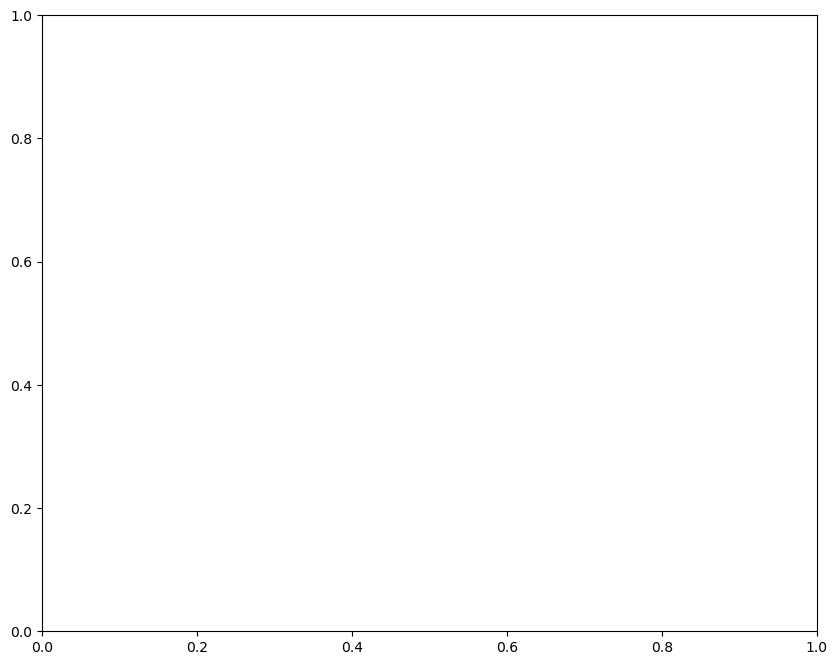

In [66]:
qm = df.plot(robust=True, cmap="GnBu", figsize=(10, 8))

# Coordinates of Iffezheim
target_lon = [8.13]
target_lat = [48.87]
# Add some crosses to check that 'get_value_at_coords' works correctly below
qm.axes.scatter(target_lon, target_lat, s=250, c="r", marker="x", lw=2)

## Locate the gauge closest to iffezheim


In [33]:
import pandas as pd
from pathlib import Path

gauges_path = Path("/home/elke/BEP-Elke/book/thesis_projects/BSc/2025_Q4_ElkeSchokking_CEG/work in progress/wflow_20250605_101331/staticmaps/gauges.col")

# Read comma-separated values with three columns: lon, lat, gauge_id
df_gauges = pd.read_csv(gauges_path, sep=",", header=None, names=["lon", "lat", "gauge_id"])
df_gauges["lon"] = df_gauges["lon"].astype(float)
df_gauges["lat"] = df_gauges["lat"].astype(float)
print(df_gauges.head())


lon      lat  gauge_id
0  7.61373  47.5757         1
1  7.89600  50.3170         2
2  9.01000  49.4400         3
3  7.75210  50.0881         4
4  6.96160  50.9417         5

In [34]:
from geopy.distance import geodesic

# Iffezheim coordinates
target_coords = (48.87, 8.13)

# Compute distance from Iffezheim to each gauge
df_gauges["distance_km"] = df_gauges.apply(
    lambda row: geodesic((row["lat"], row["lon"]), target_coords).kilometers,
    axis=1
)

# Sort and show nearest
df_gauges_sorted = df_gauges.sort_values("distance_km")
print(df_gauges_sorted.head(5))

lon      lat  gauge_id  distance_km
9   8.3030  49.0400        10    22.758504
2   9.0100  49.4400         3    90.214945
13  7.9080  49.9140        14   117.223866
6   8.4399  50.0049         7   128.206834
3   7.7521  50.0881         4   138.215512

### Gauge places and iffezheim

In [35]:
qm = da.plot(robust=True, cmap="GnBu", figsize=(10, 8))

# Coordinates of Iffezheim
target_lon = [8.13]
target_lat = [48.87]
# Add some crosses to check that 'get_value_at_coords' works correctly below
qm.axes.scatter(target_lon, target_lat, s=250, c="r", marker="x", lw=2)

# Coordinates of Gauges
target_lon = [8.3030, 9.0100, 7.9080]
target_lat = [49.0400, 49.4400, 49.9140]
# Add some crosses to check that 'get_value_at_coords' works correctly below
qm.axes.scatter(target_lon, target_lat, s=250, c="b", marker="x", lw=2)

NameError: name 'da' is not defined

### extract discharge

In [67]:
import pandas as pd

tss_file = "wflow_20250605_101331/run_default/run.tss"
df = pd.read_csv(tss_file, sep=r"\s+", header=None, skiprows=18)
df.columns = ["Timestep"] + [f"Gauge_{i}" for i in range(1, df.shape[1])]
df["Date"] = pd.date_range(start="2013-11-26", periods=len(df), freq="D")
df.set_index("Date", inplace=True)

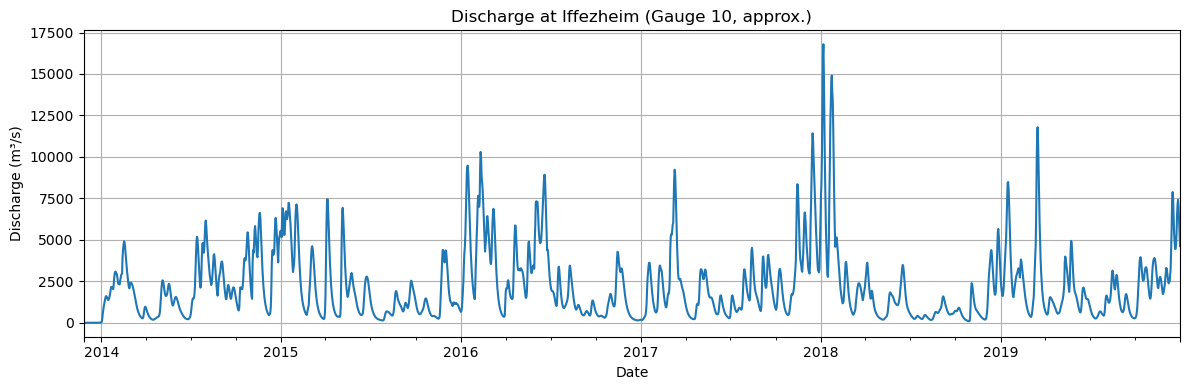

In [78]:
Q_sim = df["Gauge_10"]

# Plot discharge at Iffezheim (approximate via Gauge_10)
Q_sim.plot(figsize=(12, 4))
plt.title("Discharge at Iffezheim (Gauge 10, approx.)")
plt.ylabel("Discharge (m³/s)")
plt.xlabel("Date")
plt.grid(True)
plt.tight_layout()
plt.show()

## Observed vs discharge

In [71]:
# name of the catchment
basin_name = "FR000119"

# defining dates
experiment_start_date = "2013-11-26T00:00:00Z"
experiment_end_date = "2019-12-31T00:00:00Z"

In [75]:
# Manually parse the file
dates = []
discharges = []

with open("A3550050.csv", "r", encoding="utf-8") as f:
    next(f)
    for line in f:
        parts = line.replace('""', '"').strip().split(',"')
        if len(parts) >= 2:
            date_str = parts[0].strip('"')
            discharge_str = parts[1].strip('"')
            try:
                dates.append(pd.to_datetime(date_str))
                discharges.append(float(discharge_str))
            except ValueError:
                continue

discharge_series = pd.Series(discharges, index=dates, name="Discharge (m³/s)")
Q_obs = discharge_series[experiment_start_date:experiment_end_date]

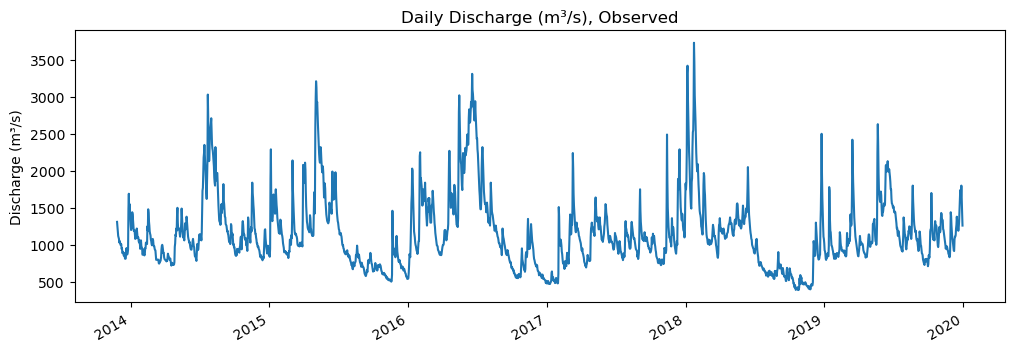

In [76]:
# Plot
Q_obs.plot(figsize=(12,4), title="Daily Discharge (m³/s), Observed")
plt.ylabel("Discharge (m³/s)")
plt.show()

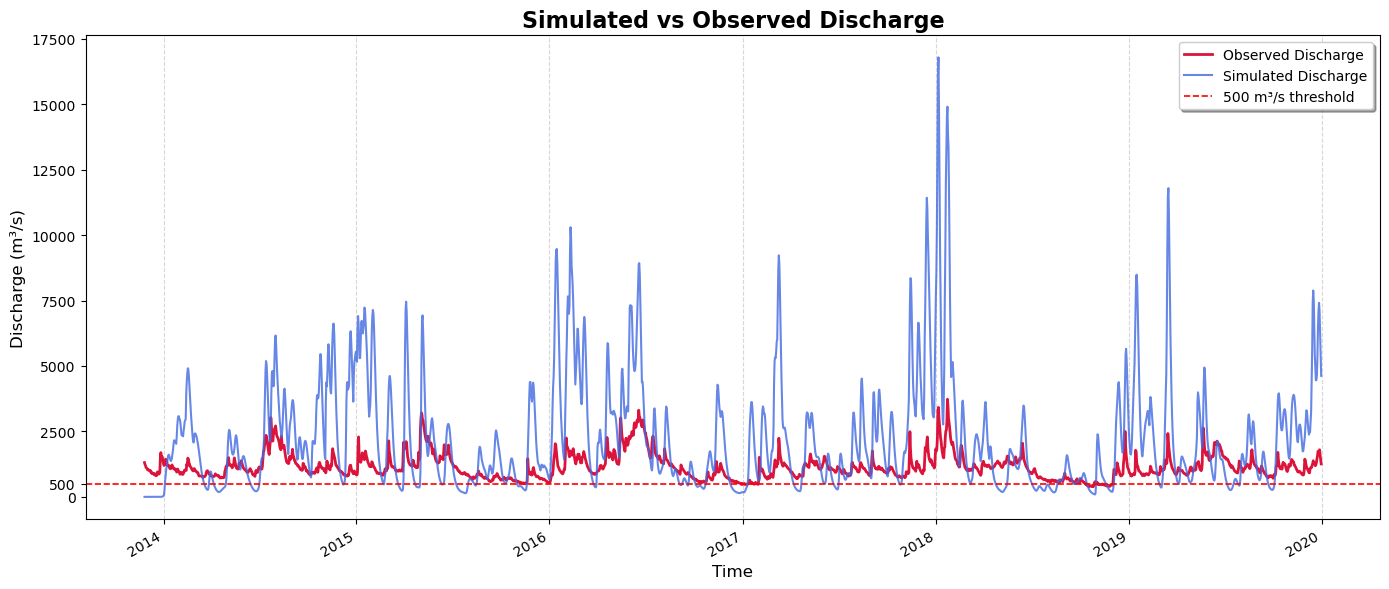

In [85]:
#Plot
fig, ax = plt.subplots(figsize=(14, 6))

# Plot lines with better alpha (transparency) and thinner lines
Q_obs.plot(ax=ax, label="Observed Discharge", color="crimson", linewidth=2)
Q_sim.plot(ax=ax, label="Simulated Discharge", color="royalblue", linewidth=1.5, alpha=0.8)

# Title and labels
ax.set_title("Simulated vs Observed Discharge", fontsize=16, weight='bold')
ax.set_ylabel("Discharge (m³/s)", fontsize=12)
ax.set_xlabel("Time", fontsize=12)

# Threshold line
plt.axhline(y=500, color='red', linestyle='--', linewidth=1.2, label='500 m³/s threshold')


# Y-ticks cleaned and padded
ymin, ymax = ax.get_ylim()
yticks = np.arange(0, ymax + 1, 2500)
if 500 not in yticks:
    yticks = np.append(yticks, 500)
    yticks = np.sort(yticks)

ax.set_yticks(yticks)
ax.tick_params(axis='y', labelsize=10)
ax.tick_params(axis='x', labelsize=10)

# Add a horizontal grid for better readability
ax.grid(visible=True, which='major', axis='x', linestyle='--', alpha=0.5)

# Legend styling
ax.legend(loc='upper right', fontsize=10, frameon=True, shadow=True)

# Tight layout
plt.tight_layout()
plt.show()

In [ ]:
#Plot
plt.figure(figsize=(18, 9))  # Wider and taller

for name, data in converted_outputs.items():
    plt.plot(data.index, data.values, label=name, linewidth=1.5, alpha=0.8)

# Threshold line
plt.axhline(y=500, color='red', linestyle='--', linewidth=1.2, label='500 m³/s threshold')

# Labels and title
plt.xlabel("Date", fontsize=14)
plt.ylabel("Discharge (m³/s)", fontsize=14)
plt.title("Modelled Discharge for Future Scenarios, 2050-2080", fontsize=16)

# Ticks and legend
plt.xlim(pd.Timestamp("2050-01-01"), pd.Timestamp("2080-01-01"))
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc="upper left", fontsize=12)
plt.grid(True, linestyle=':', linewidth=0.7)

# Tight layout for spacing
plt.tight_layout()
plt.show()

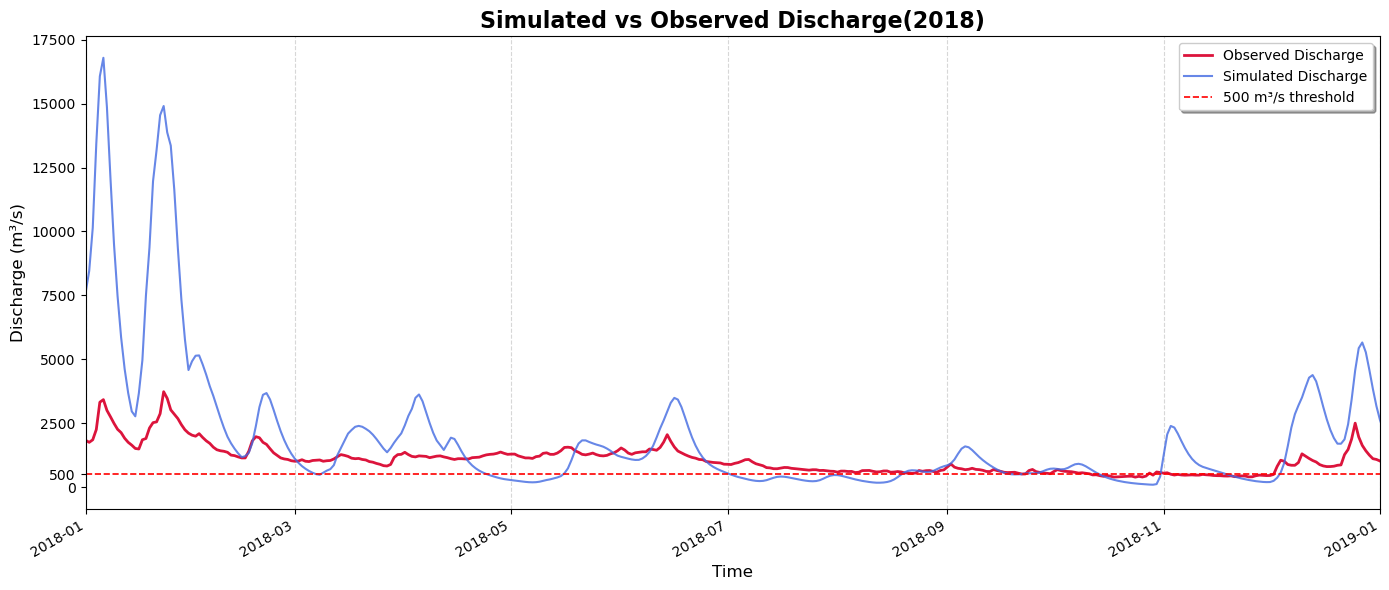

In [86]:
#Plot
fig, ax = plt.subplots(figsize=(14, 6))

# Plot lines with better alpha (transparency) and thinner lines
Q_obs.plot(ax=ax, label="Observed Discharge", color="crimson", linewidth=2)
Q_sim.plot(ax=ax, label="Simulated Discharge", color="royalblue", linewidth=1.5, alpha=0.8)
plt.xlim(pd.Timestamp("2018-01-01"), pd.Timestamp("2019-01-01"))

# Title and labels
ax.set_title("Simulated vs Observed Discharge(2018)", fontsize=16, weight='bold')
ax.set_ylabel("Discharge (m³/s)", fontsize=12)
ax.set_xlabel("Time", fontsize=12)

# Threshold line
plt.axhline(y=500, color='red', linestyle='--', linewidth=1.2, label='500 m³/s threshold')


# Y-ticks cleaned and padded
ymin, ymax = ax.get_ylim()
yticks = np.arange(0, ymax + 1, 2500)
if 500 not in yticks:
    yticks = np.append(yticks, 500)
    yticks = np.sort(yticks)

ax.set_yticks(yticks)
ax.tick_params(axis='y', labelsize=10)
ax.tick_params(axis='x', labelsize=10)

# Add a horizontal grid for better readability
ax.grid(visible=True, which='major', axis='x', linestyle='--', alpha=0.5)

# Legend styling
ax.legend(loc='upper right', fontsize=10, frameon=True, shadow=True)

# Tight layout
plt.tight_layout()
plt.show()